<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 20: Monte Carlo II</h1>

<a name='section_20_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_1">L20.1 Variational Autoencoders for Monte Carlo based Event Generation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_1">L20.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_2">L20.2 Generating Bragg Scattering with Variational Autoencoders</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_2">L20.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_3">L20.3 Generating Full Bragg Scattering Details</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_3">L20.3 Exercises</a></td0
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_4">L20.4 Conditional VAEs Allowing for Energy Based Generation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_4">L20.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_5">L20.5 Bootstrapping</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_5">L20.5 Exercises</a></td>
    </tr>
     <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_20_6">L20.6 Bootstrapping For Neural Networks</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_20_6">L20.6 Exercises</a></td>
    </tr>
</table>

<h3>Learning Objectives</h3>

We continue our exploration of Machine Learning Monte Carlo strategies, and show how some of the biggest advances in Artificial Intelligence are changing the way we simulation scientific data.

<h3>Installing Tools</h3>

Before we do anything, let's make sure we install the tools we need.

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [1]:
!pip install torchvision

In [2]:
!pip install git+https://github.com/SengerM/landaupy

  Cloning https://github.com/SengerM/landaupy to /private/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/pip-req-build-r9icjk_9
  Running command git clone --filter=blob:none --quiet https://github.com/SengerM/landaupy /private/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/pip-req-build-r9icjk_9
  Resolved https://github.com/SengerM/landaupy to commit fad88ce49fee62fa45f1adb34f130b3069df8210
  Preparing metadata (setup.py) ... done


In [3]:
!pip install pylandau

In [2]:
import imageio
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt

import pandas as pd
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [3]:
#>>>RUN: L10.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_21_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L17.4 Modelling Physics Observables: Bragg Scattering for Proton Therapy</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_3) | [Exercises](#exercises_21_4) | [Next Section](#section_21_5) |

There are a broad range of physics processes that we can use Monte Carlo to simulate. They typically involve scenarios where we don't have a good understanding of the analytic form of the whole system, but we understand how it works.

We can embed all of our knowledge into understanding how the system works into a simulation. A simulation that relies on sampling of events, and modelling the effects in an event by event way is deemed a Monte-Carlo simulation, there are a huge number of Monte Carlo simulations.

Lets start by simulating a particle passing through matter. This is one of the most common simulations, because we understand all the different sub processes well, but when we put them all together they are rather complicated.

We will do this in the context of proton therapy data. Proton therapy is a way to treat cancerous cells through a non invasive approach whereby we fire energetic proton beams to various body parts. These beams are precisely controled to deliver a dose of radiation at just the right spot. Let's go ahead and do a simple simulation.

What we are going to do first, is model the energy loss in matter, given by

$$
-\frac{dE}{dx} = \frac{4\pi \rho N_{A} z^2}{ M_{u} m_{e}c^{2}\beta^{2}}\frac{Z}{A}\left(\frac{e^{2}}{4\pi\epsilon_{0}}\right)^{2}\left(\log\left(\frac{2\gamma^{2}m_{e}c^{2}\beta^{2}T_{\rm max}}{I(1-\beta)^{2}}\right)-\beta^{2}-\frac{\delta(\beta\gamma)}{2}\right)
$$

Now to get this to work completely we need to compute the Ionization energy. The ionization energy is stored in a bunch of places. In particular, you can find it in [figure 34.5](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-passage-particles-matter.pdf), this depends on the nuclear stucture, but is roughly flat as a function of the nuclear charge as you get to higher elements. For our purposes, we will will just parameterize this as as table.

In addition, we also need the atomic masses $A$ of all the objects, we can again take this from an online source. For people familiar, we are taking this from the particle simulation code Geant in Fortran. Let's plot them below.

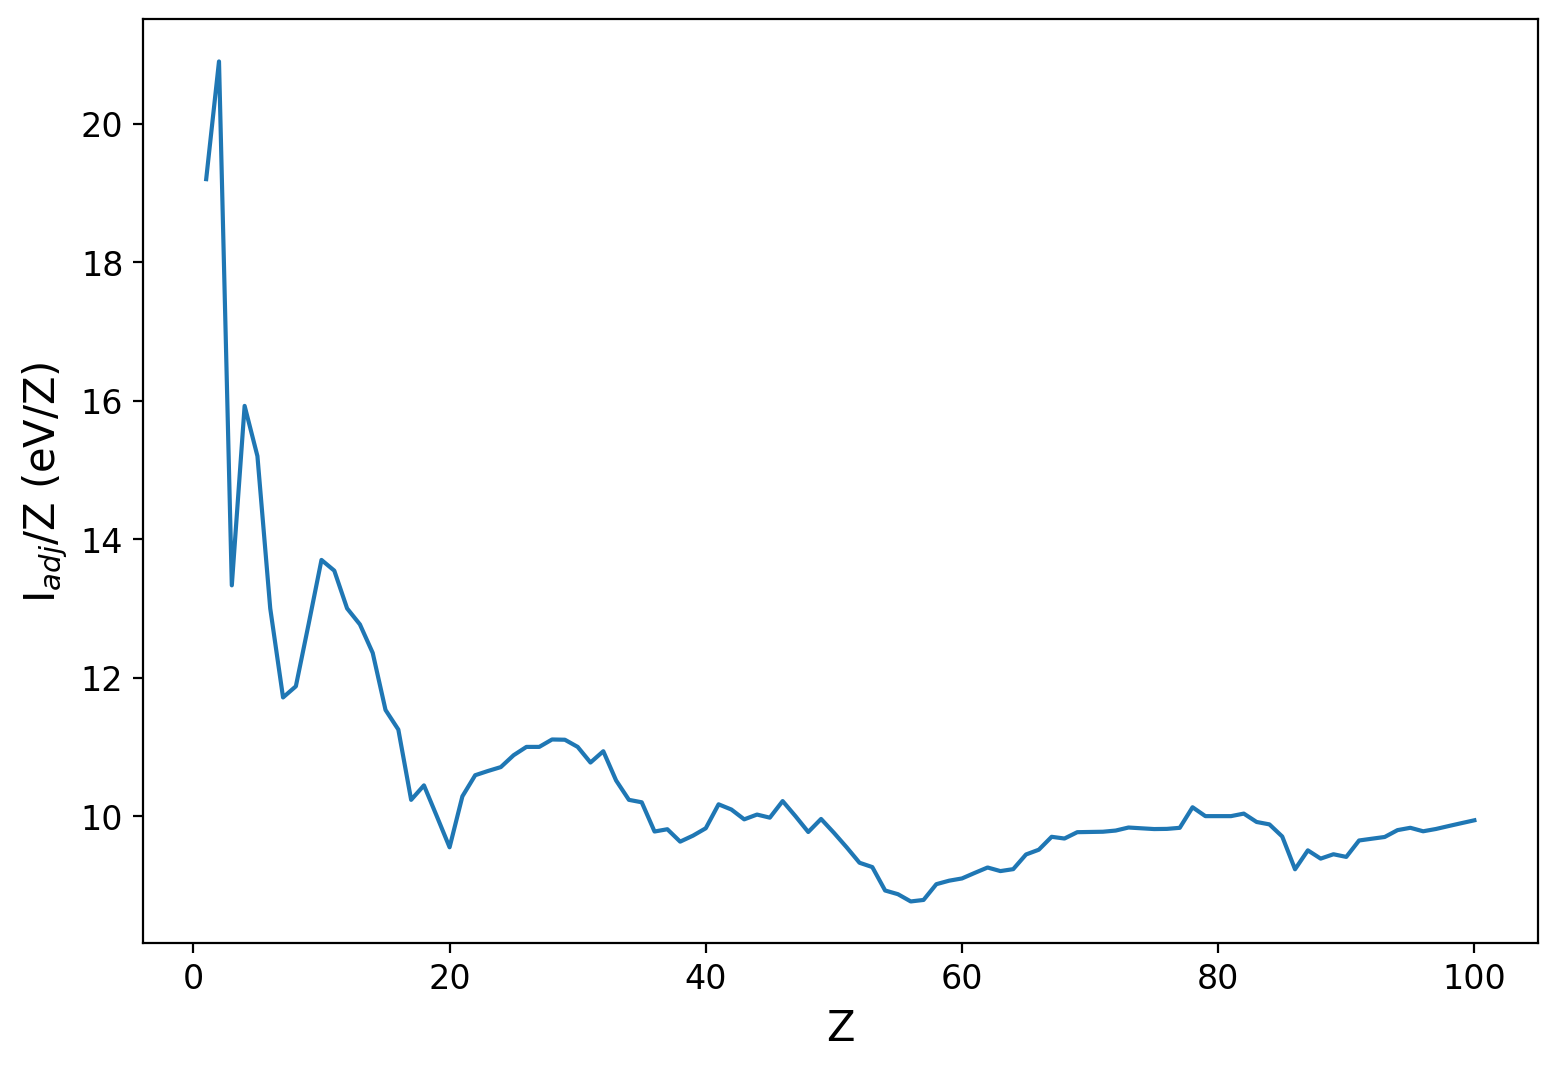

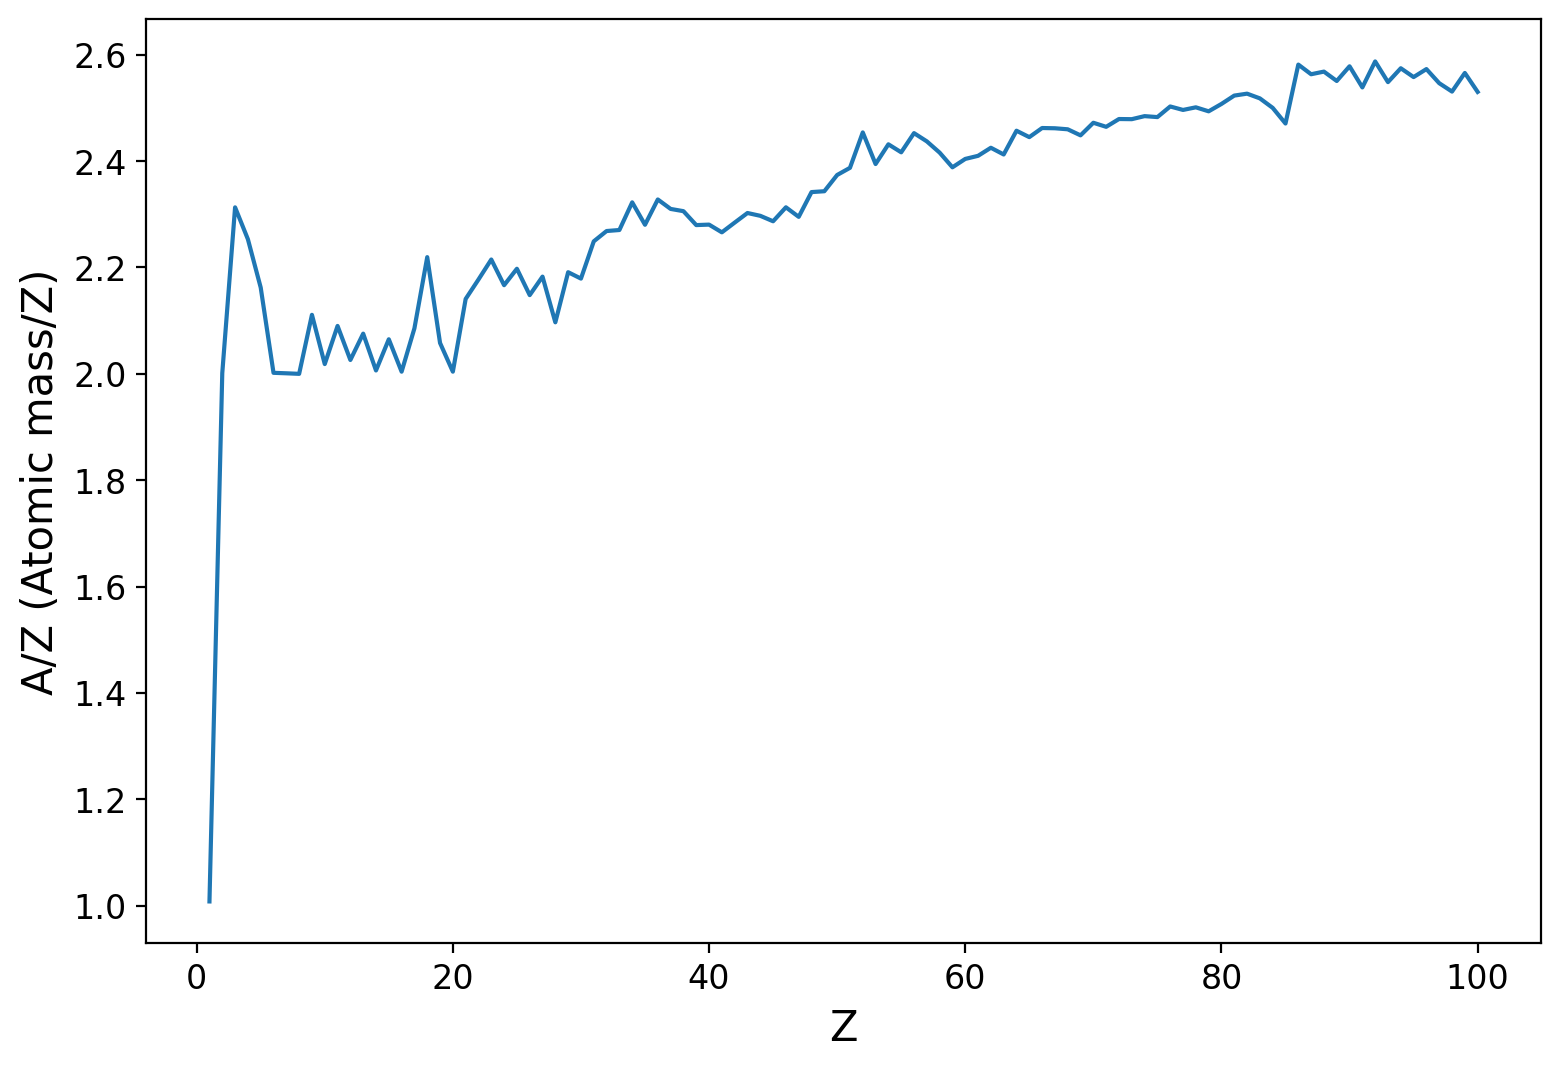

In [4]:
#values
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV
def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]
lItmp=I(1,True)
lItmp=A(1,True)

Now we have all the elements to compute the Bethe-Bloch formula, and look at the charged particle energy loss over distance. For this part, we are going to focus on protons. However, this generally applies to a lot of different phenomena.  

Additionally, we will plot this for two atomic elements. Since we care about the human body, we will plot this for water (Oxygen) and just to show something heavy thats in a human (calcium). See this [page](https://en.wikipedia.org/wiki/Composition_of_the_human_body)

1.0056667694537882 0.10600907909112761


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_6563/476672178.py:31: RuntimeWarning: invalid value encountered in power
  f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))


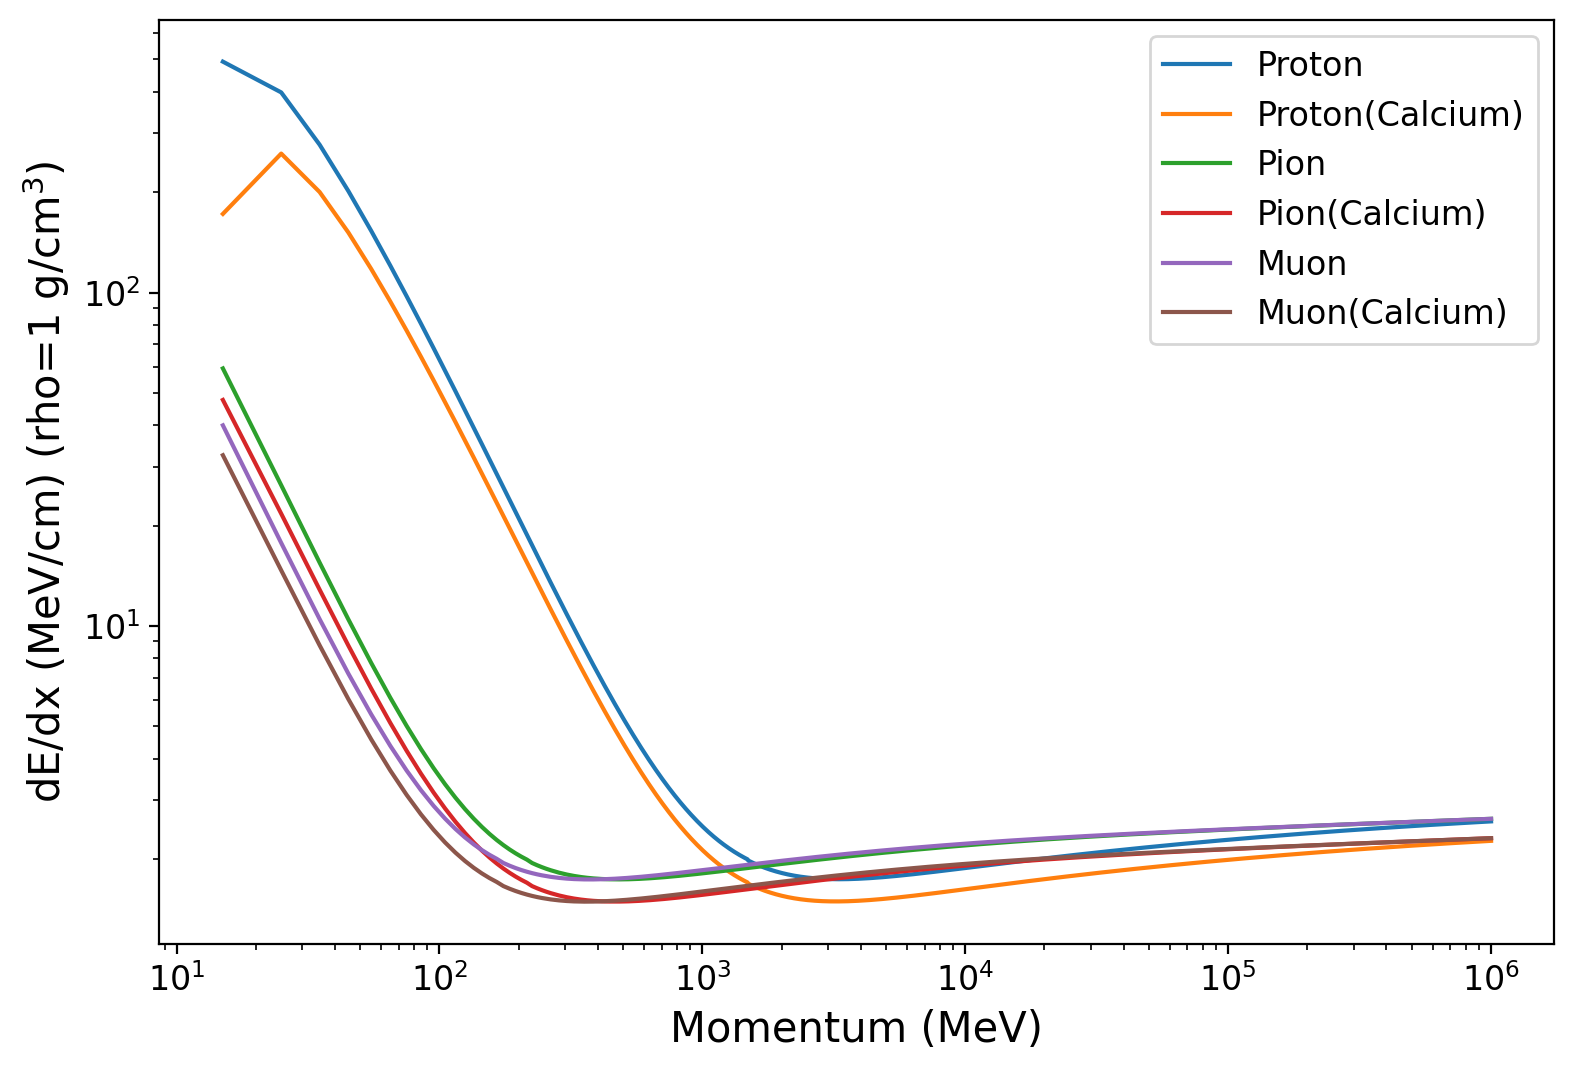

0.7059732966763472

In [5]:
#https://indico.cern.ch/event/753612/contributions/3121551/attachments/1974578/3285956/MC_2019.pdf
#https://www.nature.com/articles/s41598-017-10554-0

m_e = 0.511 # Mass of electron in MeV

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0, 0, f2)
    delta_full = np.where(x < X1 ,delta_full, f3)
    return delta_full

def dEdxF(ip,im,iZ,zpart=1,rho=1.0,nodelta=False): #Bethe-Bloch equation
    K = 0.307075 # constant K in MeV cm mol^-1
    #rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
    const   = zpart**2 * (K * rho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    logterm = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    dEdxV   =  const * (np.log(logterm)  - 2*(beta(ip,im))**2 - delta(ip,im))
    if nodelta:
        print("delta:",delta(ip,im),dEdxV)
        dEdxV    =  const * (np.log(logterm) - 2*(beta(ip,im))**2)
    return dEdxV

mproton=938
mpion=135.4
mmuon=105.4
print(gamma(100,mproton),beta(100,mproton))
p=np.arange(15,1000000,10)
dEdxOut1p = dEdxF(p,mproton,8,1)
dEdxOut2p = dEdxF(p,mproton,18,1)
dEdxOut1pi = dEdxF(p,mpion,8,1)
dEdxOut2pi = dEdxF(p,mpion,18,1)
dEdxOut1mu = dEdxF(p,mmuon,8,1)
dEdxOut2mu = dEdxF(p,mmuon,18,1)

plt.plot(p,dEdxOut1p,label="Proton")
plt.plot(p,dEdxOut2p,label="Proton(Calcium)")

plt.plot(p,dEdxOut1pi,label="Pion")
plt.plot(p,dEdxOut2pi,label="Pion(Calcium)")

plt.plot(p,dEdxOut1mu,label="Muon")
plt.plot(p,dEdxOut2mu,label="Muon(Calcium)")

plt.xlabel('Momentum (MeV)')
plt.ylabel('dE/dx (MeV/cm) (rho=1 g/cm$^{3}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

beta(935,mproton)

Now, we can run a basic simulation of this already by considering a particle of a specific energy and then stepping it down by the energy loss. We could in fact do this analytically, but using the above formula makes it particulary nice and elegant. Let's go ahead and run our simulation for our proton energy beam.

An important point to remember is that energy and momentum differ. In otherwords a 350 MeV proton will give a differnt momentum. Note that when we say a 350 MeV proton. We actually mean the kinetic energy is 350 MeV. This means our momentum is given by

$$
p^2 + m^2 = \left(E_{\rm kin} + m\right)^2 \\
p^2 = (E_{kin} + m)^2 - m^2
$$

350 MeV Proton Momemtum: 882.6664149042944


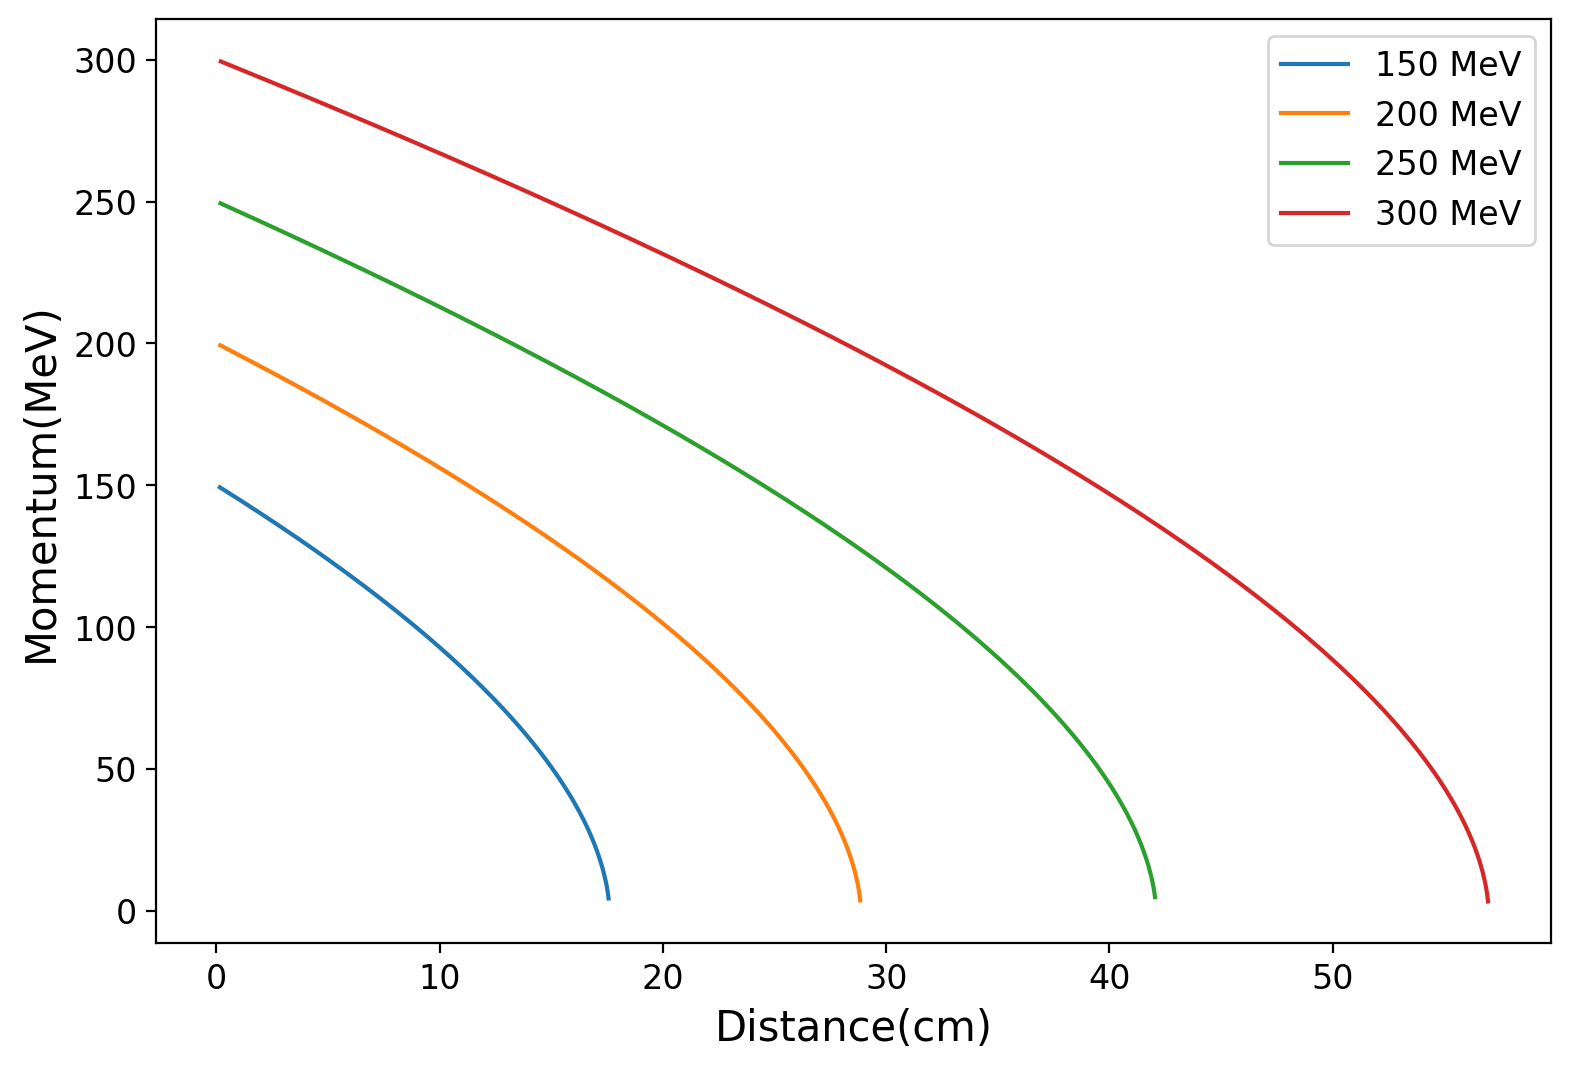

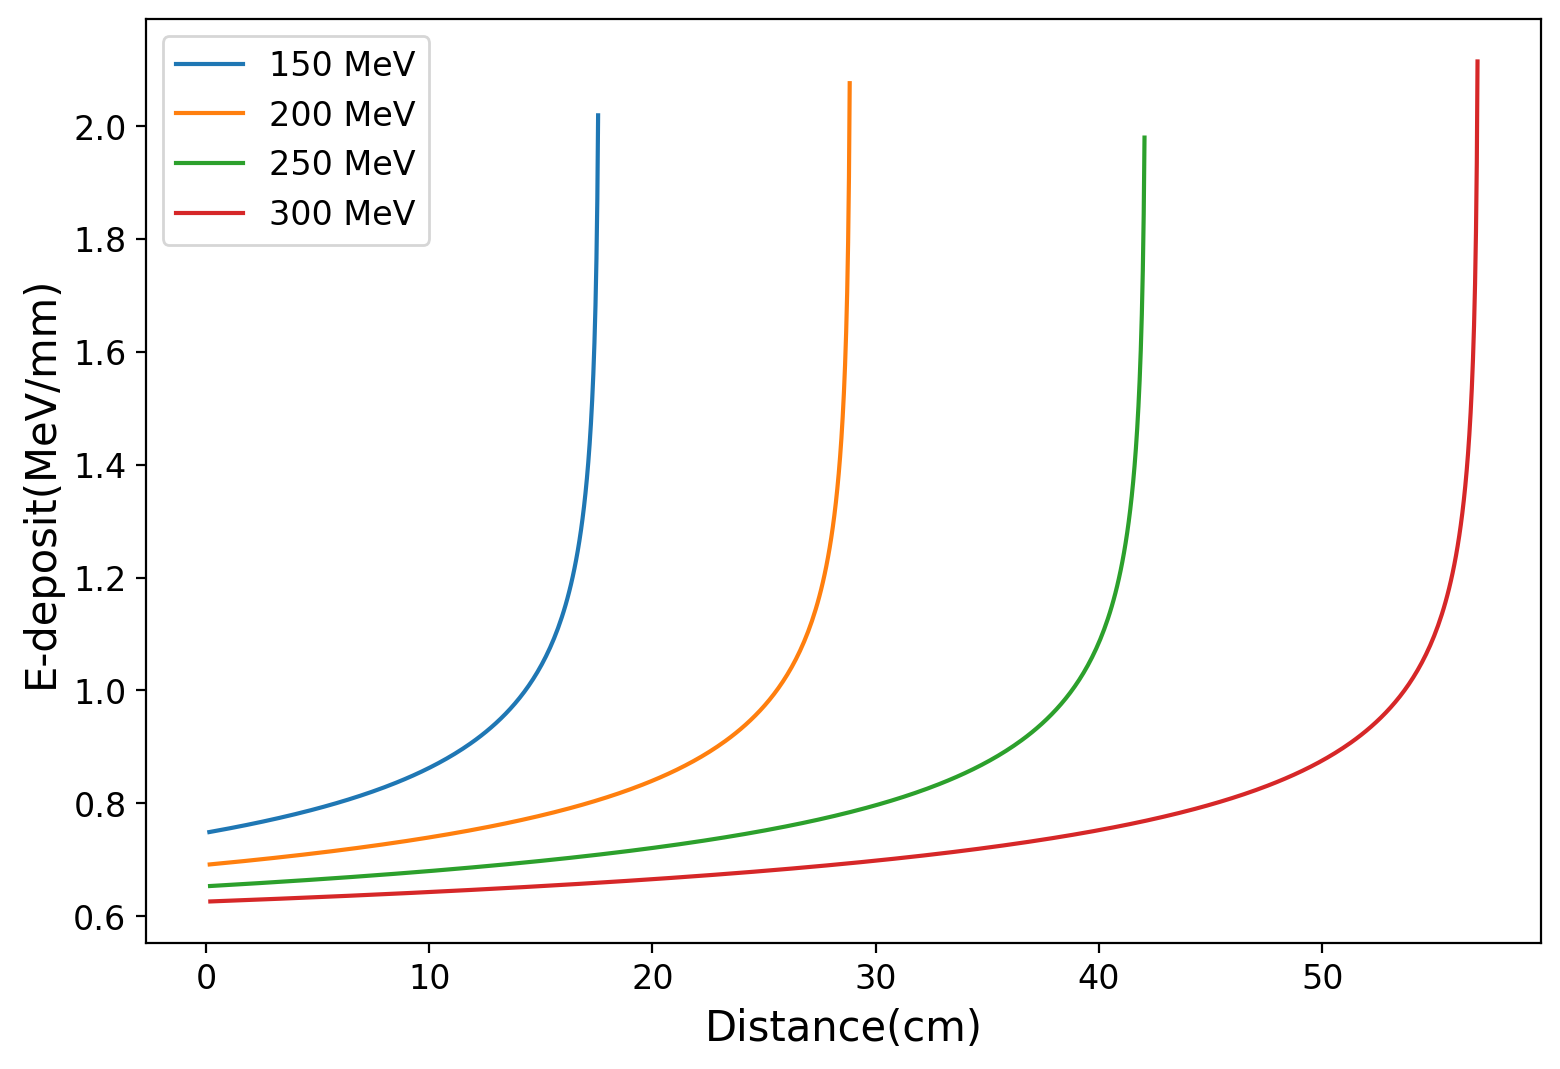

In [6]:
def dP(dE,ip,im): #solving
    #dp = ip - np.sqrt(dE**2+ip**2-2*dE*np.sqrt(ip**2+im**2))
    #E=p^2/2m=> p=\sqrt(2mE)=>dp=sqrt(2m)/sqrt(E) dE
    #return dE*(np.sqrt(ip**2+im**2)/ip)*gamma(ip,im)
    return dE#*(ip/im)

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def sim(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = []
    estep  = []
    pstep  = []
    c=3e10
    dist=0
    e=ie
    while e > 5: #stop at 5 MeV
        p = eToP(e,im)
        dEdxS  = dEdxF(p,im,iZ=iZ,rho=1.06)
        #print(dEdxS)
        dx     = beta(p,im)*c*idt#speed of light
        #print(dEdxS,dP(dEdxS*dx,p,im))
        e      -= dEdxS*dx
        dist   += dx
        xstep.append(dist)
        estep.append(dEdxS*dx)
        pstep.append(e)
    return np.array(xstep),np.array(pstep),np.array(estep)

print("350 MeV Proton Momemtum:",eToP(350,mproton))
xstep150,pstep150,estep150 = sim(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = sim(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = sim(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = sim(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()

#sim(60,dt=1e-12)

Now what you can see above is that we get a very sharp energy deposit at a very specific region. As a result, we can use proton beams to deposit a huge amount of energy in the body for cancer thereapy. This peak is known as the Bragg peak. You can see that various energy beams get us various ranges in the body. Let's go one step further and make our simulation even more realistic.  

There are three ways to do this:
1. Sample the full energy profile interaction as we move along the decay
2. Smear the initial beam energy by the input resolution
3. Add other effects, namely multiple scattering.

Let's go ahead and start with the first since this is often the most illustrative.

Energy loss is actually governed by a Landau distribution. What that means is that the energy depositied is not a fixed amount per step, but is distribution. The full distribution follows the Landau form given by

$$
p(x) = \frac{1}{\pi}\int_{0}^{\infty} e^{-t \log(t)-xt} \sin(\pi t) dt
$$

To model energy loss exactly, what we need to do is sample a landau distribution at every step and apply the sampled value to our calculation of $\frac{dE}{dx}$. Let's go ahead and plot the Landau and come up with a scheme to sample it.

We will take a resolution of 1.5 percent following [here](https://indico.cern.ch/event/654712/contributions/2666034/attachments/1531773/2397743/SJ_STFCDetectors_ProCal_25-09-17.pdf). Additionally, we will stop our proton beam once we have < 15 MeV.

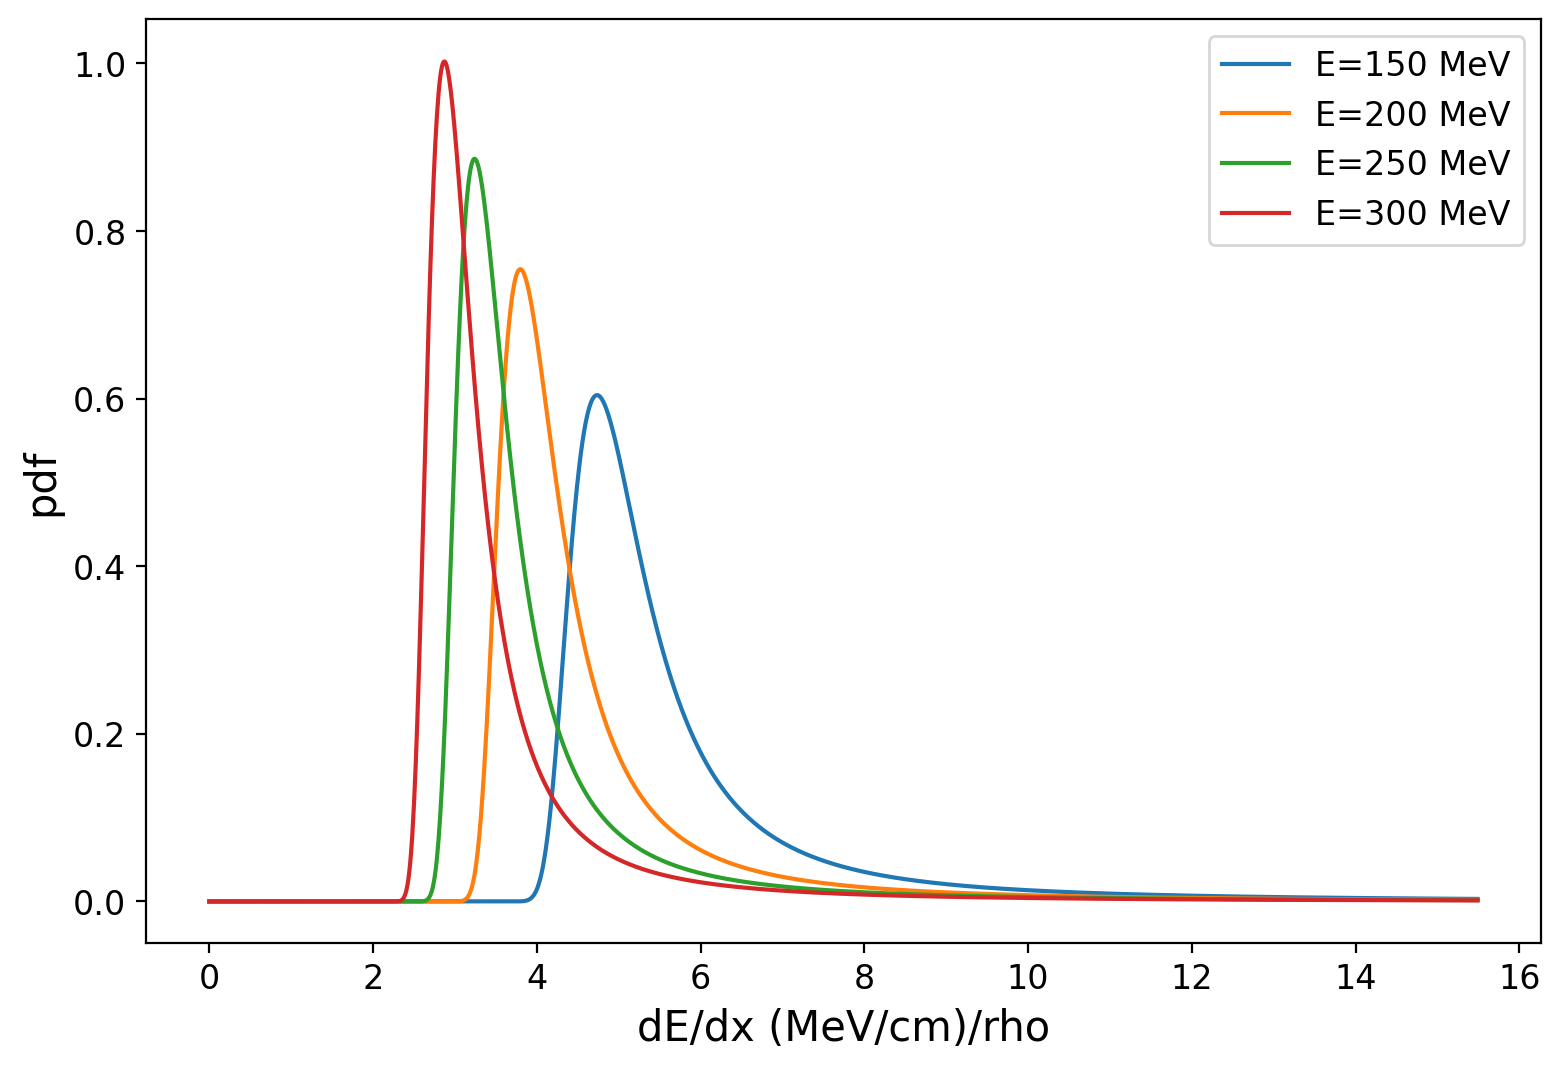

In [7]:
import pylandau
from landaupy import landau

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def plotLandau(ip,im,idx,iZ=14,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV(lP,im,iZ,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,15.5,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

x,landZ150=plotLandau(150,mproton,1.0,iZ=8,irho=1.0)
x,landZ200=plotLandau(200,mproton,1.0,iZ=8,irho=1.0)
x,landZ250=plotLandau(250,mproton,1.0,iZ=8,irho=1.0)
x,landZ300=plotLandau(300,mproton,1.0,iZ=8,irho=1.0)

plt.plot(x,landZ150,label='E=150 MeV')
plt.plot(x,landZ200,label='E=200 MeV')
plt.plot(x,landZ250,label='E=250 MeV')
plt.plot(x,landZ300,label='E=300 MeV')
plt.xlabel("dE/dx (MeV/cm)/rho")
plt.ylabel("pdf")
plt.legend()
plt.show()


Now, what we can do to add some level of realisim as we move along our path of the proton going thorugh matter. Every time we step, we can sample the landau distribution pdf and step our energy loss. Given that we are sampling, it now makes sense to run this experiment a number of times. This now starts to give us some real Monte Carlo description.  

Sampling complicated distributions like this can often be slow. This code was implemented [here](https://github.com/SengerM/landaupy/blob/main/landaupy/samplers.py#L42). The strategy is to randomly sample a number from 0 to 1, this a p-value, then you can get the x-value by inverting the CDF since we know that

$$
\rm{cdf}(x)=\int_{-\infty}^{x} p(x^{\prime}) dx^{\prime}
$$

so we treat the cdf as a 1 to 1 map the y-axis is probabilty and teh x-axis is the pdf value integrated up to $x$. By inverting the cdf, treating this as a lookup table we can ivert the function so that ${\rm cdf}^{-1}(y)=x$.  

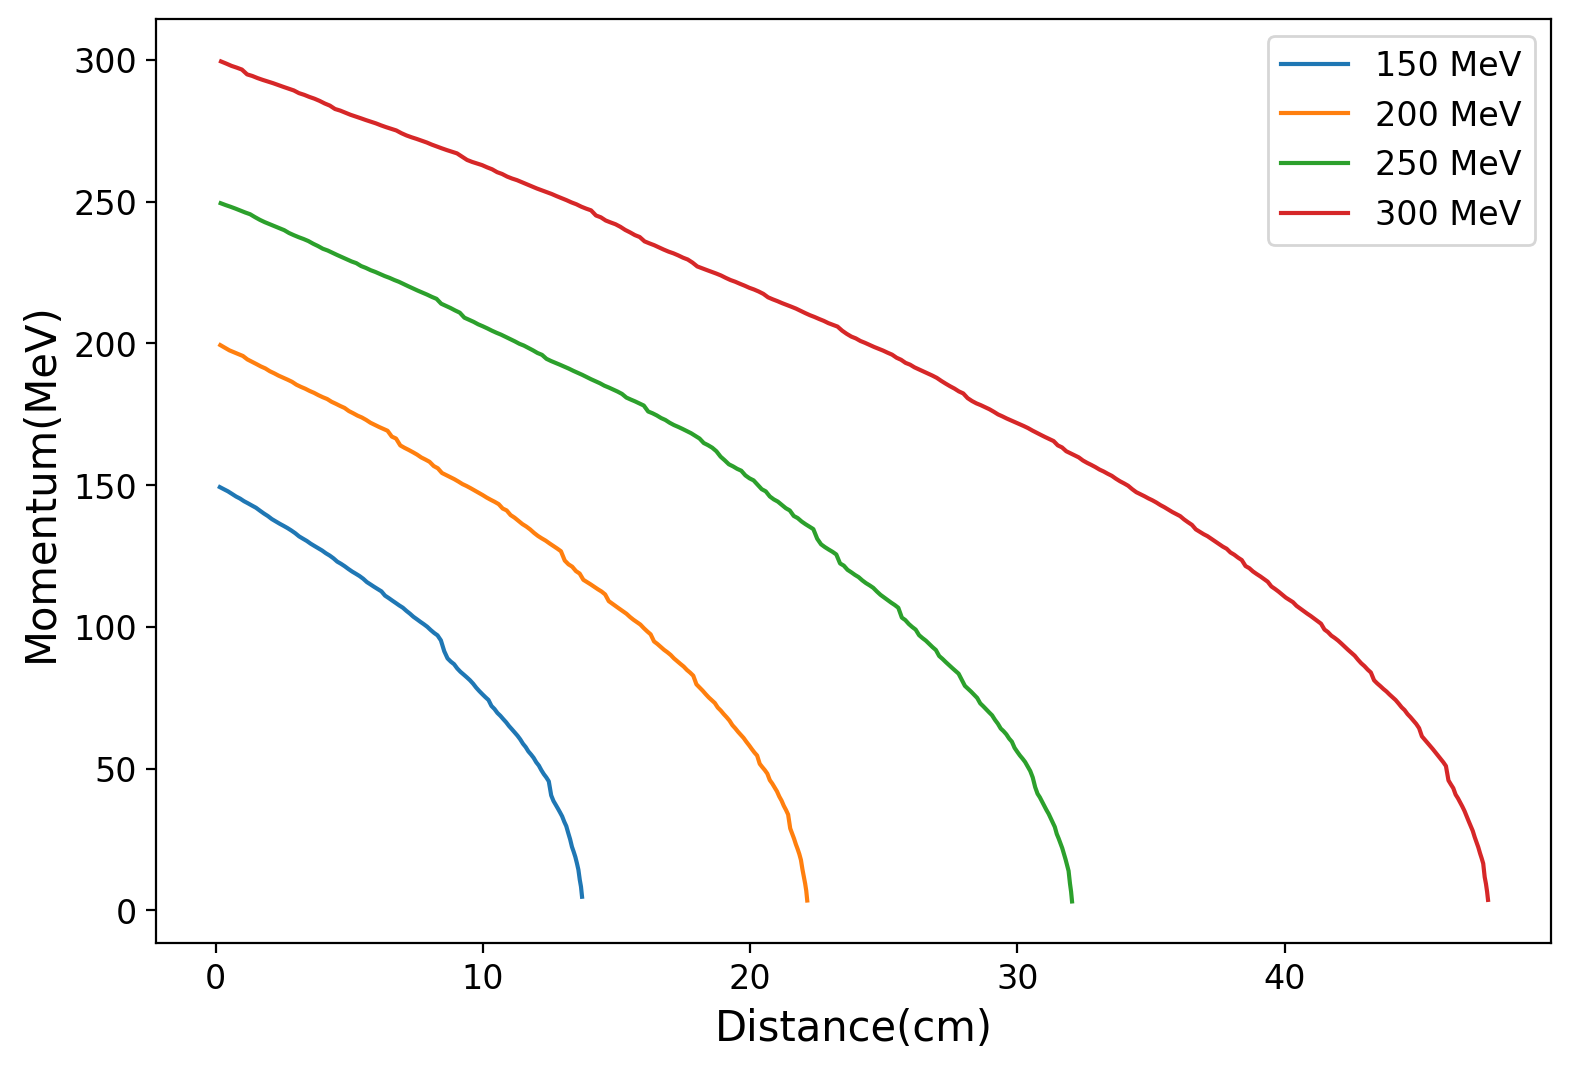

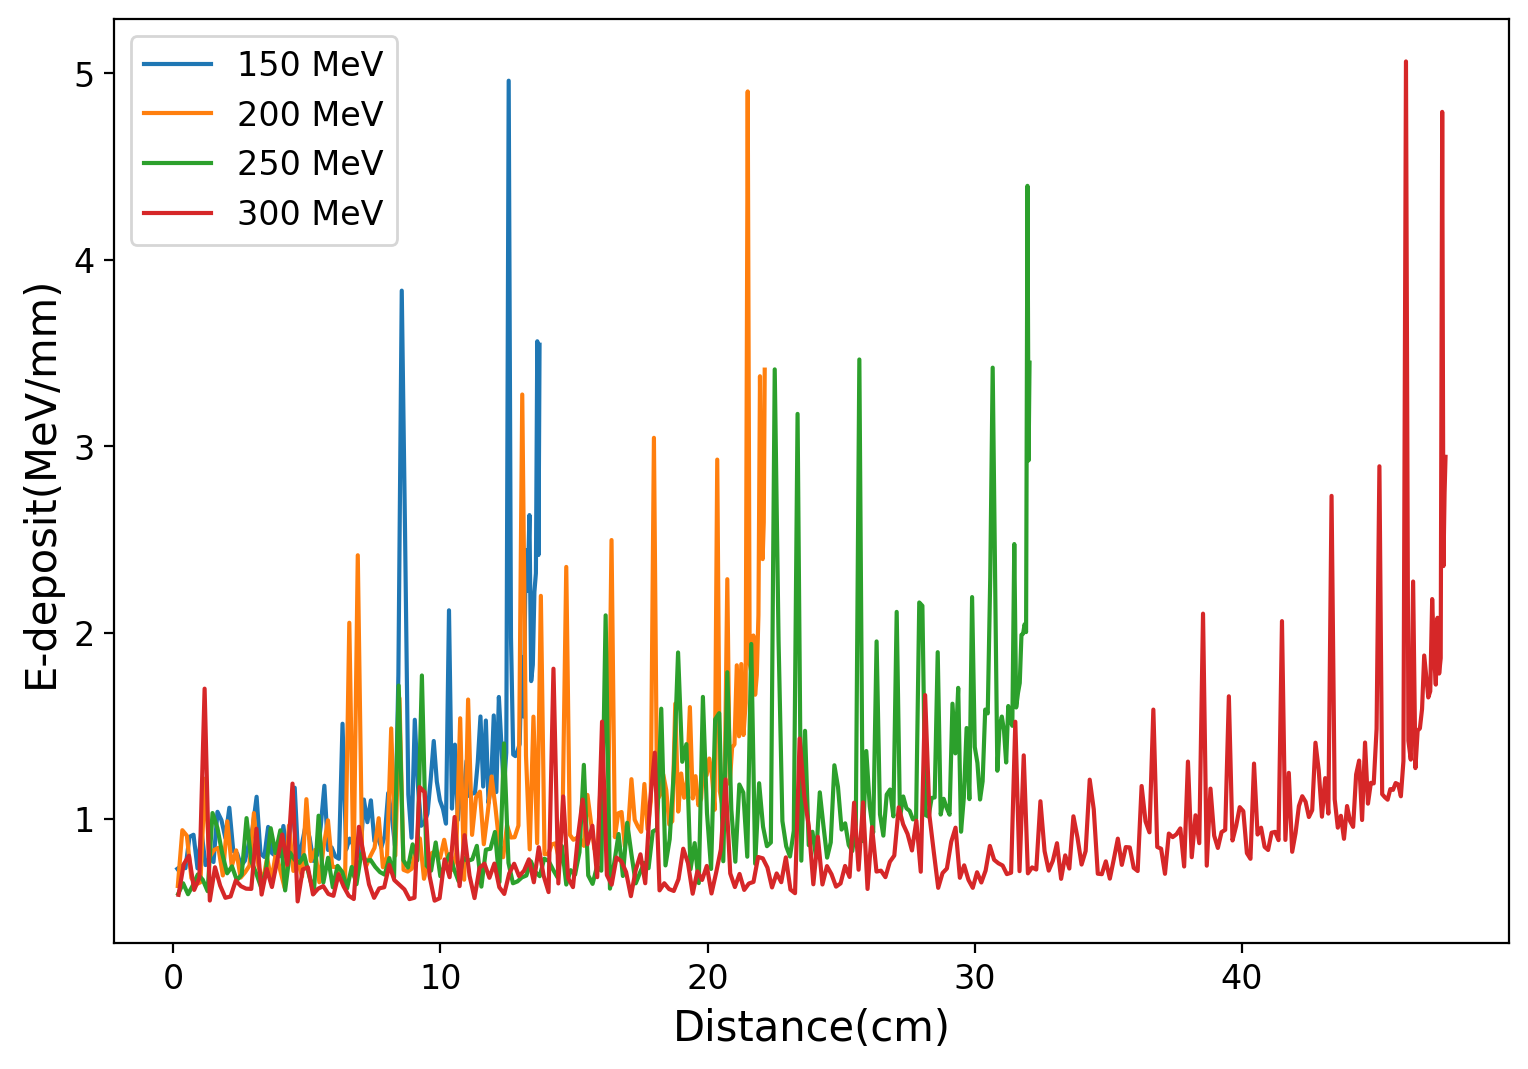

In [8]:
def simSample(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = []
    estep  = []
    pstep  = []
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE     = landau.sample(lMPV, lWMPV, 1)
        dx     = beta(p,im)*c*idt#speed of light
        e      -= dE*dx
        dist   += dx
        xstep.append(dist)
        estep.append(dE*dx)
        pstep.append(e)
    return np.array(xstep),np.array(pstep),np.array(estep)

xstep150,pstep150,estep150 = simSample(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = simSample(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = simSample(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = simSample(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()



Ok so now lets step through this guy and look at the distribution of energy deposited in our system. What we will do is our simulation above 100 times and see how much the energy deposit varies, and how much the length of propagation varies.

For this, we will define a few observables, lets look at the energy deposit in the last 3cm. Also, lets look at the energy deposit in the first 3 cm, for comparison. Also, we can look at the after distance the system went.

0
25
50
75


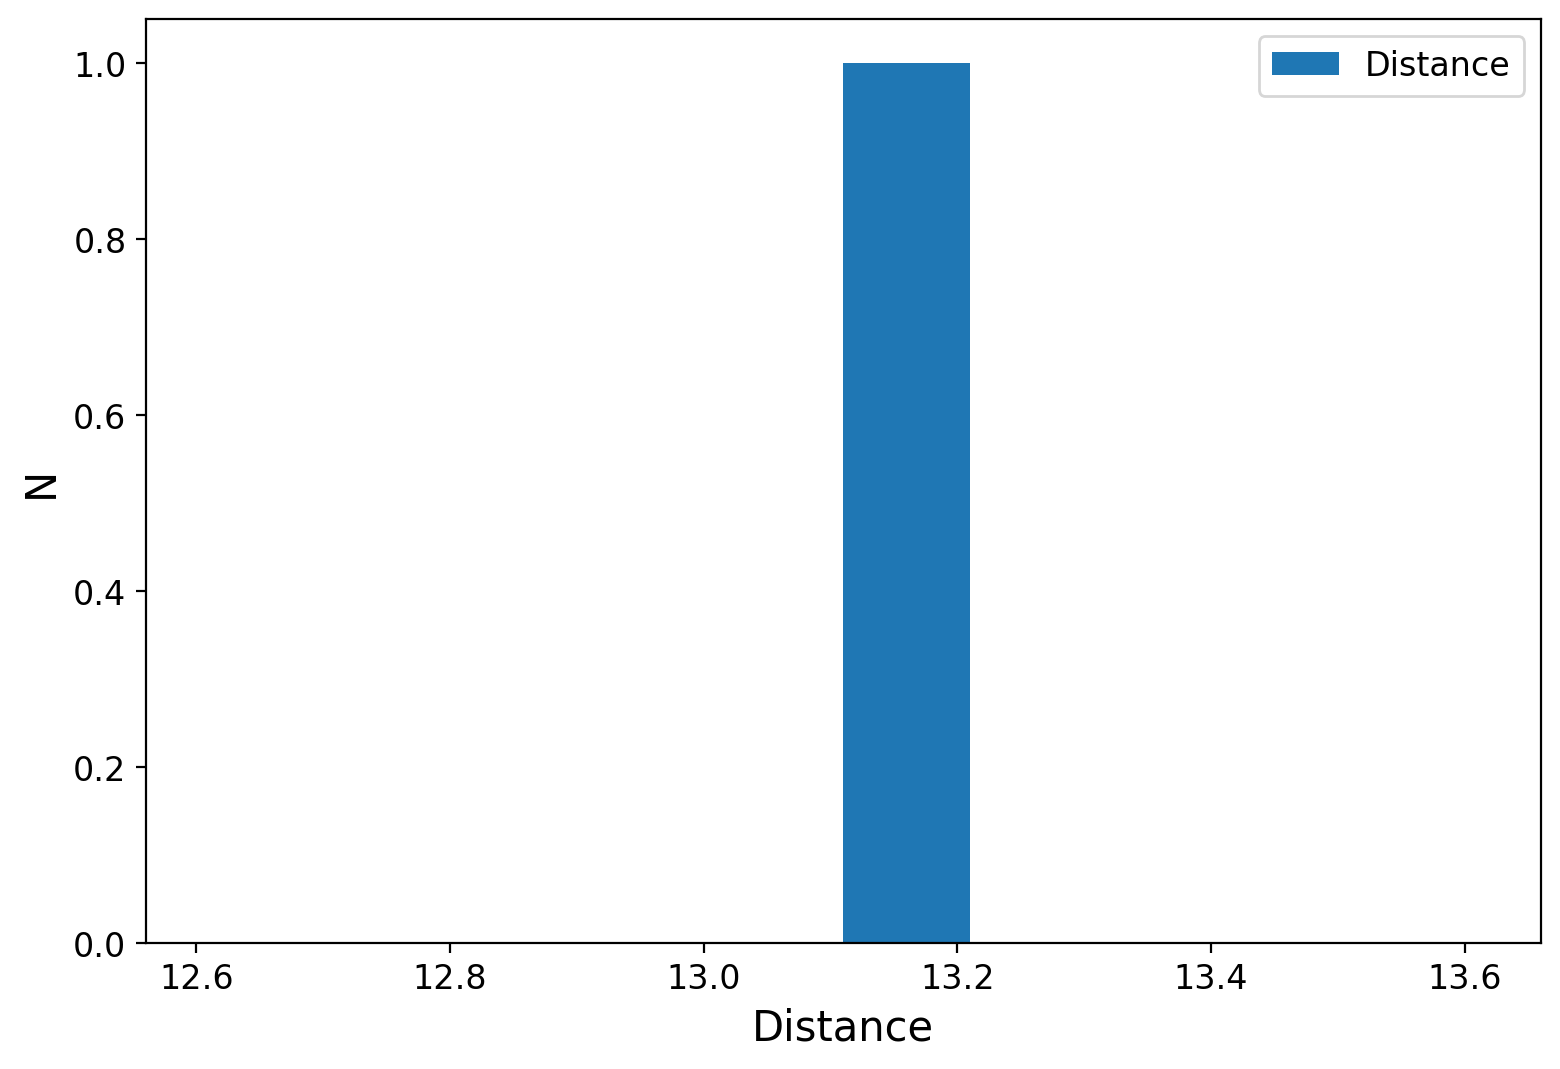

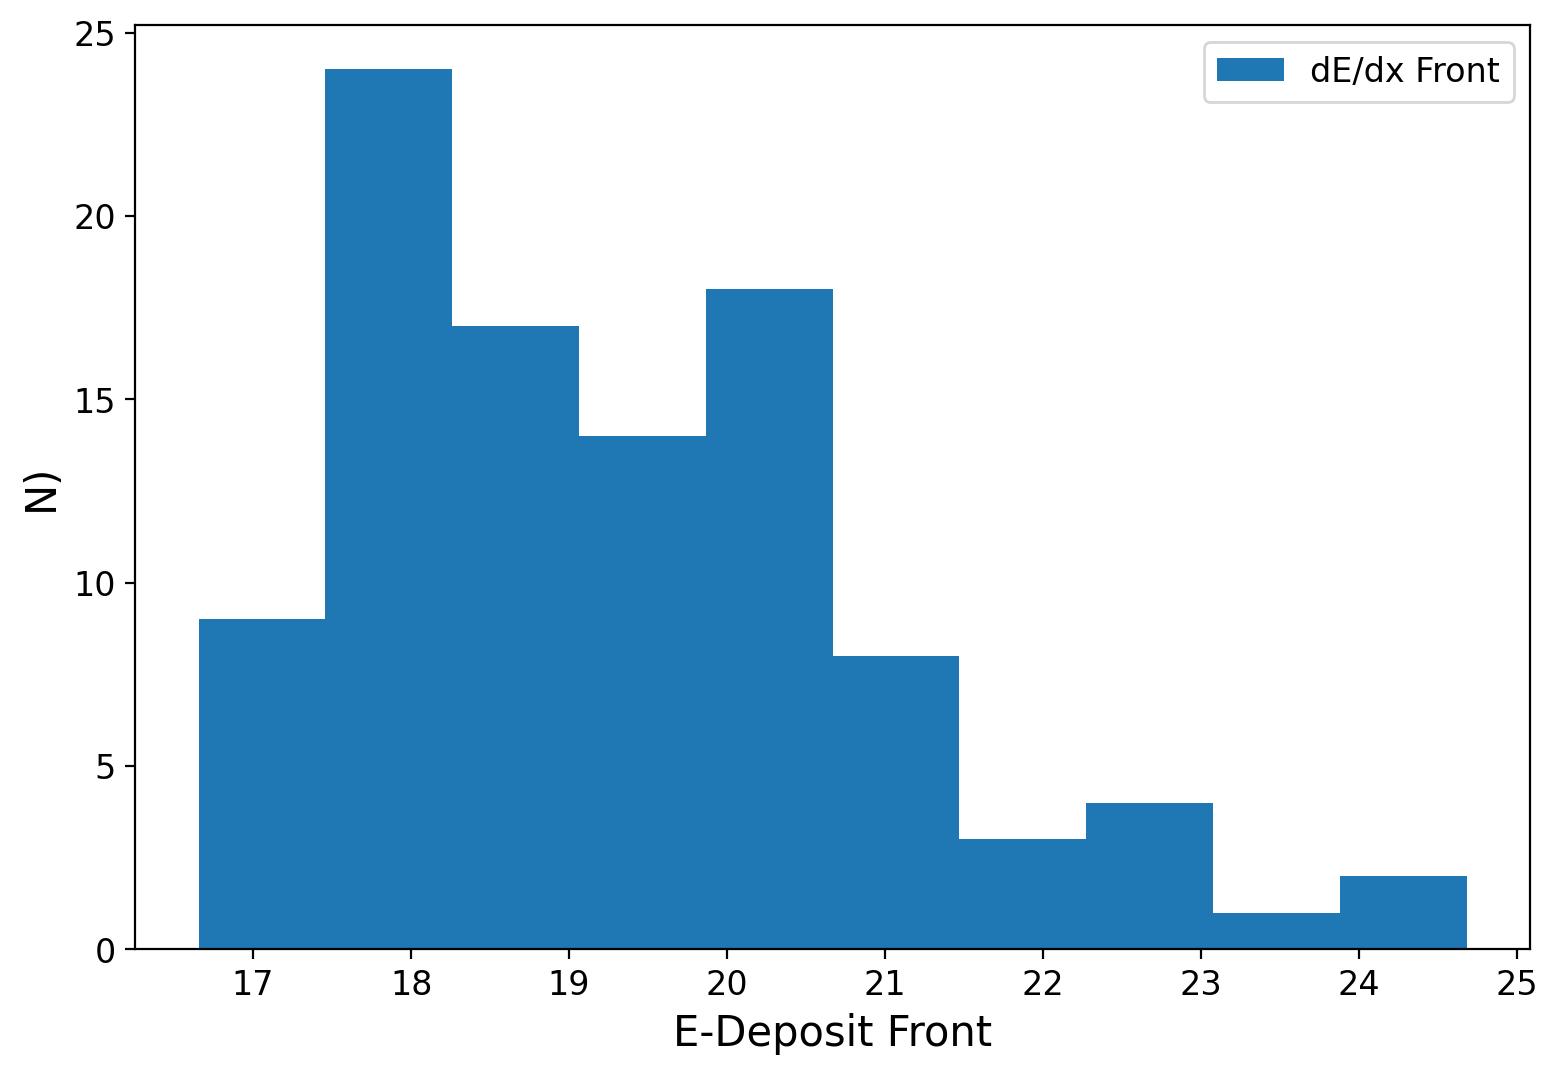

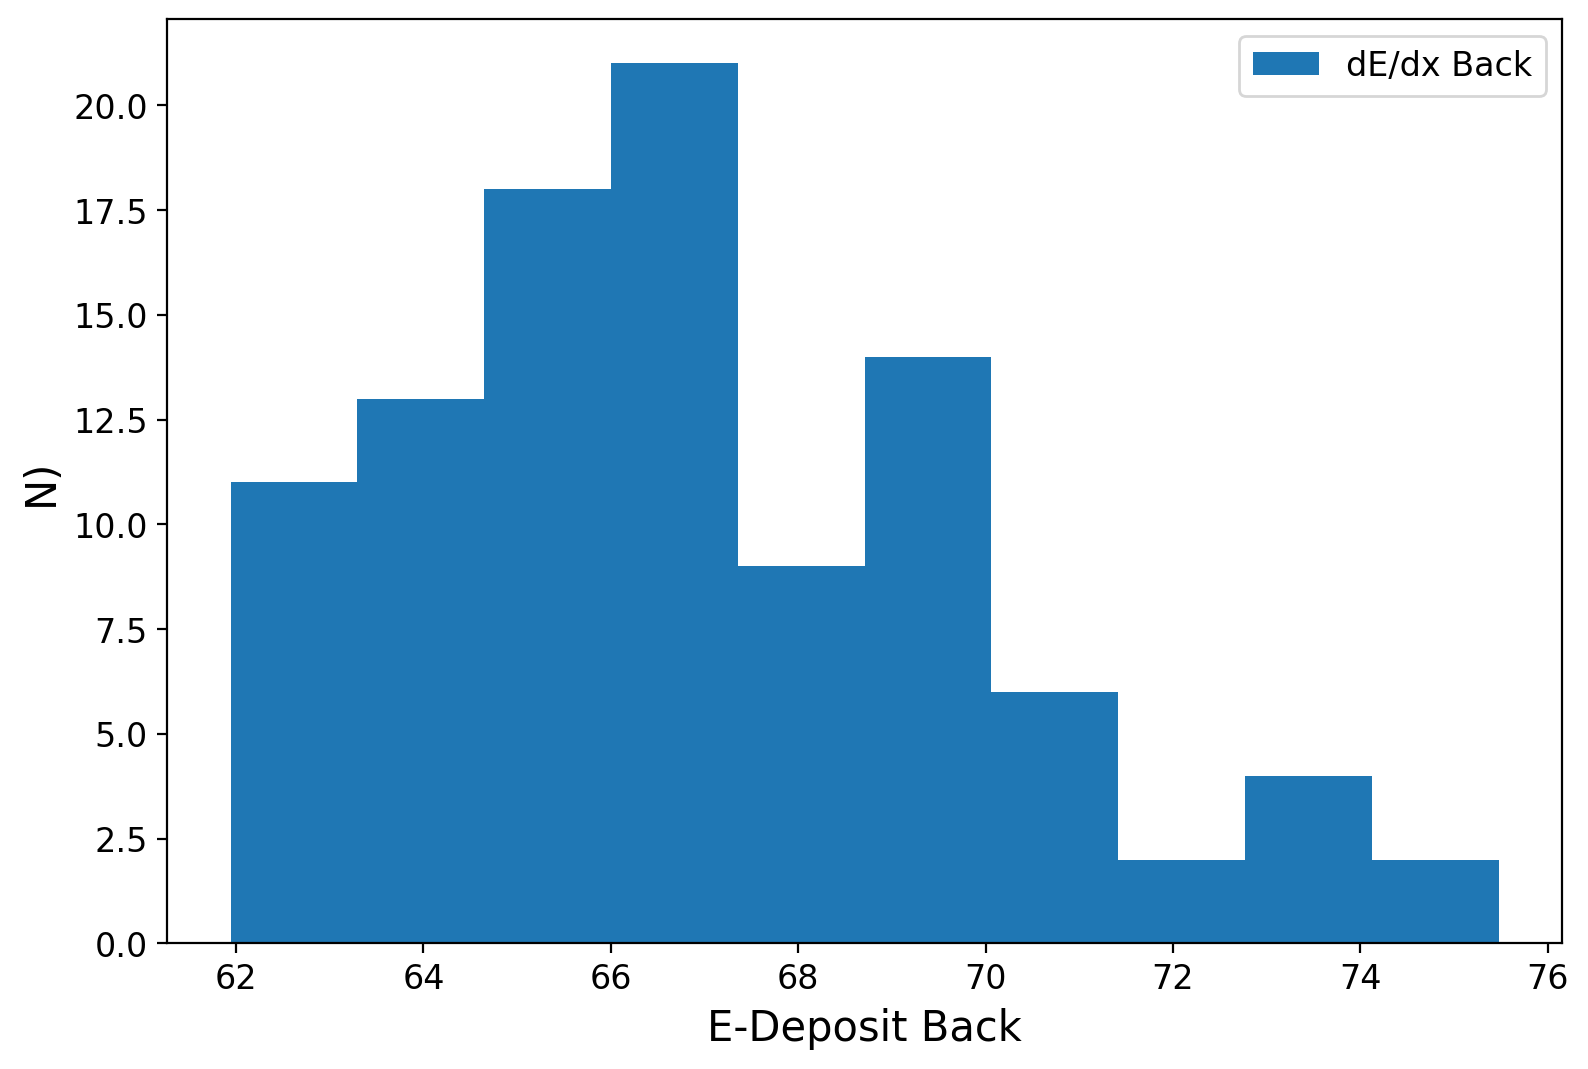

In [9]:
def observables(iXArr,iPArr,iEArr):
    lX=iXArr[-1]
    dEEnd=np.sum(iEArr[(iXArr > iXArr[-1]-3)])
    dEFrt=np.sum(iEArr[(iXArr < 3)])
    return lX,dEEnd,dEFrt

def simNSamples(ie=150,im=mproton,iN=100,idt=1e-11,iZ=8):
    pXArr   = []
    pdEBArr = []
    pdEFArr = []
    for i0 in range(iN):
        if i0 % 25 == 0:
            print(i0)
        pXstep,pPstep,pEstep = simSample(ie=ie,im=im,idt=idt,iZ=iZ)
        pX,pdEEnd,pdEFrt = observables(pXstep,pPstep,pEstep)
        pXArr.append(  pXstep)
        pdEBArr.append(pdEEnd)
        pdEFArr.append(pdEFrt)

    plt.hist(pX,label='Distance')
    plt.xlabel('Distance')
    plt.ylabel('N')
    plt.legend()
    plt.show()

    plt.hist(pdEFArr,label='dE/dx Front')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.legend()
    plt.show()

    plt.hist(pdEBArr,label='dE/dx Back')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.legend()
    plt.show()


#plt.plot(xstep150,estep150,label='150 MeV')
#plt.plot(xstep200,estep200,label='200 MeV')
#plt.plot(xstep250,estep250,label='250 MeV')
#plt.plot(xstep300,estep300,label='300 MeV')
#plt.xlabel('Distance(cm)')
#plt.ylabel('E-deposit(MeV/mm)')
#plt.legend()
#plt.show()

simNSamples()


Now that was kind of slow can we speed up this process?

The way we will do this is we will step through 500 simulations all the same time in parallel. The one thing that is tricky is that parallel support for sampling the Landau is not supported, so we will have to add a for loop to do that bit. Anyway, otherwise, we can run everything else in parallel.

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


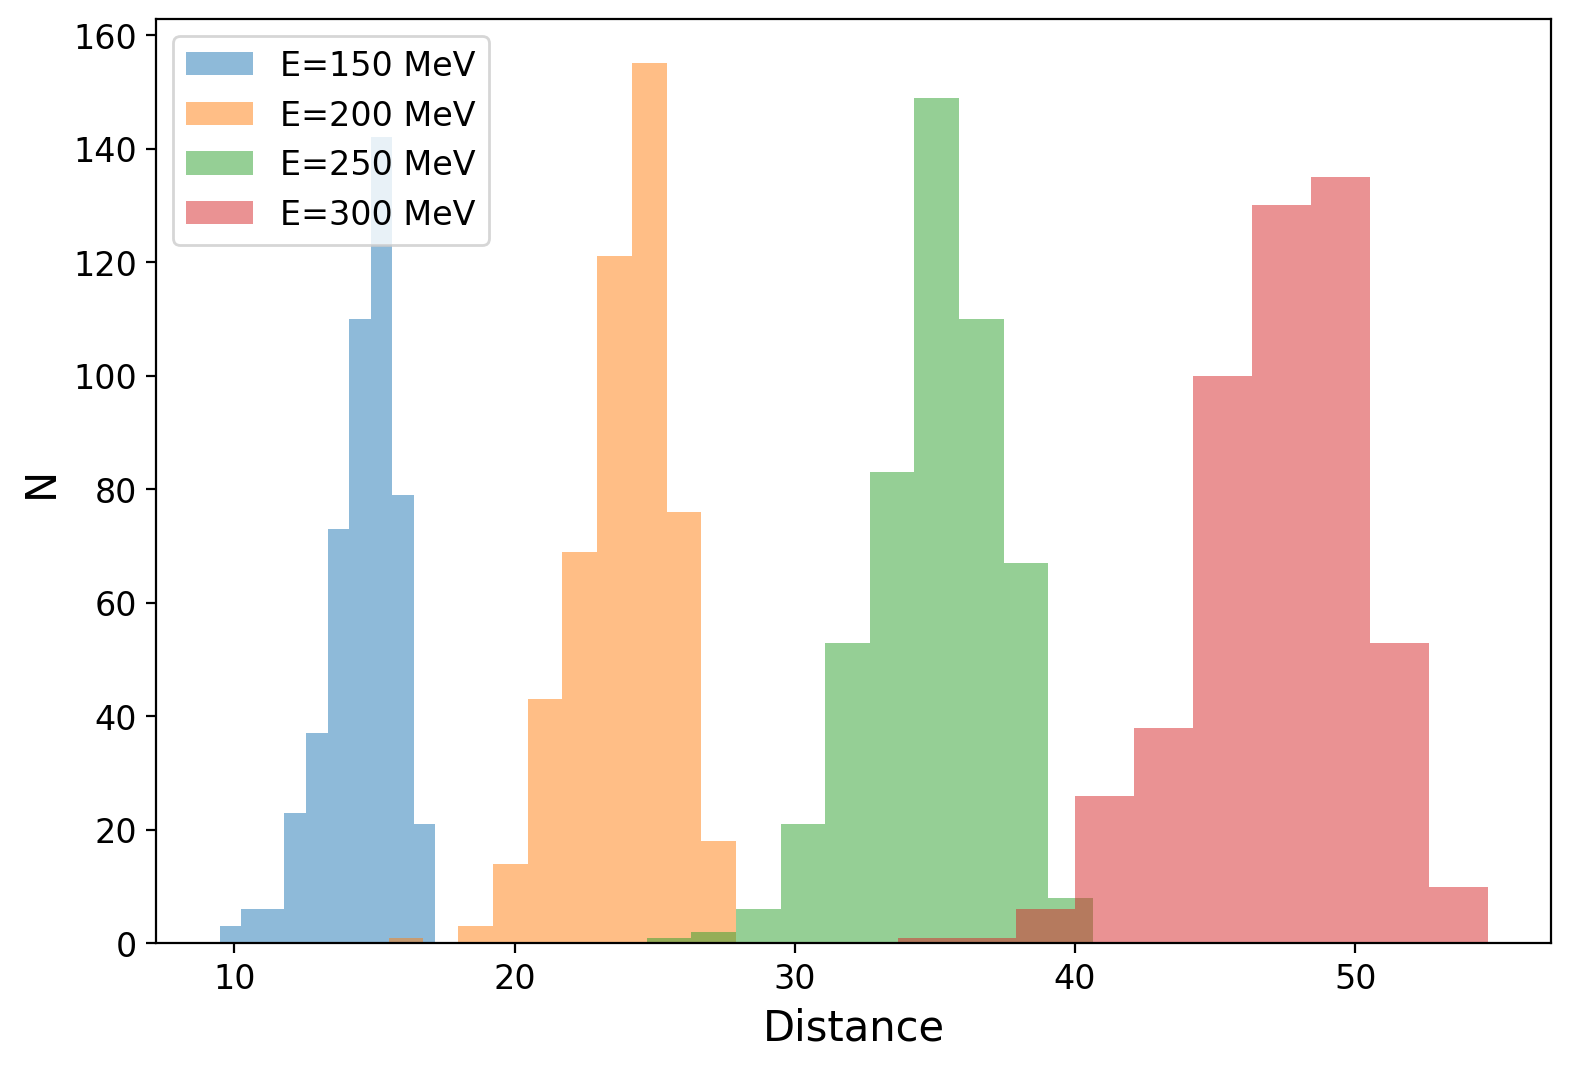

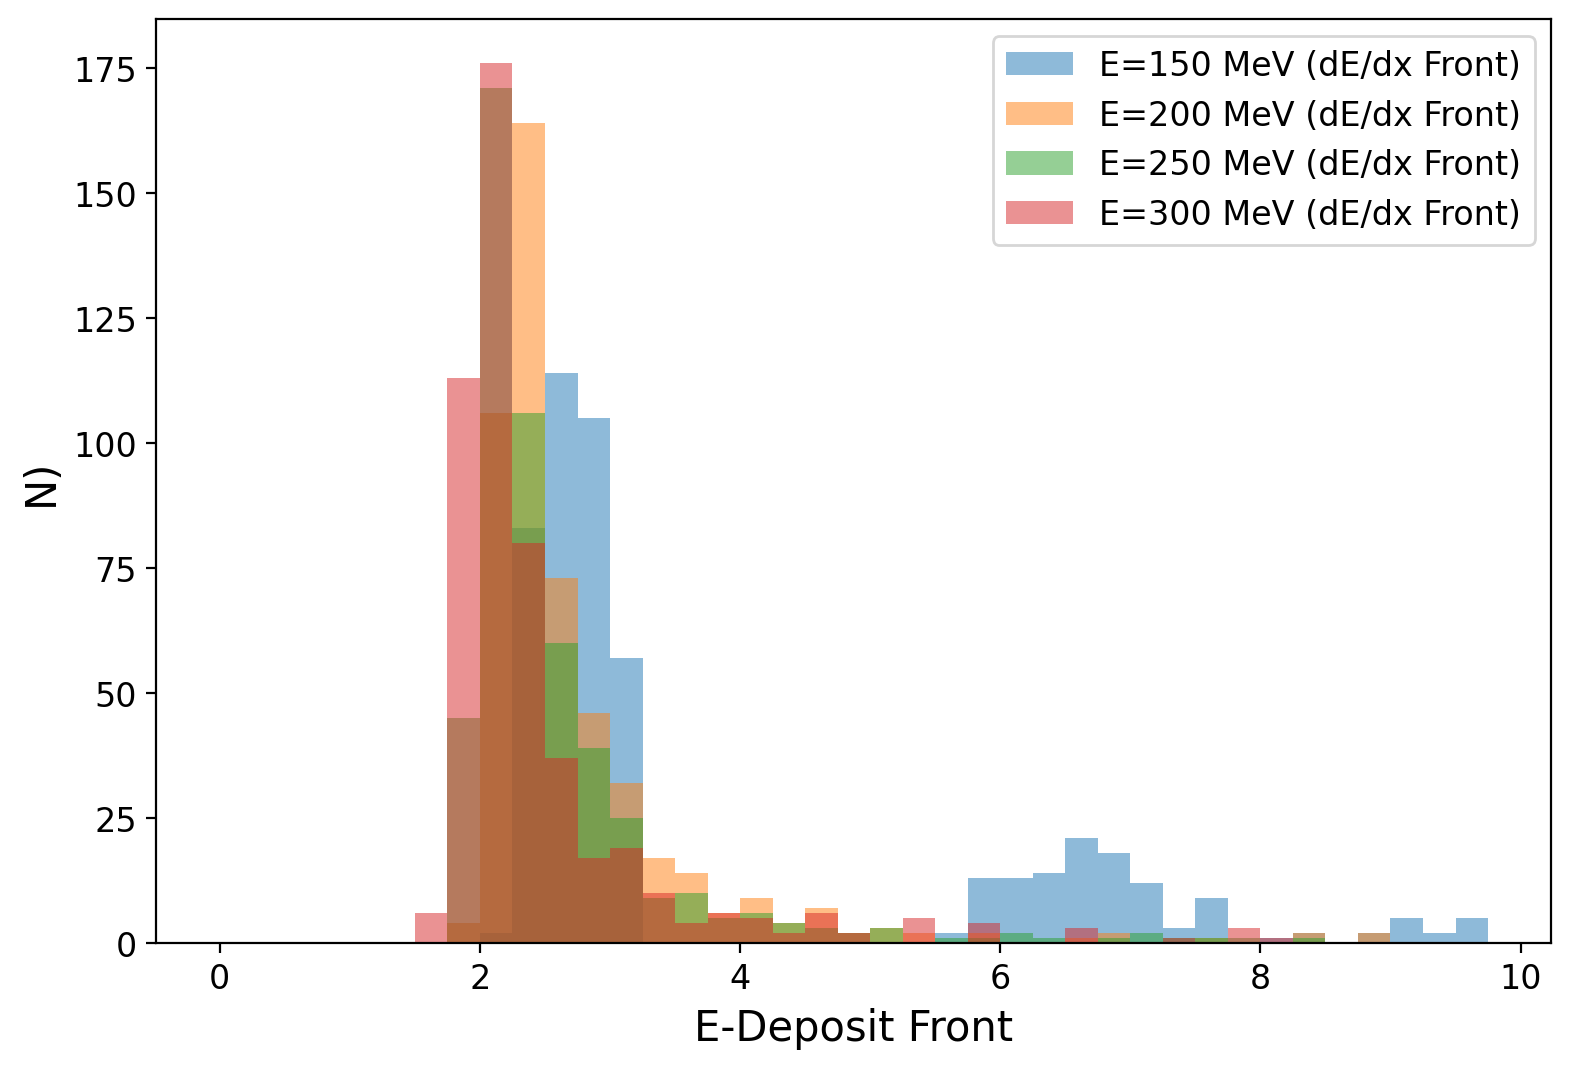

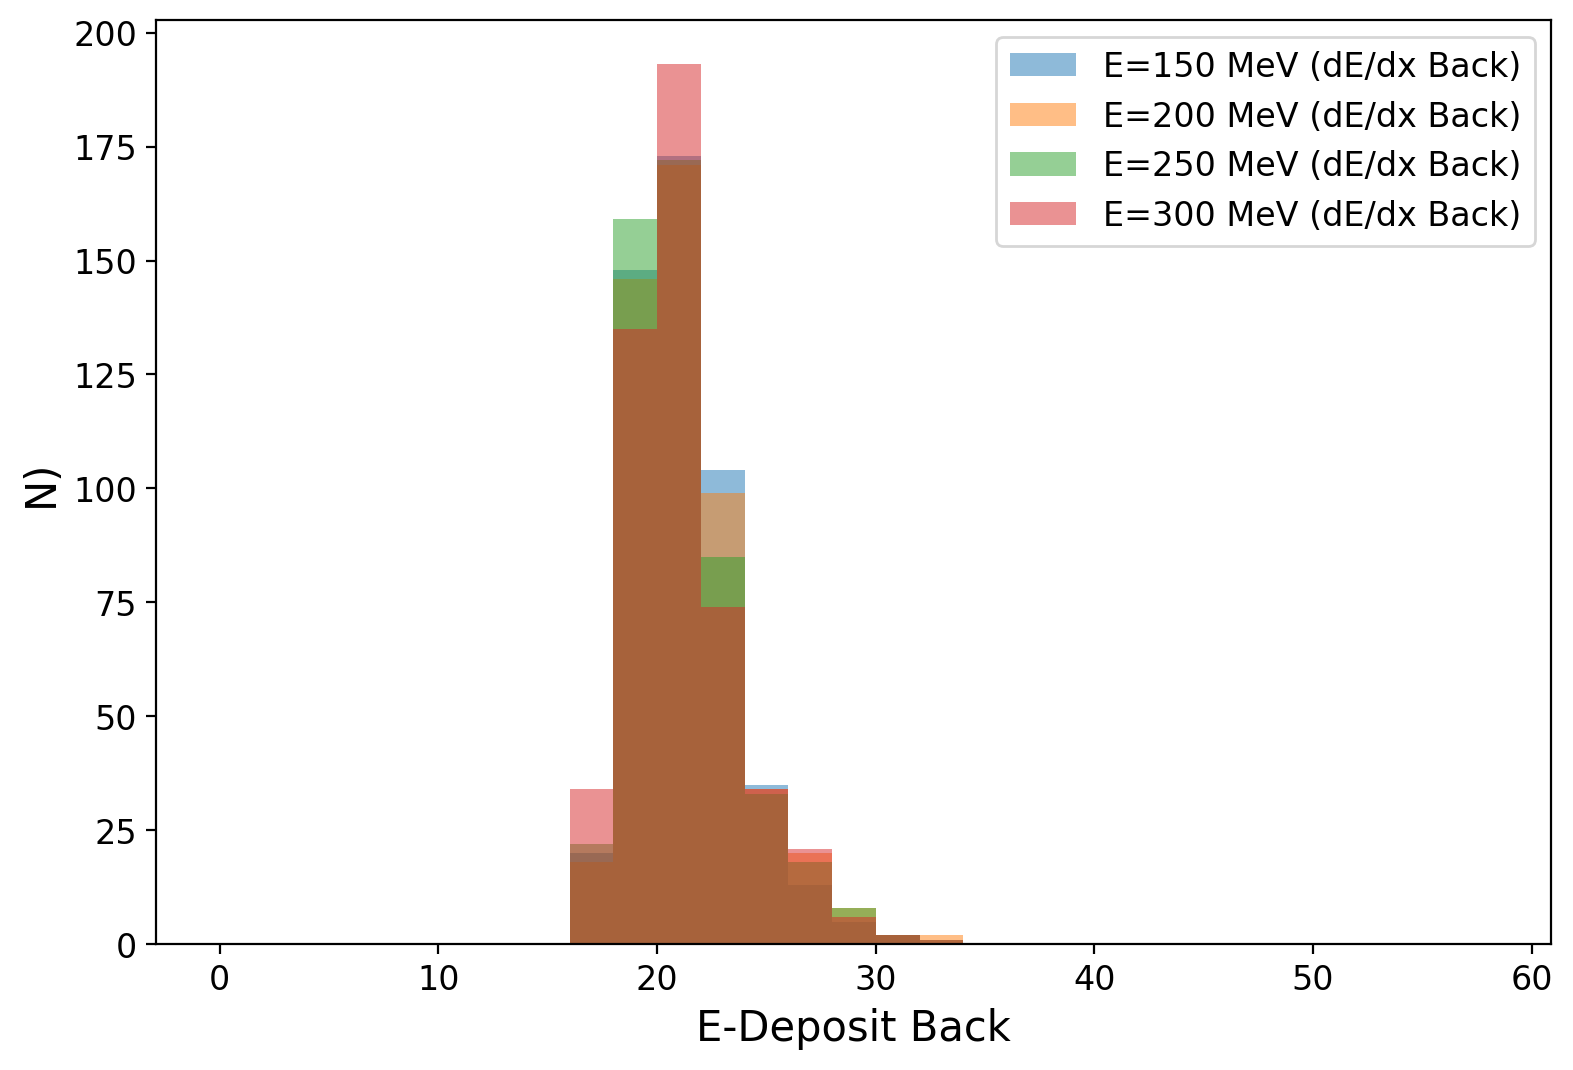

In [10]:
def simNParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx
        xstep  = np.vstack((xstep,dist))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    return xstep,pstep,estep

def simNSamples(ie=100,im=mproton,iN=500,idt=5e-11,iZ=8):
    xstep,pstep,estep=simNParallelSample(iN,ie=ie,im=im,idt=idt,iZ=iZ)
    plt.hist(xstep[:,-1],alpha=0.5)
    plt.show()
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0]-3])/3.
    xrange=np.arange(0,150,2.5)
    _,bins,_=plt.hist(efront,bins=xrange,alpha=0.5,label='dE/dx Front')
    plt.hist(eback, bins=bins,alpha=0.5,label='dE/dx Back')
    plt.legend()
    plt.show()

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

xstep150,pstep150,estep150=simNParallelSample(ie=150,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep200,pstep200,estep200=simNParallelSample(ie=200,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep250,pstep250,estep250=simNParallelSample(ie=250,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep300,pstep300,estep300=simNParallelSample(ie=300,im=mproton,iN=500,idt=1e-10,iZ=8)

plt.hist(xstep150[:,-1],alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],alpha=0.5,label='E=300 MeV')
plt.xlabel('Distance')
plt.ylabel('N')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,10,0.25)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.xlabel('E-Deposit Front')
plt.ylabel('N)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.xlabel('E-Deposit Back')
plt.ylabel('N)')
plt.legend()
plt.show()


From these distributions, we can start to make interesting conclusions. The higher energy beams tend to go longer, deposit less in the front, but the same as everybody else in the back. Notice also the 150 MeV feature. This Monte Carlo, we have developed is pretty sophisticated, but we can do even better if we take in mind that our beam is a full 3D distribution.  

<a name='exercises_21_4'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_4) | [Next Section](#section_21_5) |


<a name='section_17_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L17.5 Bragg Scattering for Proton Therapy in Multiple Dimensions </h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_4) | [Exercises](#exercises_21_5) | [Next Section](#section_21_6) |


Additionally, as the proton beam moves through the body. In addition to losing energy, it will scatter in different directions. The scatter occurs from the fact that the proton is charged, and the nuclei are charged and so we have coulomb scattering (aka Rutherford scattering) of the proton against the nuclei. This is an elastic process that will inevitably spread the beam further out. The scattering angle is often written as:

$$
\sigma_{\theta} = \frac{13.6 \rm MeV}{\beta cp} z \sqrt{\frac{x}{X_{0}}}\left(1+0.038\log\left(\frac{xz^{2}}{X_{0}\beta^{2}}\right)\right)
$$

The actual scatter has been studied to give a parameterization split in two terms

$$
\sigma_{\Delta y} = z_{1} \Delta x \frac{\sigma_{\theta}}{\sqrt{12}} + \frac{z_{2} \Delta x\sigma_{\theta}}{2}\\
\sigma_{\Delta \theta}     = z_{2} \sigma_{\theta}
$$
Where we have $z_{1}$ and $z_{2}$ are two normal random sampled distributions that are idependent of one another.

6.36964816414323


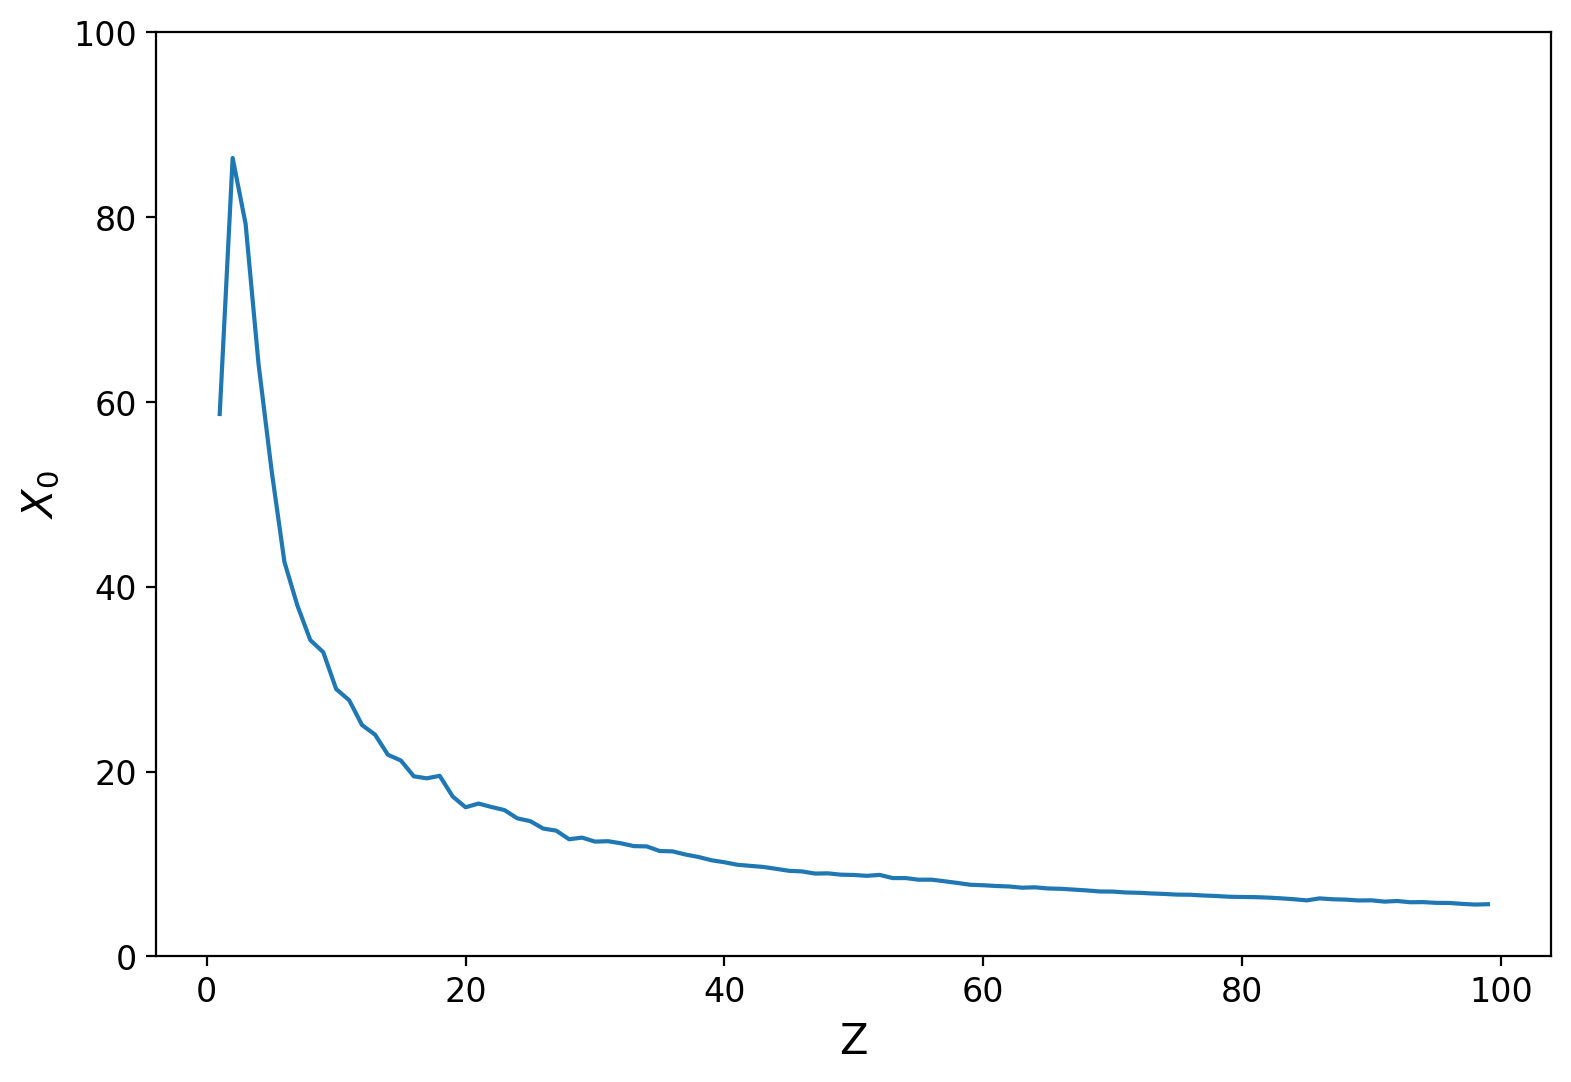

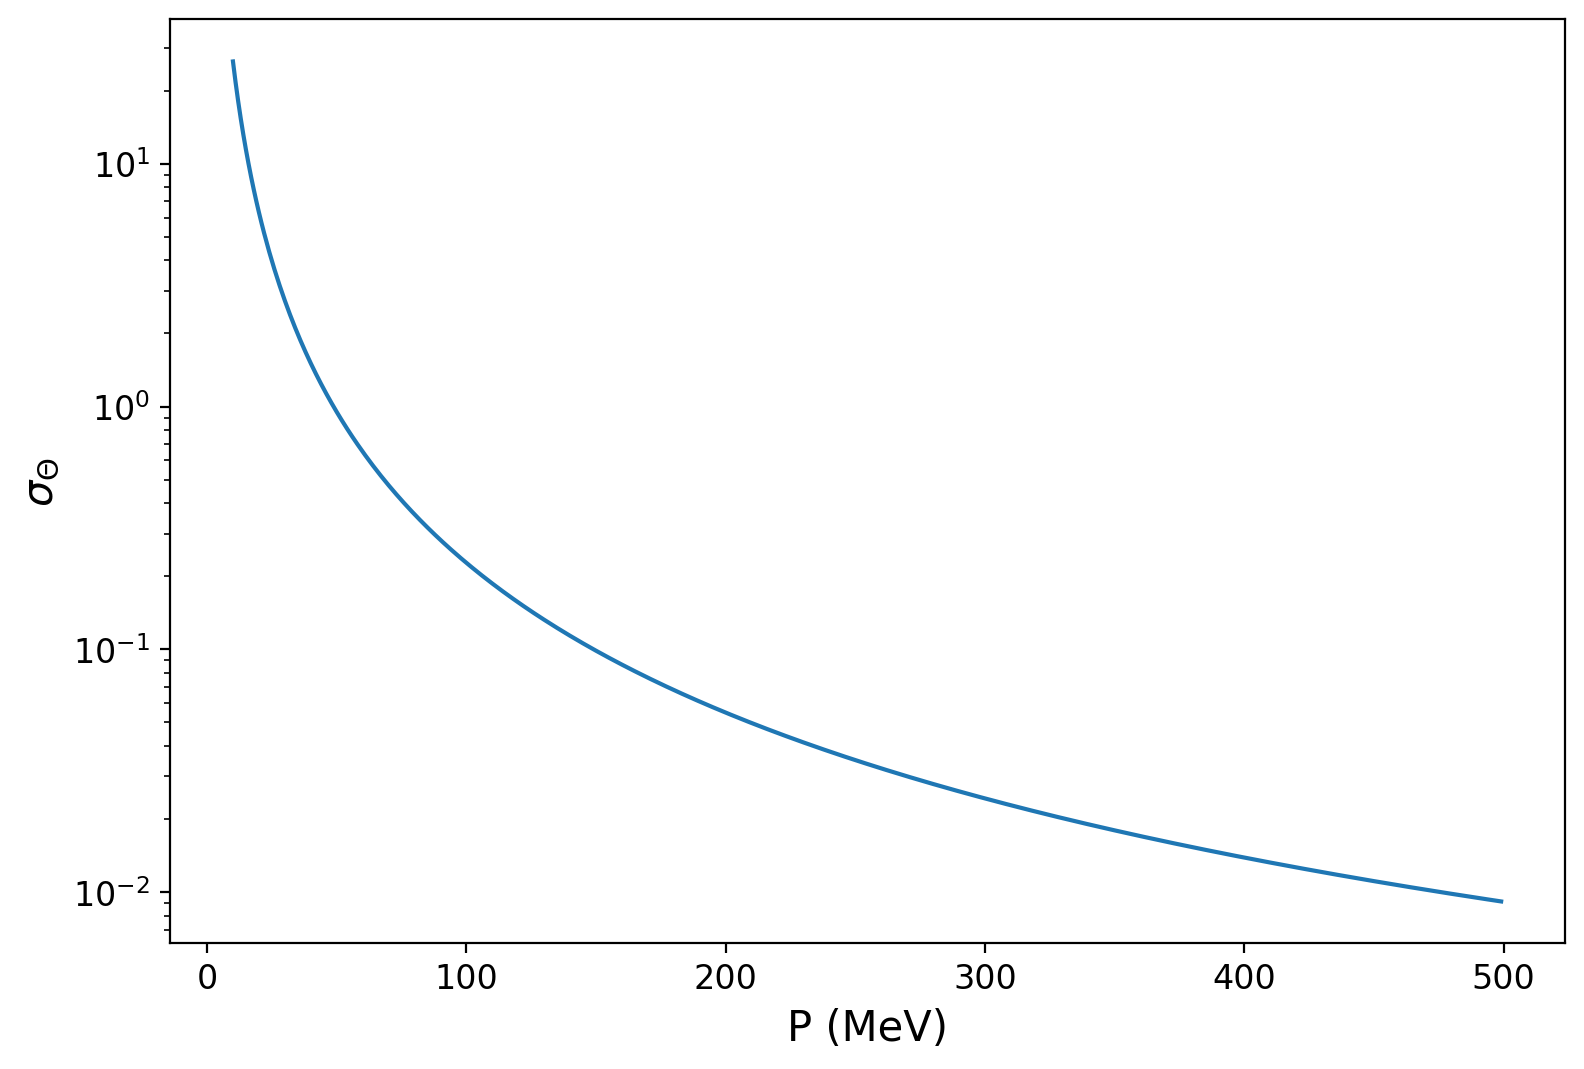

In [14]:
def X0(iZ):
    const=(716.408**-1)/A(iZ)
    a = iZ/137.
    Lrad =np.log(184.15*iZ**(-1./3.))
    Lradp=np.log(1194*iZ**(-2./3.))
    fZ = a**2*((1+a**2)**(-1)+0.20206-0.0369*a**2+0.0083*a**4-0.002*a**6)
    val=const*(iZ**2*(Lrad-fZ)+iZ*Lradp)
    return 1./val

def sigmaTheta(ip,im,iX0,idx=1.0,zpart=1):
    C=13.6
    X0=iX0
    dx=idx/iX0
    const=C/(beta(ip,im)*ip)*zpart*np.sqrt(dx)
    logterm=1+0.038*np.log(dx*zpart**2/beta(ip,im)**2)
    return const*logterm

def thetaScatter(ip,im,iX0,idx,zpart=1):
    z1=np.random.normal(0,1,ip.shape[0])
    z2=np.random.normal(0,1,ip.shape[0])
    stheta=sigmaTheta(ip,im,iX0,zpart)
    dy    =z1*idx*stheta/np.sqrt(12.) + z2*idx*stheta/2
    dtheta=z2*stheta
    return dtheta,dy

lZ=np.arange(1,100,1)
lX0=np.zeros(len(lZ))
for pZ in lZ:
    lX0[pZ-1] = X0(pZ)
print(X0(82))
plt.plot(lZ,lX0)
plt.xlabel("Z")
plt.ylabel("$X_{0}$")
plt.ylim(0,100)
plt.show()

lP=np.arange(10,500,1)
lST = sigmaTheta(lP,mproton,X0(8))
plt.plot(lP,lST)
plt.yscale('log')
plt.xlabel('P (MeV)')
plt.ylabel('$\sigma_{\Theta}$')
plt.show()

What we see above is that for very low energy we have very large angles when we get to the low momenta. Basically, the proton can go anywhere, this can blur out our beam, and if we are using this for cancer therapy can cause more damage.

One important thing to consider is that we need to make sure our angular scatter is physical, that means we should make sure that our angles are ok.

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


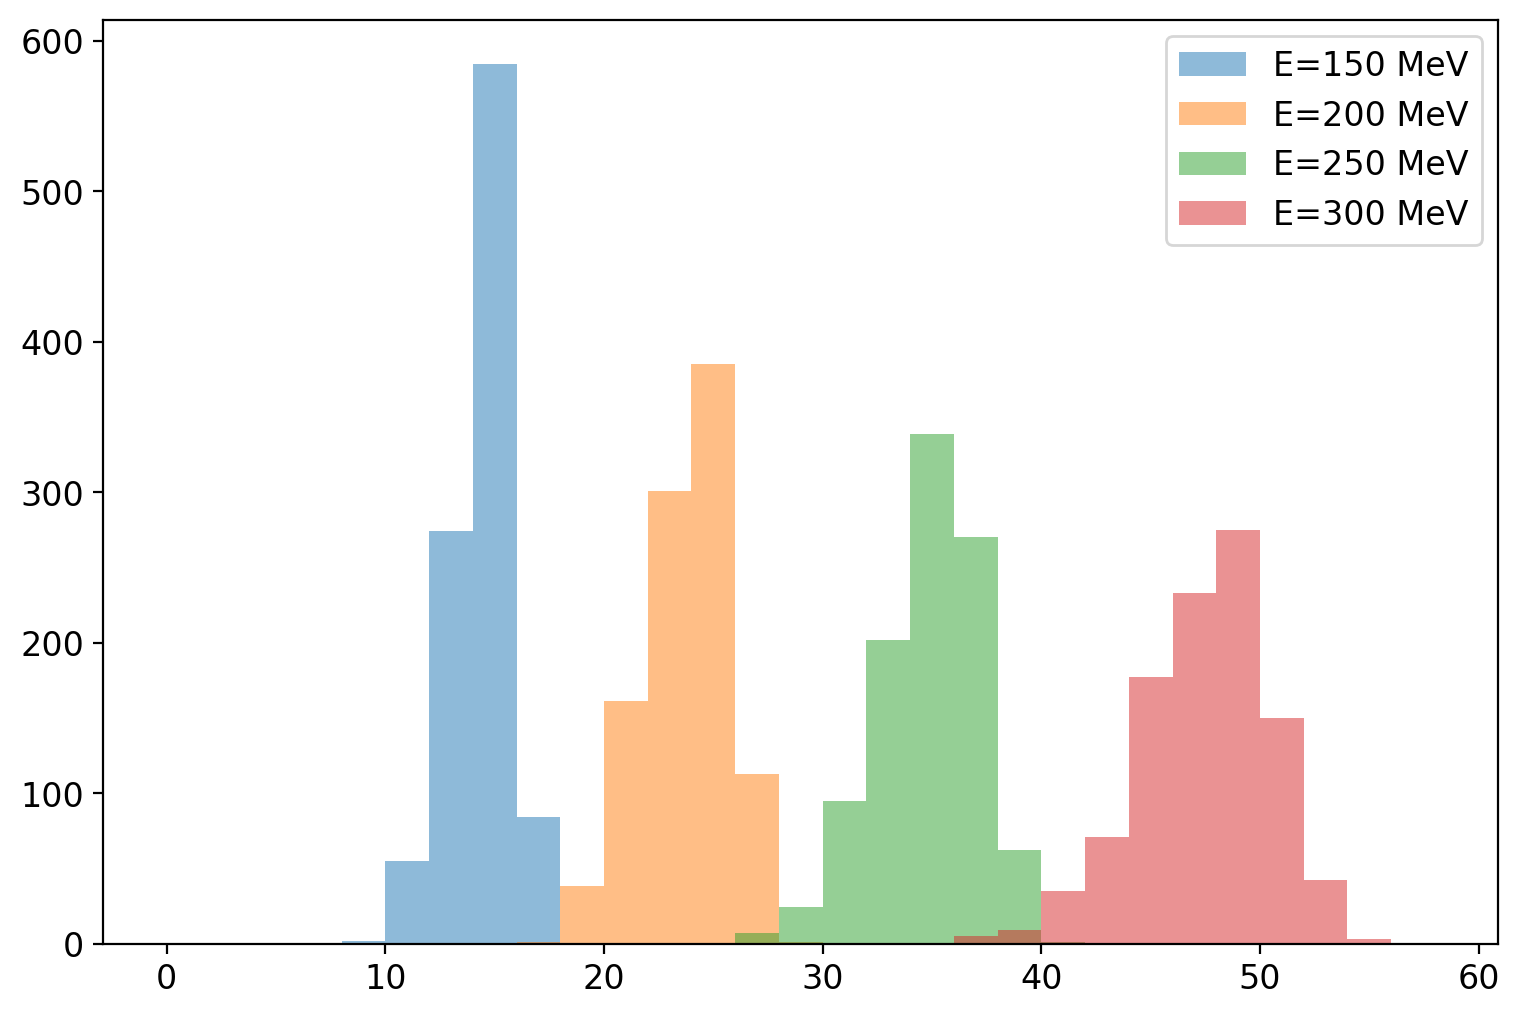

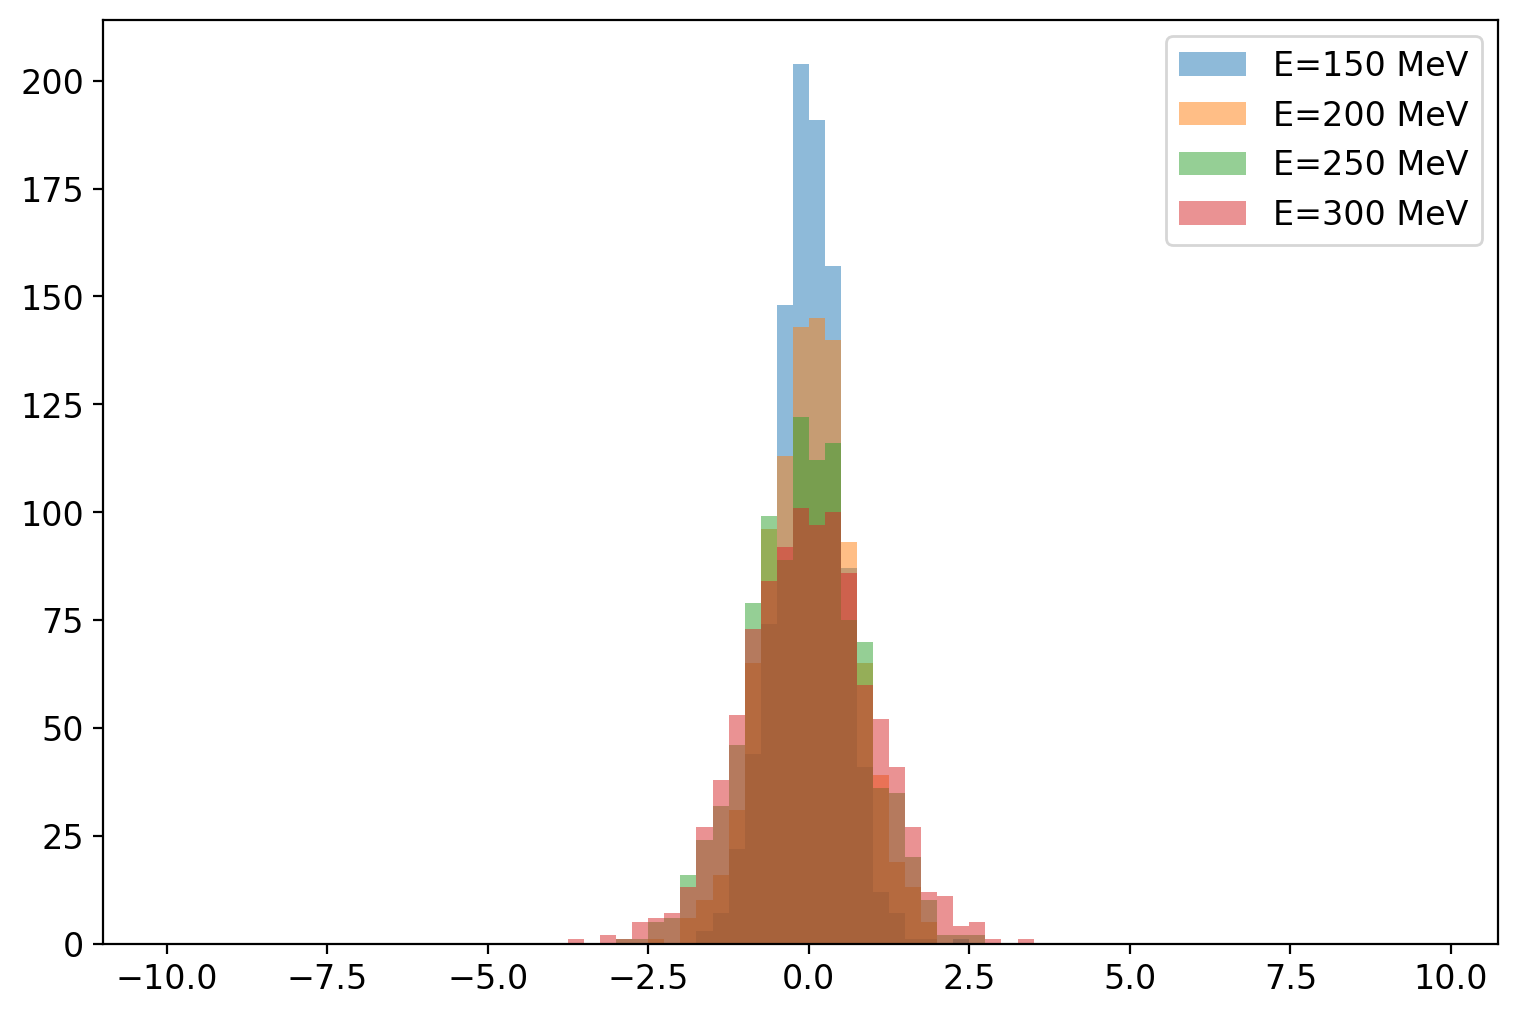

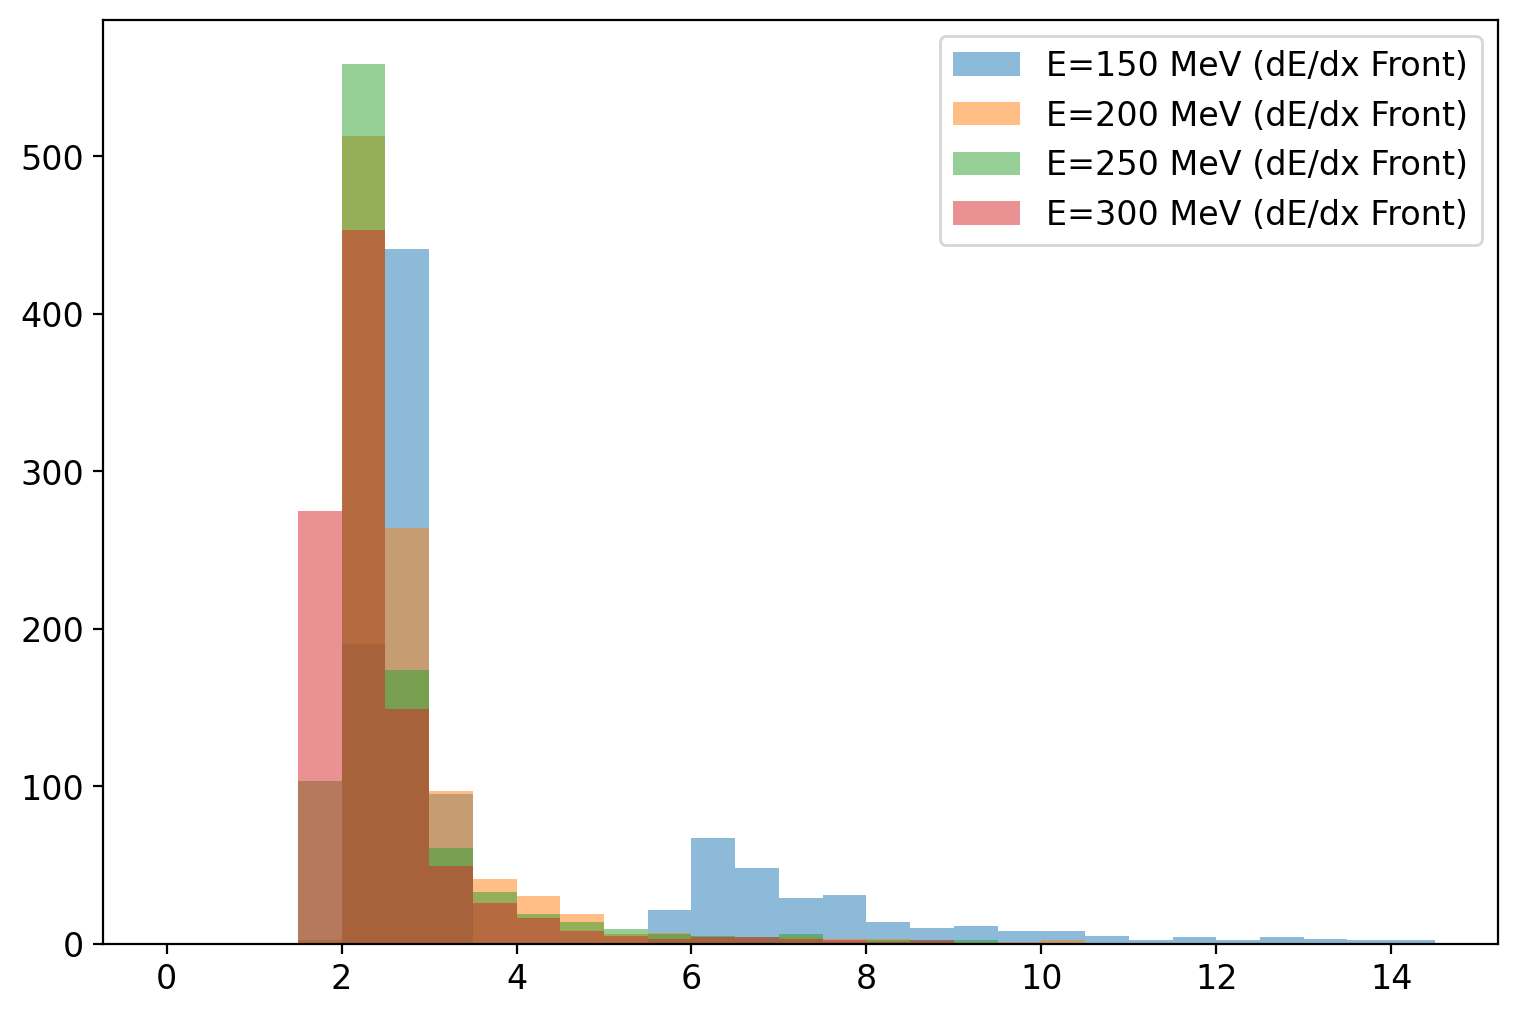

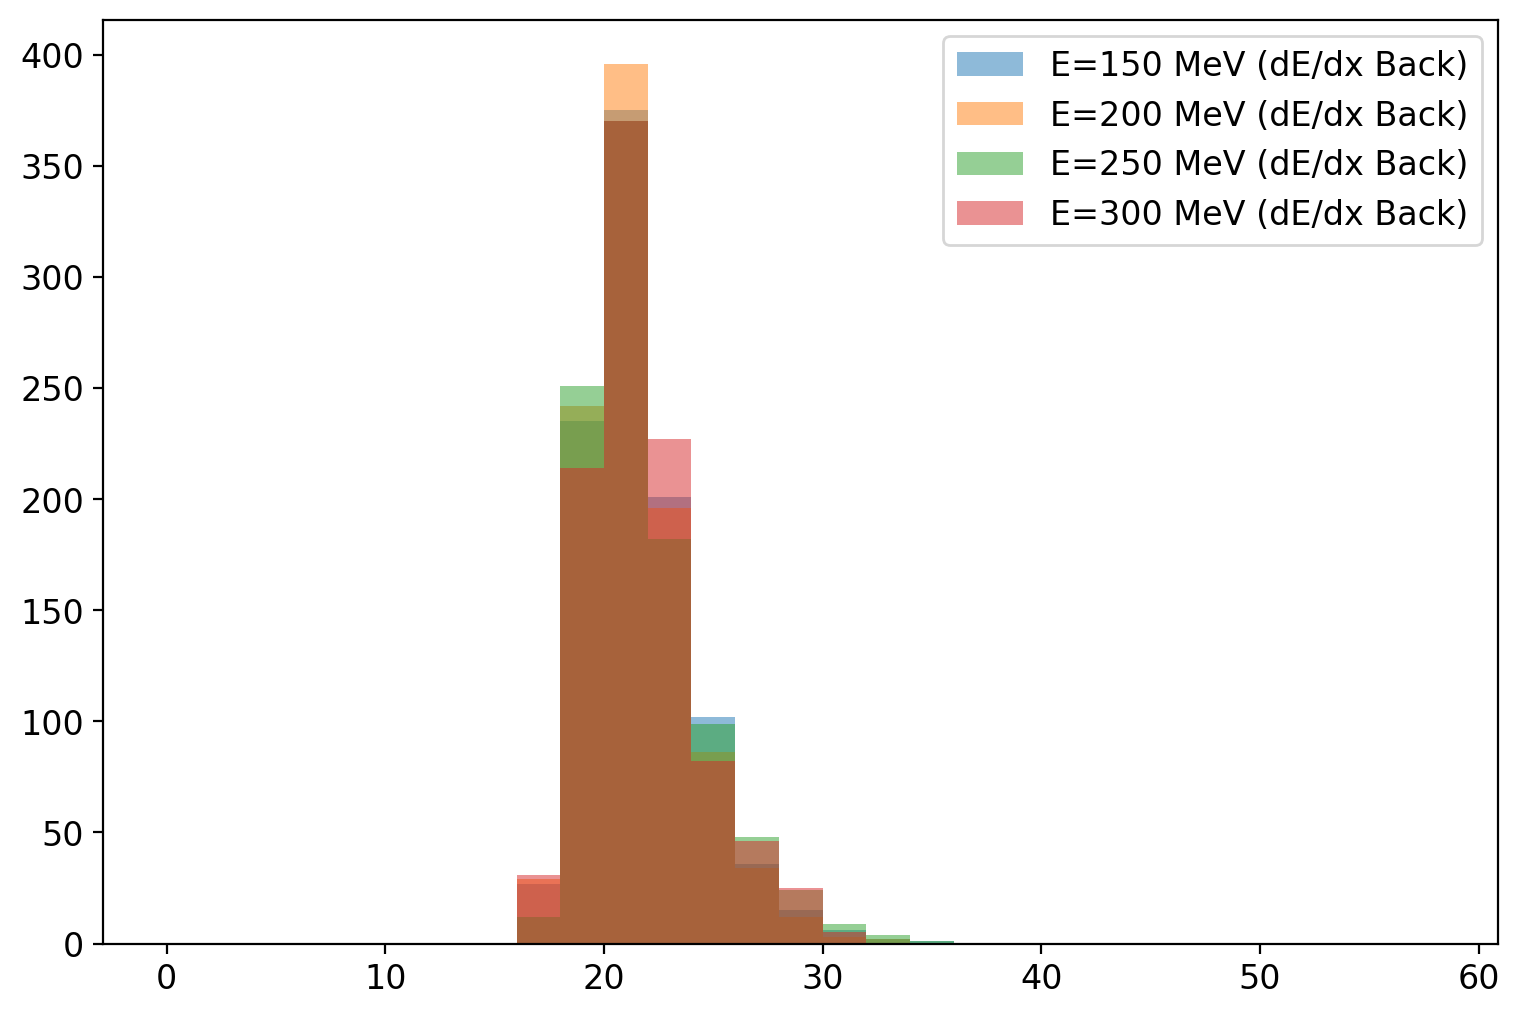

In [15]:
def simNYParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    ystep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    theta=0
    y=0
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    lX0 = X0(iZ)
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        dTheta,dy = thetaScatter(p,im,lX0,idx=dx,zpart=1)
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx*np.cos(theta)
        y      += dy + np.sin(theta)*dx
        theta  += dTheta
        xstep  = np.vstack((xstep,dist))
        ystep  = np.vstack((ystep,y))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    ystep = ystep.T
    return xstep,pstep,estep,ystep

xstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)

xrange=np.arange(0,60,2)
plt.hist(xstep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

xrange=np.arange(-10,10,0.25)
plt.hist(ystep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(ystep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(ystep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(ystep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,15,0.5)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.legend()
plt.show()


## Constructing a likelihood

Now this is where things become really interesting. The simulation we made above models a very specific process, and the more and more elements of realism. However, this gets more complicated. That being said, we see in the end the distributions we model are fairly reasonable.

What we can do after the fact is try to fit the result of the simulation and construct a parameteric model. A paramettric model for the behavior of what is going, this is often how we try to characterize things.


A: 14000 14000 14000


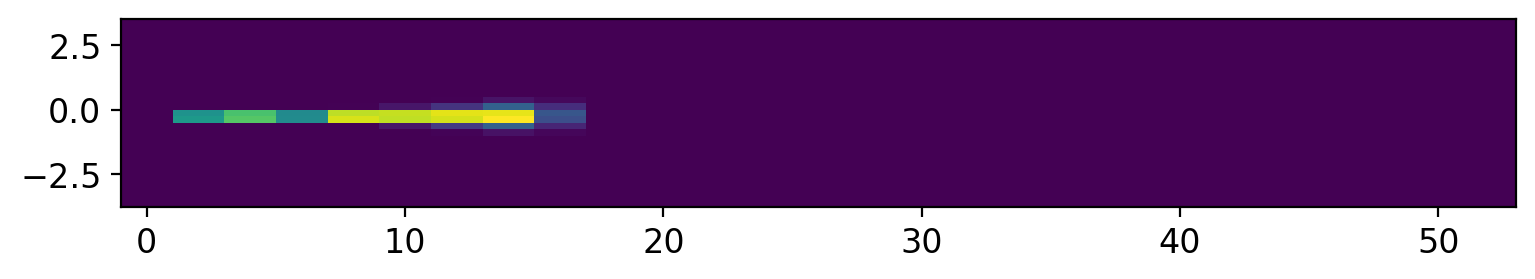

A: 21000 21000 21000


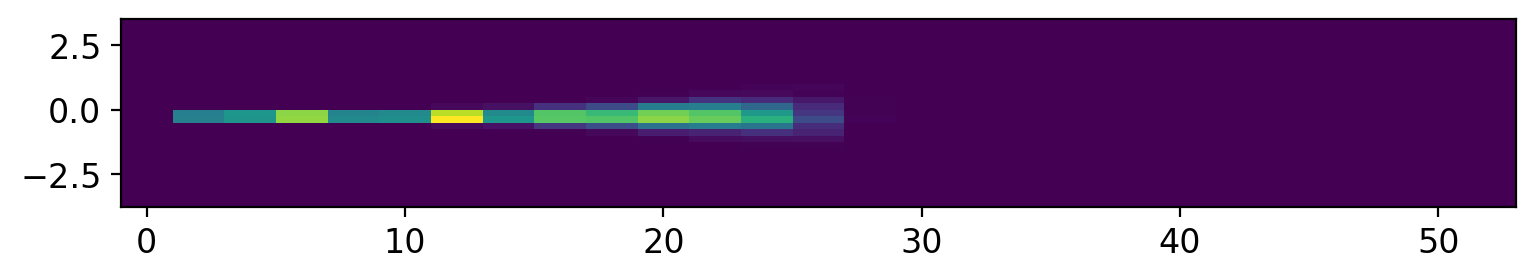

A: 28000 28000 28000


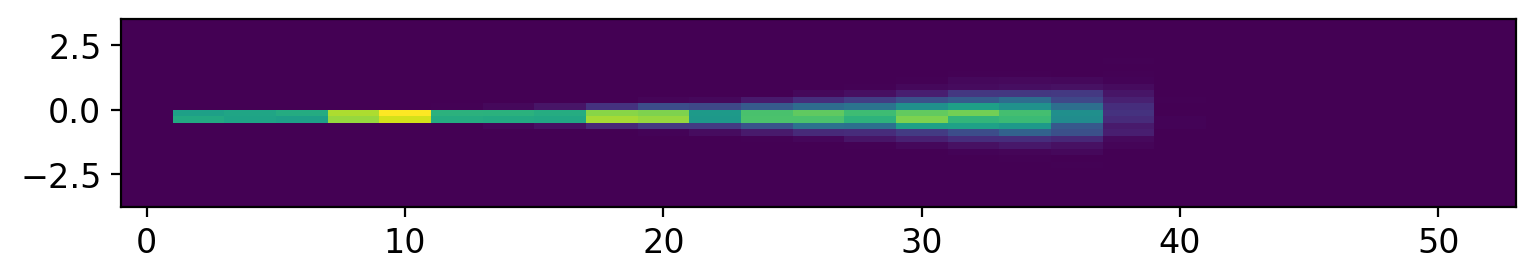

A: 35000 35000 35000


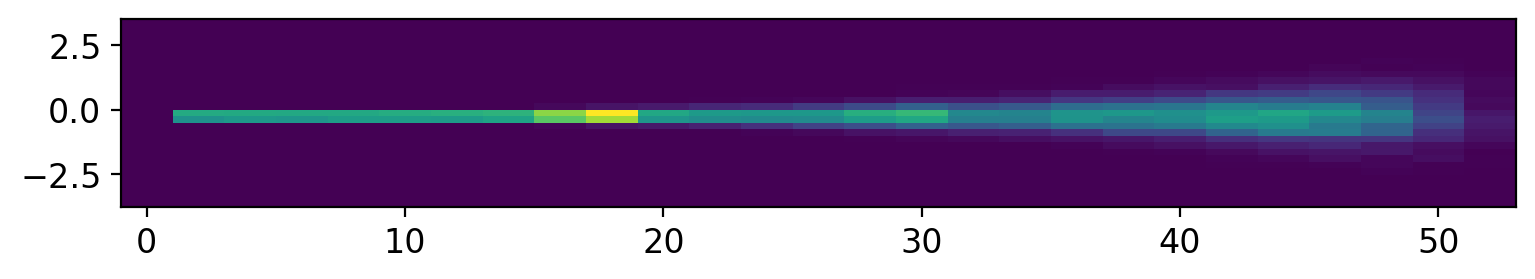

In [16]:
def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now lets make a regular image
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    print("A:",len(ixstep.flatten()),len(iystep.flatten()),len(iestep.flatten()))
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)

<a name='section_20_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.1 Variational Autoencoders for Monte Carlo based Event Generation</h2>  


| [Top](#section_20_0) | [Previous Section](#section_20_0) | [Exercises](#exercises_20_1) | [Next Section](#section_20_2) |


Before we go down the path of using variational autencoders for simulation. Let's take a little bit of time to run one of the famous illustrative examples of variational autoencoders. I have to say, this got me hooked on their usefulness, and made me understand the advantage of using them.

For this we are going to use the MNIST character dataset. The MNIST character dataset was one of the first ML datasets. This dataset has become the basis for testing and validating deep learning algorithms. It is so deeply embedded into pytorch that we can just load it from pytorch.

In [17]:
# Set random seed for reproducibility
torch.manual_seed(0)

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Now, we need to define the neural network architecture. While this is not the focus of this lecture, lets take a few minutes to look at how we encode this.

For this architecture we are going to take the MNIST input dataset, and encoder it into a large vector. The past 10 years of research on deep learning has shown that Convolutional Neural Networks (CNNs) are one of the most robust wasy to encode images. Our enconder will thus be 3 convolutional NN layers stringed together. Each one produces a smaller image from the previous image. Finally, once the image is small enough (3x3, but with 32 features), we take the image and linearize it to a single vector, which we then feed into normal Dense(Linear) layers.

Finally because this is a variational autencoder, we need to output a mean and a sigma for each dimension in the latent space, once we have the mean dthe sigma, we can randomly sample a normal distribution with these features.

In [25]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

Now that we have encoded everything in a space, we can go ahead and decode it so that we can build a network that tries to generate the original image from the lower dimensional intermediate space. This decoder is the opposite of the encoder and starts from the vector in the latent space and then expands out the image using the invers of CNNs, ConvTranspose2ds, this generates an image from a vector. Below, is our decder, which finally yields an image at the end.

In [28]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Finally, we can go ahead and combine everything together to make our variational autoencoder. One last element that we need to understand for the variational autoencoder is how we can train this NN. The way we do this is we train for the inputs to be equal to the outputs. In otherwords, we try to minimize our loss given inputs $x_{i}$ and outputs $y_{i}$ each of size $N$, we can write

$$
\mathcal{L} = \sum^{N}_{i} (x_{i}-y_{i})^{2}
$$

Now from studies of the variational autoencoder with the above loss, we have come to add another nerm. This term, we refer to as the Kullback-Liebler(KL) divergence term for the latent space to approximate a Gaussian.

What does this mean?

KL divergence is a measure of how similar to probability distributions are from each other. It is defined as

$$
\mathcal{D}_{\rm KL}\left(P||Q\right)  = \int_{-\infty}^{\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx
$$

For two probability distributions $p(x)$ and $q(x)$. It is effectively the difference in log probabilities of two distrbiutions or some notion of the entropy. In the case of the VAE, we apply a KL diverence for the probability distribution of the latent space to approximate a Gaussian dsitriboution with width 1. This we can write as

$$
\log\left(\mathcal{N}(\mu,\sigma)\right) = -\frac{1}{2}\log\left(2\pi\sigma^{2}\right)-\left(\frac{x-\mu}{2\sigma}\right)^{2} \\
\log\left(\mathcal{N}(\mu,\sigma)\right) - \log\left(\mathcal{N}(\mu=0,\sigma=1)\right) =
-\frac{1}{2}\log\left(2\pi\sigma^{2}\right)-\left(\frac{x-\mu}{2\sigma}\right)^{2}+\frac{1}{2}\log\left(2\pi\right)+\frac{x^2}{2}\\
\int_{-\infty}^{\infty} p(x) \log\left(\frac{p(x)}{q(x)}\right) dx =
-\frac{1}{2}\log\left(\sigma^{2}\right) - \frac{1}{4}  + \frac{\sigma^2}{2} + \frac{\mu^2}{2}
\\
\mathcal{D}_{\rm KL}\left(\mathcal{N}(\mu,\sigma)||\mathcal{N}(\mu=0,\sigma=1)\right) =
-\frac{1}{2}\log\left(\sigma^{2}\right) - \frac{1}{4}  + \frac{\sigma^2}{2} + \frac{\mu^2}{2}
$$

In [29]:
class MNISTVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(MNISTVariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.kl      = 0

    def forward(self, x):
        z = self.encoder(x)
        kl = self.encoder.kl
        return self.decoder(z)

Now let's train this and embed it into 2 latent dimensions! With that we can see what is going on.

In [30]:
### Set the random seed for reproducible results
torch.manual_seed(0)
d = 2
mnvae = MNISTVariationalAutoencoder(latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(mnvae.parameters(), lr=lr, weight_decay=1e-5)

### Training function
def train_epoch(mnvae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    mnvae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x_hat = mnvae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + mnvae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

### Testing function
def test_epoch(mnvae, dataloader):
    # Set evaluation mode for encoder and decoder
    mnvae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Encode data
            encoded_data = mnvae.encoder(x)
            # Decode data
            x_hat = mnvae(x)
            loss = ((x - x_hat)**2).sum() + mnvae.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/20 	 train loss 154.809 	 val loss 83.272


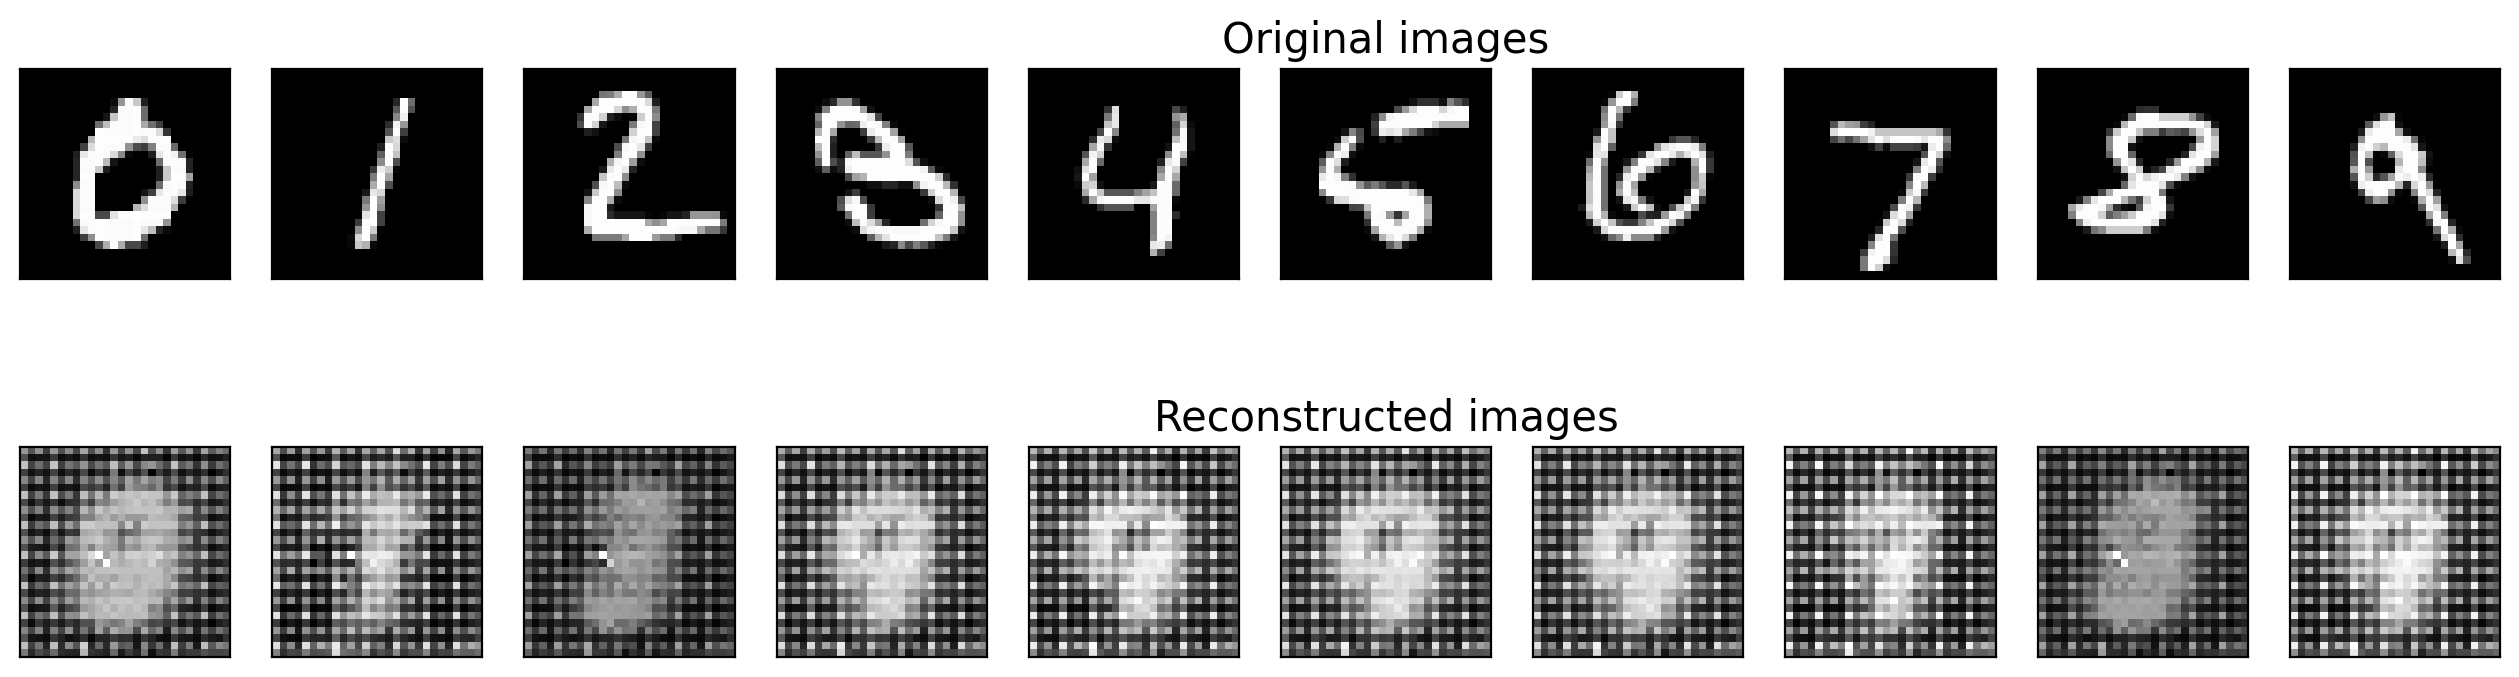


 EPOCH 2/20 	 train loss 63.040 	 val loss 48.741


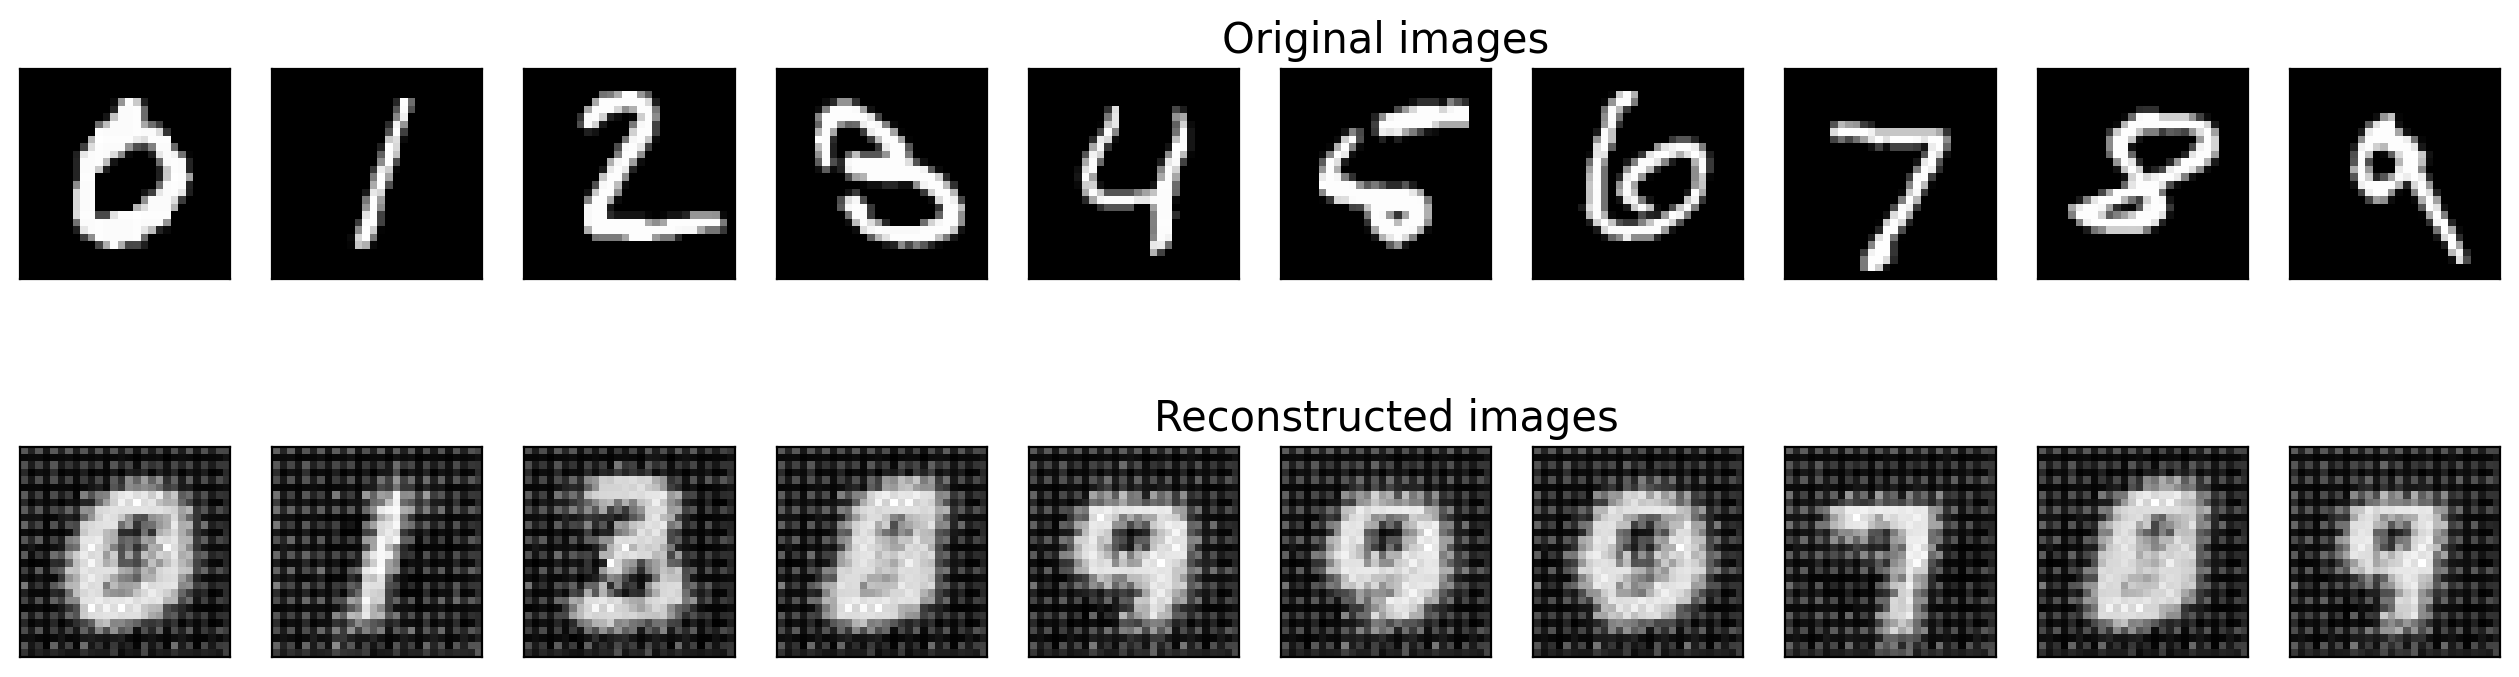


 EPOCH 3/20 	 train loss 44.725 	 val loss 41.013


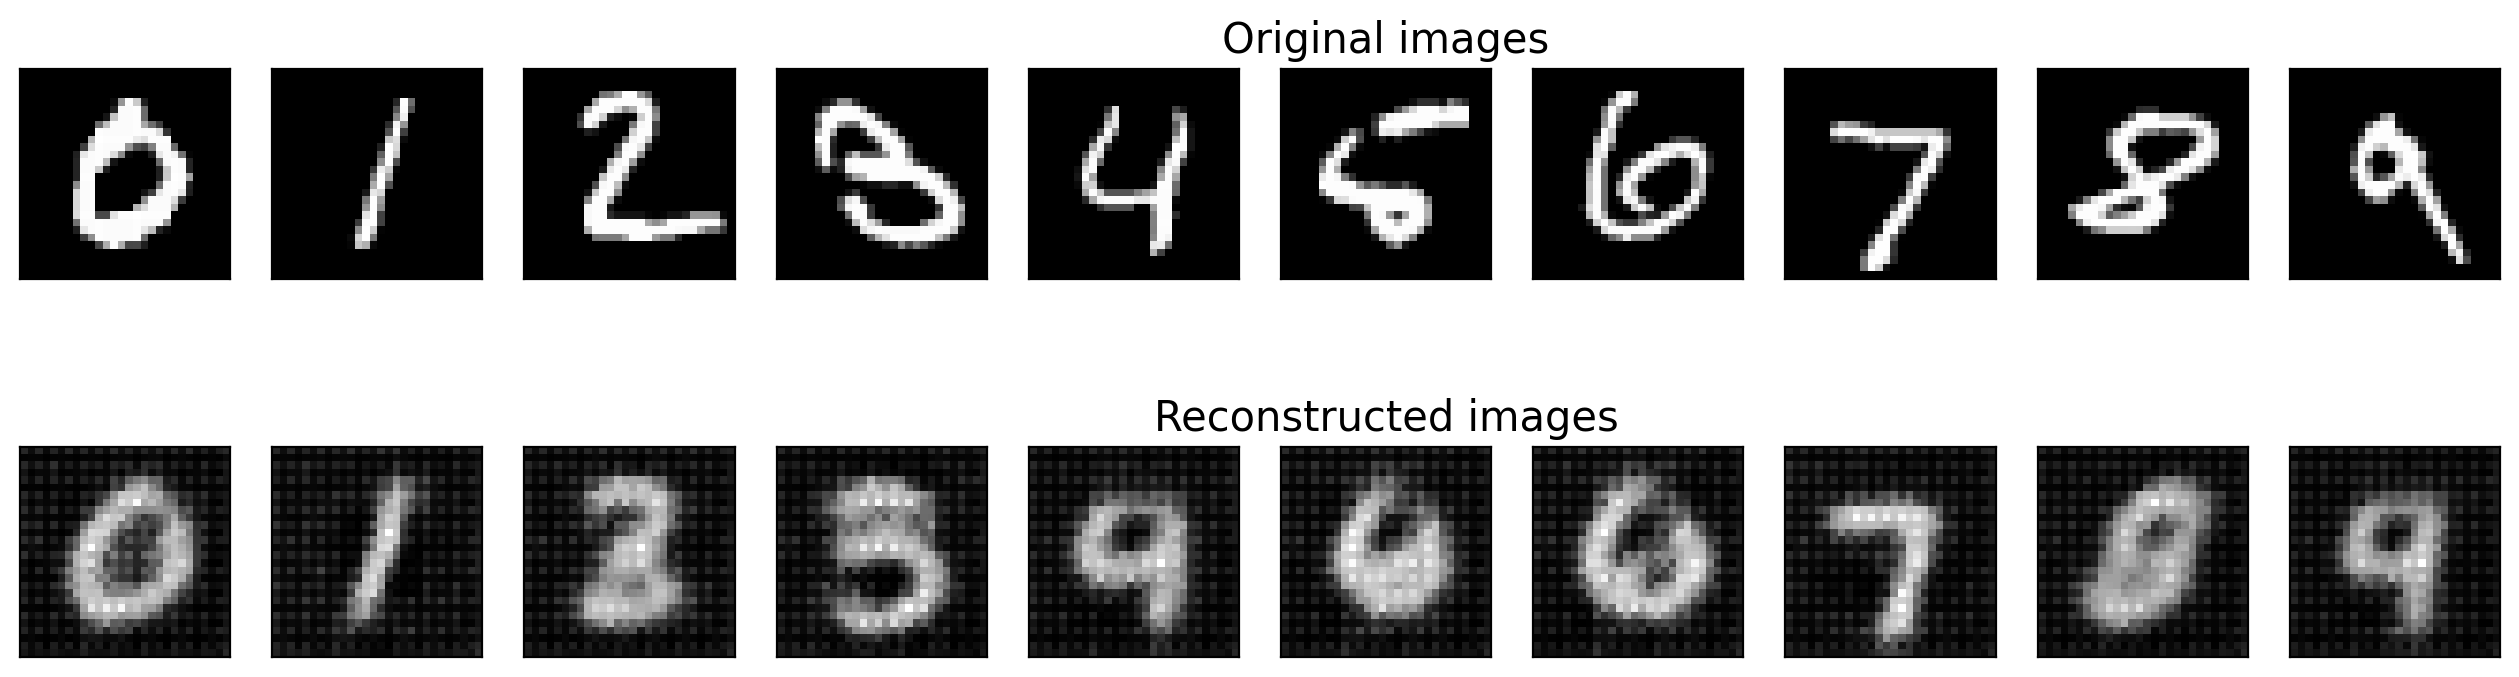


 EPOCH 4/20 	 train loss 38.993 	 val loss 37.402


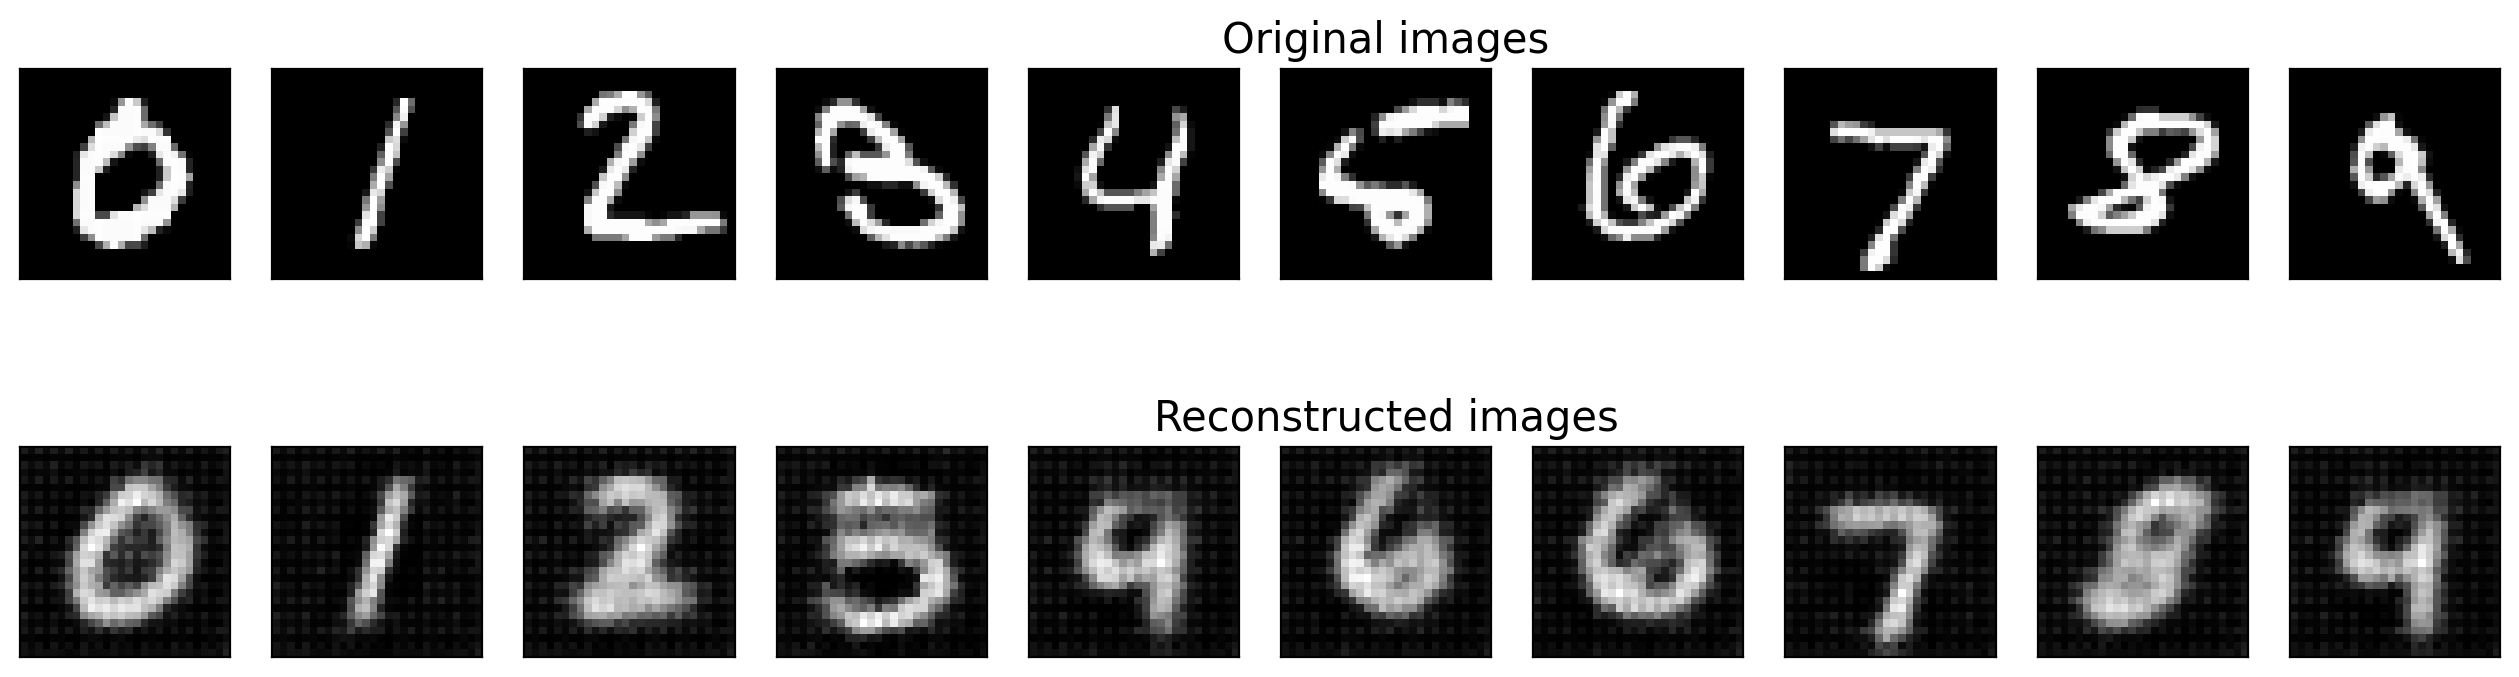


 EPOCH 5/20 	 train loss 36.279 	 val loss 35.453


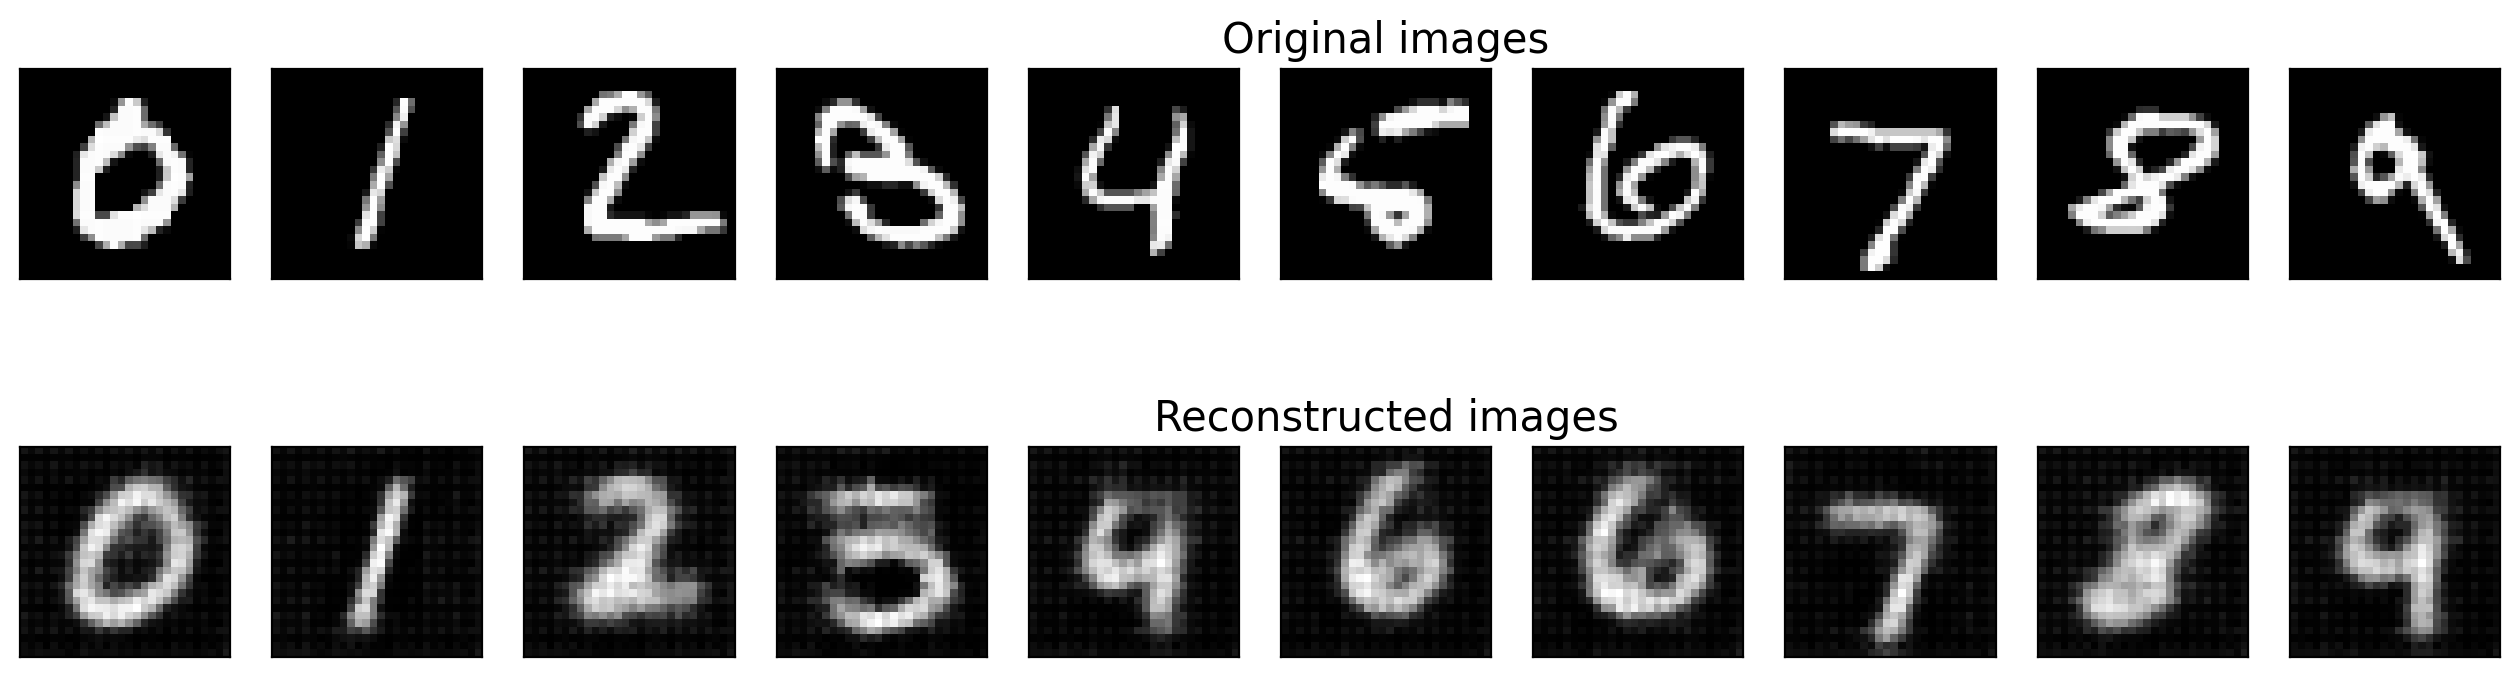


 EPOCH 6/20 	 train loss 34.675 	 val loss 34.458


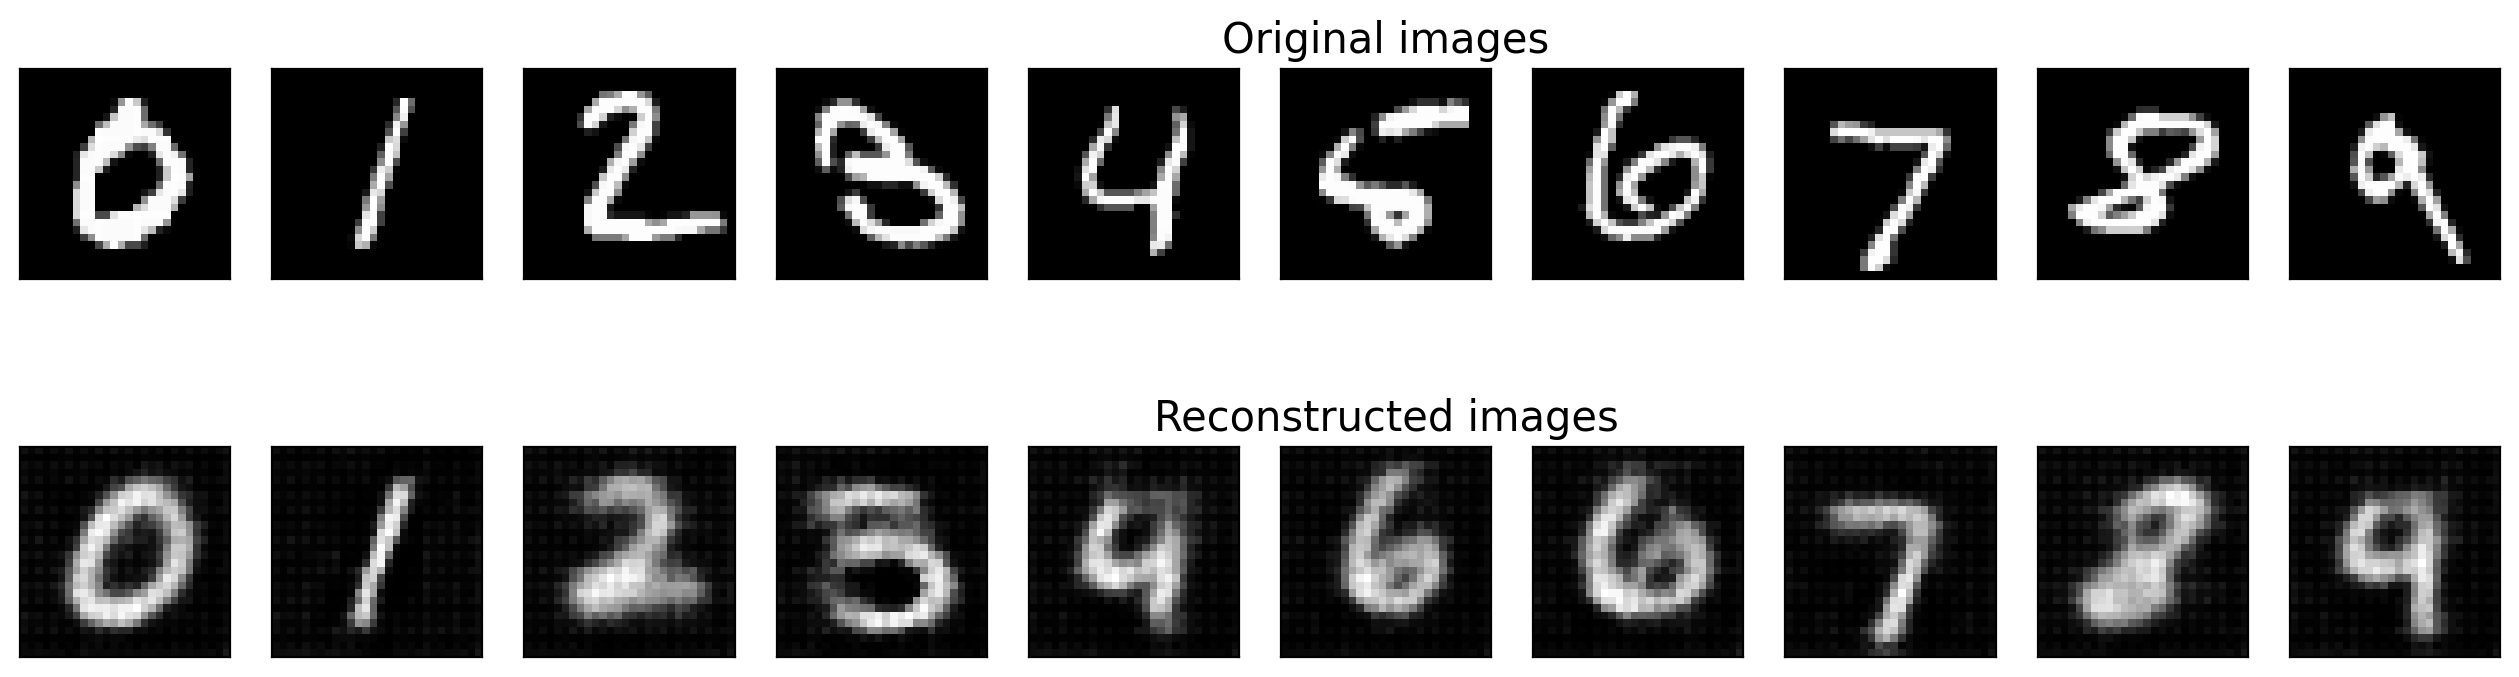


 EPOCH 7/20 	 train loss 33.659 	 val loss 33.210


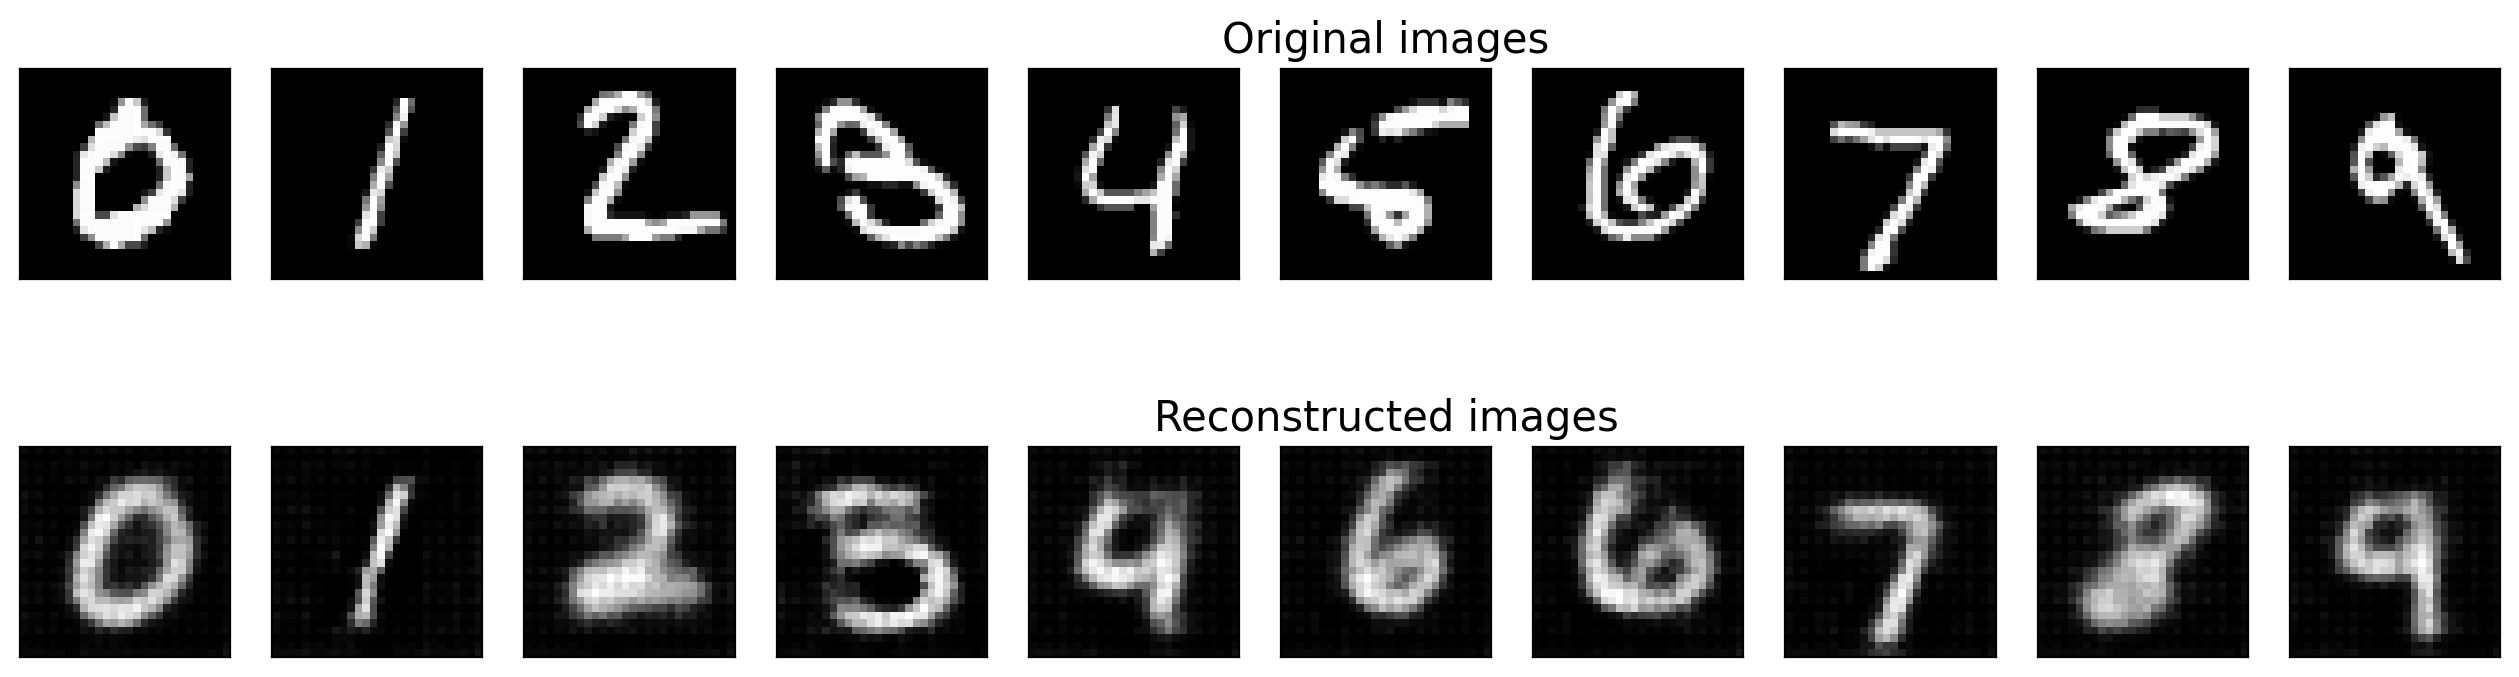


 EPOCH 8/20 	 train loss 32.885 	 val loss 32.583


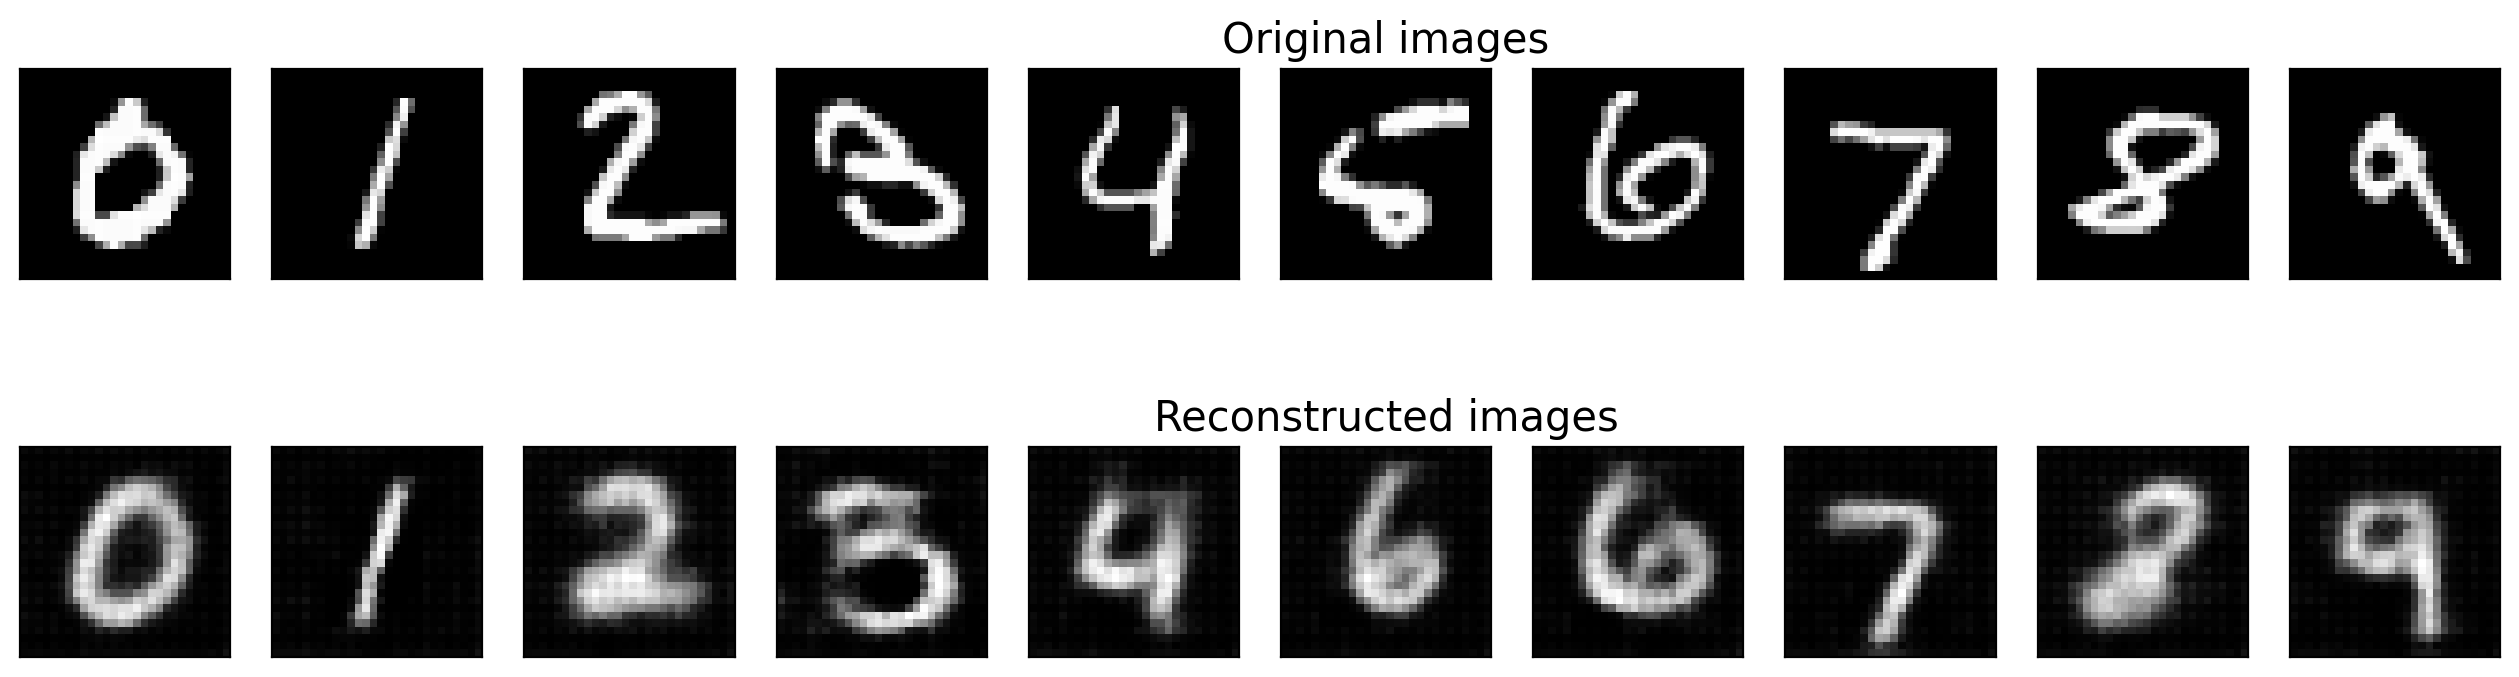


 EPOCH 9/20 	 train loss 32.221 	 val loss 32.251


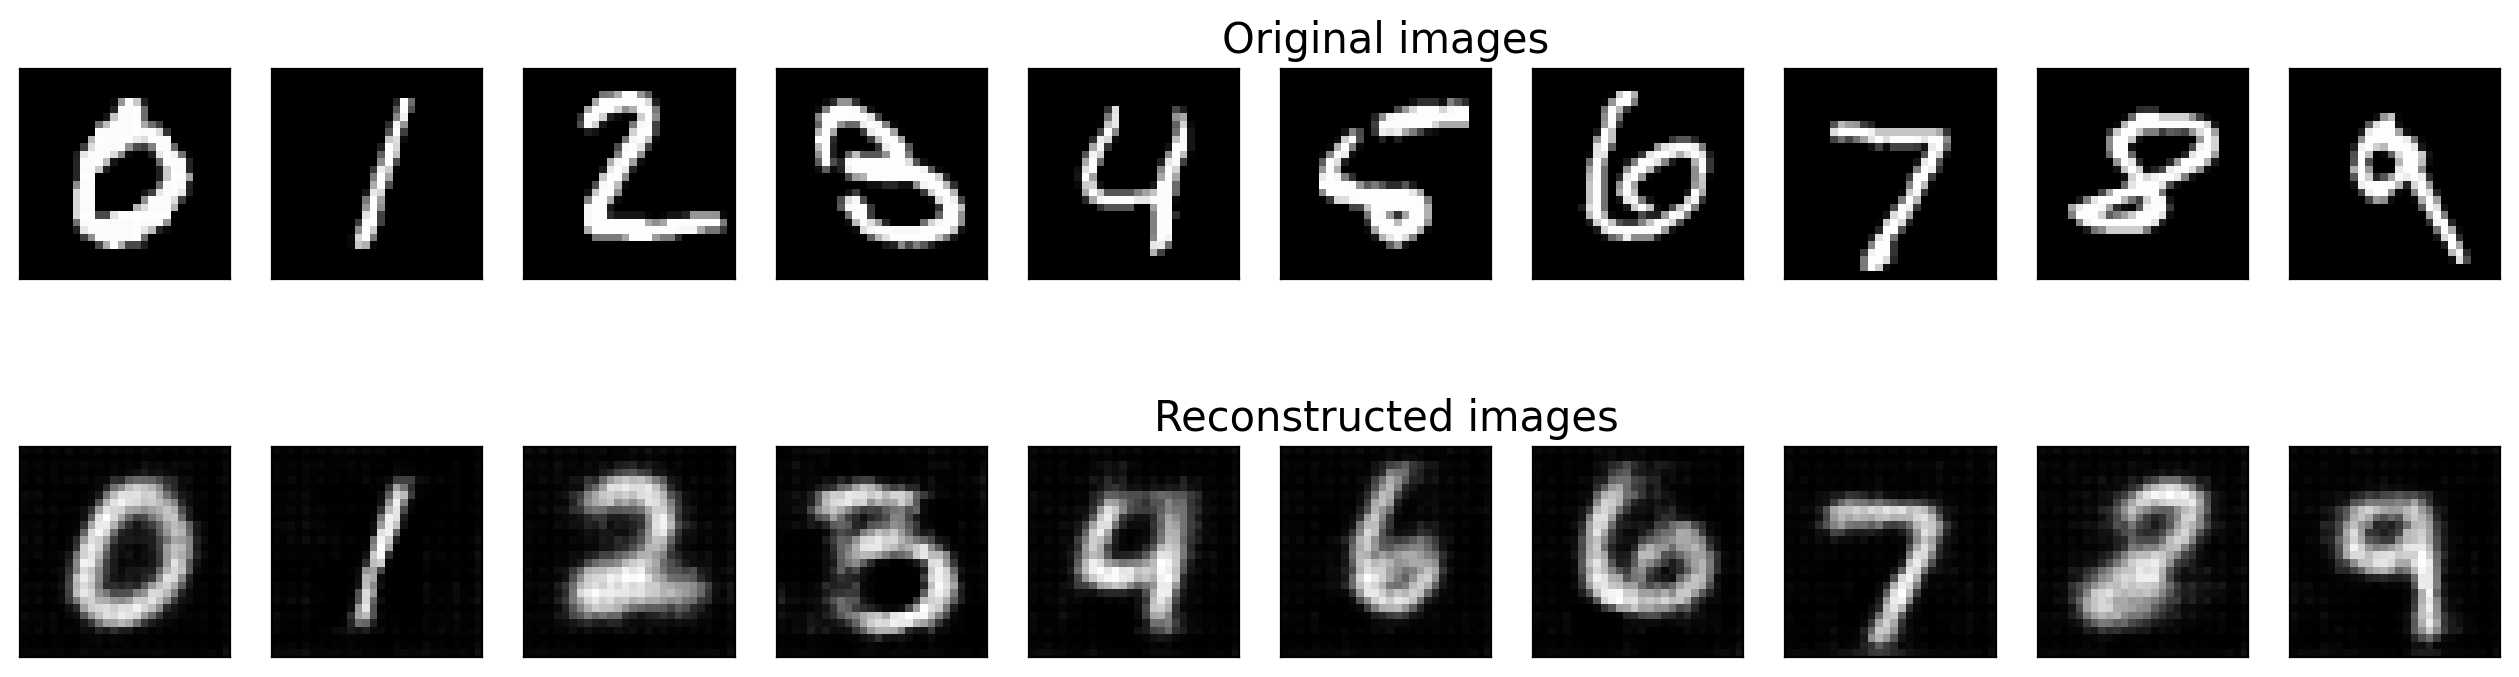


 EPOCH 10/20 	 train loss 31.760 	 val loss 32.087


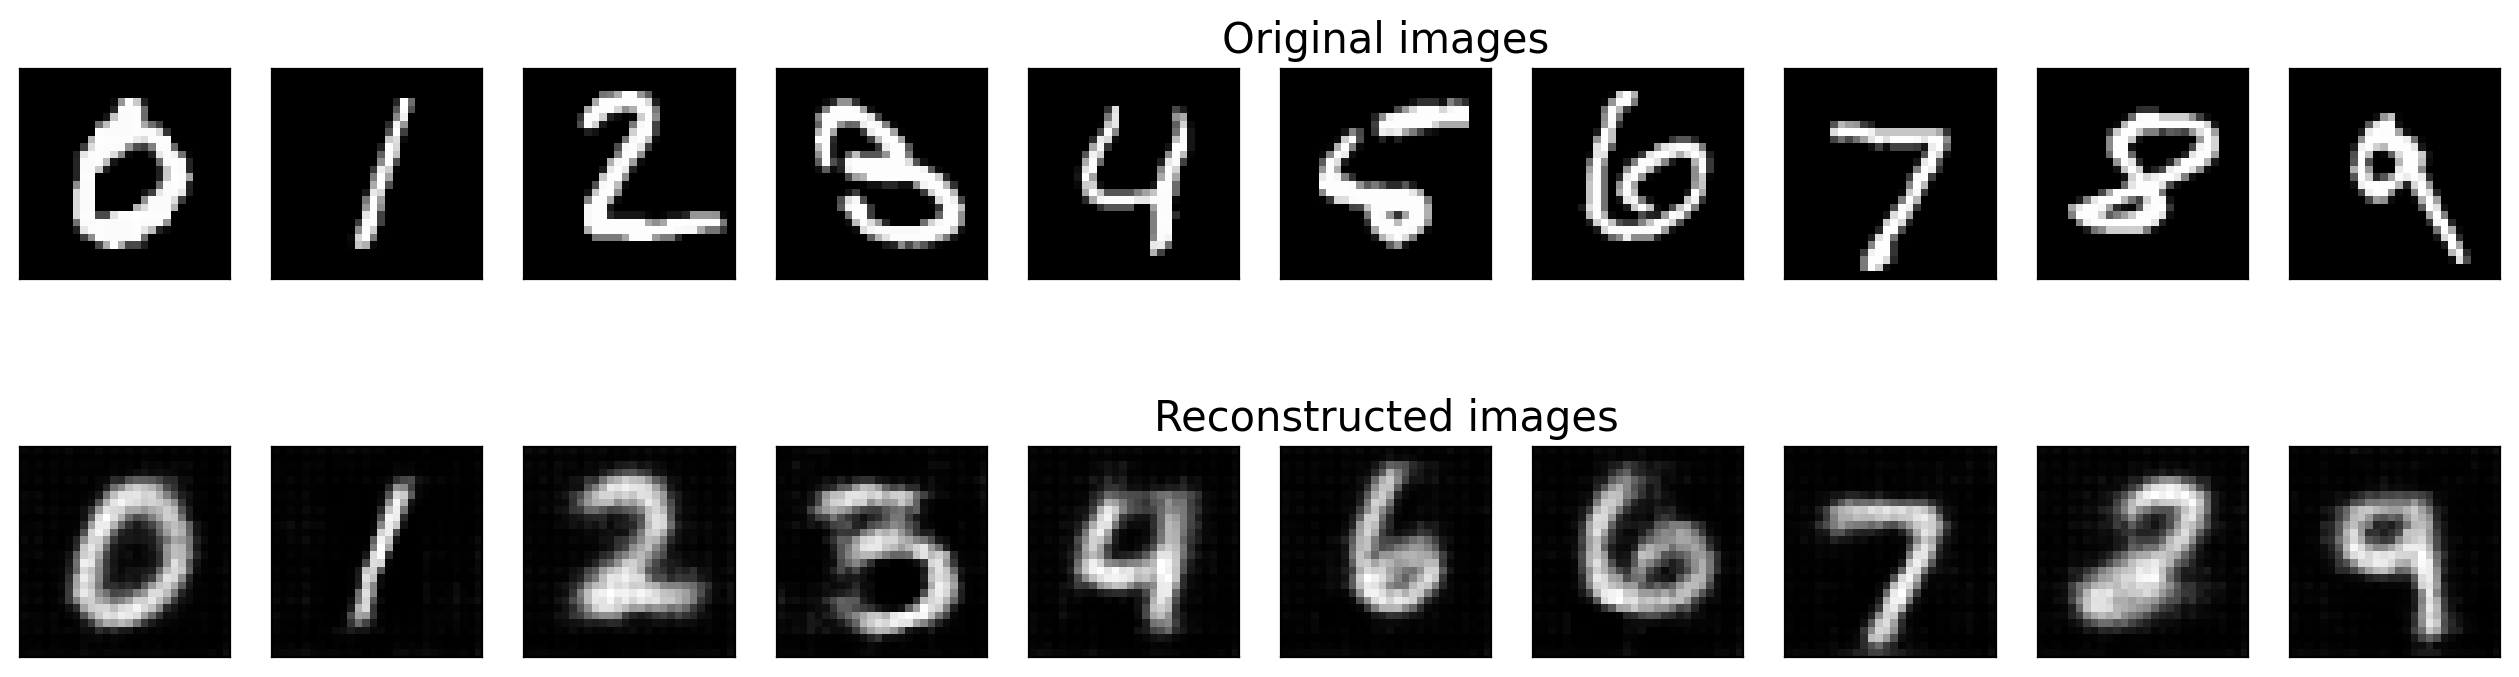


 EPOCH 11/20 	 train loss 31.377 	 val loss 31.590


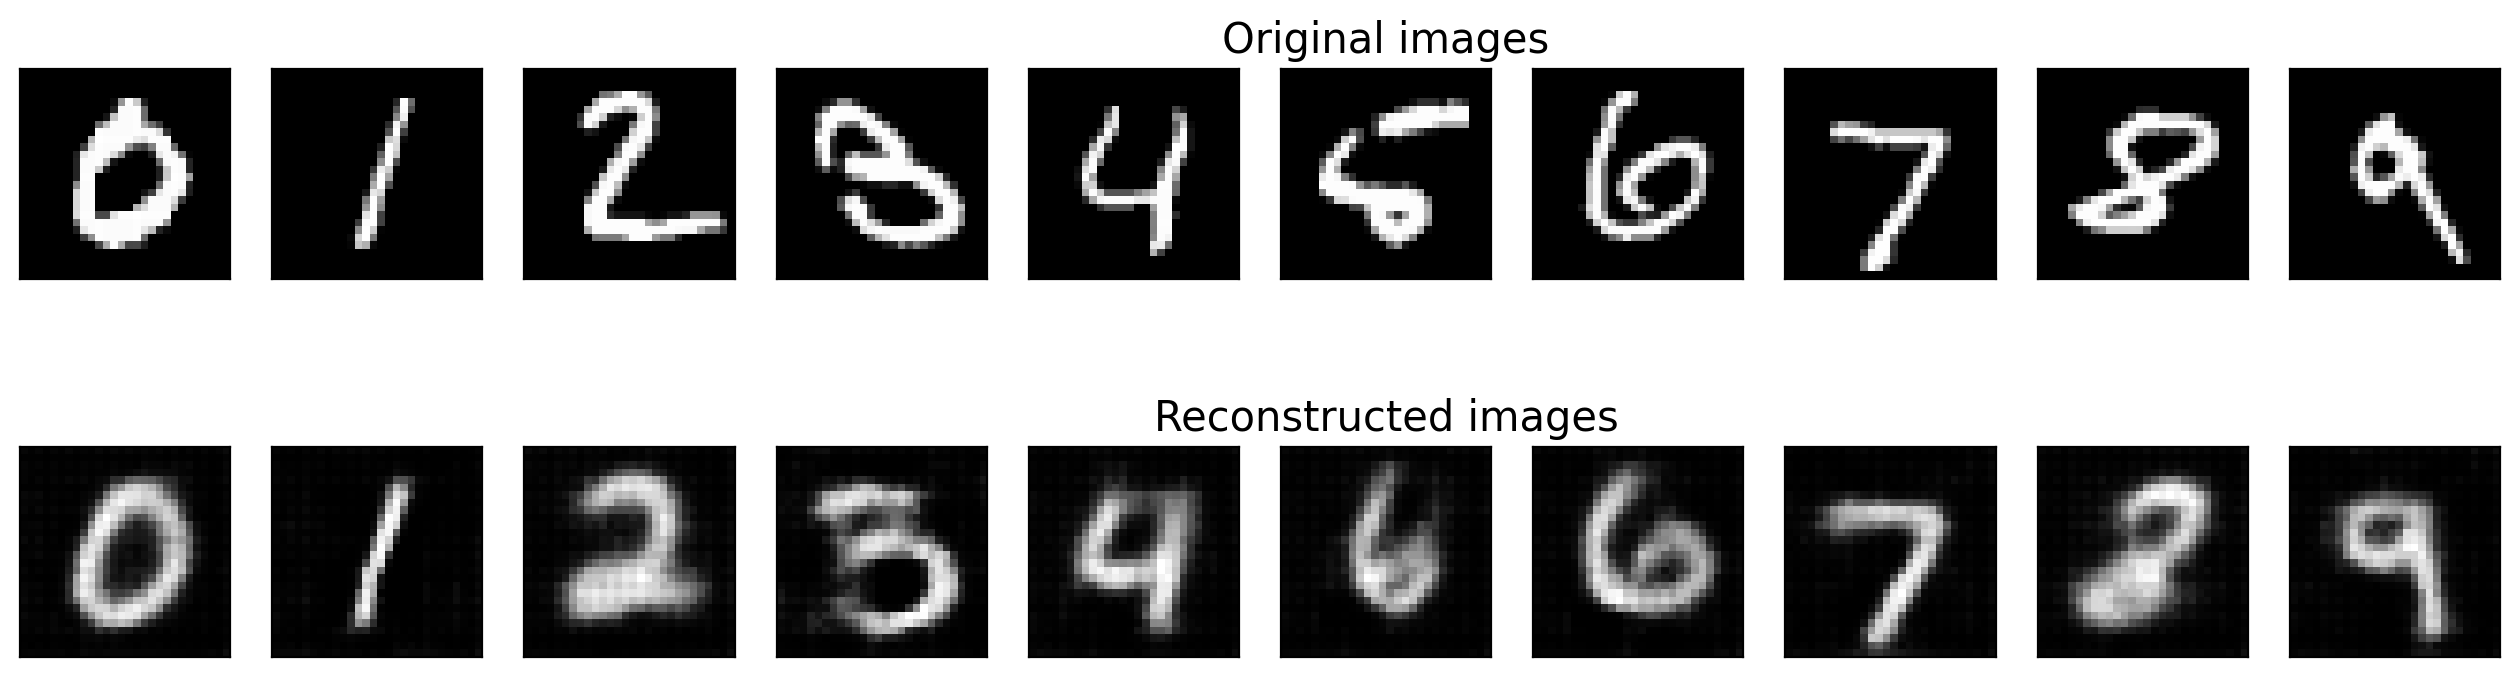


 EPOCH 12/20 	 train loss 31.094 	 val loss 31.681


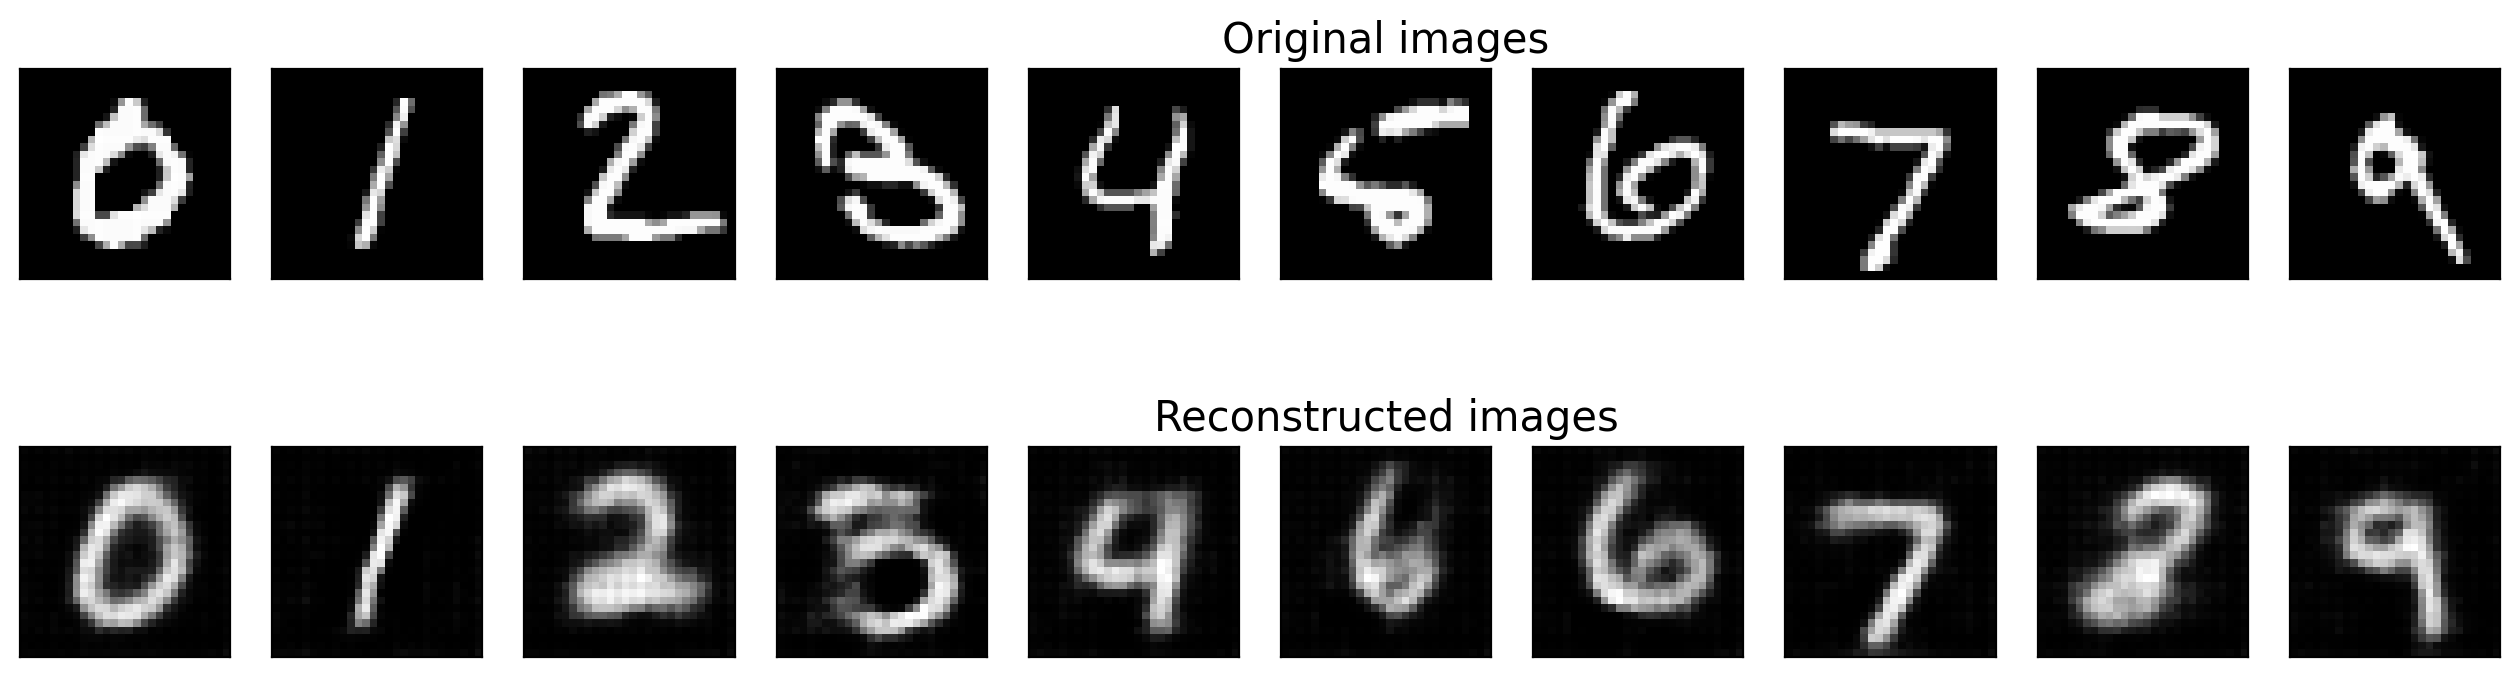


 EPOCH 13/20 	 train loss 30.814 	 val loss 31.086


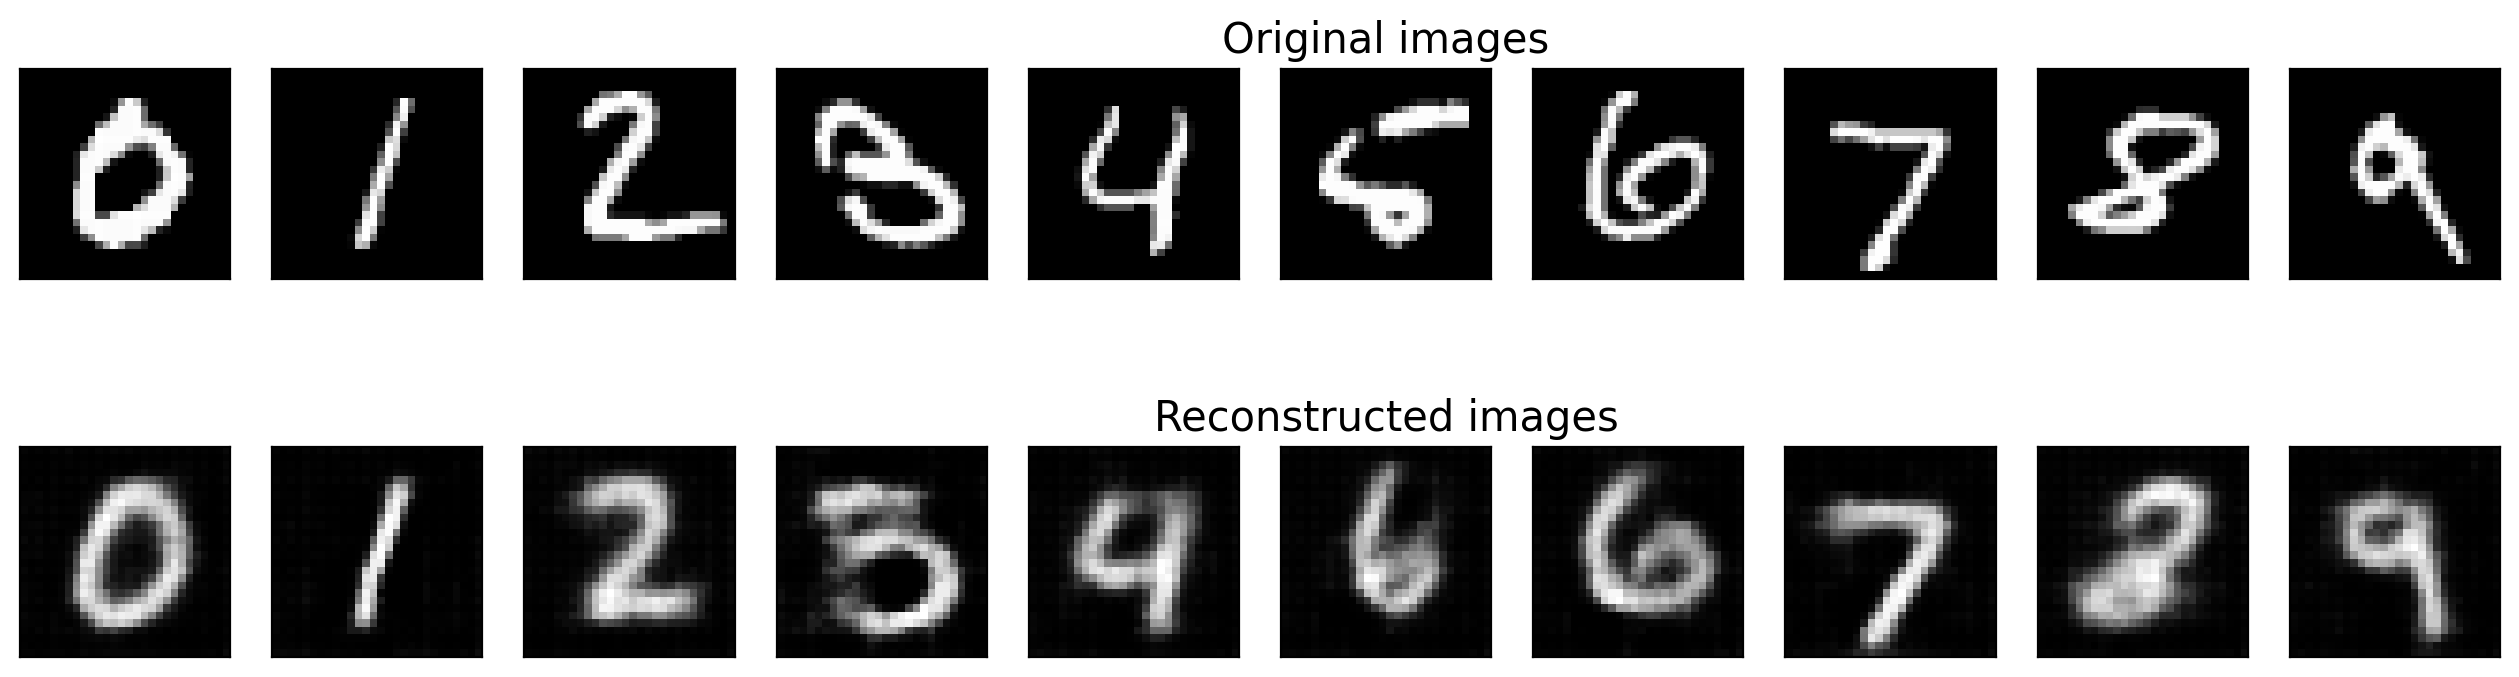


 EPOCH 14/20 	 train loss 30.567 	 val loss 30.782


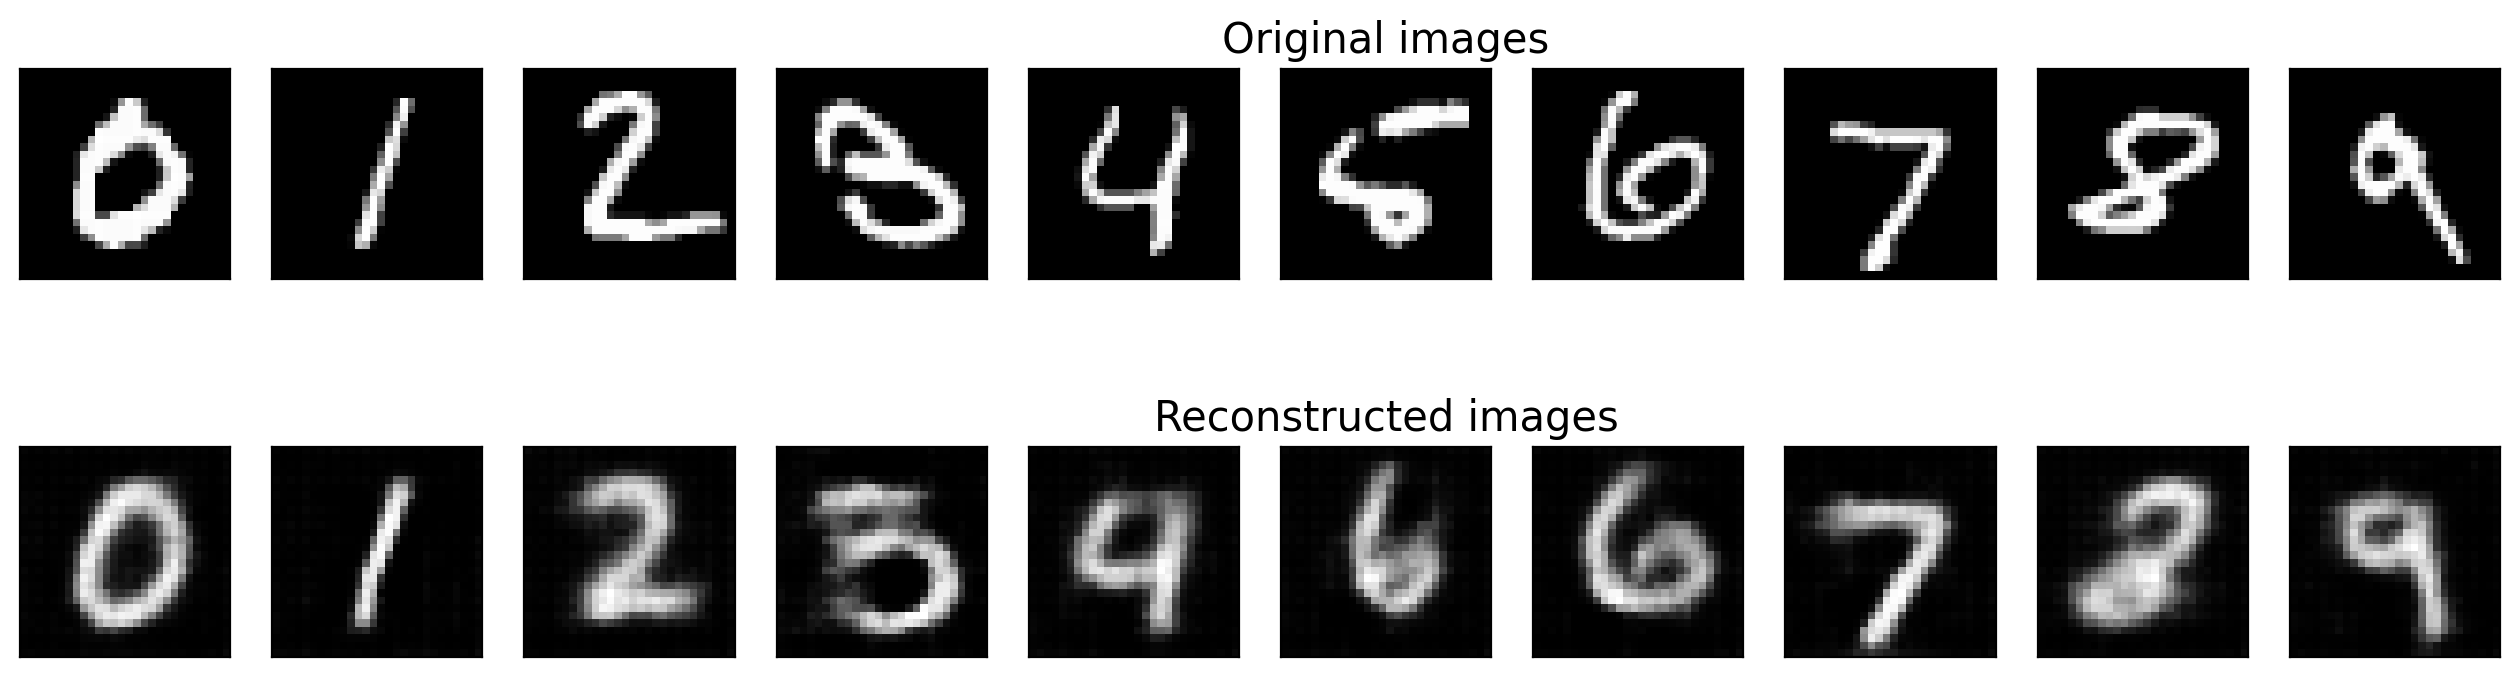


 EPOCH 15/20 	 train loss 30.362 	 val loss 30.649


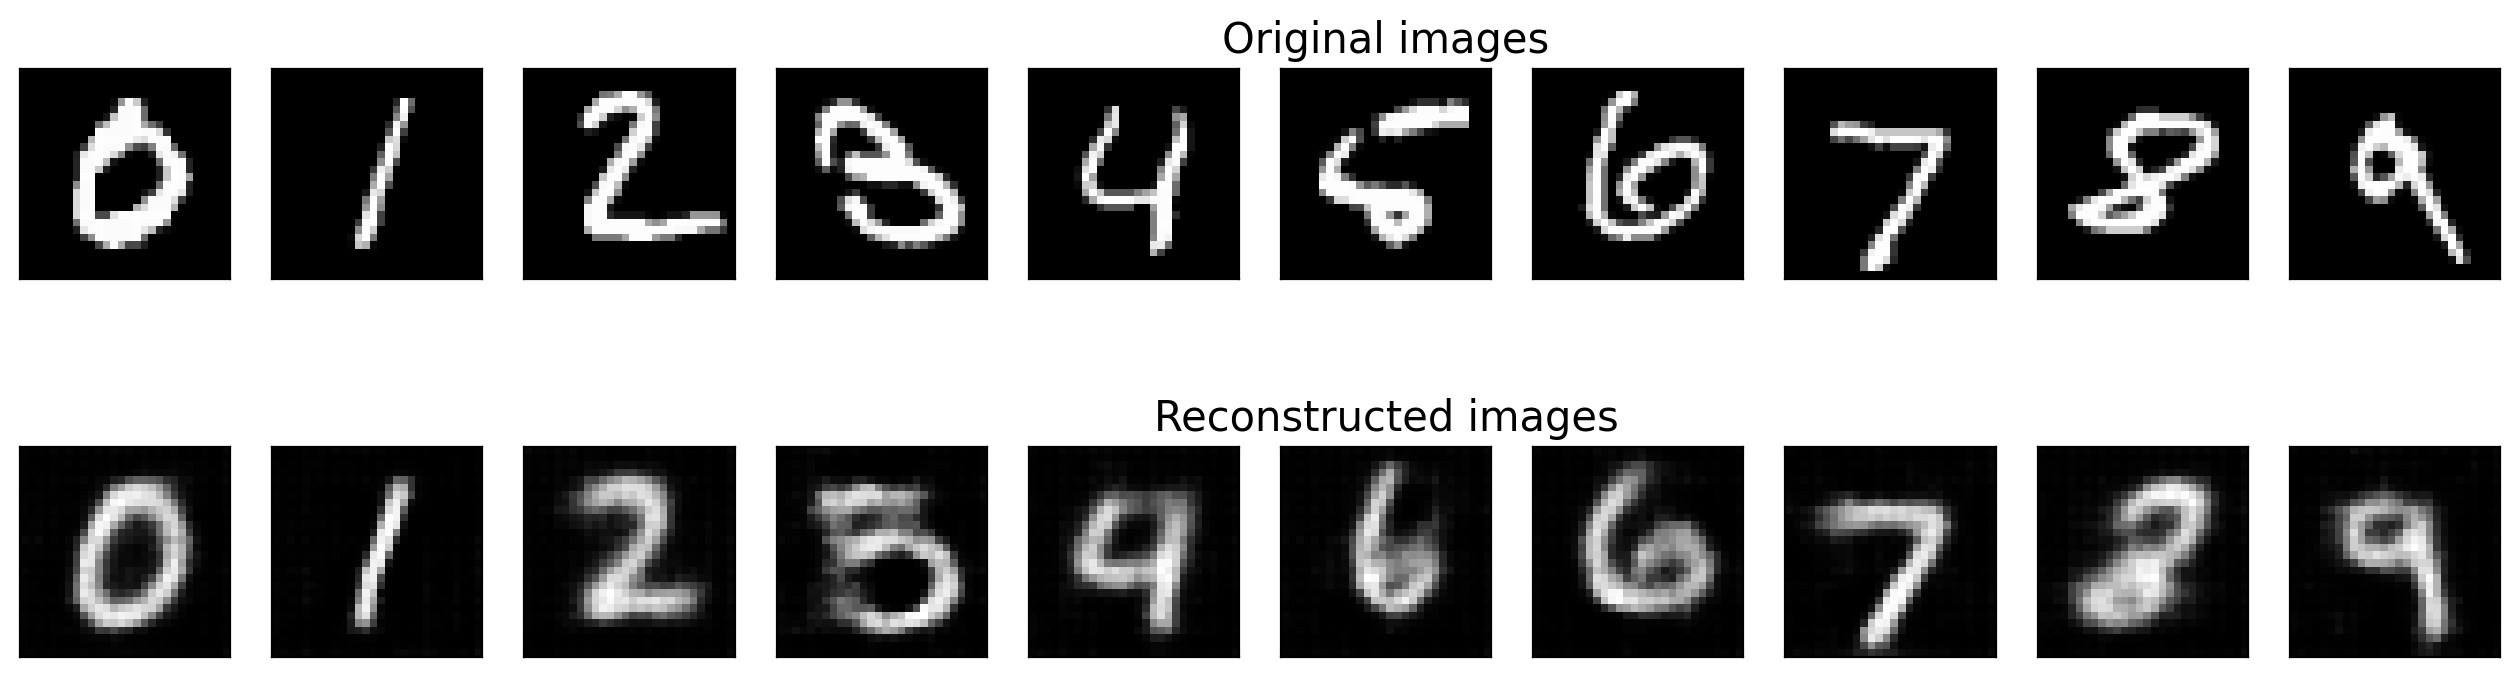


 EPOCH 16/20 	 train loss 30.191 	 val loss 30.465


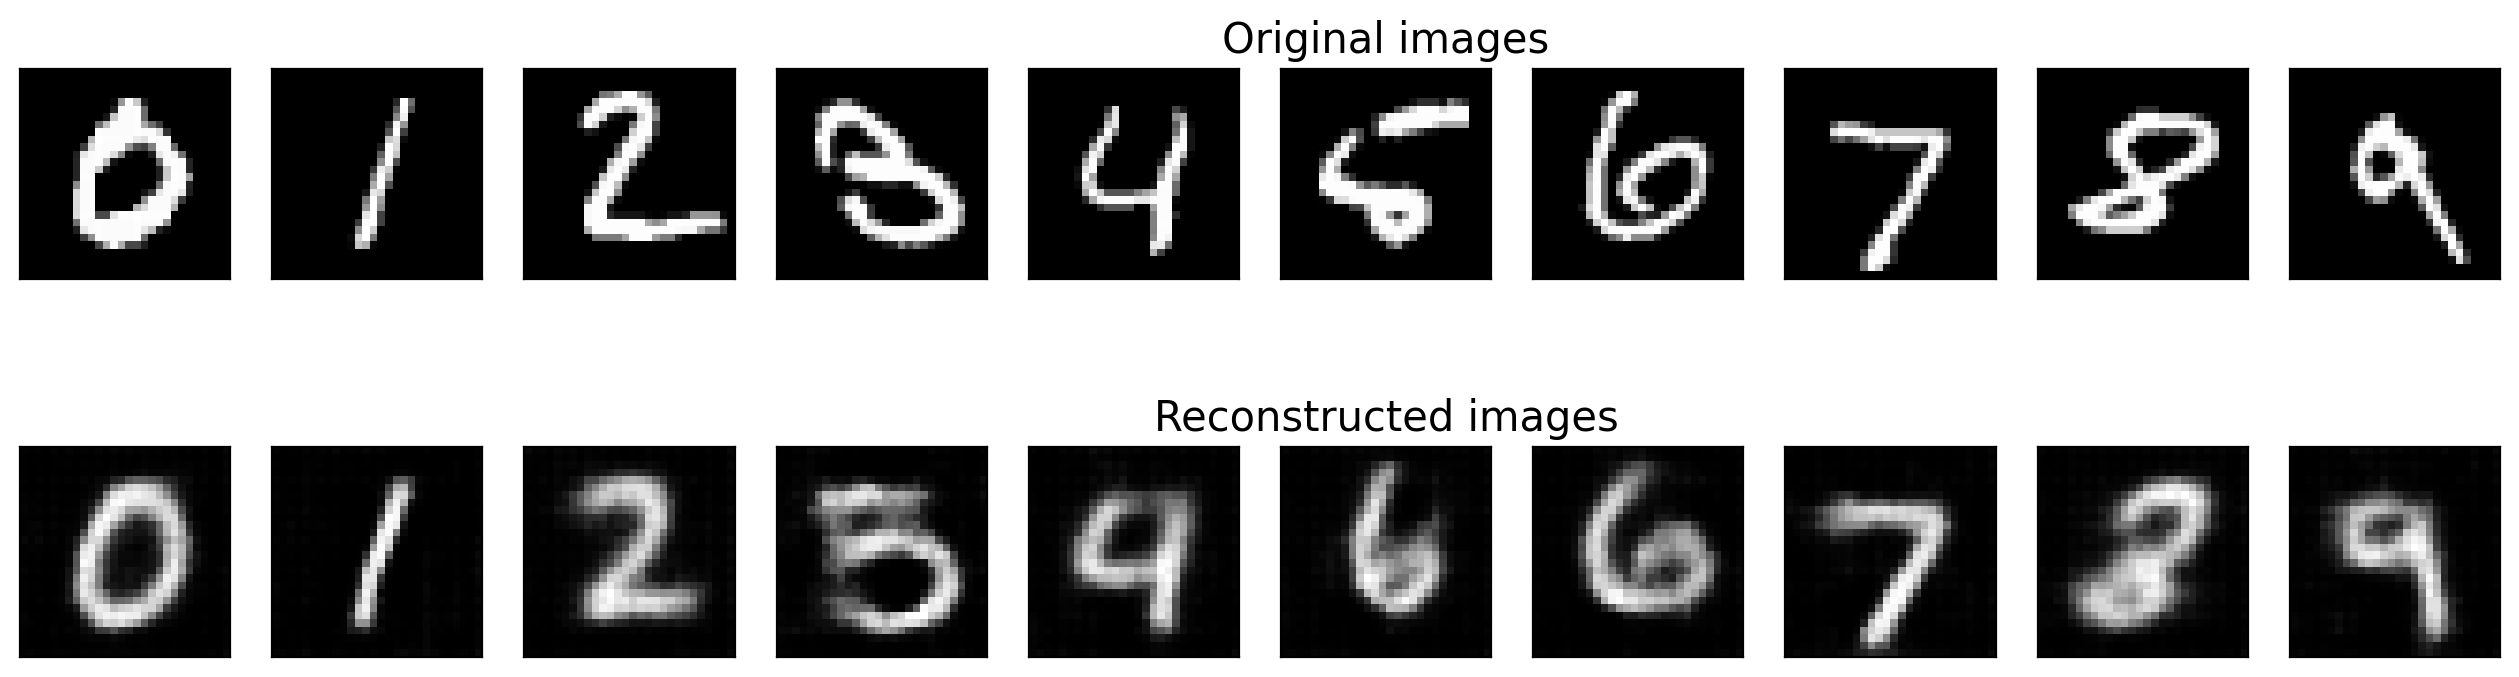


 EPOCH 17/20 	 train loss 30.033 	 val loss 30.337


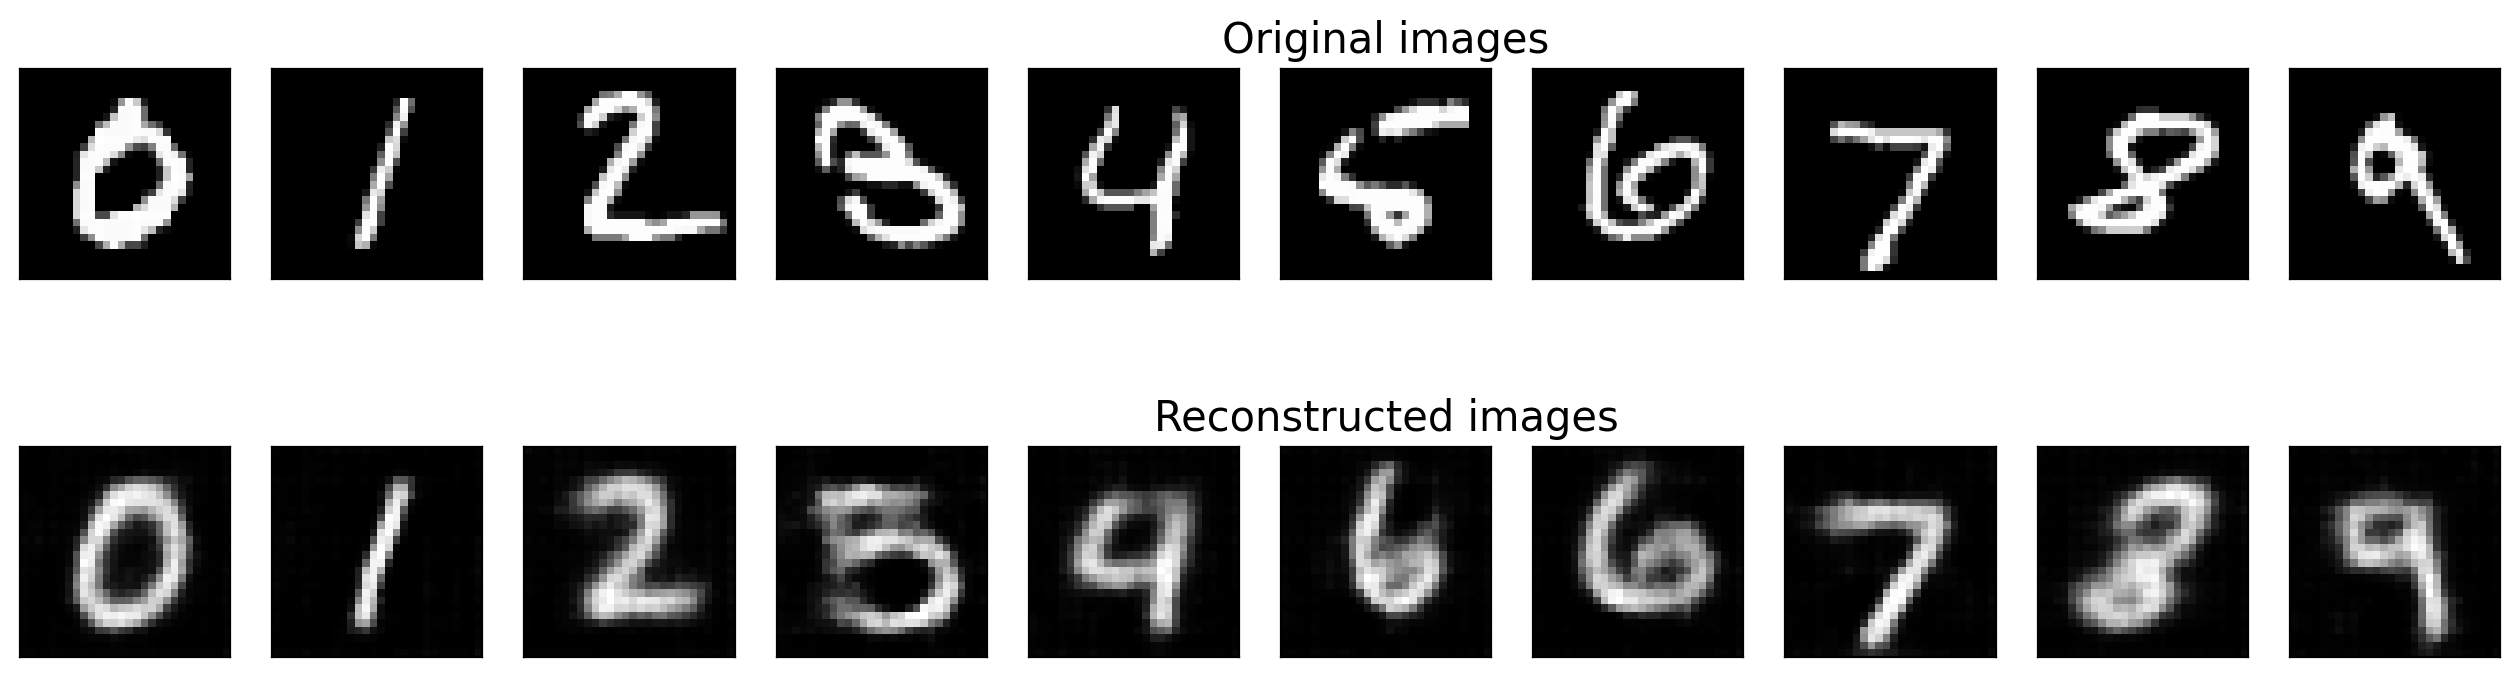


 EPOCH 18/20 	 train loss 29.907 	 val loss 30.192


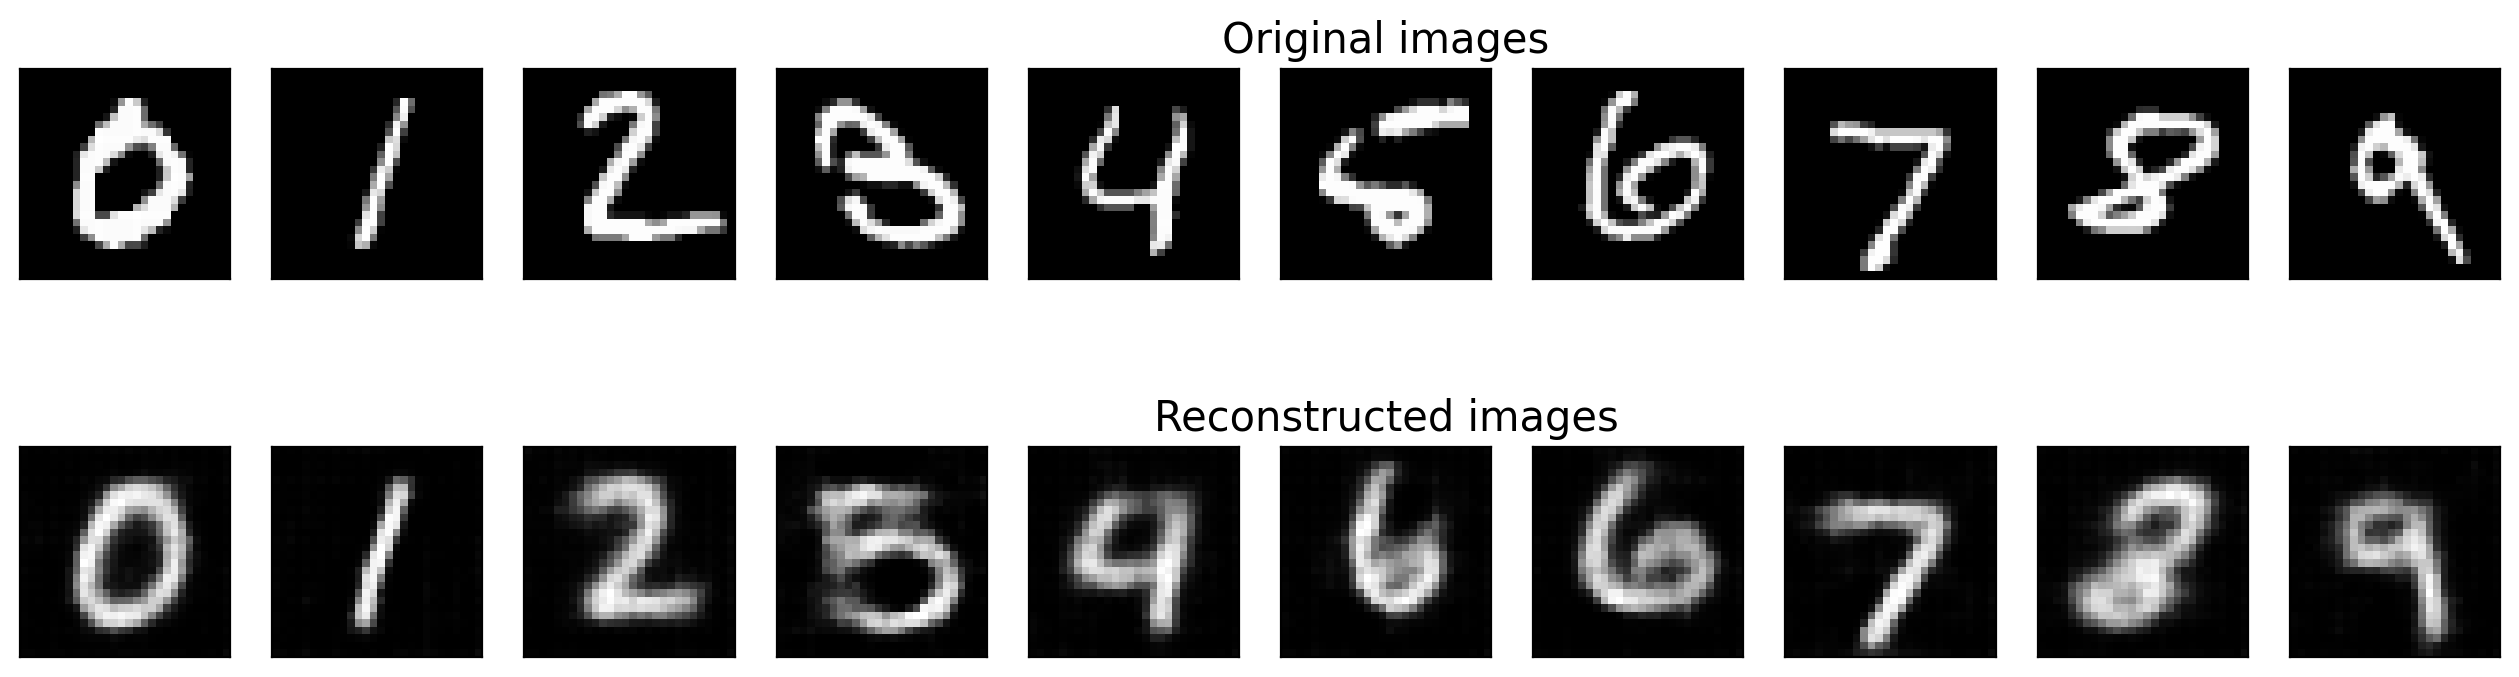


 EPOCH 19/20 	 train loss 29.759 	 val loss 30.125


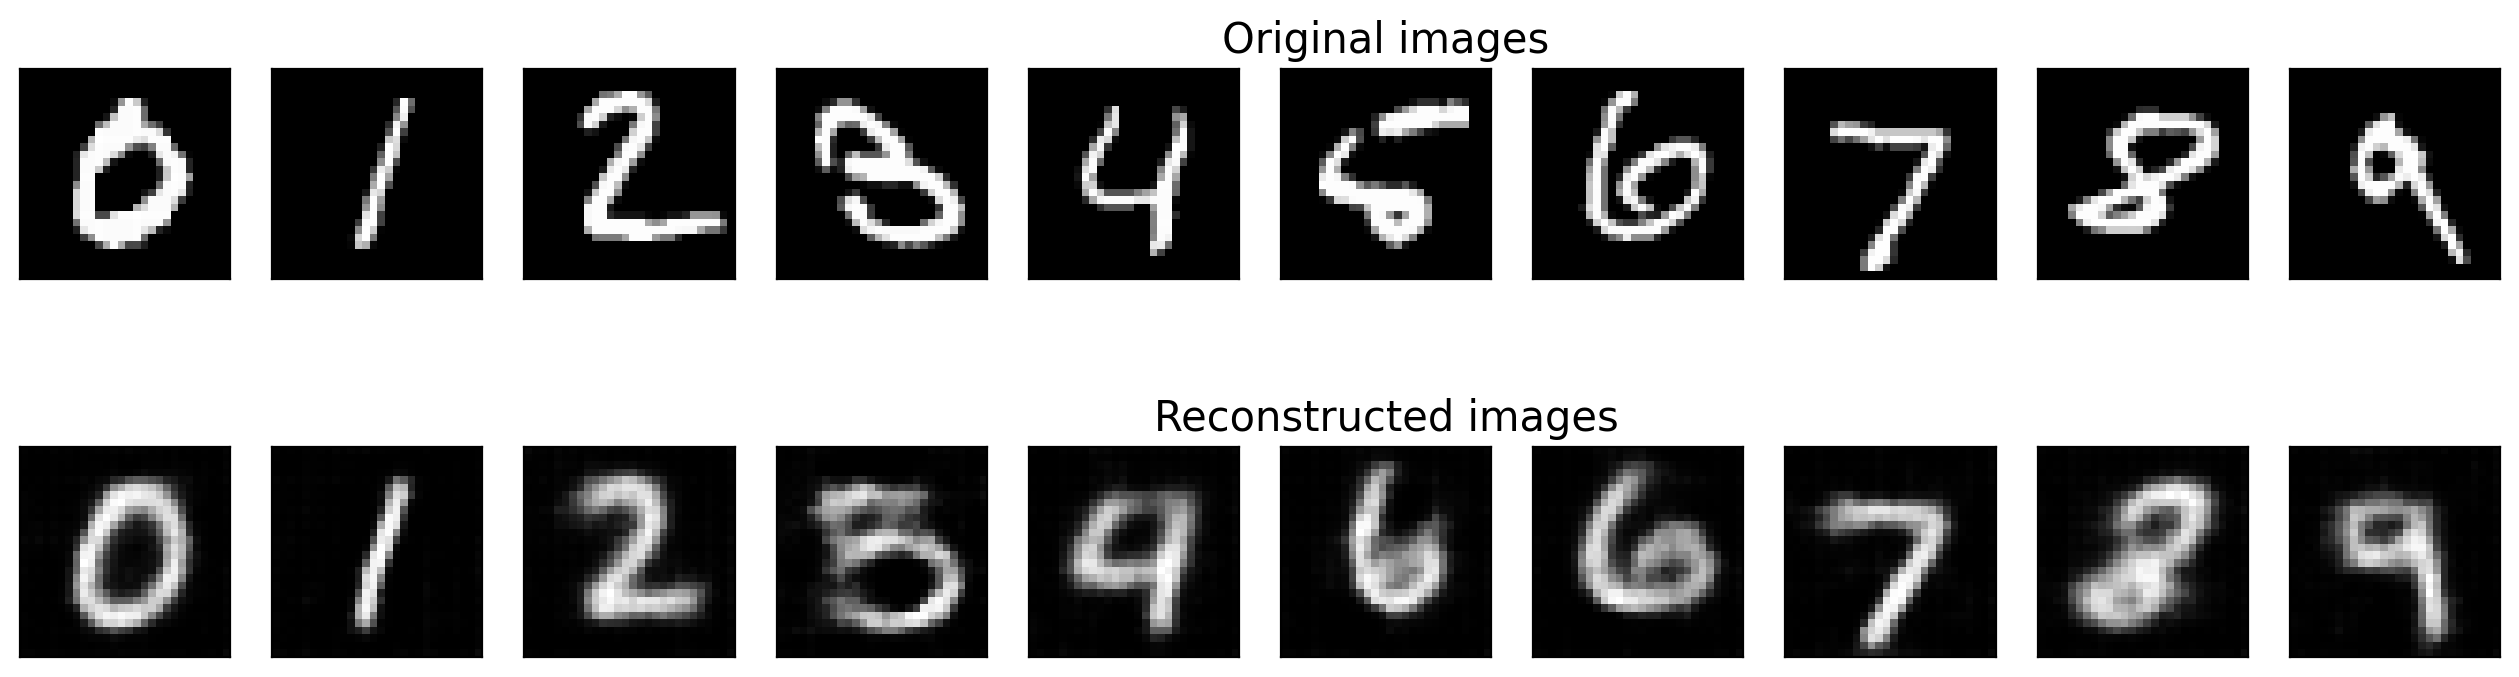


 EPOCH 20/20 	 train loss 29.651 	 val loss 29.923


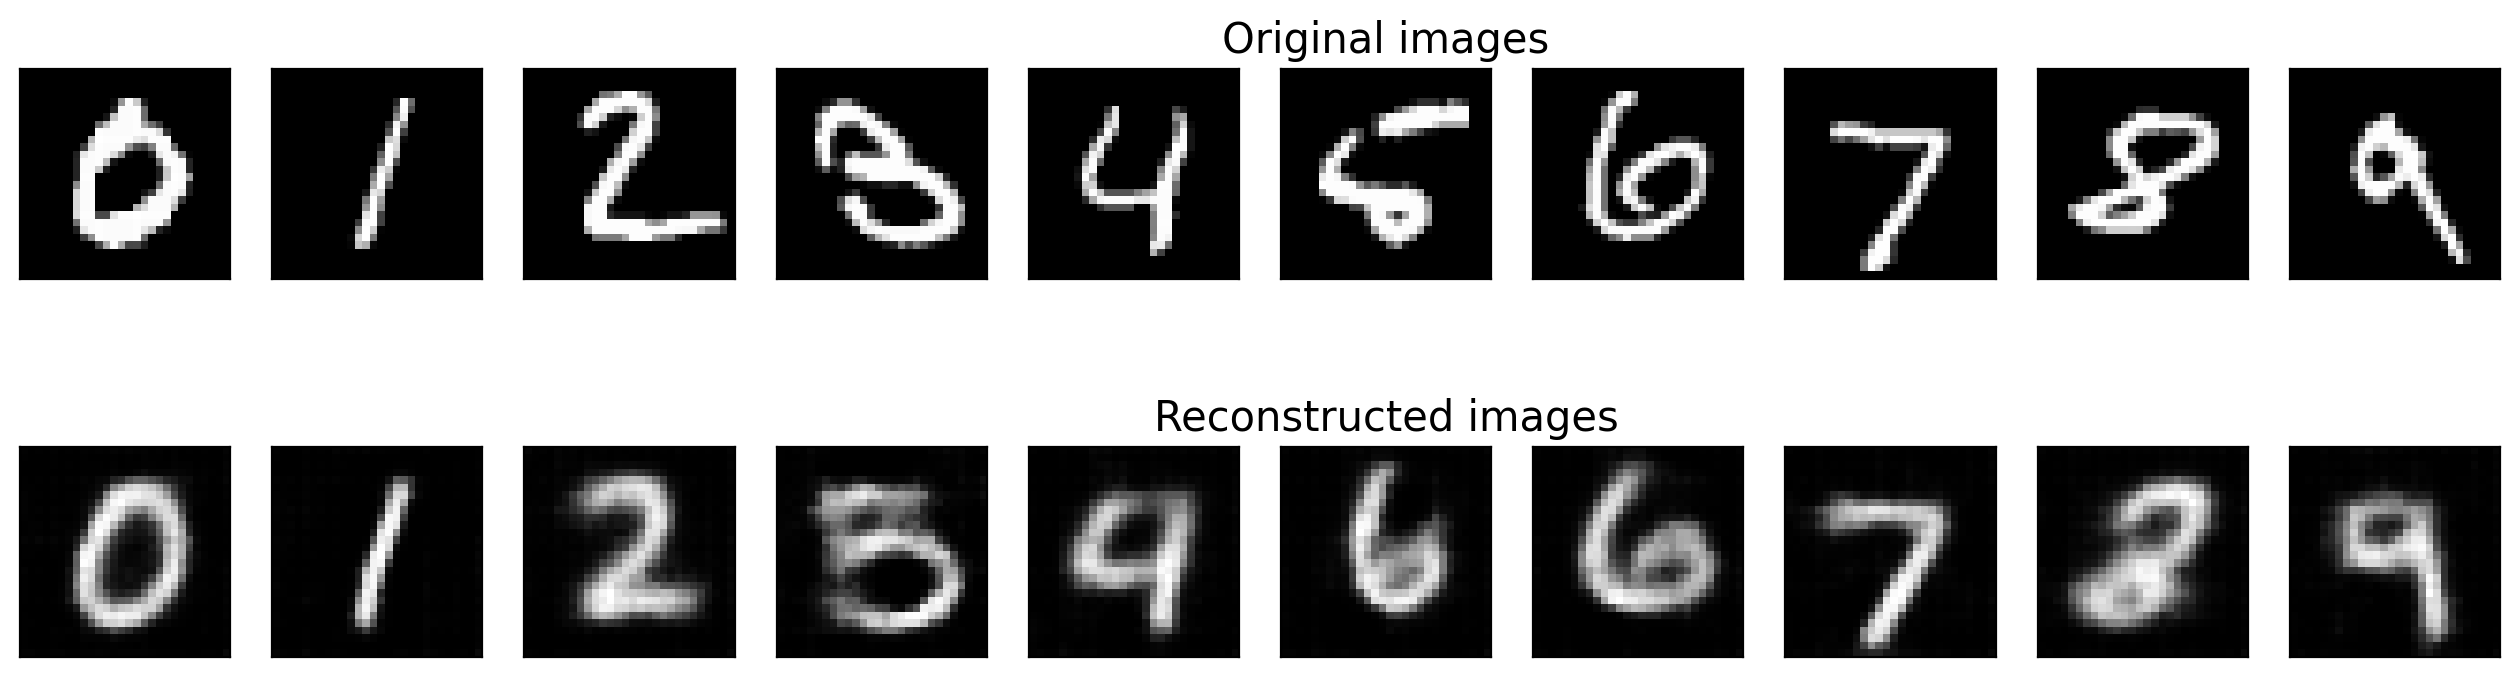

In [31]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train_epoch(mnvae,train_loader,optim)
    val_loss = test_epoch(mnvae,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(mnvae.encoder,mnvae.decoder,n=10)

Now, lets visualize what this looks like in the latent space. This tells us a lot of what we are learning.

done


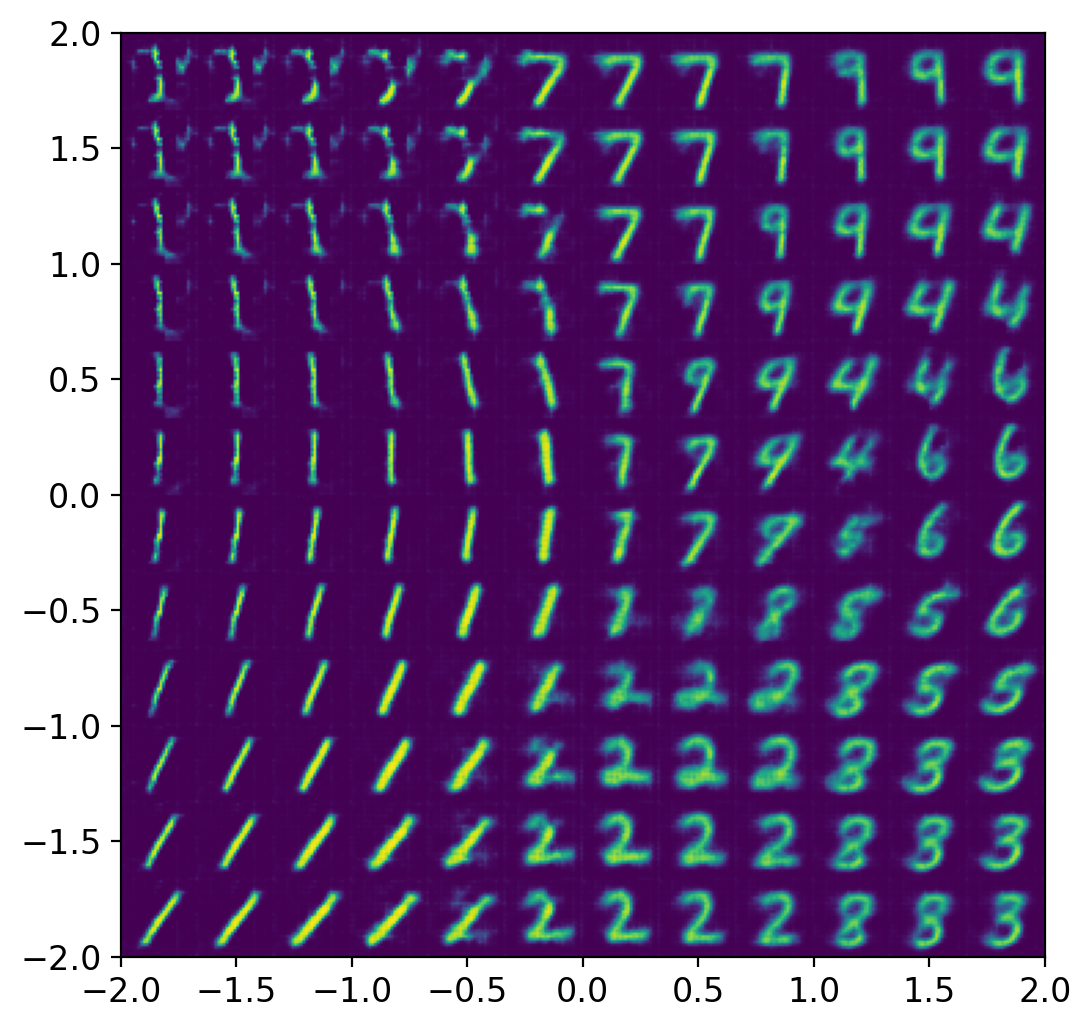

In [32]:
def plot_reconstructed(autoencoder, r0=(-2, 2), r1=(-2, 2), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    print("done")
    #plt.imshow(img, extent=[*r0, *r1],cmap='gray')
    #plt.imshow(img)
    #plt.show()
    return img,r0,r1

img,r0,r1=plot_reconstructed(mnvae)
plt.imshow(img,extent=[*r0, *r1])
plt.show()

<a name='exercises_22_1'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_1) | [Next Section](#section_22_2) |


<a name='section_20_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.2 Generating Bragg Scattering with Variational Autoencoders </h2>  

| [Top](#section_20_0) | [Previous Section](#section_20_1) | [Exercises](#exercises_20_2) | [Next Section](#section_20_3) |

Now we will build a variational autoencoder to model Bragg Scattering. For this, we will first focus on a single beam energy Additionally, we will try to predict the a few specific parameters

 * Beam Width
 * Beam Length
 * Energy deposited in last centimeter
 * Energy depsoited in the first centimeter

Let's load the functions that we uesd previously, and the go ahead and construct this guy!

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

def createData(ixstep,ipstep,iestep,iystep):
    length=ixstep[:,-1]
    width =iystep[:,-1]
    efront=np.zeros(ixstep.shape[0])
    eback =np.zeros(ixstep.shape[0])
    for i0 in range(ixstep.shape[0]):
        efront[i0] = np.sum(iestep[i0,ixstep[i0] < 3])/3.
        eback[i0]  = np.sum(iestep[i0,ixstep[i0] > ixstep[i0,-1]-1])
    processed_data = np.vstack((length,width,efront,eback))
    trainset       = torch.tensor(processed_data).float()
    return trainset

indataset150=createData(xstep150,pstep150,estep150,ystep150)
indataset150=indataset150.T

indataset200=createData(xstep200,pstep200,estep200,ystep200)
indataset200=indataset200.T

indataset250=createData(xstep250,pstep250,estep250,ystep250)
indataset250=indataset250.T

indataset300=createData(xstep300,pstep300,estep300,ystep300)
indataset300=indataset300.T

indataset   = np.vstack((indataset150,indataset200,indataset250,indataset300))
print(indataset.shape)

(4000, 4)


In [34]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def nfeatures(self):
        return self.samples.shape[1]

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

dataset150=DataSet(samples=indataset150,labels=np.ones(indataset150.shape[0])*150)
dataset=DataSet(samples=indataset,labels=np.ones(indataset.shape[0])*150)

Now that we have constructed a simple dataset, we can go ahead and make a variational autoencoder to describe all this information. Since we are not taking images for the moment, we can do this with dense layers.

In [35]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dims,latent_dims):
        super(VariationalAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 10*input_dims)
        self.batch = nn.BatchNorm1d(10*input_dims)
        self.linear2 = nn.Linear(10*input_dims, 10*input_dims)
        self.linear3 = nn.Linear(10*input_dims, latent_dims)
        self.linear4 = nn.Linear(10*input_dims, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, 25*input_dims),
            nn.ReLU(True),
            nn.Linear(25*input_dims, input_dims),
        )


    def encoder(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.batch(self.linear2(x)))
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear3(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear4(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z

    def decoder(self, x):
        x = self.decoder_lin(x)
        return x

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

torch.manual_seed(0)
d = 2
vae = VariationalAutoEncoder(input_dims=dataset.nfeatures(),latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#valid_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [36]:
num_epochs = 5001

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    #val_loss = test_epoch(vae,valid_loader)
    if epoch % 500 == 0:
        print('EPOCH {}/{} \t train loss {:.3f} \t'.format(epoch + 1, num_epochs,train_loss))


EPOCH 1/5001 	 train loss 1490.453 	
EPOCH 501/5001 	 train loss 7.367 	
EPOCH 1001/5001 	 train loss 6.347 	
EPOCH 1501/5001 	 train loss 6.194 	
EPOCH 2001/5001 	 train loss 6.025 	
EPOCH 2501/5001 	 train loss 6.059 	
EPOCH 3001/5001 	 train loss 5.969 	
EPOCH 3501/5001 	 train loss 5.997 	
EPOCH 4001/5001 	 train loss 5.948 	
EPOCH 4501/5001 	 train loss 5.970 	
EPOCH 5001/5001 	 train loss 5.921 	


Now, we can generate our own events from the VAE.

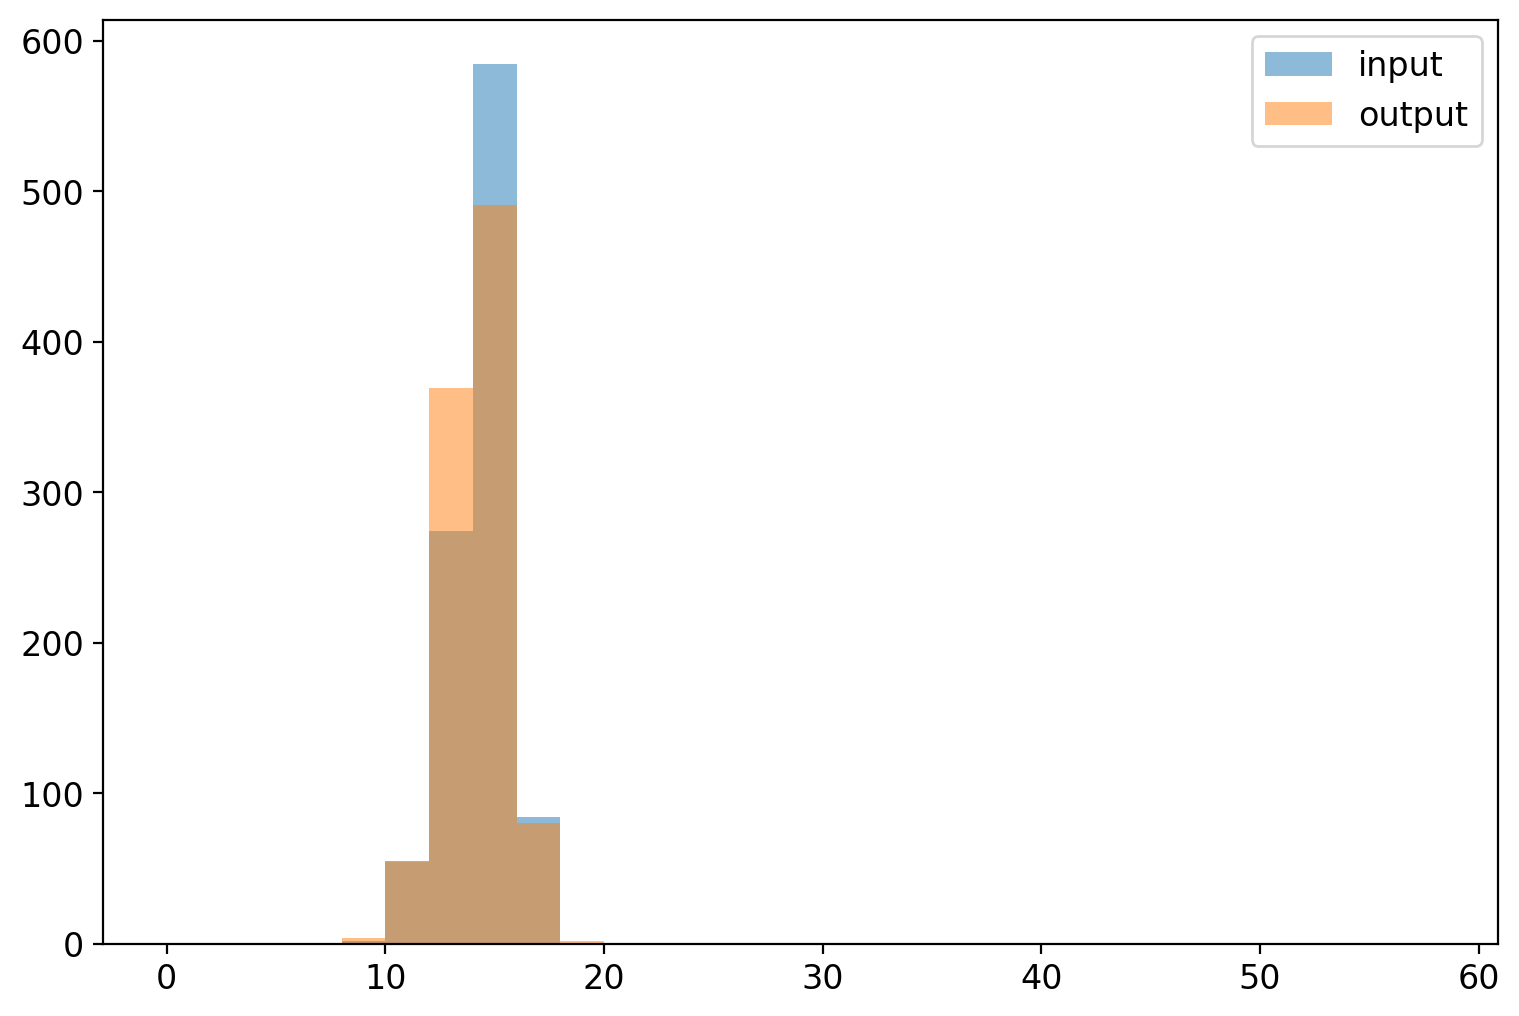

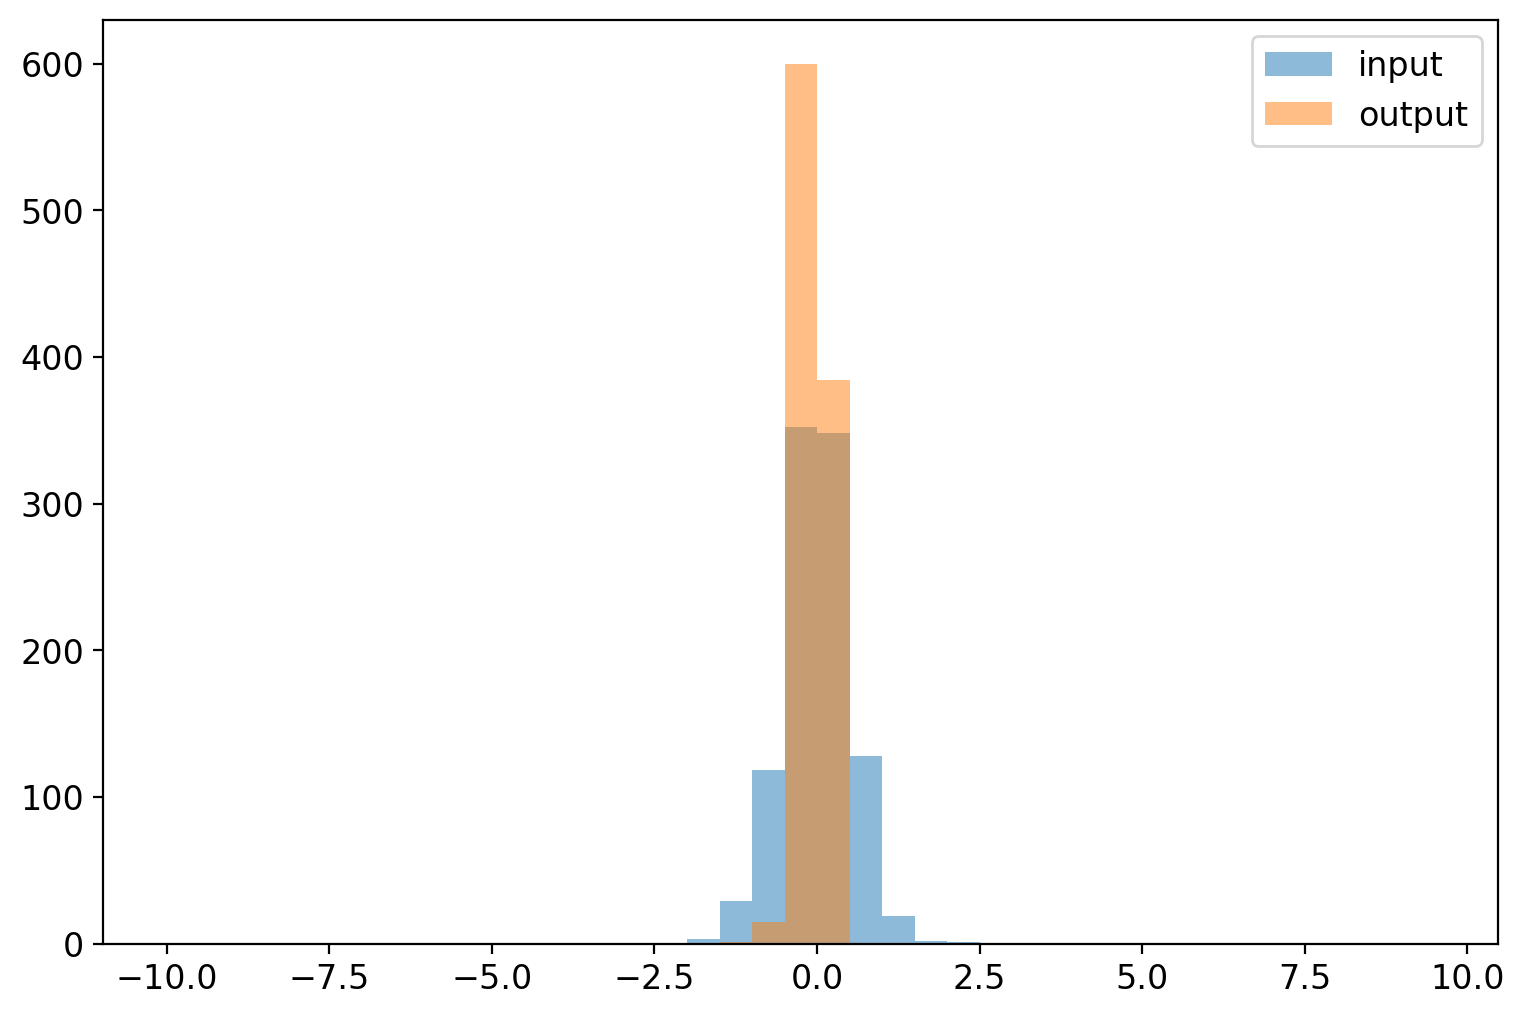

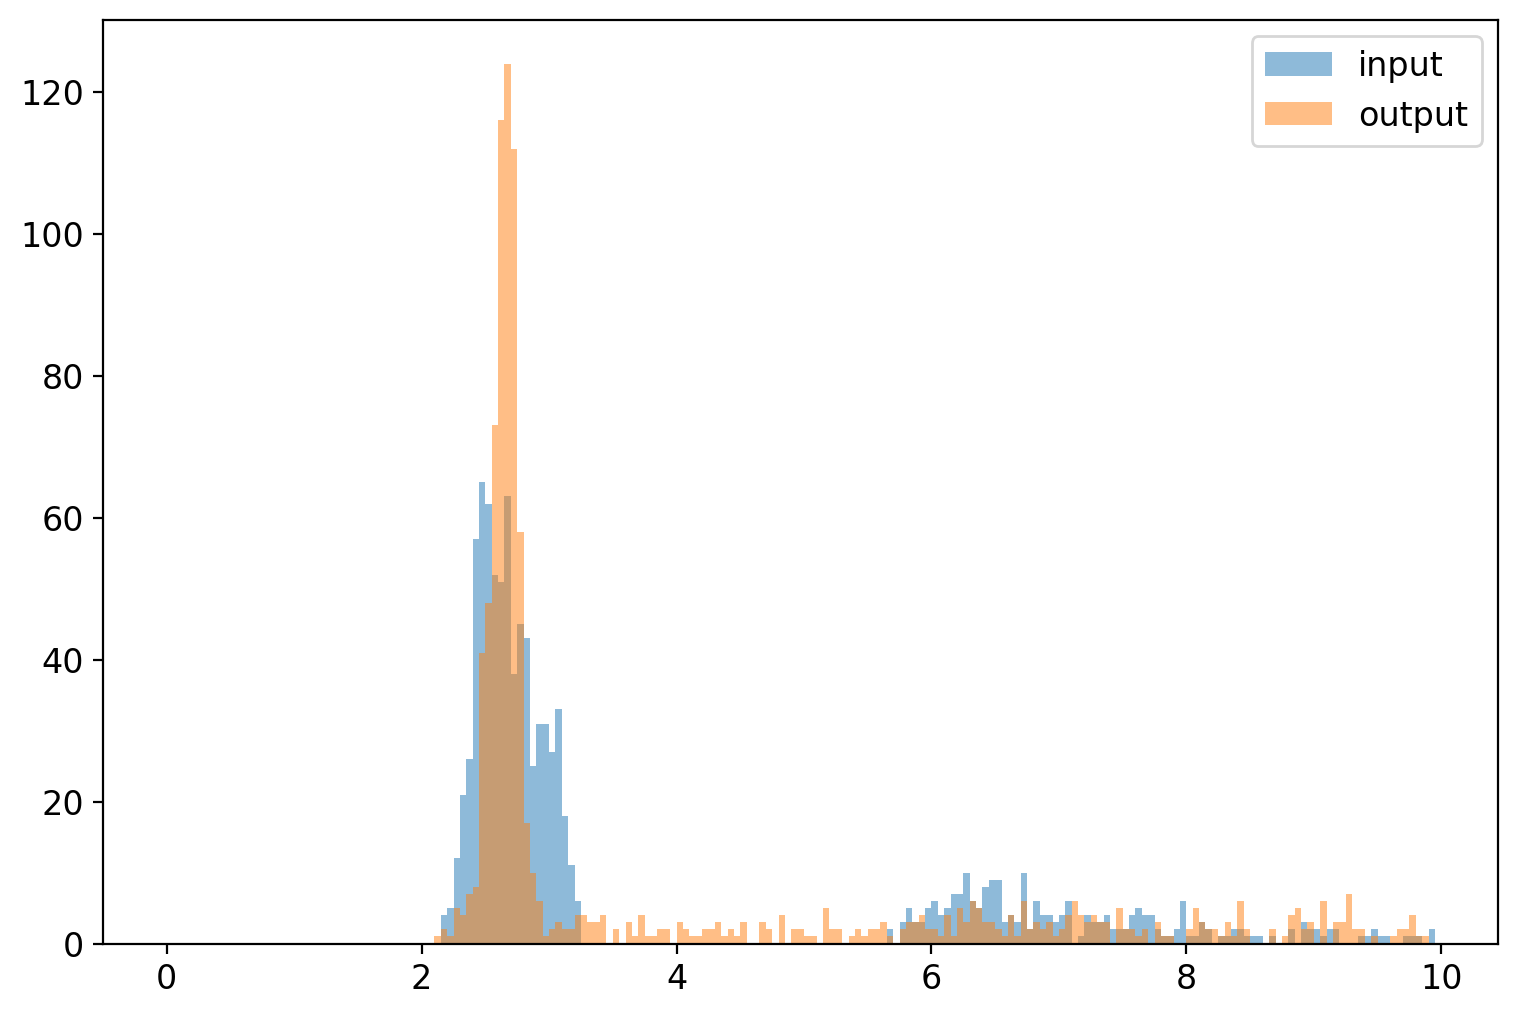

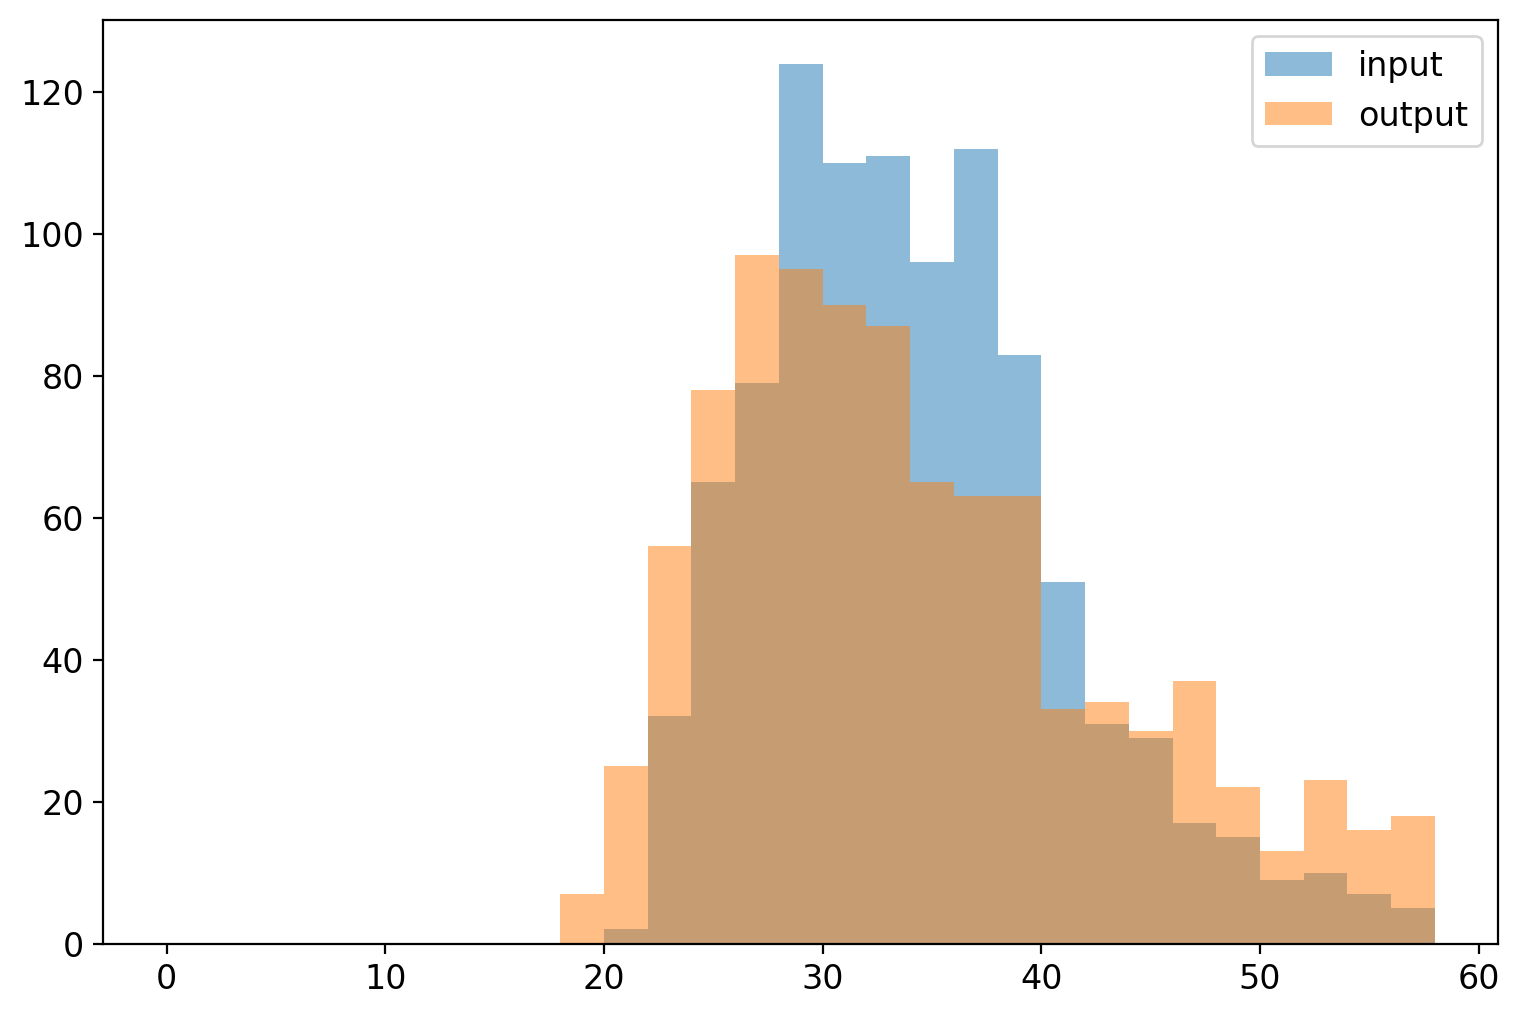

In [39]:
def plotVAEOutputs(iLatentDim,iDataSet,iVAE):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    outputvars=iVAE.decoder(testlatent)

    xrange=np.arange(0,60,2)
    plt.hist(iDataSet[:,0],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,0].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(-10,10,0.5)
    plt.hist(iDataSet[:,1],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,1].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,10,0.05)
    plt.hist(iDataSet[:,2],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,2].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(iDataSet[:,3],label='input',alpha=0.5,bins=xrange)
    plt.hist(outputvars[:,3].detach().numpy(),label='output',alpha=0.5,bins=xrange)
    plt.legend()
    plt.show()

plotVAEOutputs(d,indataset150,vae)

Now that captured most of the high level features, we can naturally play around with the system and try to get get it better.

### Question

Train the above with 4 latent dimensions using just the 150 MeV dataset how good is the agreement? Why are you not surprised that 4 dimensions is so good?

EPOCH 1/5001 	 train loss 2301.763 	
EPOCH 501/5001 	 train loss 15.680 	
EPOCH 1001/5001 	 train loss 13.454 	
EPOCH 1501/5001 	 train loss 13.822 	
EPOCH 2001/5001 	 train loss 12.215 	
EPOCH 2501/5001 	 train loss 11.588 	
EPOCH 3001/5001 	 train loss 10.824 	
EPOCH 3501/5001 	 train loss 10.323 	
EPOCH 4001/5001 	 train loss 9.962 	
EPOCH 4501/5001 	 train loss 9.731 	
EPOCH 5001/5001 	 train loss 10.057 	


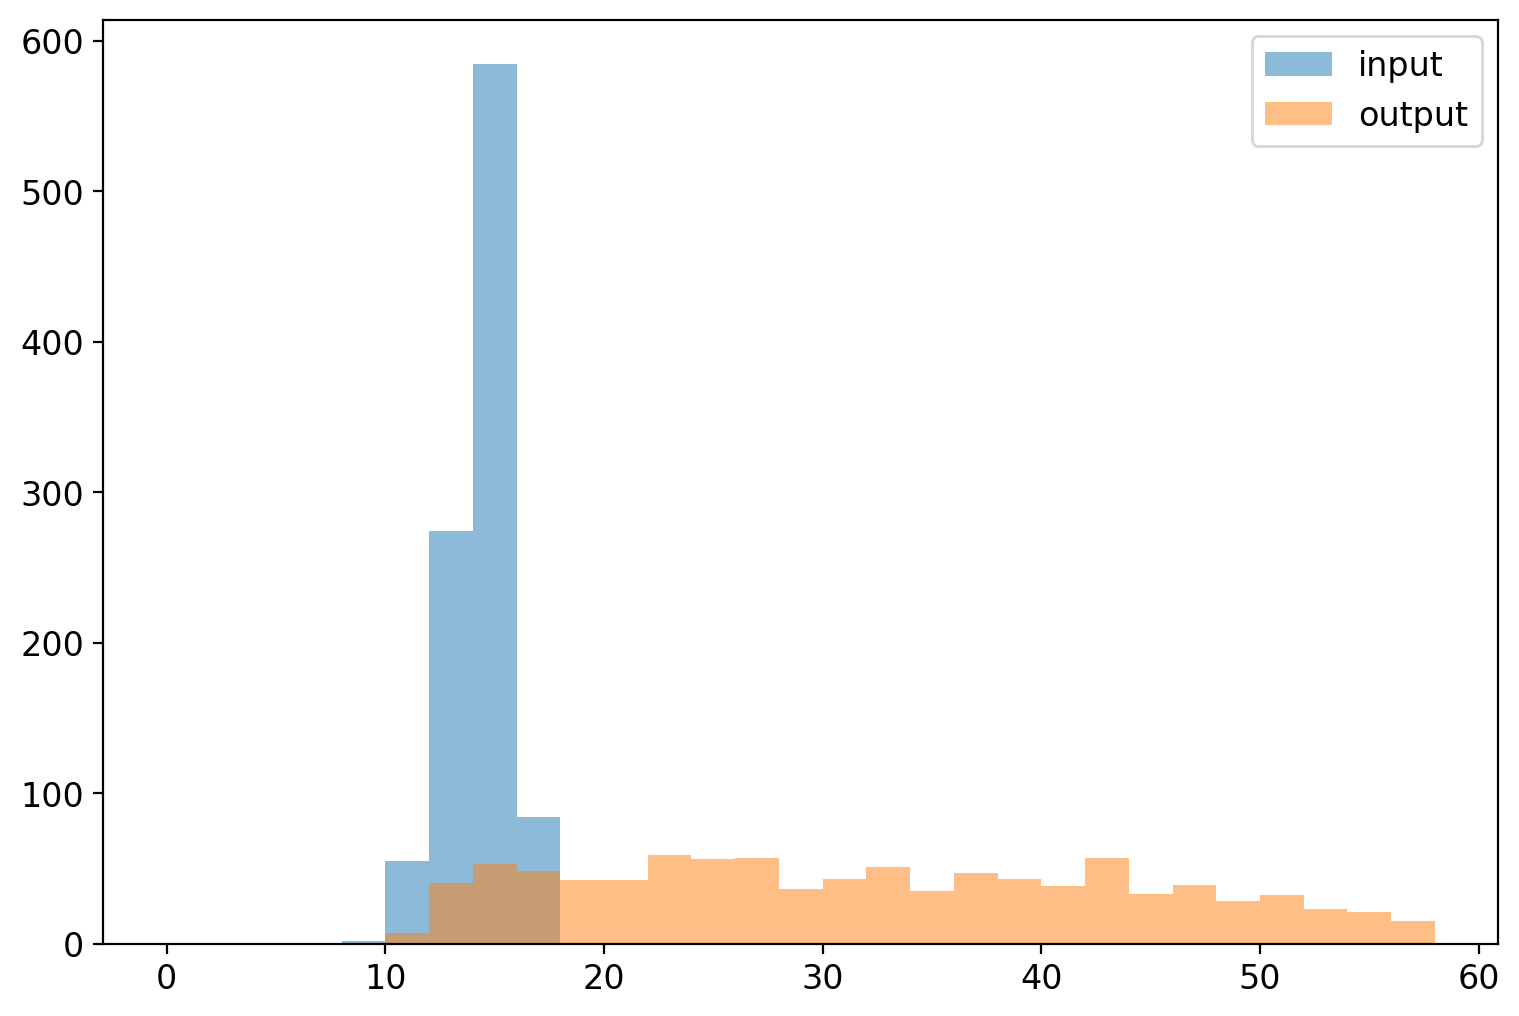

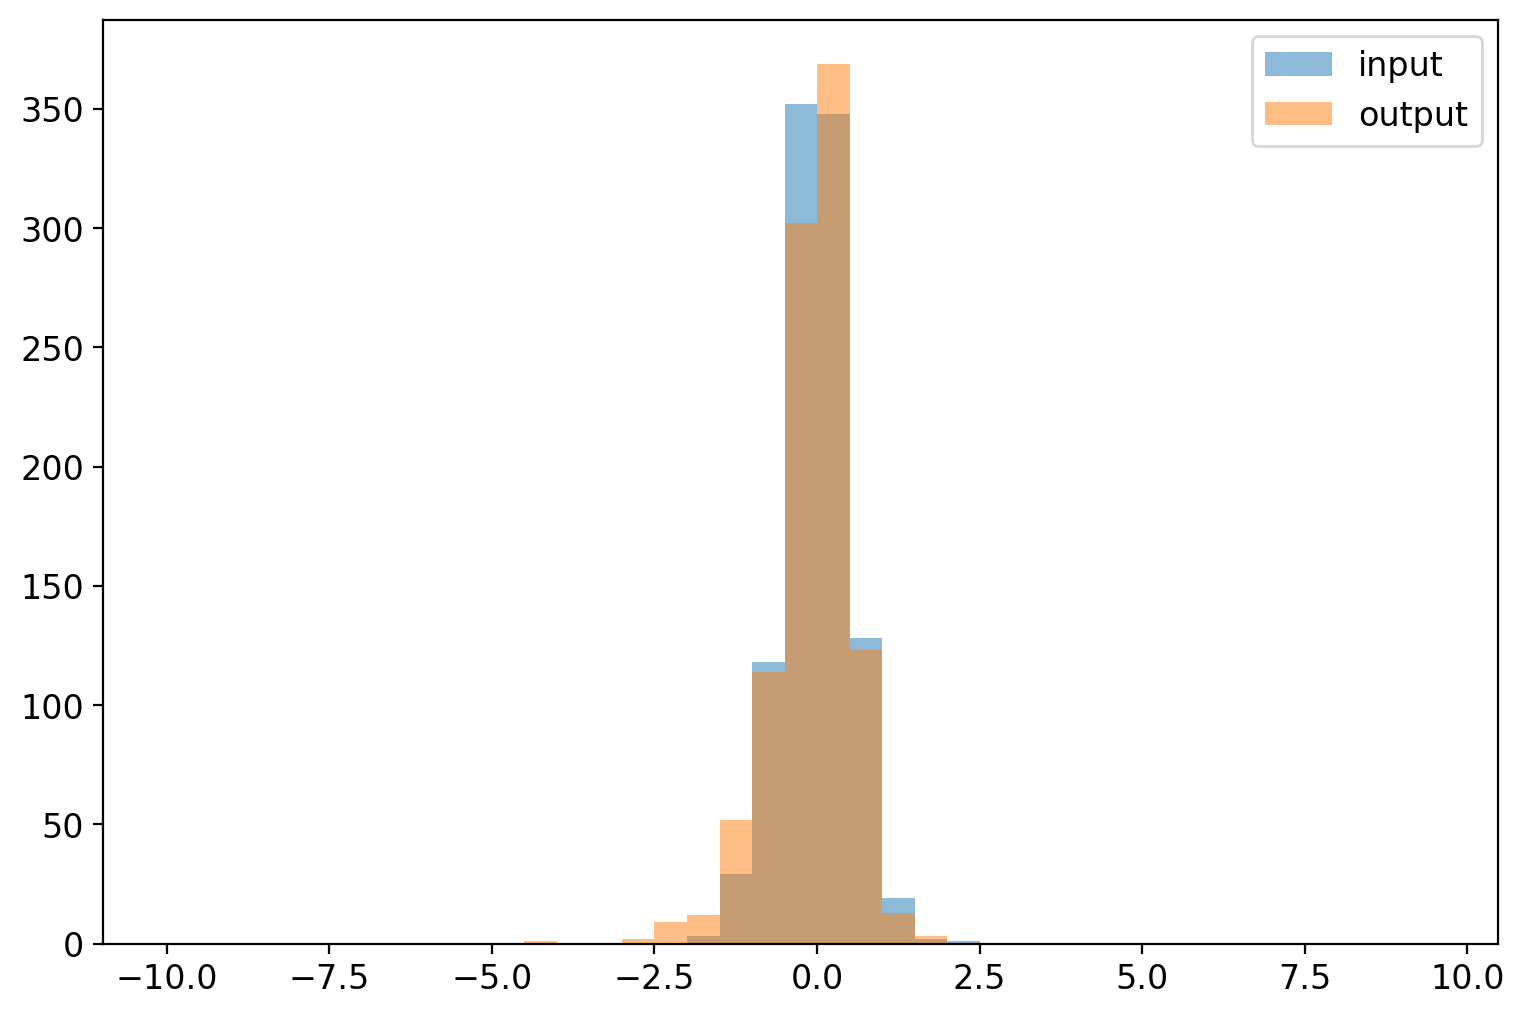

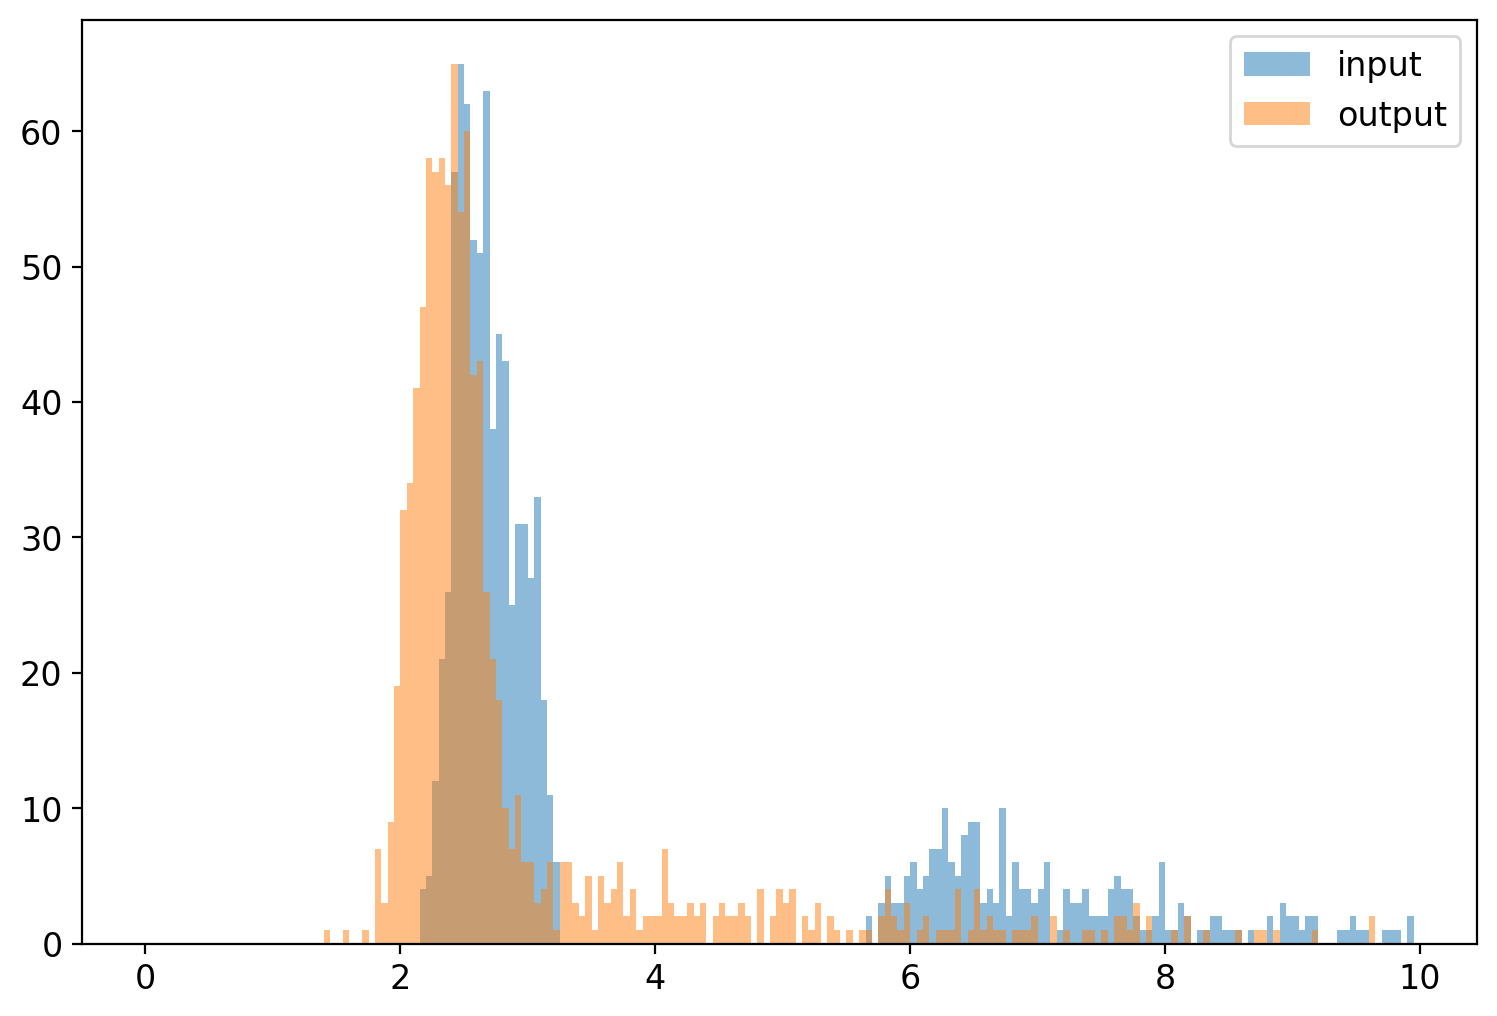

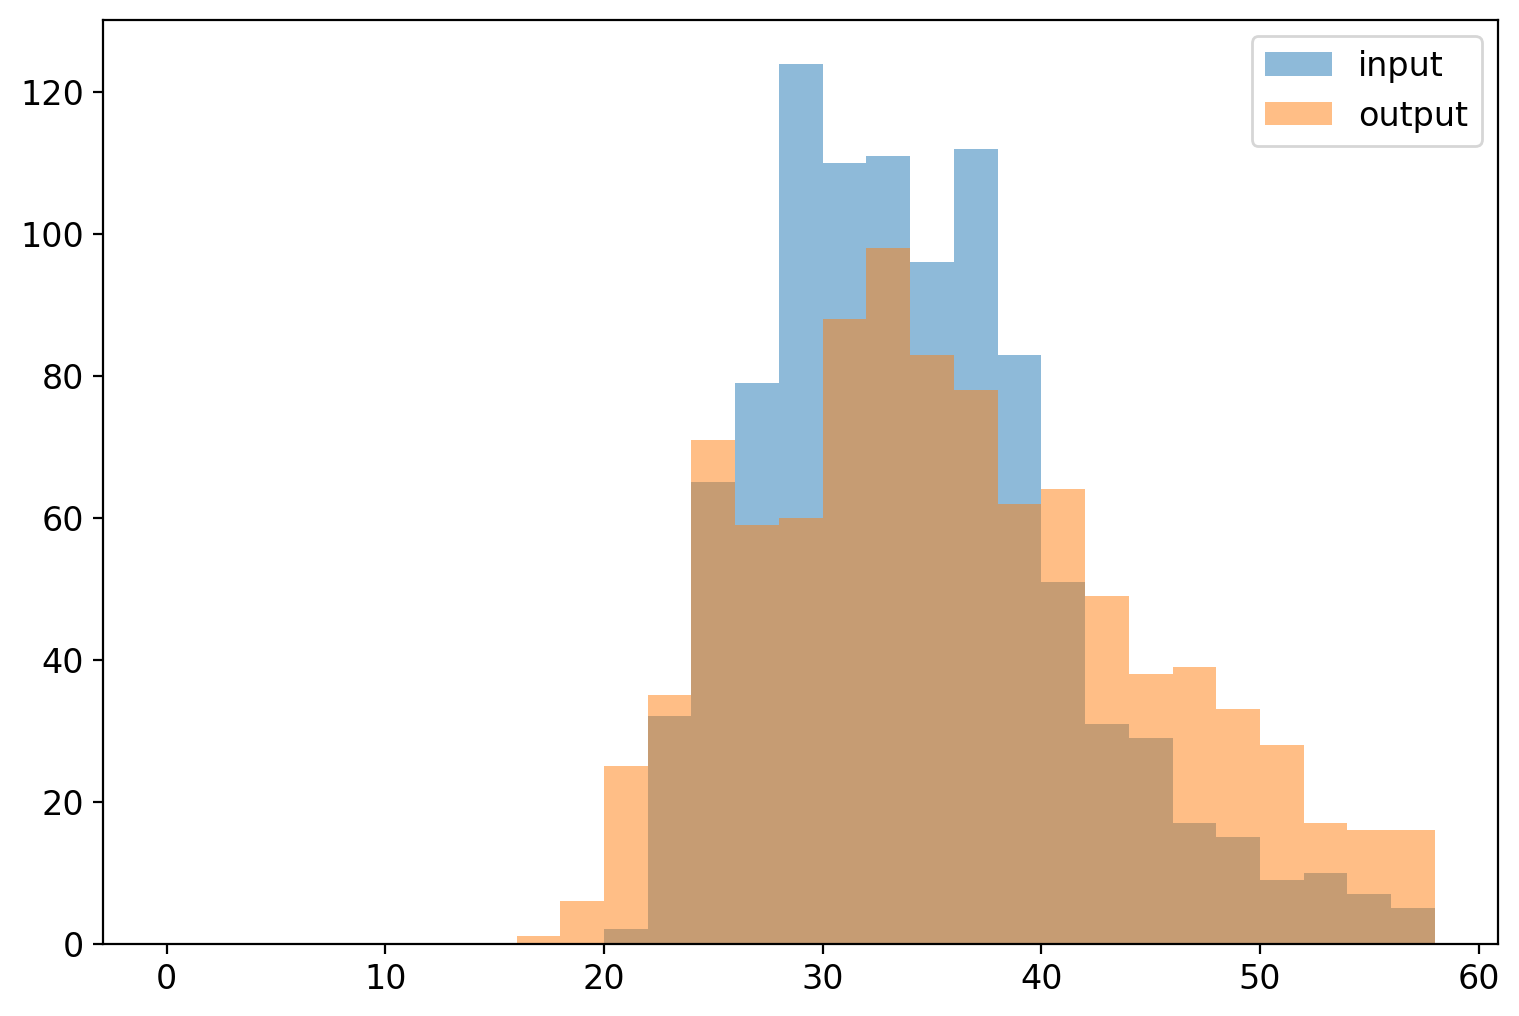

In [43]:
torch.manual_seed(0)
d = 4
vae2 = VariationalAutoEncoder(input_dims=dataset.nfeatures(),latent_dims=d)
lr = 1e-3
optim = torch.optim.Adam(vae2.parameters(), lr=lr, weight_decay=1e-5)
#train_loader = torch.utils.data.DataLoader(dataset150, batch_size=500)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=500)
num_epochs = 5001

for epoch in range(num_epochs):
    train_loss = train_epoch(vae2,train_loader,optim)
    #val_loss = test_epoch(vae,valid_loader)
    if epoch % 500 == 0:
        print('EPOCH {}/{} \t train loss {:.3f} \t'.format(epoch + 1, num_epochs,train_loss))

plotVAEOutputs(d,indataset150,vae2)

<a name='exercises_22_2'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_2) | [Next Section](#section_22_3) |


<a name='section_20_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.3 Generating Full Bragg Scattering Details </h2>  

| [Top](#section_20_0) | [Previous Section](#section_20_2) | [Exercises](#exercises_20_3) | [Next Section](#section_20_4) |

Given the success of above, lets look at our events and see if we can try to generate a fully detailed event. Recall that we actually save the energy loss, x and y positions of each proton event. We can translate this to directly to an image by considering the Z-axis as the energy deposited. Lets go ahead and try to translate this to an image, and see what it looks like.

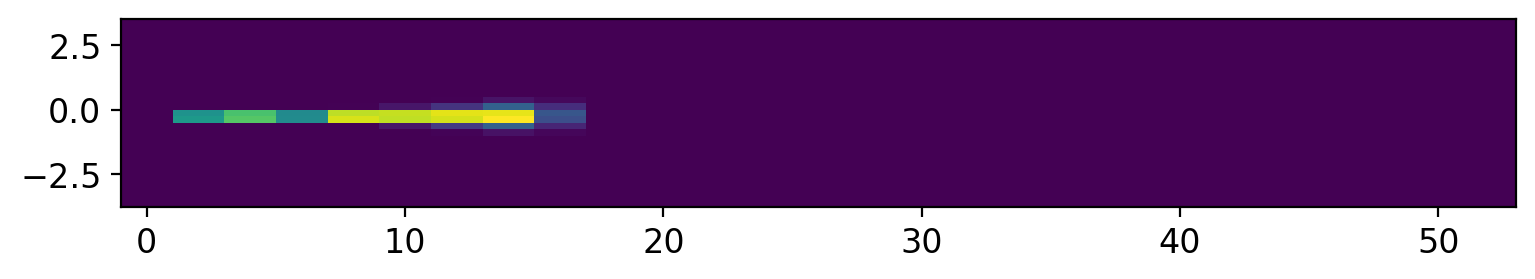

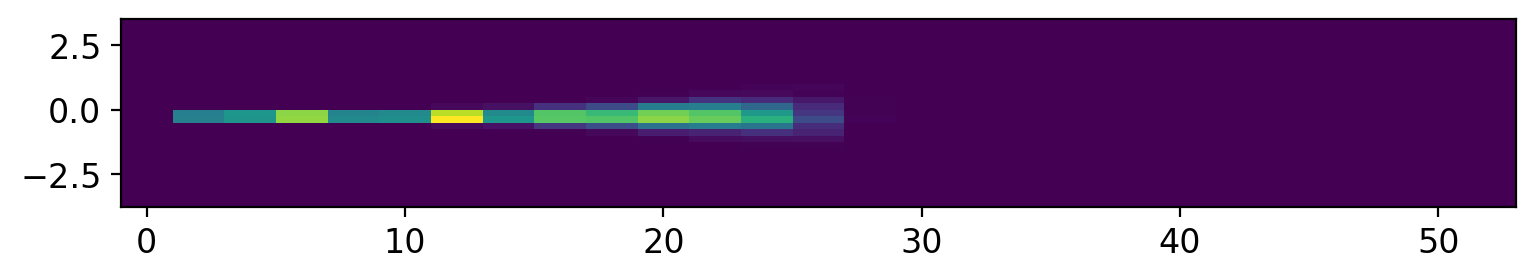

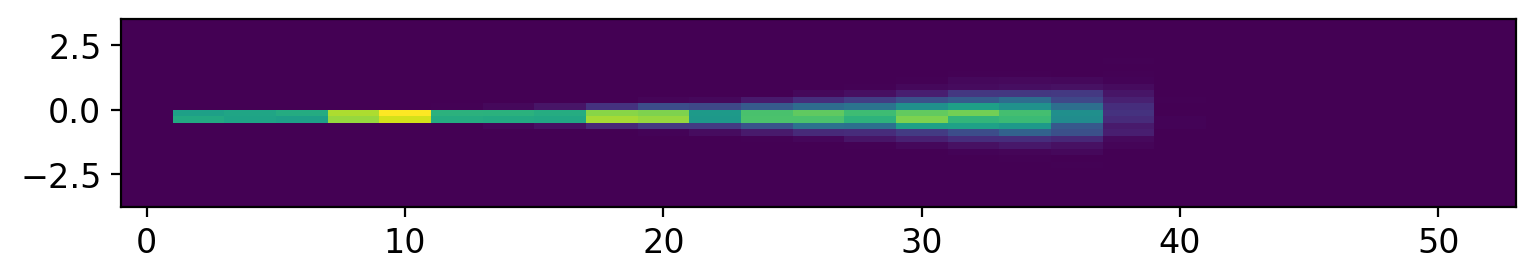

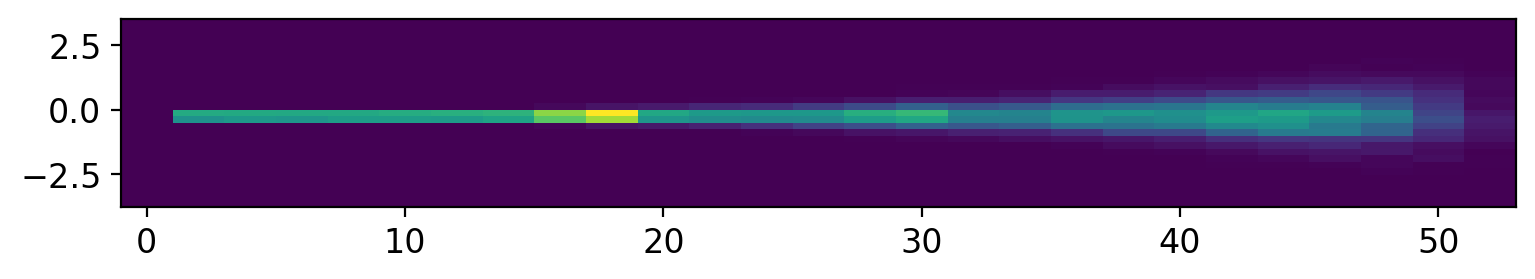

(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)


In [44]:
def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now lets make a regular image
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)


def makeImageDataSet(iE,ixstep,iestep,iystep):
    dataset=np.empty((0,1,28,28))
    for pX,pE,pY in zip(ixstep,iestep,iystep):
        xbin = np.arange(-1,57, 2)
        ybin = np.arange(-3.625, 3.625, 0.25)
        H, xedges, yedges = np.histogram2d(pX.flatten(), pY.flatten(), bins=(xbin, ybin),weights=pE.flatten())
        #H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
        #plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        #plt.show()
        H = np.reshape(H.T,(1,1,28,28))
        dataset = np.vstack((dataset,H))
    print(dataset.shape)
    Tdataset = torch.tensor(dataset).float()
    datasetout=DataSet(samples=Tdataset,labels=np.ones(dataset.shape[0])*iE)
    return datasetout,dataset

image150,dimage150=makeImageDataSet(1.50,xstep150,estep150,ystep150)
image200,dimage200=makeImageDataSet(2.00,xstep200,estep200,ystep200)
image250,dimage250=makeImageDataSet(2.50,xstep250,estep250,ystep250)
image300,dimage300=makeImageDataSet(3.00,xstep300,estep300,ystep300)

Now from this lets go ahead and make a VAE that describes our dataset. We can exploit the VAE architecture used above, just slightly tweaked.

In [45]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear3(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z


    def decoder(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

torch.manual_seed(0)
d = 4
vae = VariationalAutoEncoder(latent_dims=d)
lr = 1e-2
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(image150, batch_size=500)

In [46]:
def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      vae.eval()
      #encoder.eval()
      #decoder.eval()
      with torch.no_grad():
         rec_img  = vae.decoder(vae.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()



 EPOCH 1/2500 	 train loss 4174.038 	 val loss 0.000


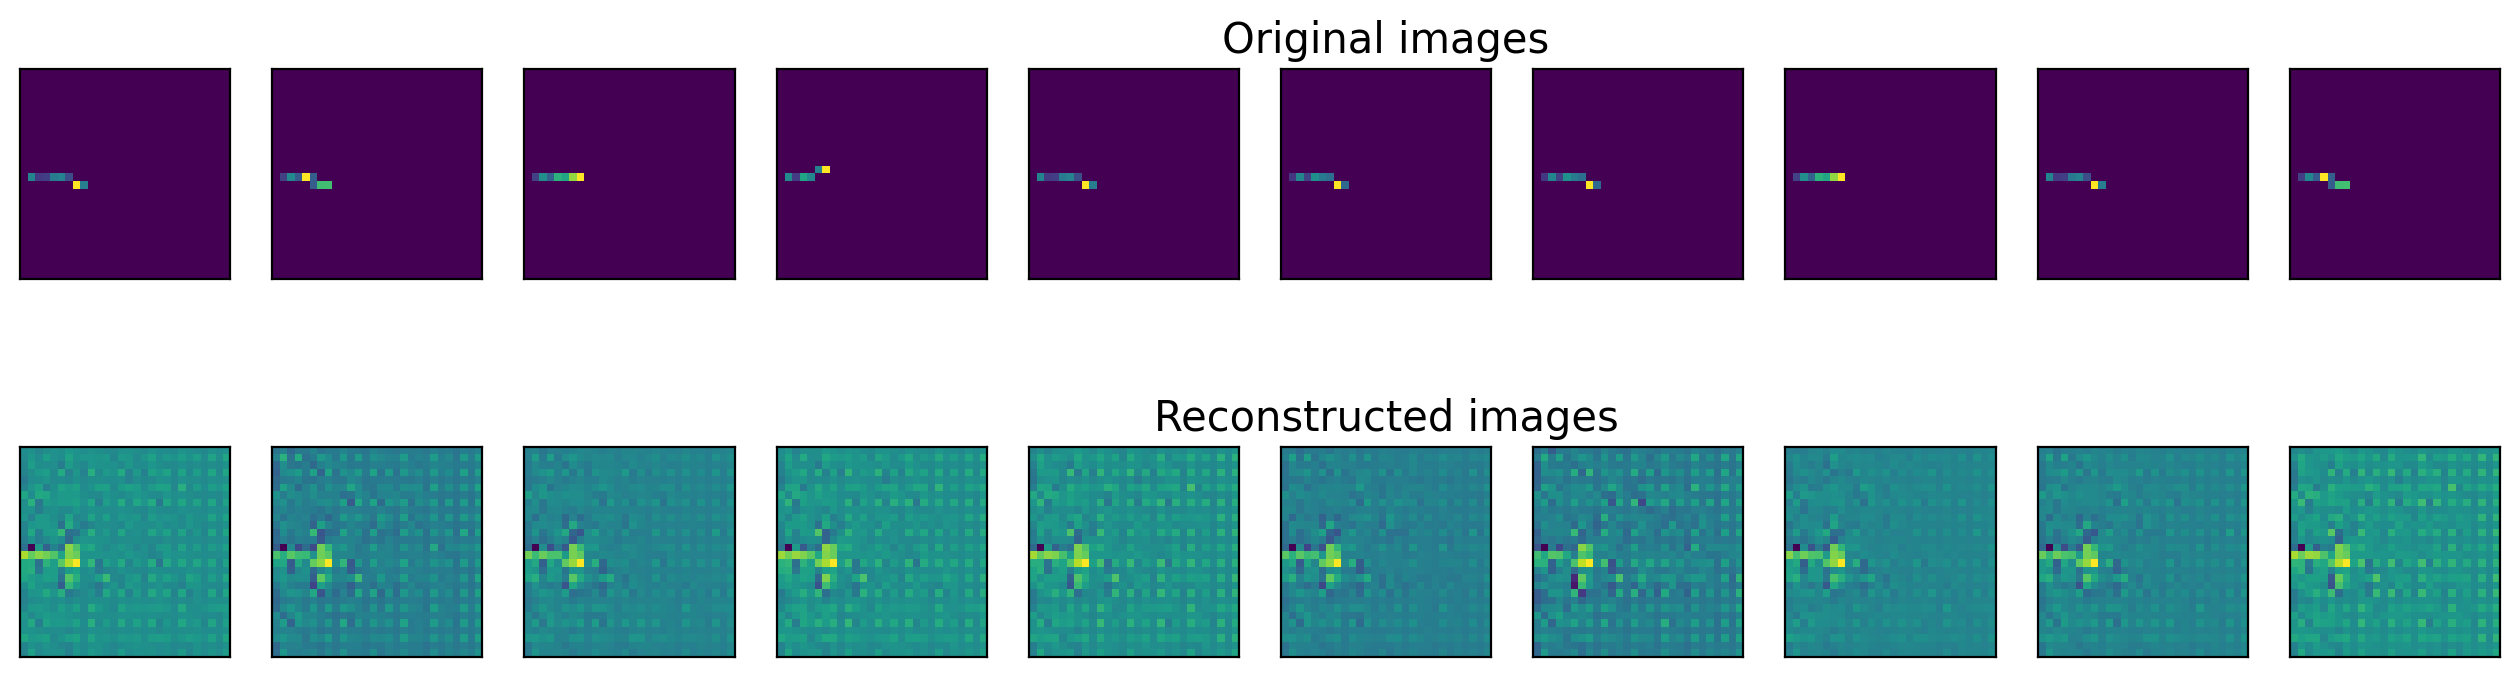


 EPOCH 501/2500 	 train loss 92.977 	 val loss 0.000


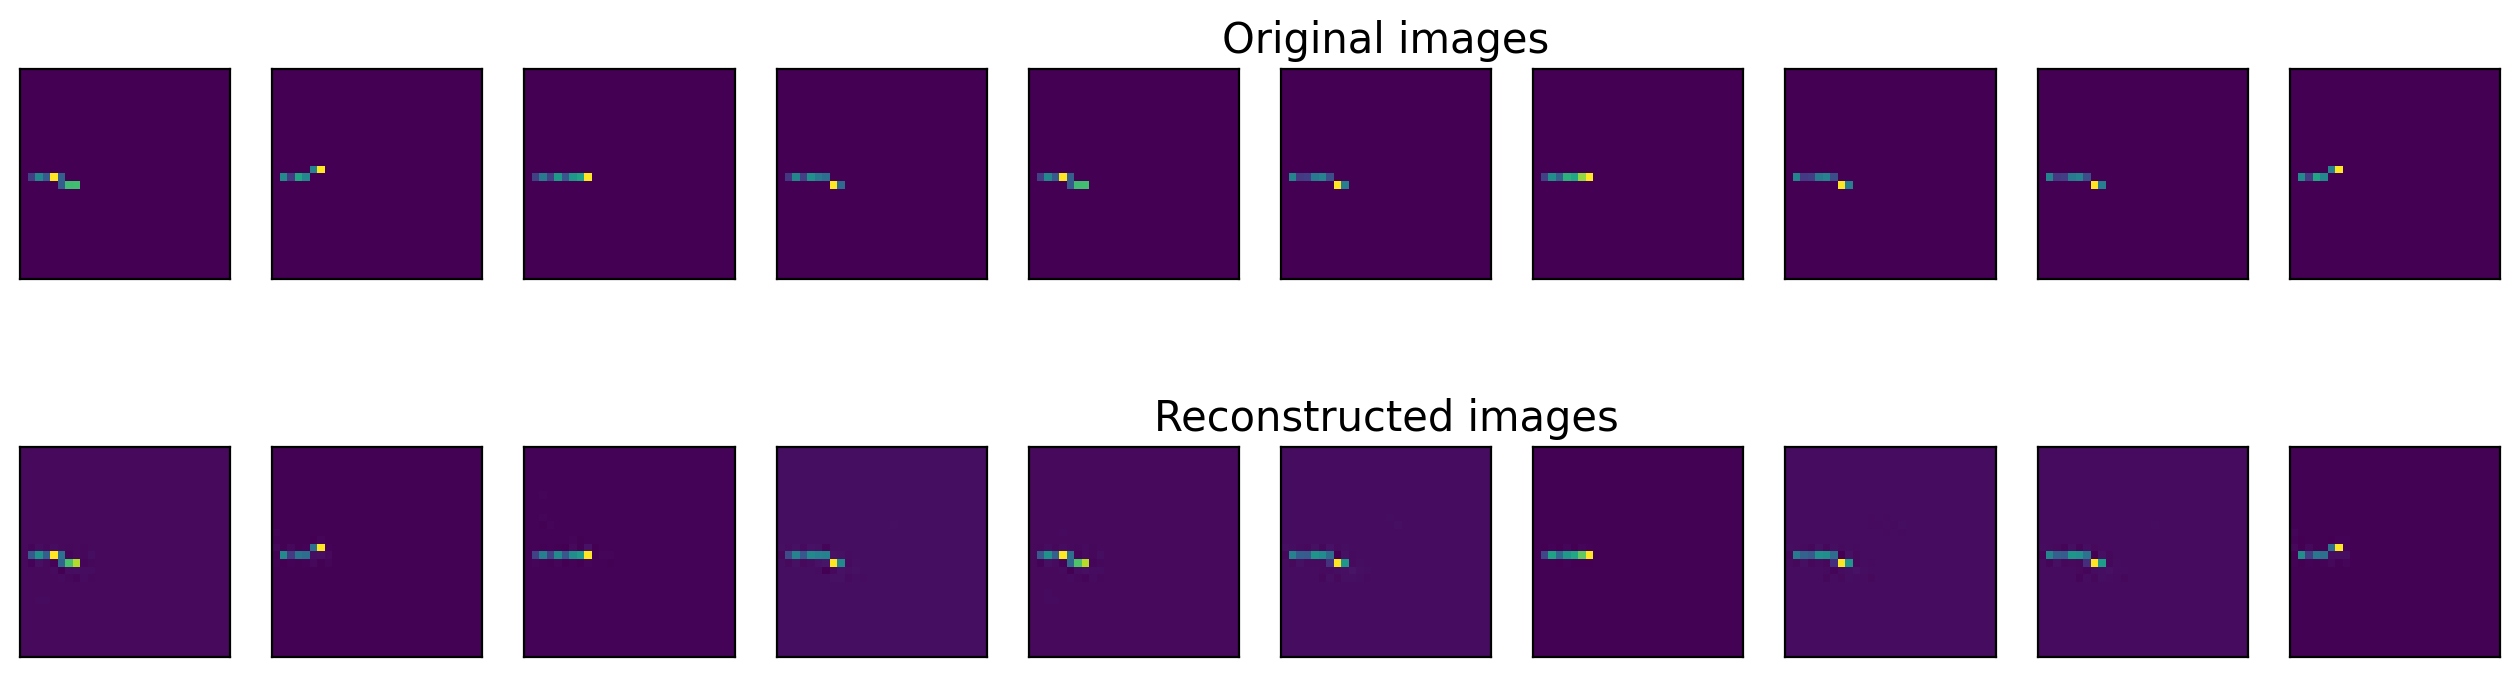


 EPOCH 1001/2500 	 train loss 62.535 	 val loss 0.000


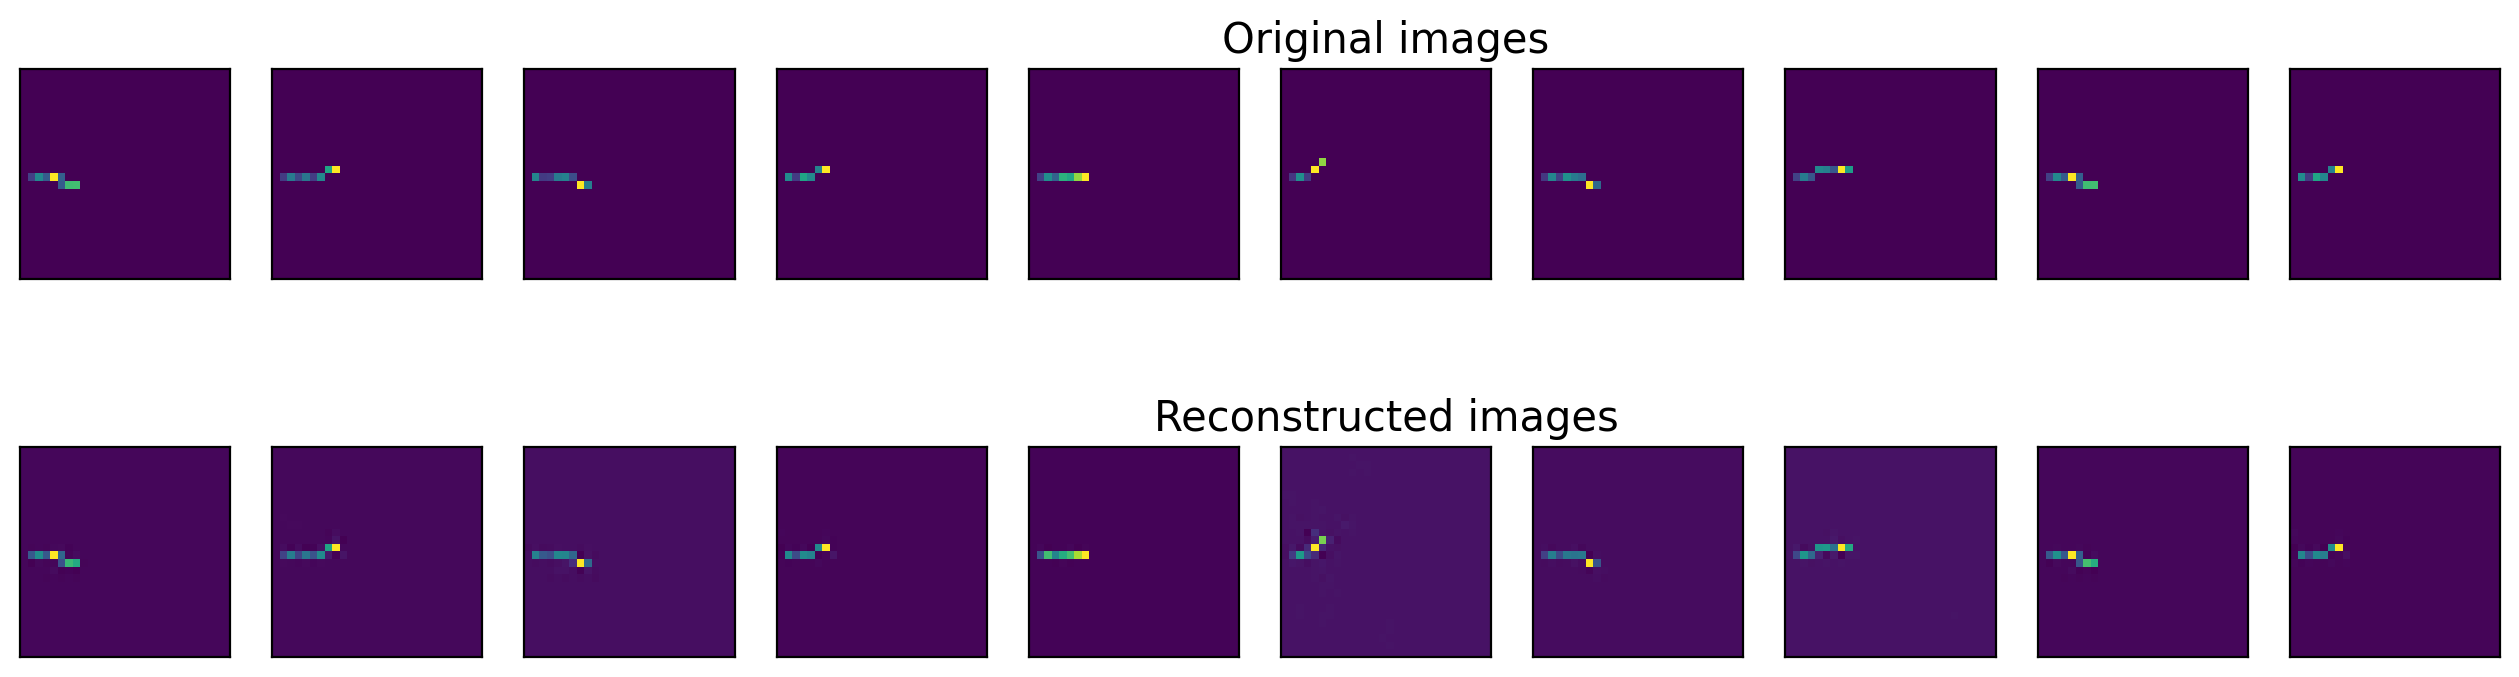


 EPOCH 1501/2500 	 train loss 54.949 	 val loss 0.000


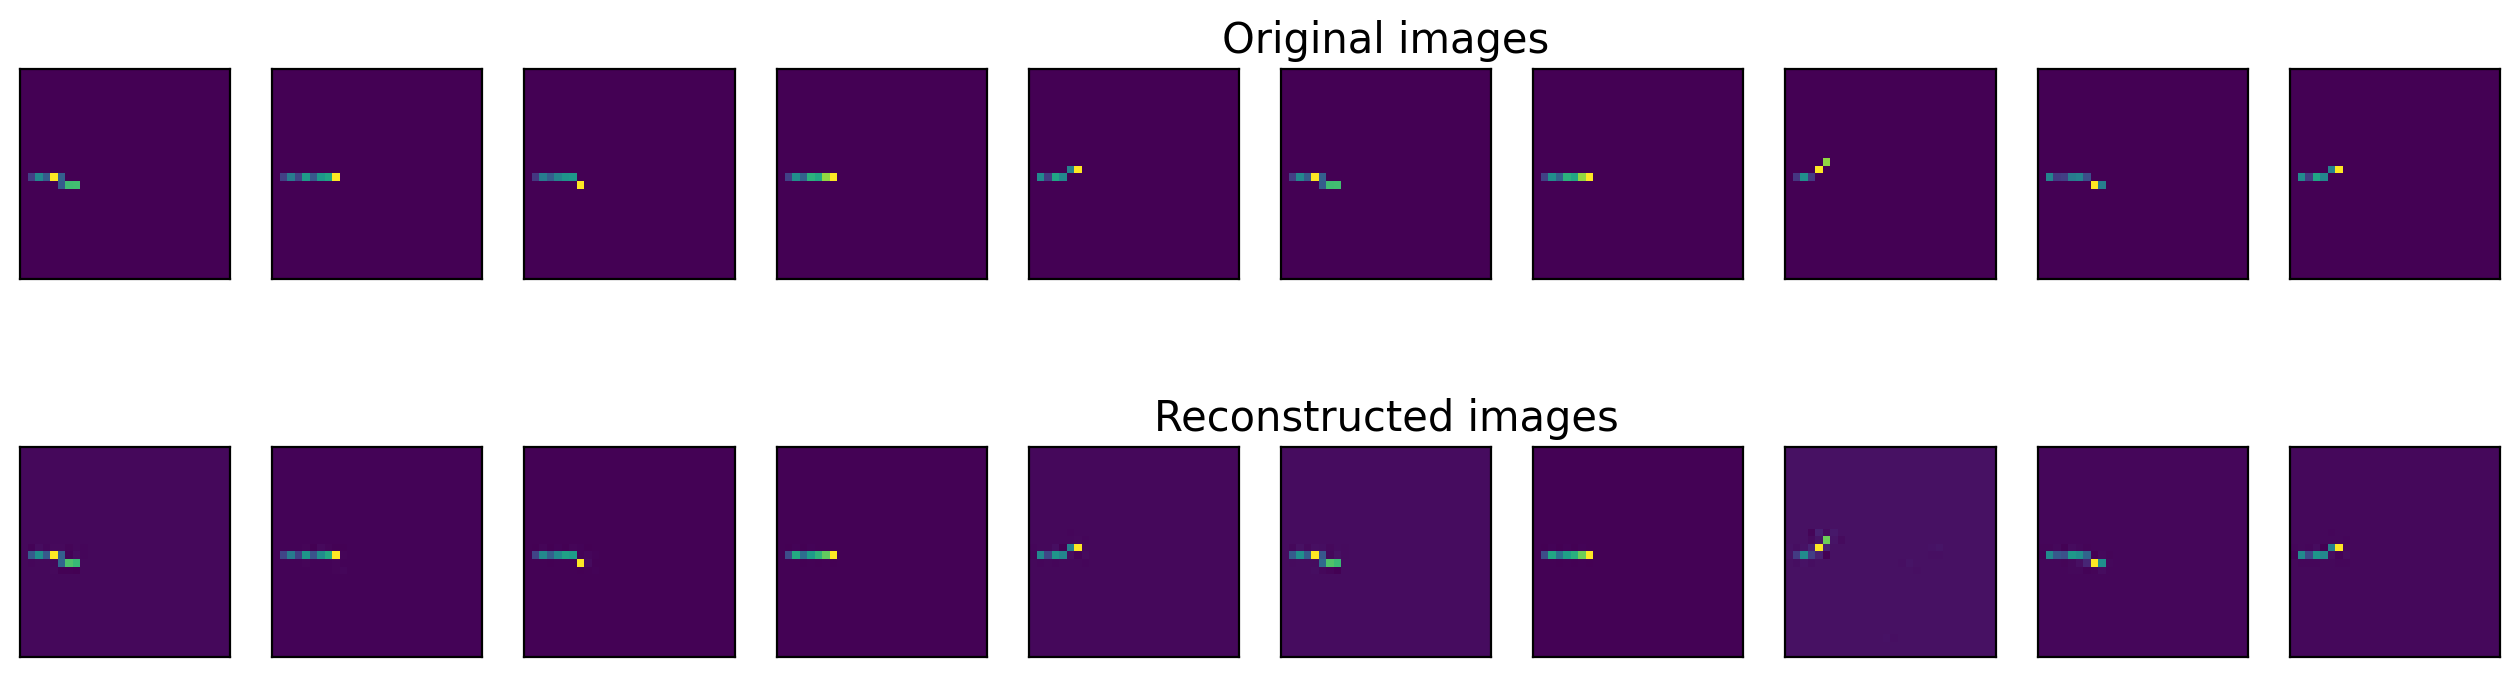


 EPOCH 2001/2500 	 train loss 45.514 	 val loss 0.000


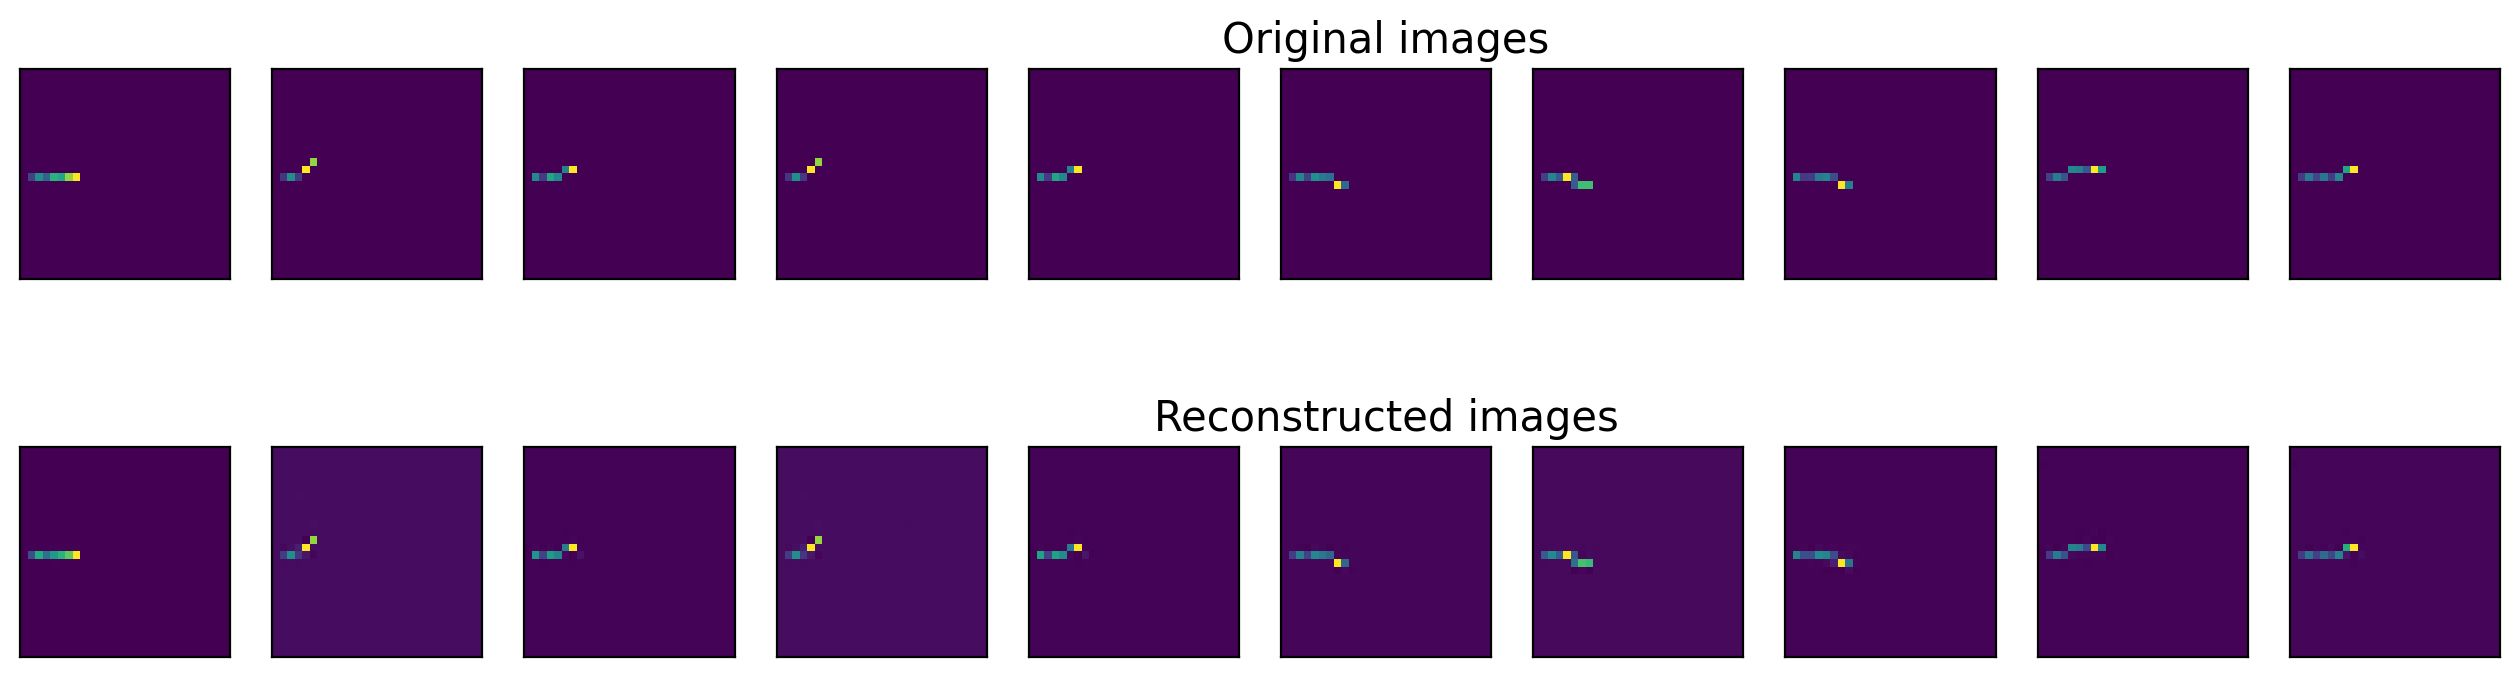

In [47]:
num_epochs = 2500

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,train_loader,optim)
    val_loss=0
    if epoch % 500 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,vae,n=10)

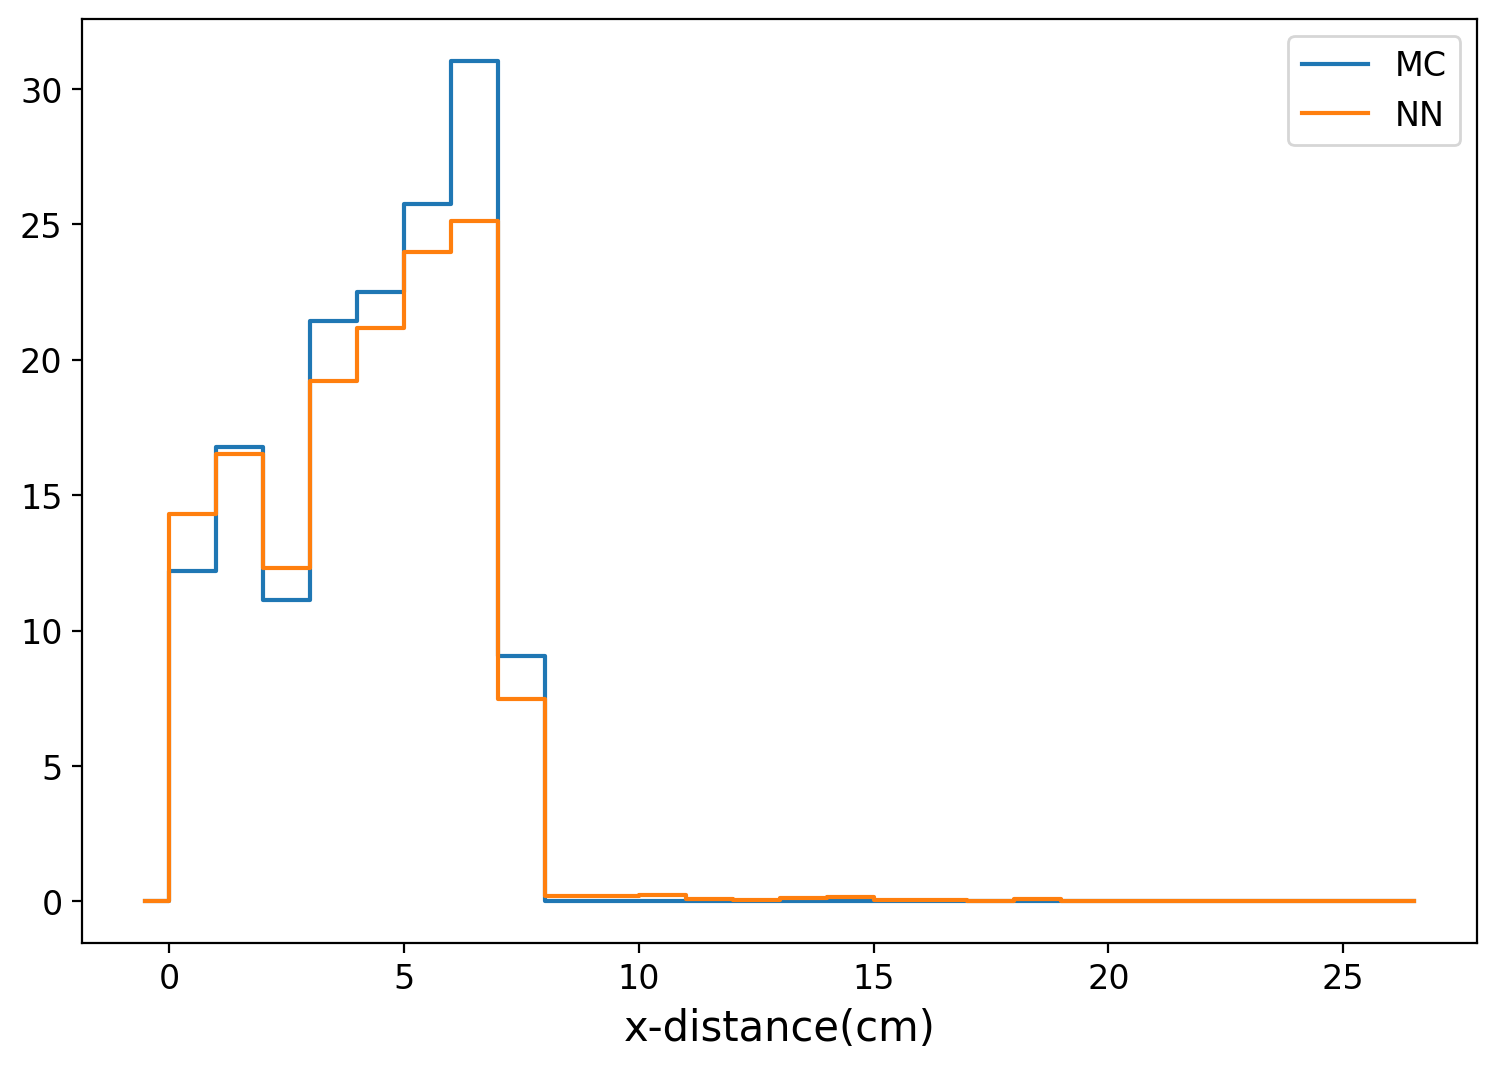

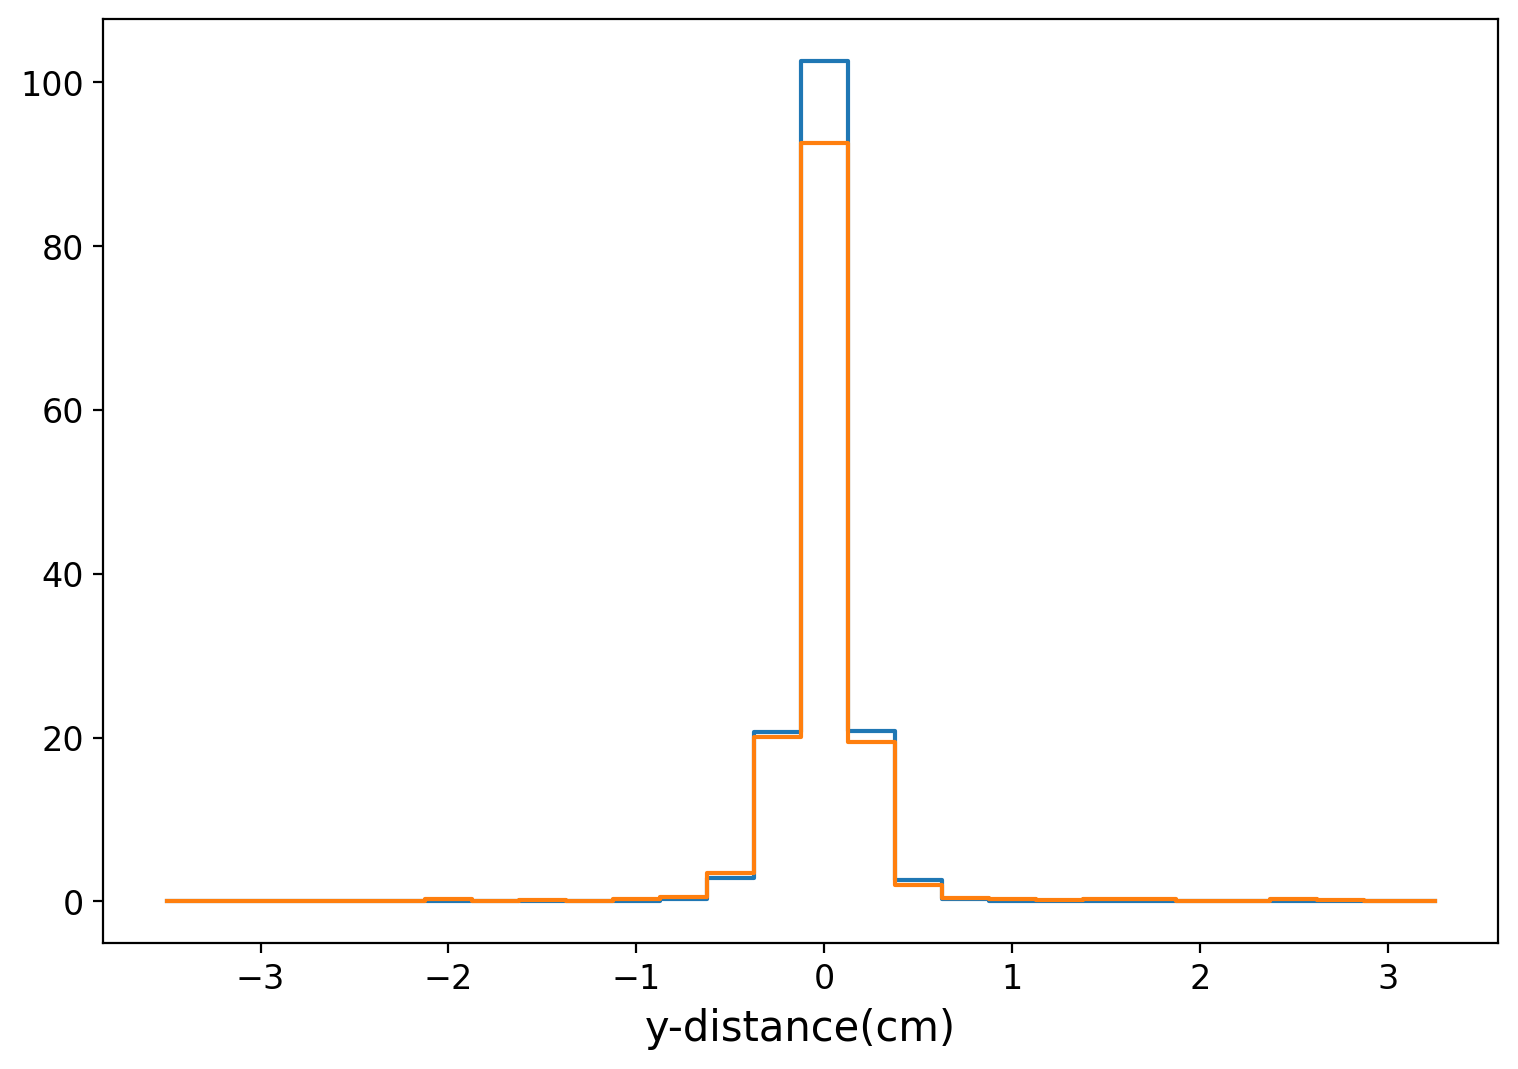

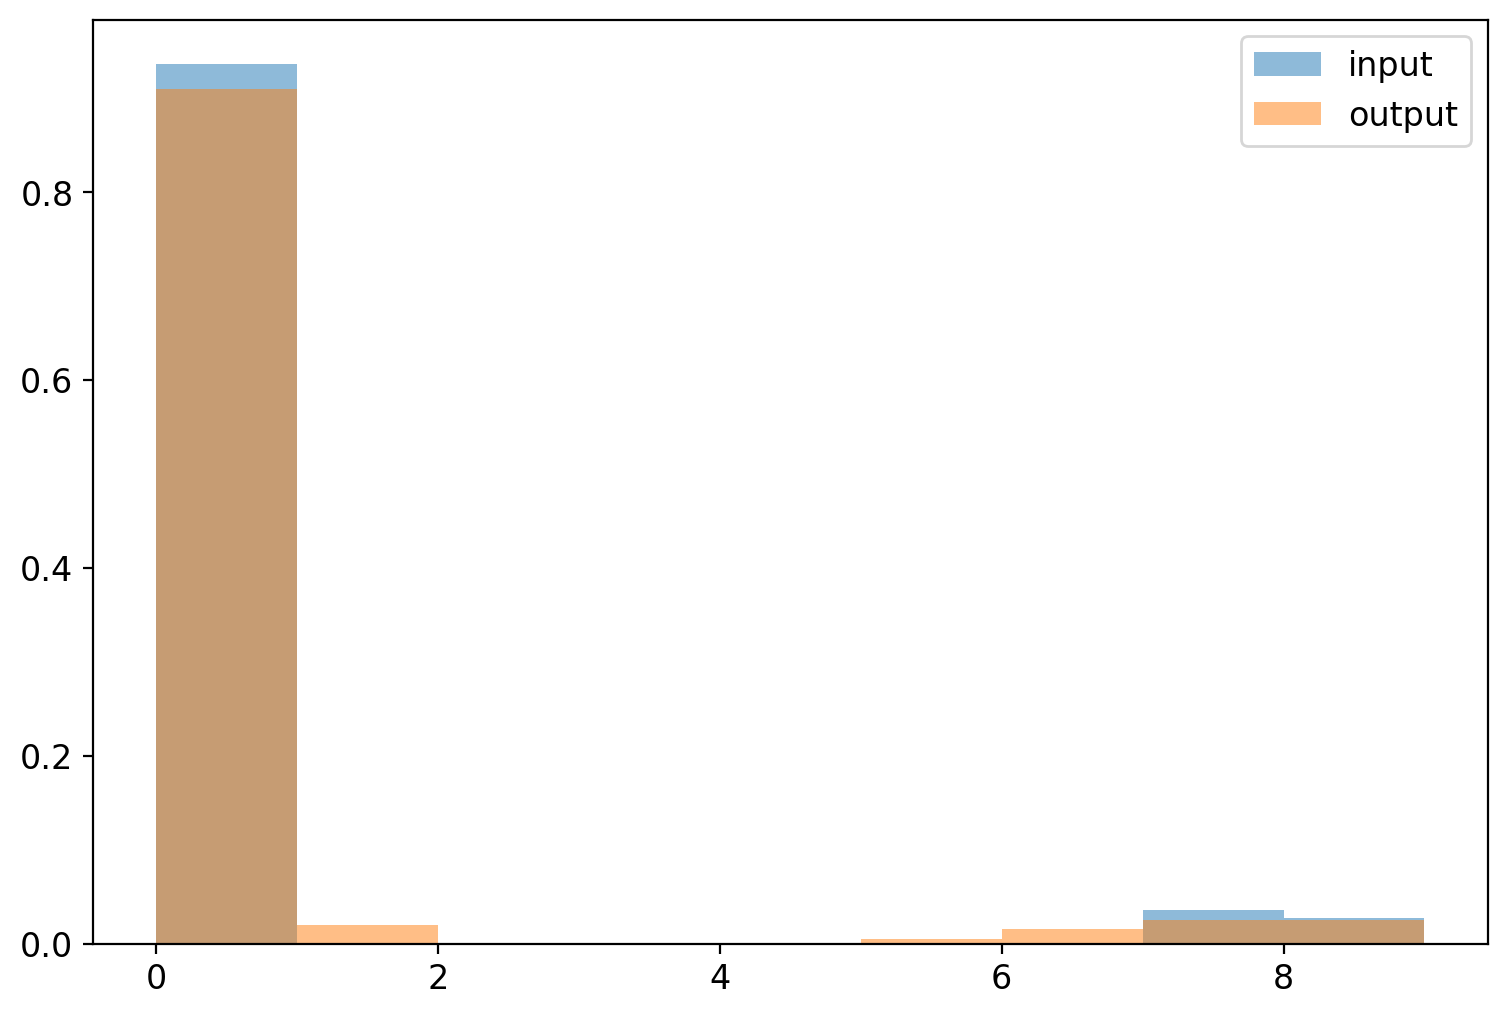

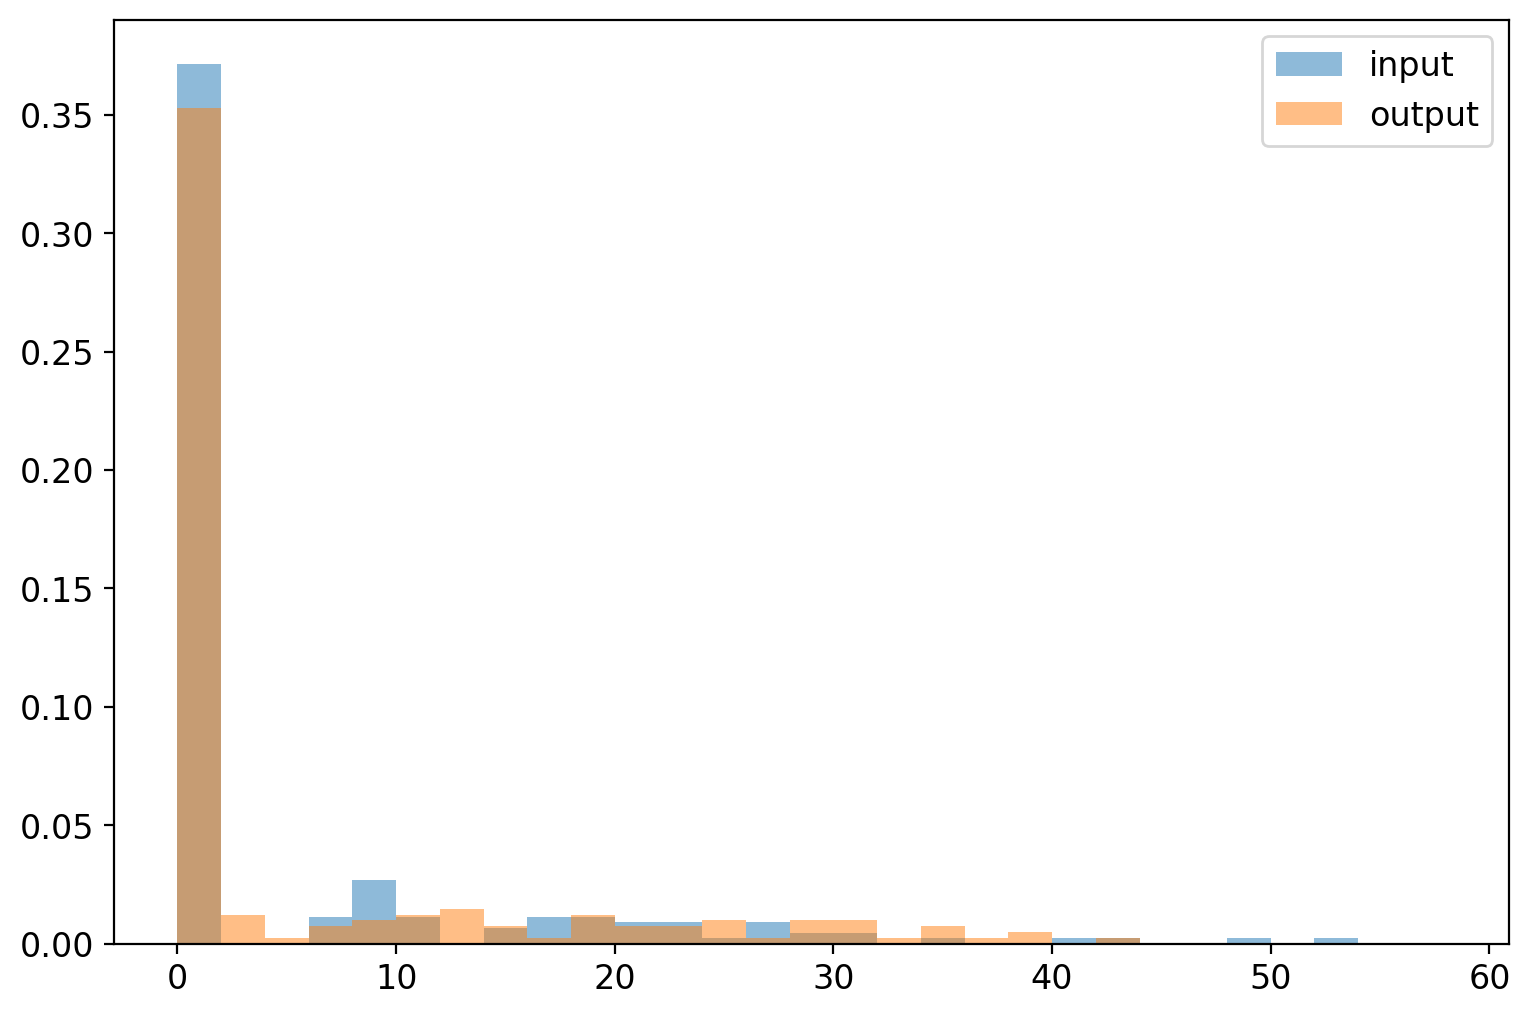

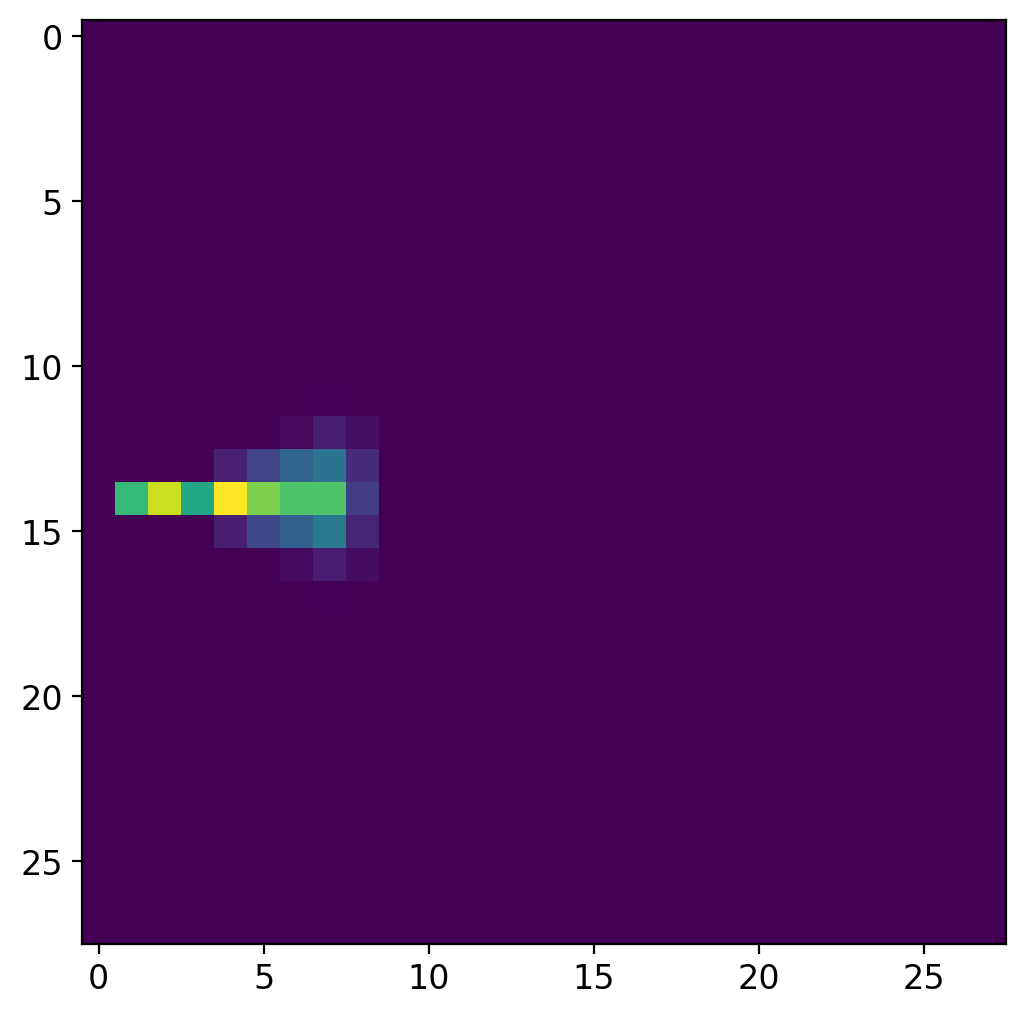

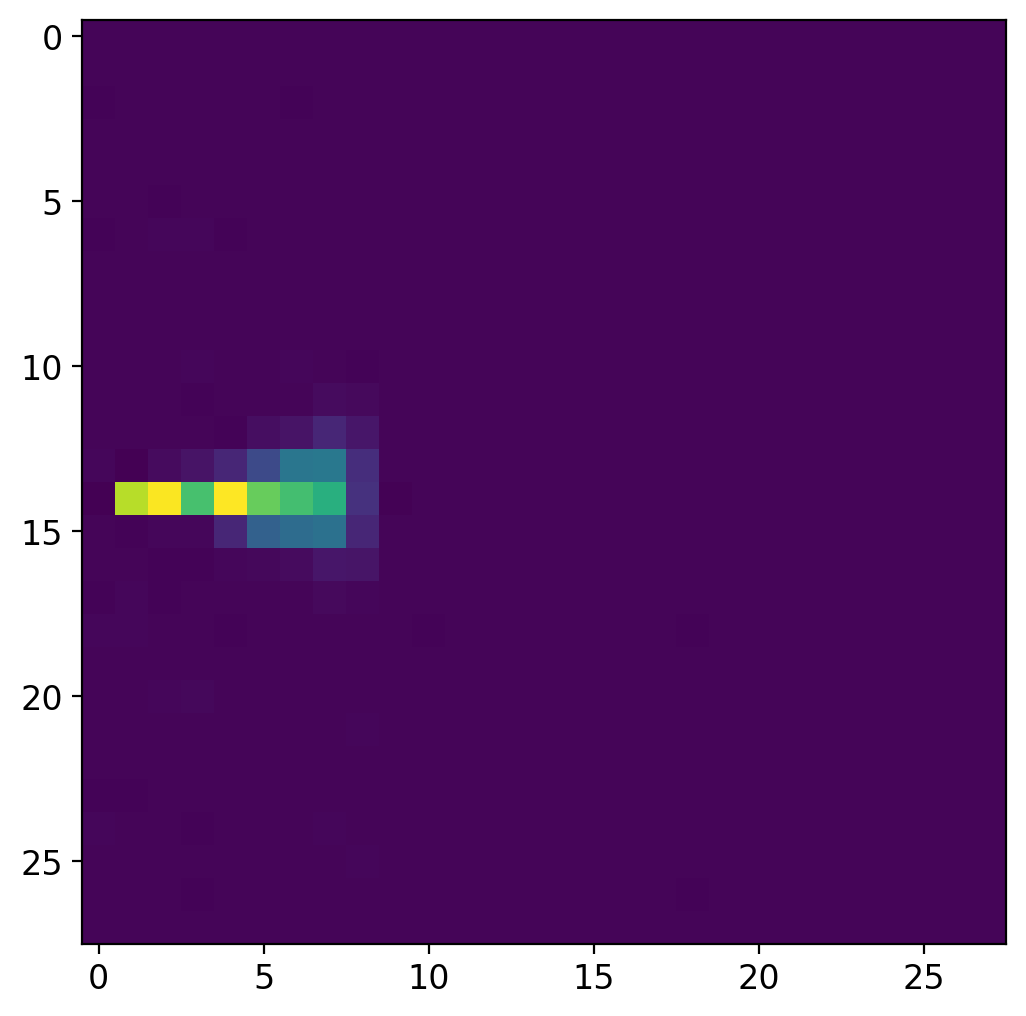

In [48]:
def plotVAEImageOutputs(iLatentDim,iDataSet):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    rec_img  = vae.decoder(testlatent)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.legend()
    plt.xlabel('x-distance(cm)')
    plt.show()


    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,10,1)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[12:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[12:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

#dimage150_avg = np.mean(dimage150,axis=0)
#plt.imshow(dimage150_avg[0])
#plt.show()
#dimage150_tmp = np.mean(dimage150,axis=0)
#plt.imshow(dimage150[0][0])
#plt.show()
#test=np.mean(np.sum(dimage150,axis=3),axis=0)
plotVAEImageOutputs(d,dimage150)
torch.save(vae.state_dict(), 'vae_150.pt')

<a name='exercises_22_3'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_3) | [Next Section](#section_22_4) |


<a name='section_20_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.4 Conditional VAEs allowing for energy based generation </h2>  



| [Top](#section_20_0) | [Previous Section](#section_20_3) | [Exercises](#exercises_20_4) | [Next Section](#section_20_5) |

Now that we have created a basica VAE that captures most of the features that our Monte Carlo Simulation does, lets go ahead and now train for all of our beam energies.

Training with all of the beam energies is a bit trickier, because we would like to embed our knowledge of the energy into the VAE so that we can decode our setup with the knowledge of the beam energy. We can think of this as
our decorder $d(x)$ now needs to be conditional on the beam energy. We can write this as:

$$
d\left(x|E\right) = f_{NN}\left(\mathcal{N}(\vec{x}|\vec{\sigma}),E\right)
$$

Where $f_{NN}$ is our neural network, which now takes in the sampled distribution, and the energy. The scheme here is that  we are adding Energy to our latent space as an additional input that we do not sample. This construction is known as a conditional VAE, since now the latent space construction changes conditioned on the beam energy. Let's take a look at the architecture.

In [49]:
class CondVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(CondVariationalAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1  = nn.Linear(3*3*32, 64)
        self.linear1a = nn.Linear(64, 8)
        self.linear1b = nn.Linear(9,  8)
        self.linear2 = nn.Linear(8, latent_dims)
        self.linear3 = nn.Linear(8, latent_dims)

        #Now we need sample in phase space
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims+1, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )


    def encoder(self, x, c): #c is our condition
        x = F.relu(self.conv1(x))
        #x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear1a(x))
        x = torch.hstack((x,c))
        x = F.relu(self.linear1b(x))
        mu =  self.linear2(x) #Mean in the gaussian space with the condition
        sigma = torch.exp(self.linear3(x)) #sigma in the space with the condition
        z = mu + sigma*self.N.sample(mu.shape) #smear
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z


    def decoder(self, x, c):
        x = torch.hstack((x,c))
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


    def forward(self, x, c):
        z = self.encoder(x, c)
        return self.decoder(z, c)

torch.manual_seed(0)
d = 6
cvae_proton_image = CondVariationalAutoEncoder(latent_dims=d)
lr = 1e-2
optim = torch.optim.Adam(cvae_proton_image.parameters(), lr=lr, weight_decay=1e-5)
from torch.utils.data import ConcatDataset
megeimage=ConcatDataset([image150, image200,image250,image300])
train_loader = torch.utils.data.DataLoader(megeimage, batch_size=500)
#from torchsummary import summary
#summary(cvae_proton_image, ((1, 28, 28),1))

Note the subtlelties here. For this setup, we are feeding the condition in at a few different points. The condition comes in before the latent space is constructed. The condition also comes into the decoder. The point being here is that we know the condition and so we have the liberty to put this in whereever we want.

Let's go ahead and train it. We will have to rewrite the functions for training from above, so we put them down here:


 EPOCH 1/500 	 train loss 4853.697 	 val loss 0.000


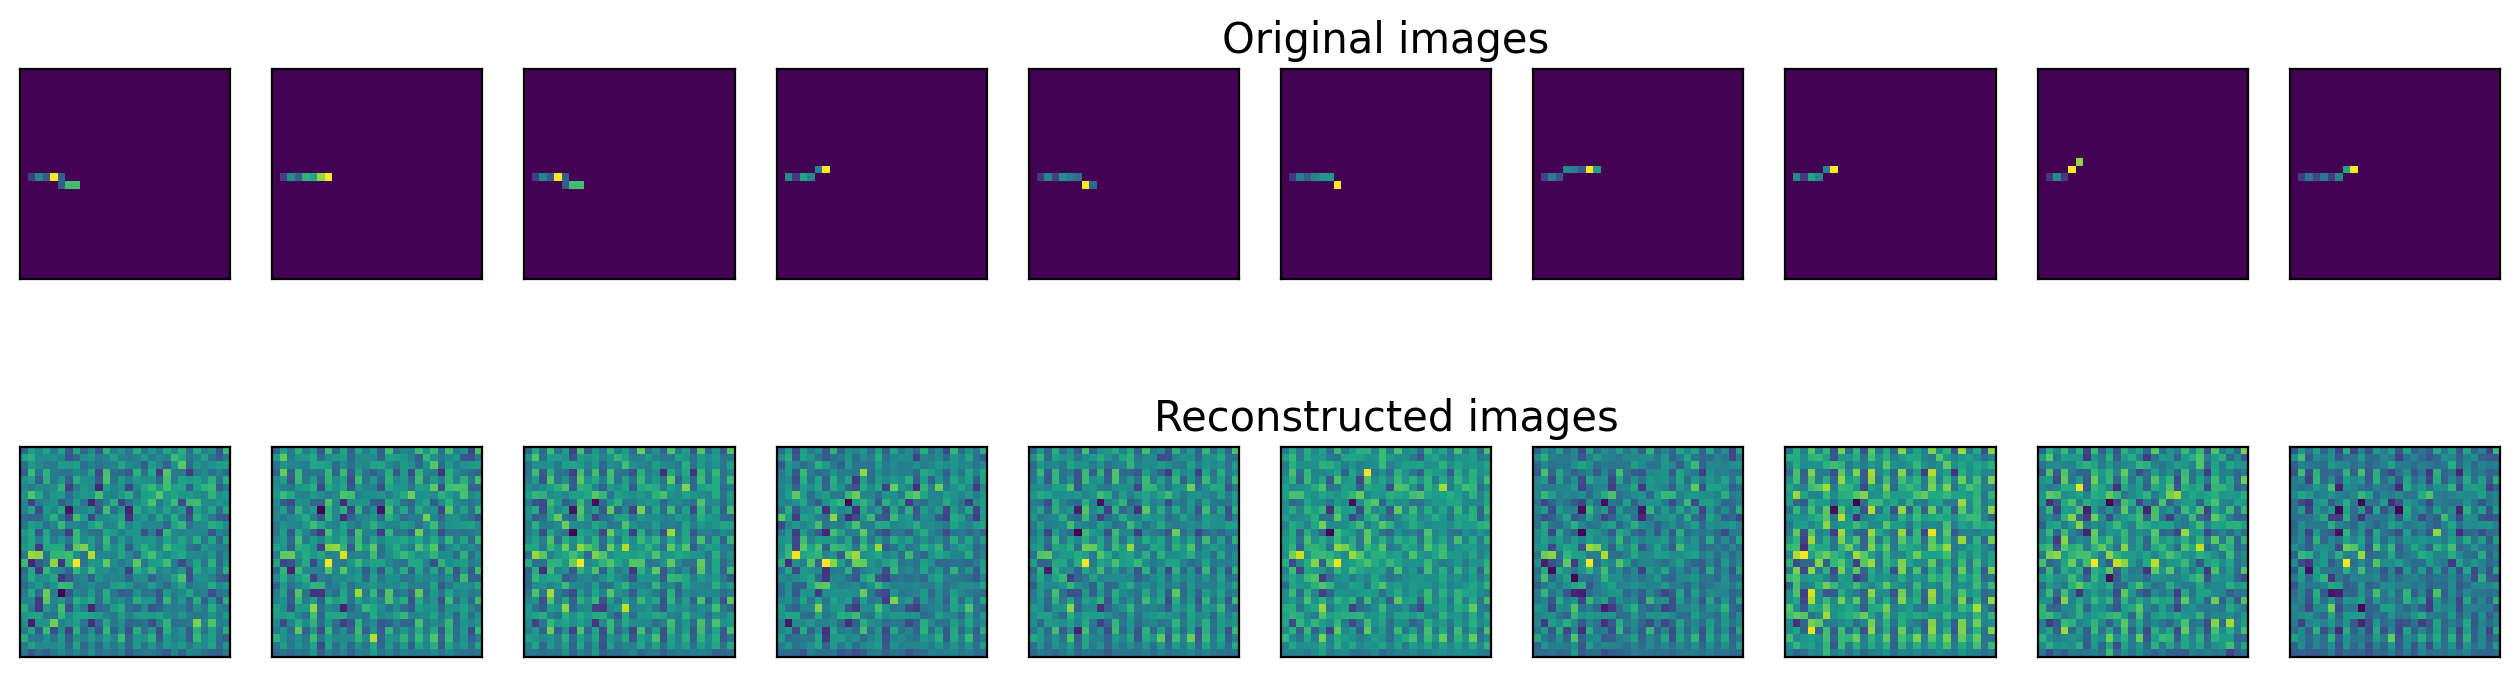


 EPOCH 51/500 	 train loss 2695.452 	 val loss 0.000


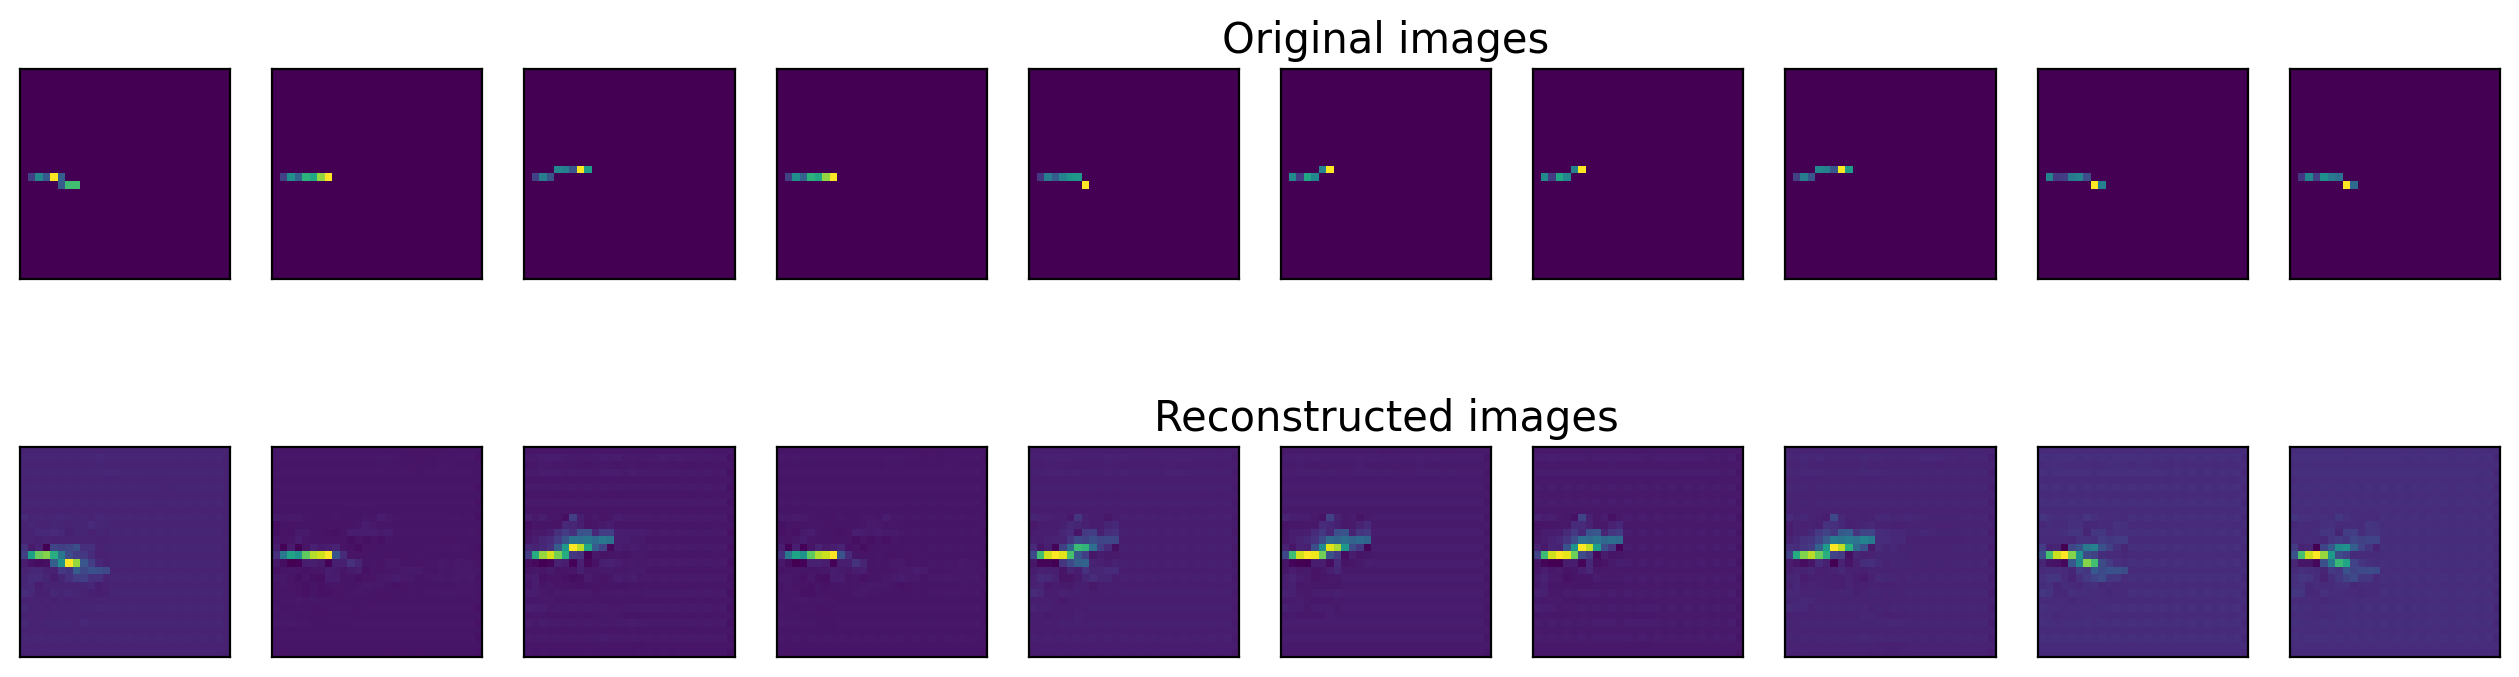


 EPOCH 101/500 	 train loss 1958.915 	 val loss 0.000


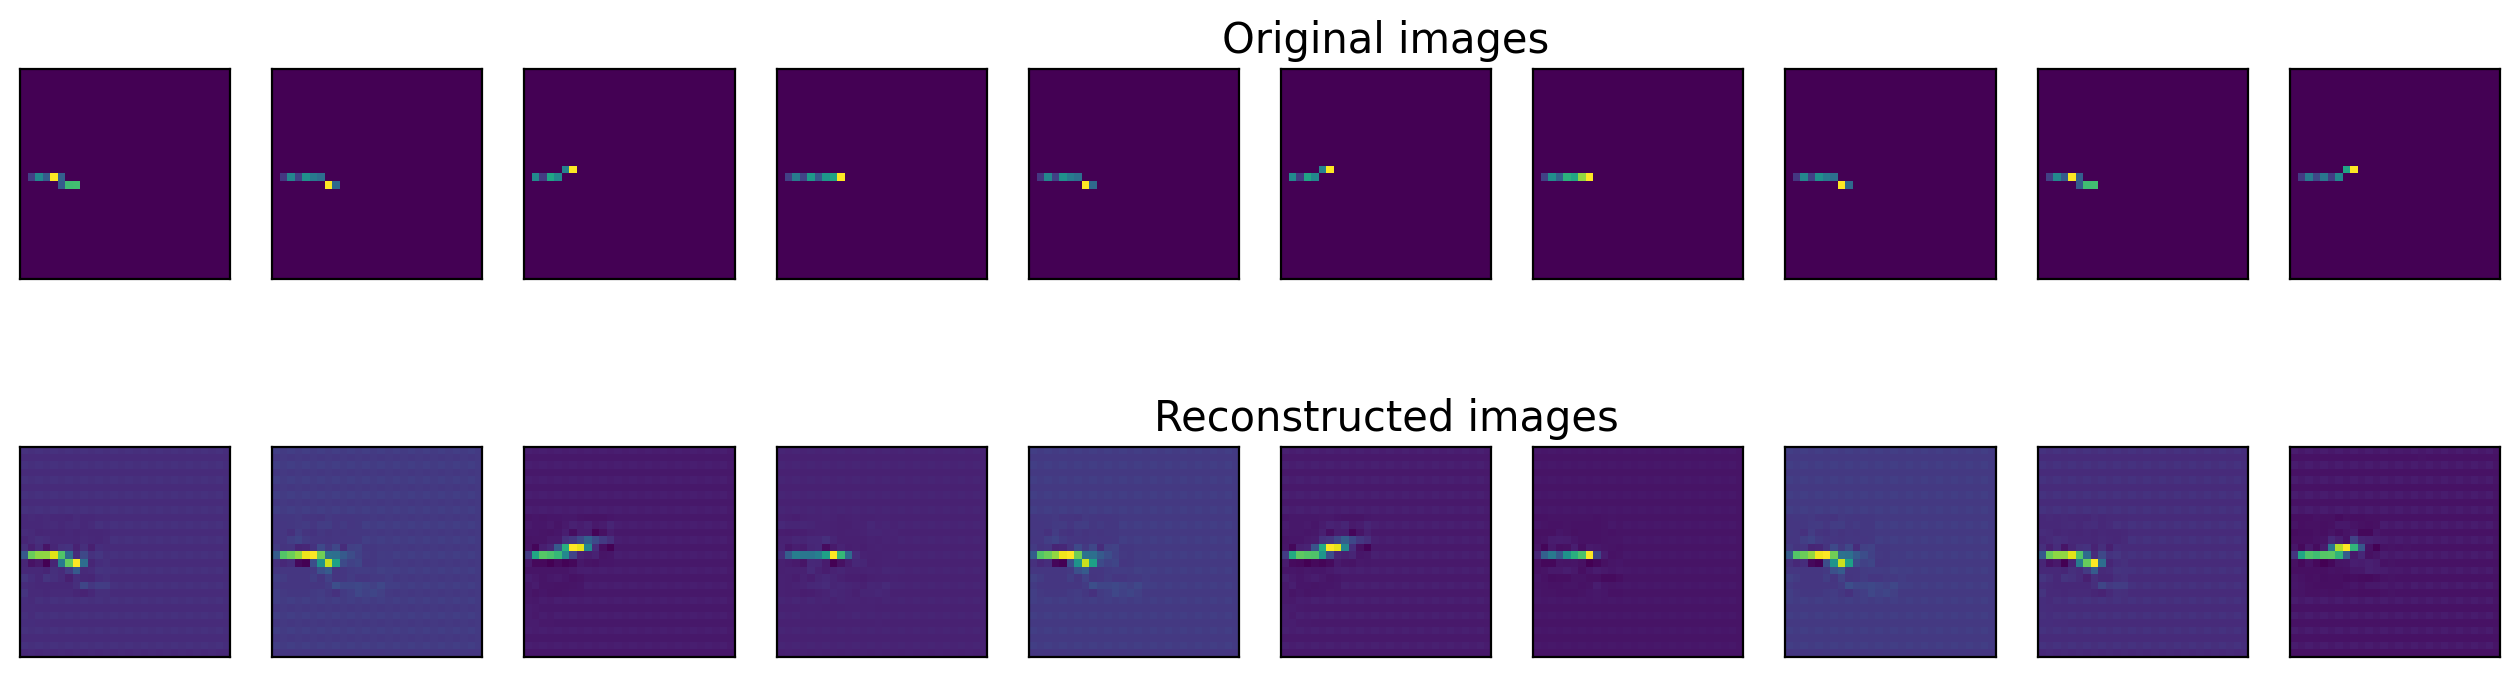


 EPOCH 151/500 	 train loss 1805.683 	 val loss 0.000


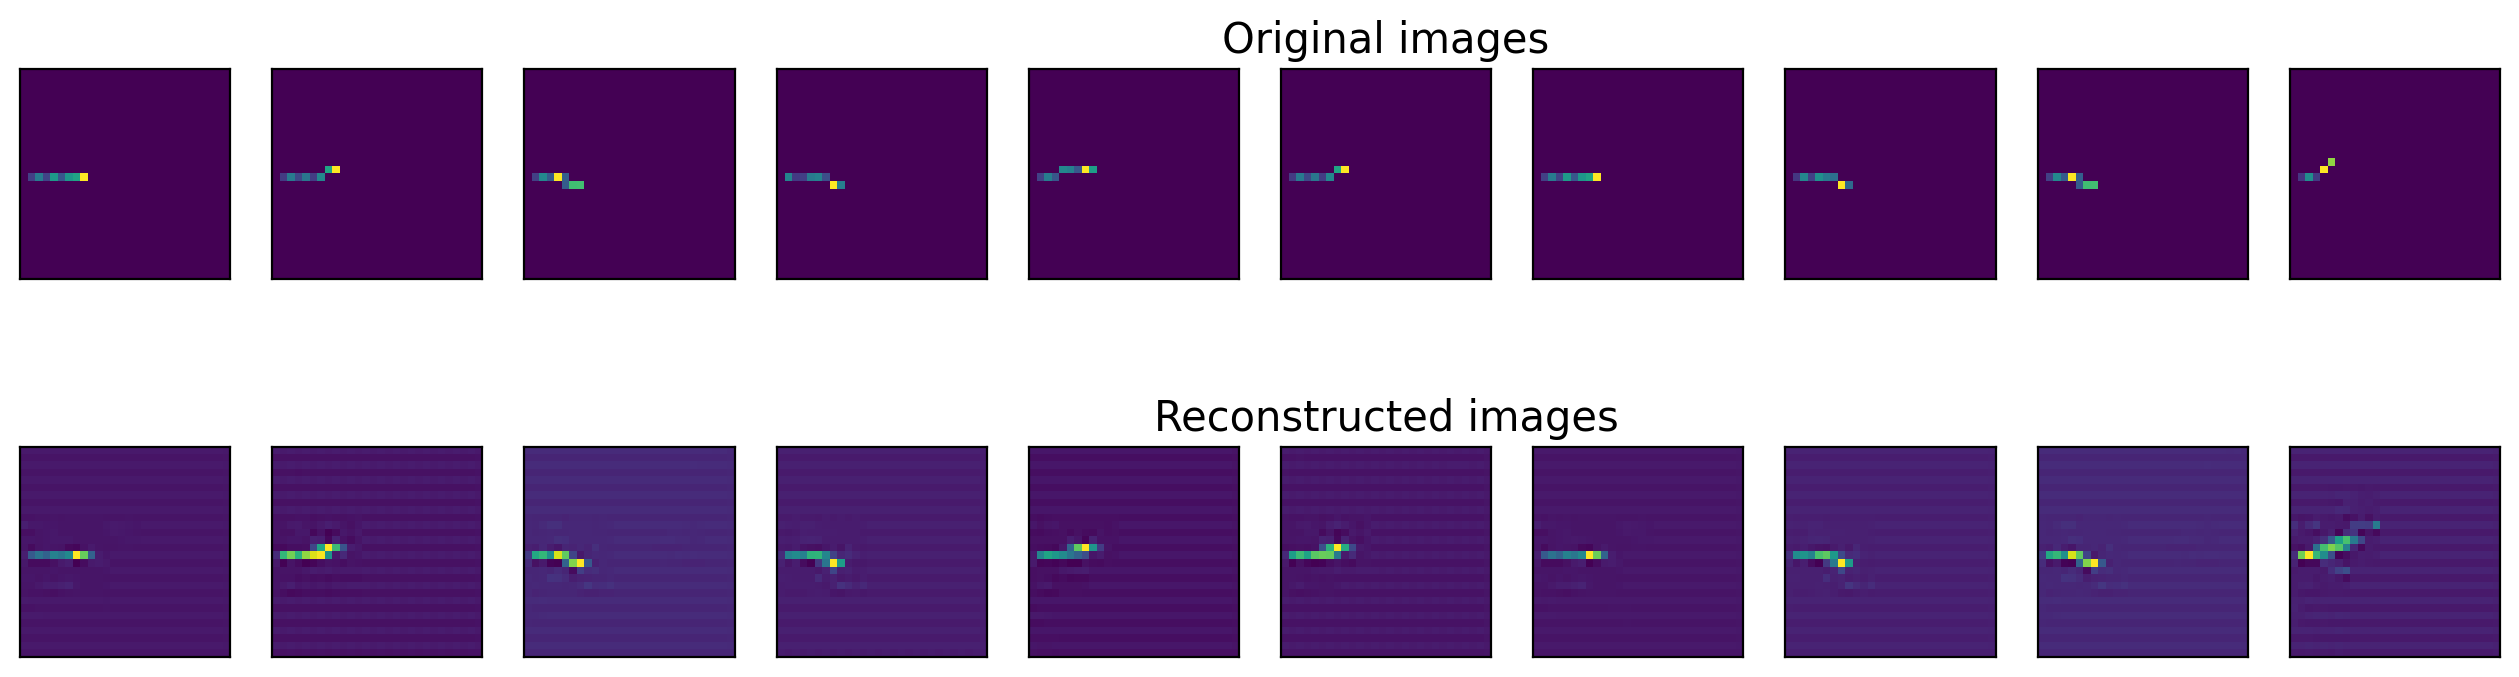


 EPOCH 201/500 	 train loss 1583.627 	 val loss 0.000


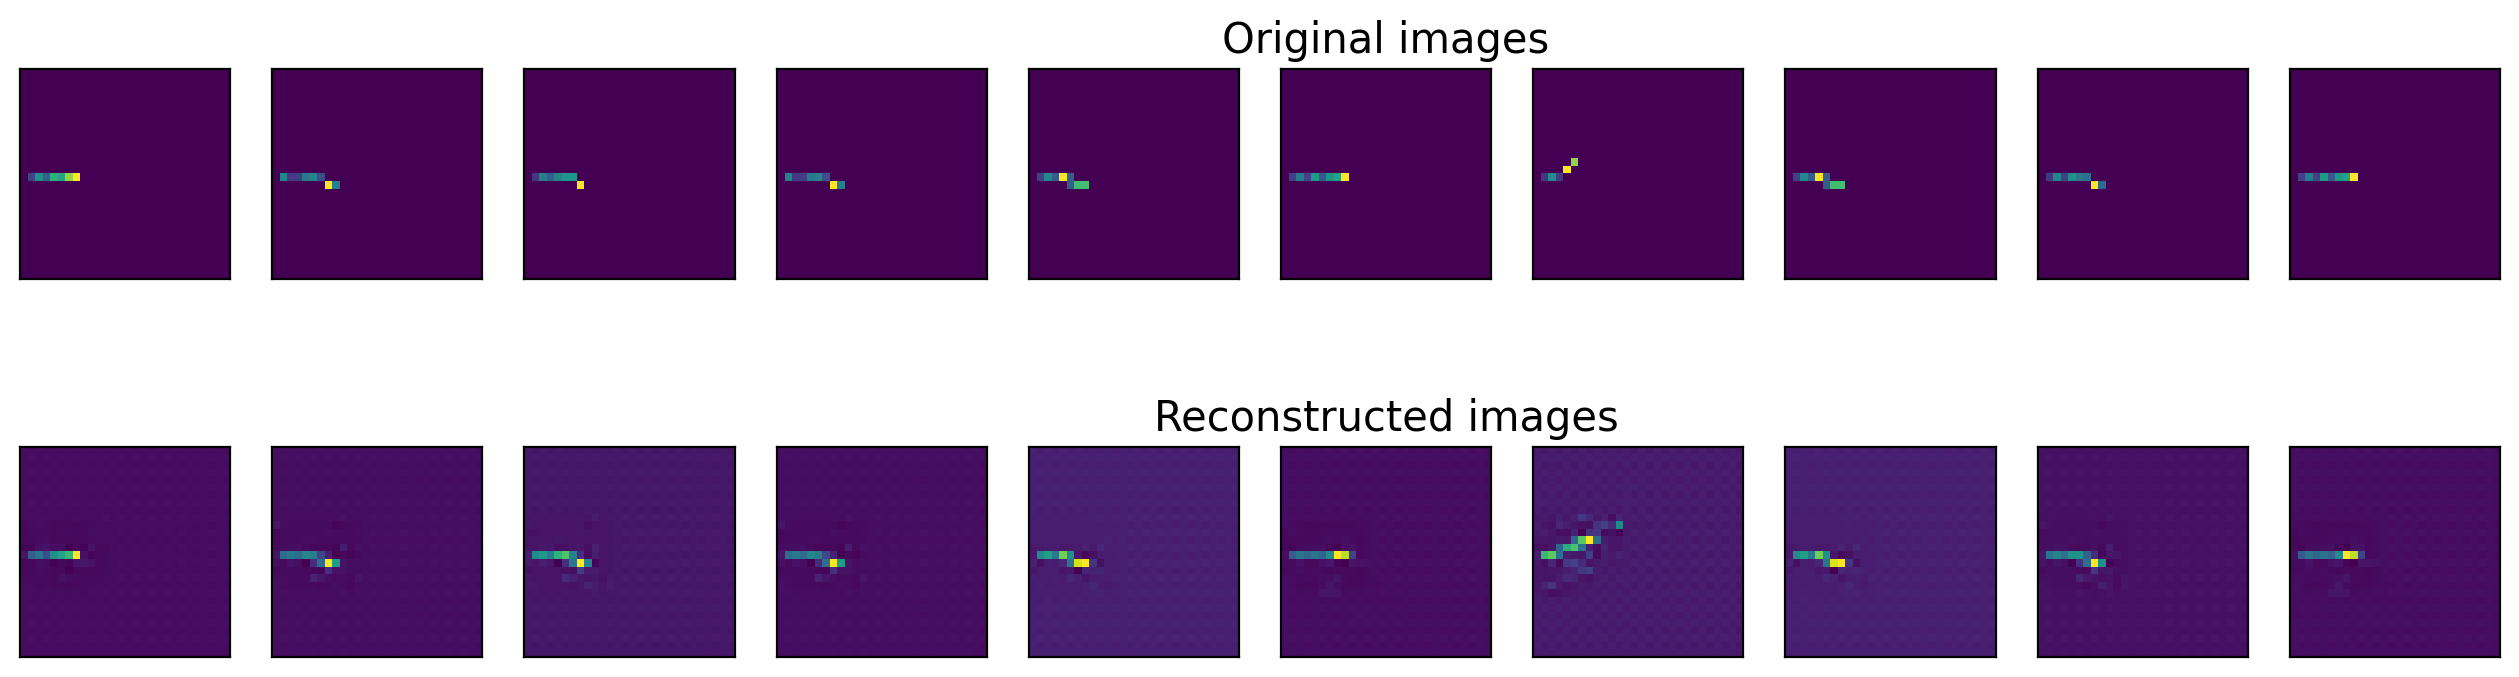


 EPOCH 251/500 	 train loss 1566.989 	 val loss 0.000


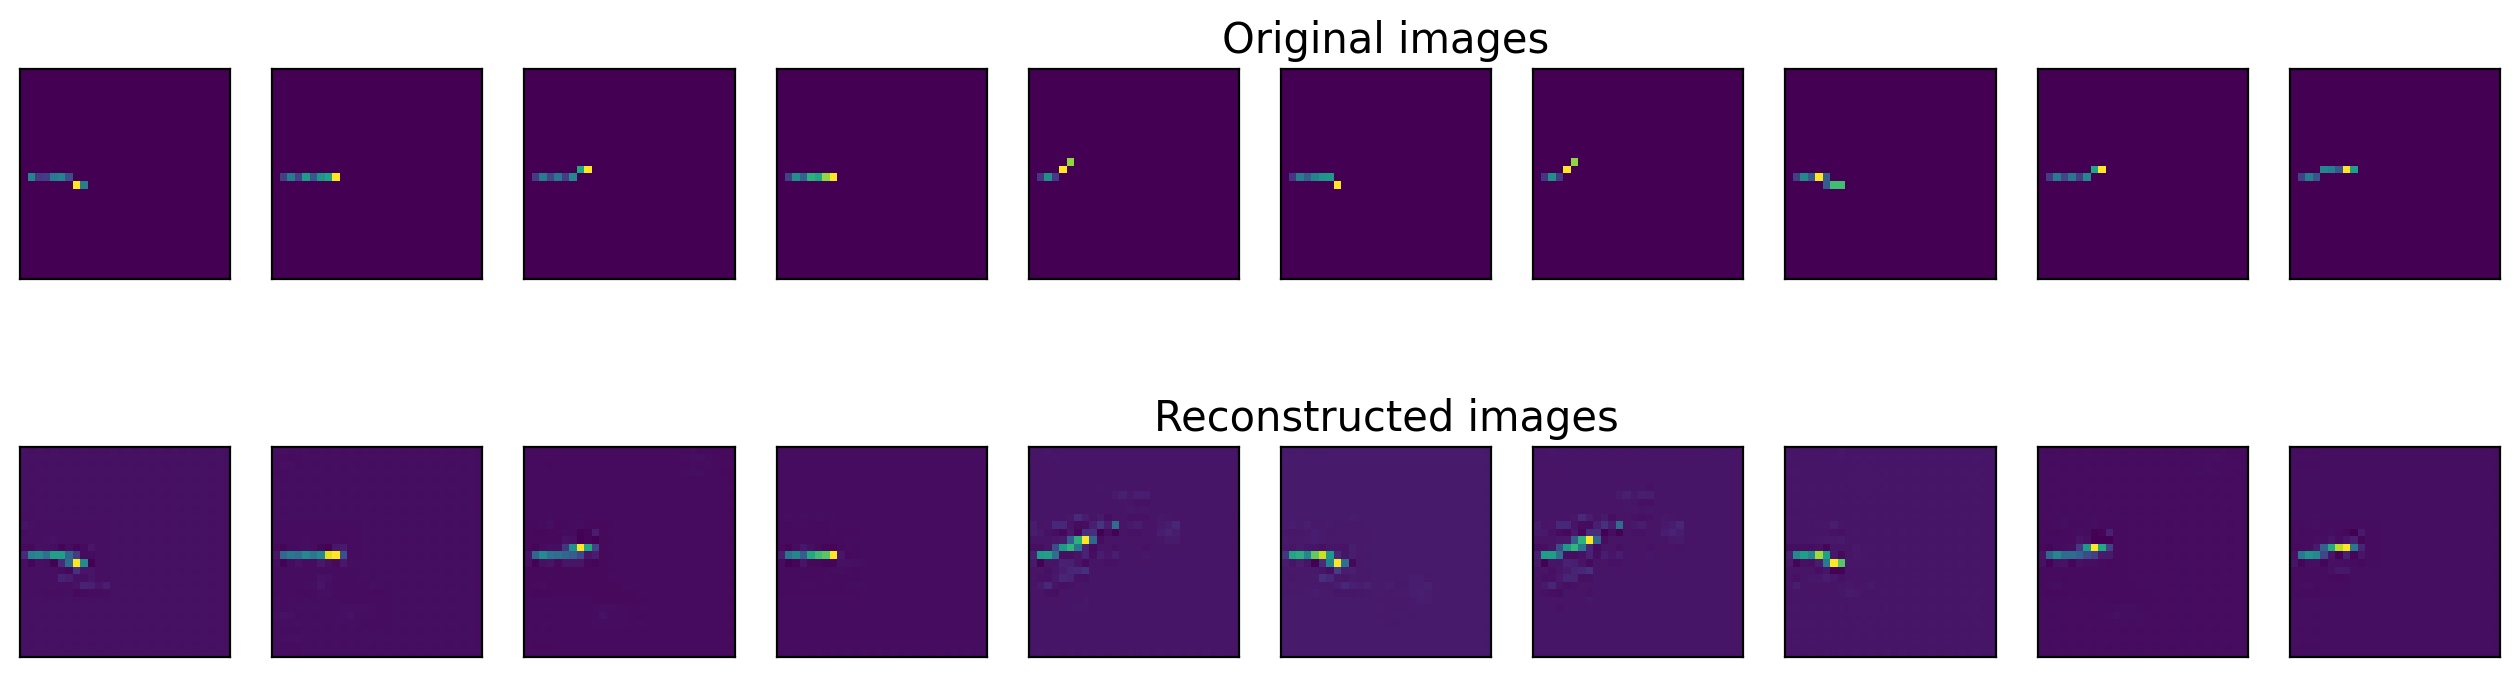


 EPOCH 301/500 	 train loss 1496.452 	 val loss 0.000


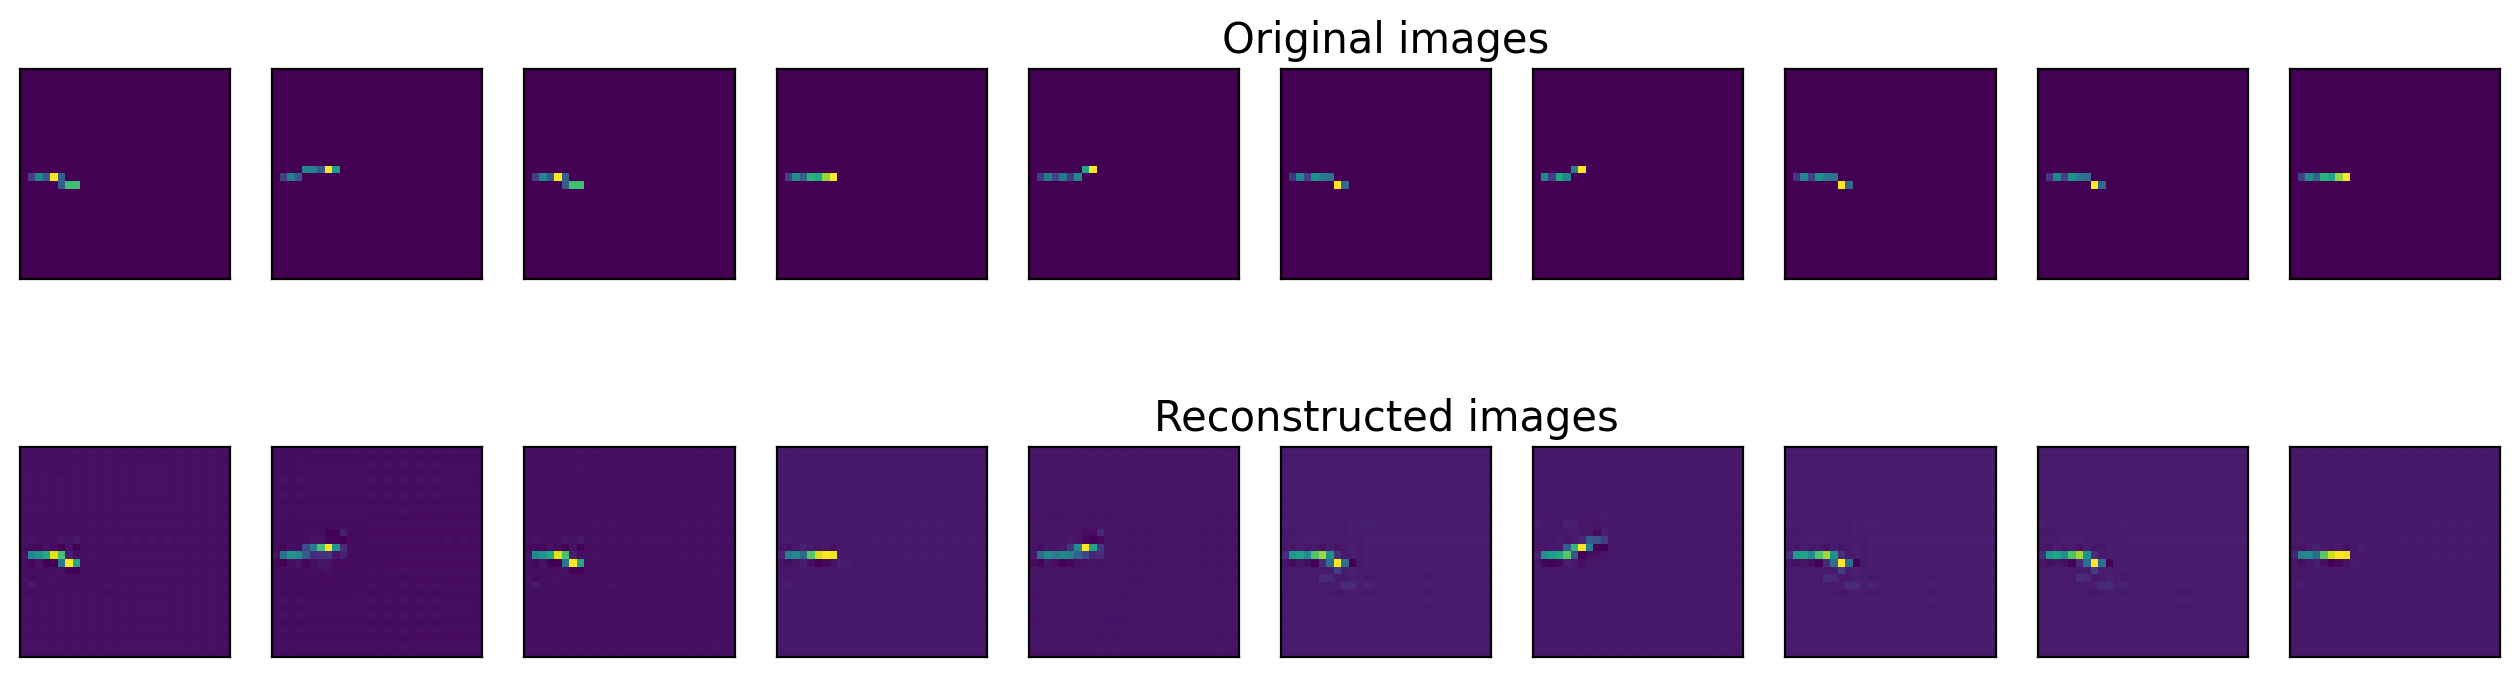


 EPOCH 351/500 	 train loss 1295.375 	 val loss 0.000


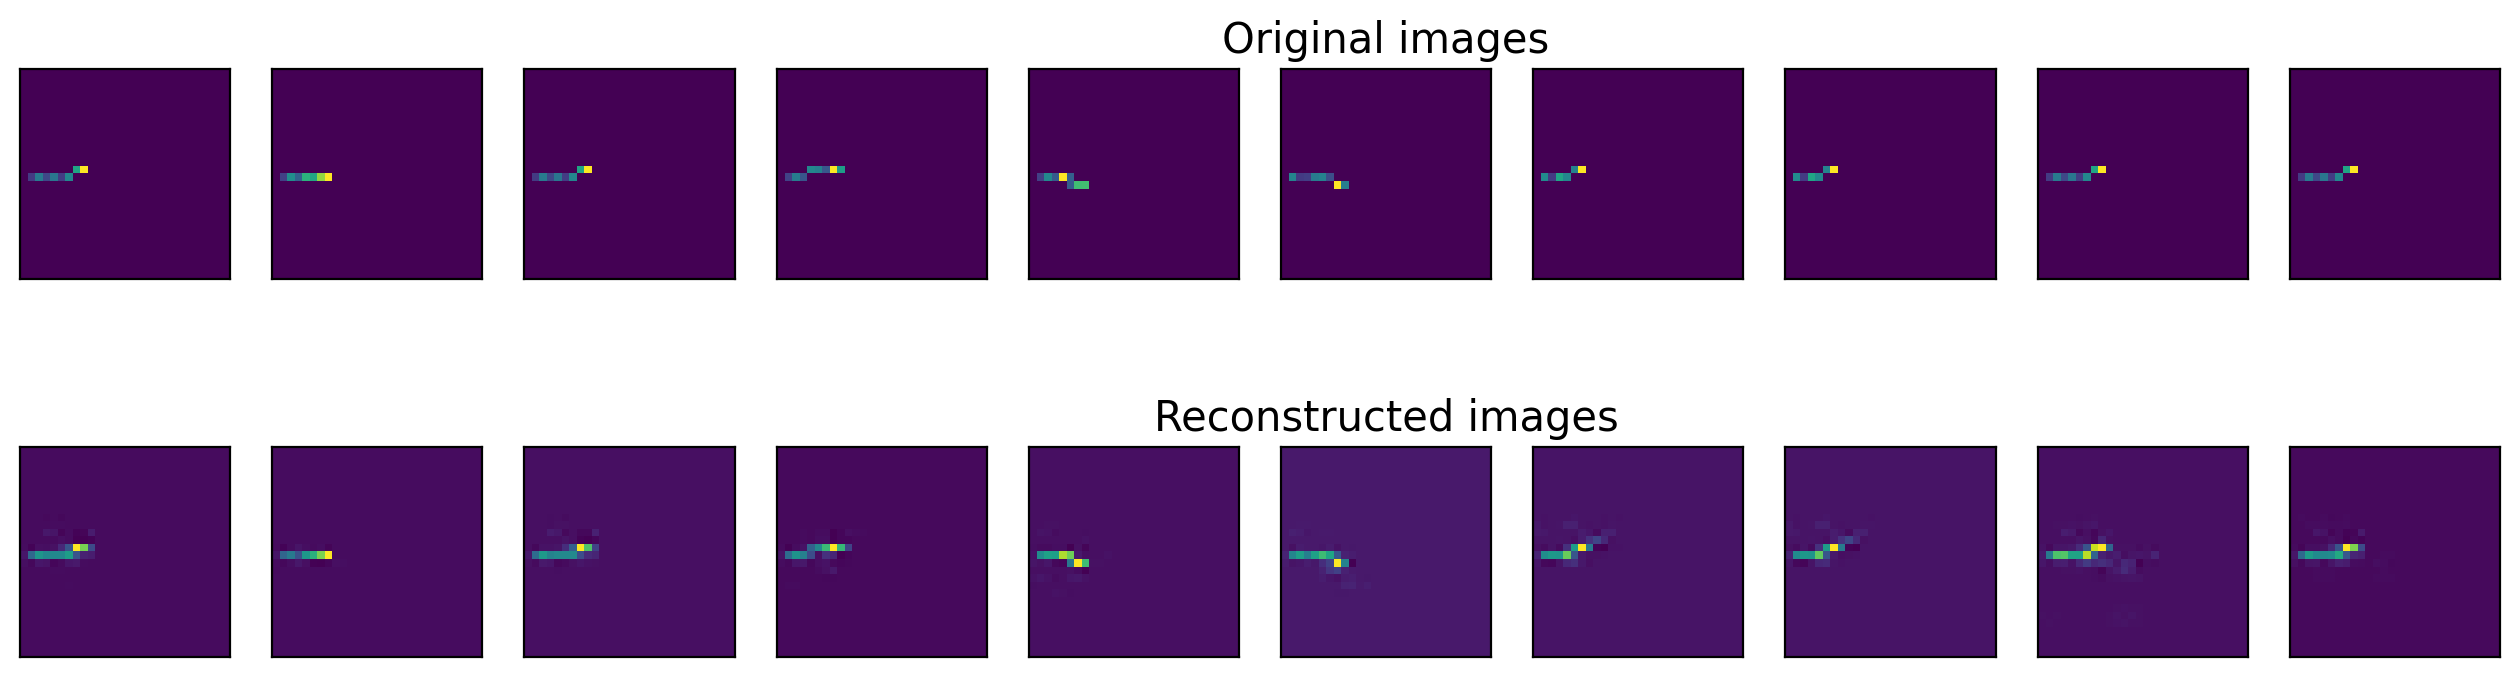


 EPOCH 401/500 	 train loss 1350.960 	 val loss 0.000


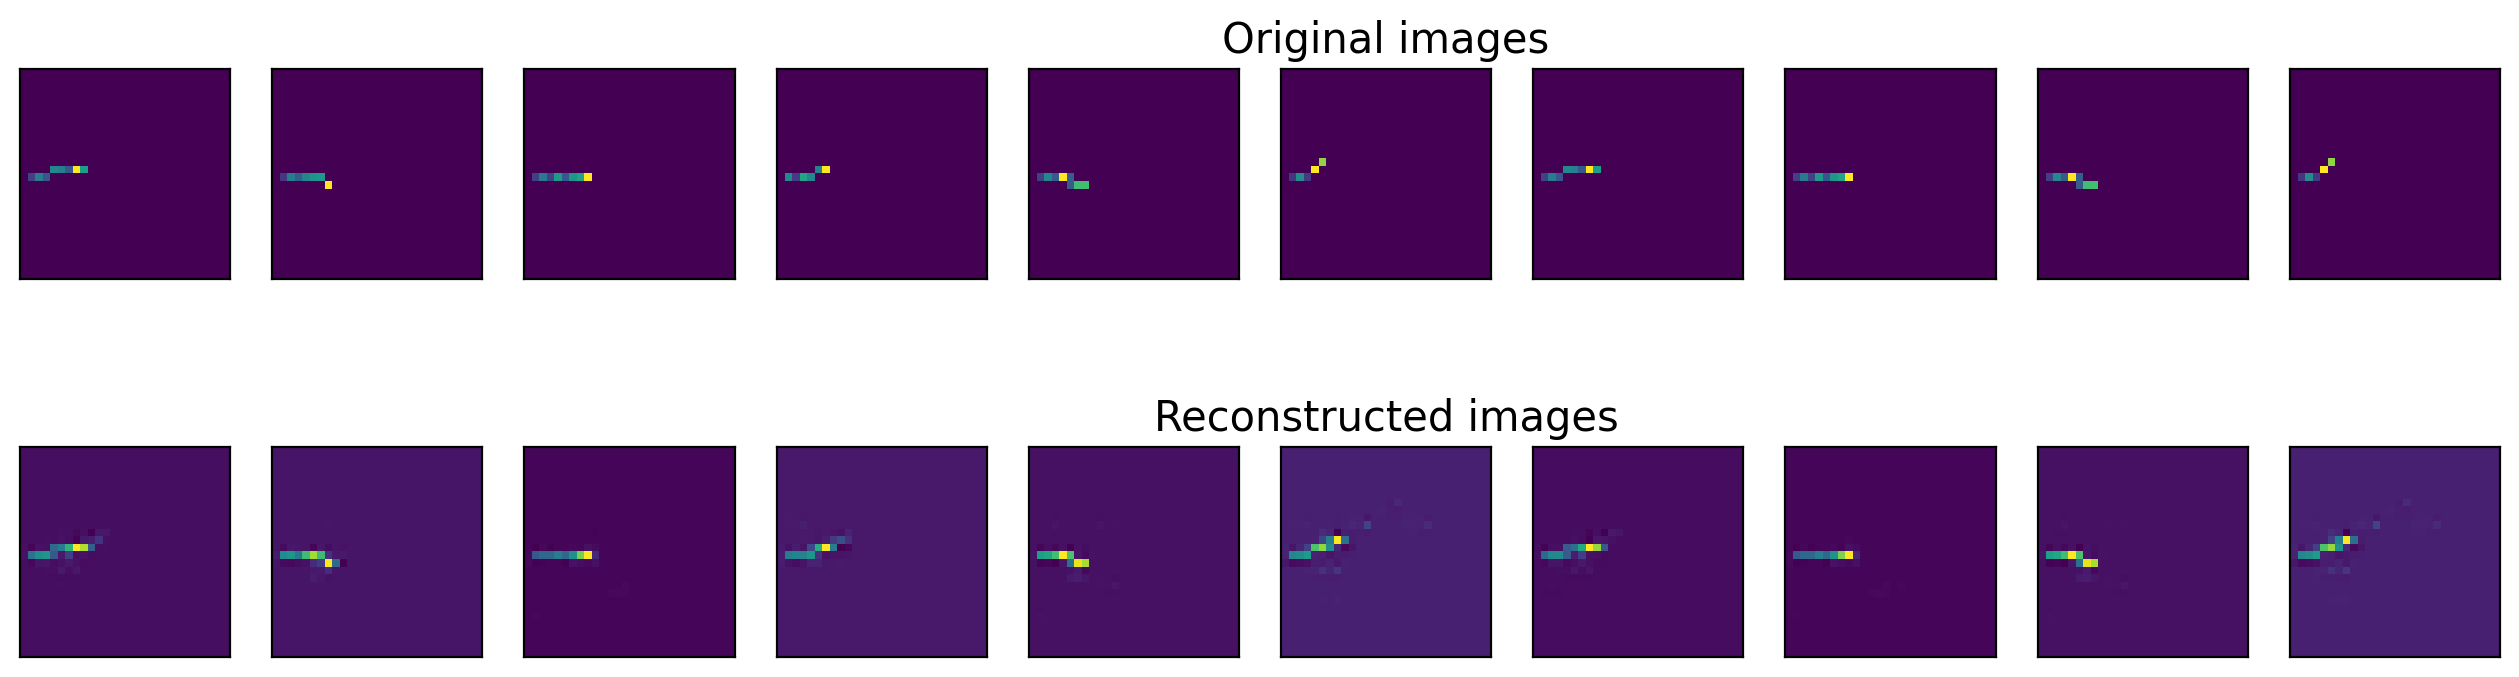


 EPOCH 451/500 	 train loss 1244.618 	 val loss 0.000


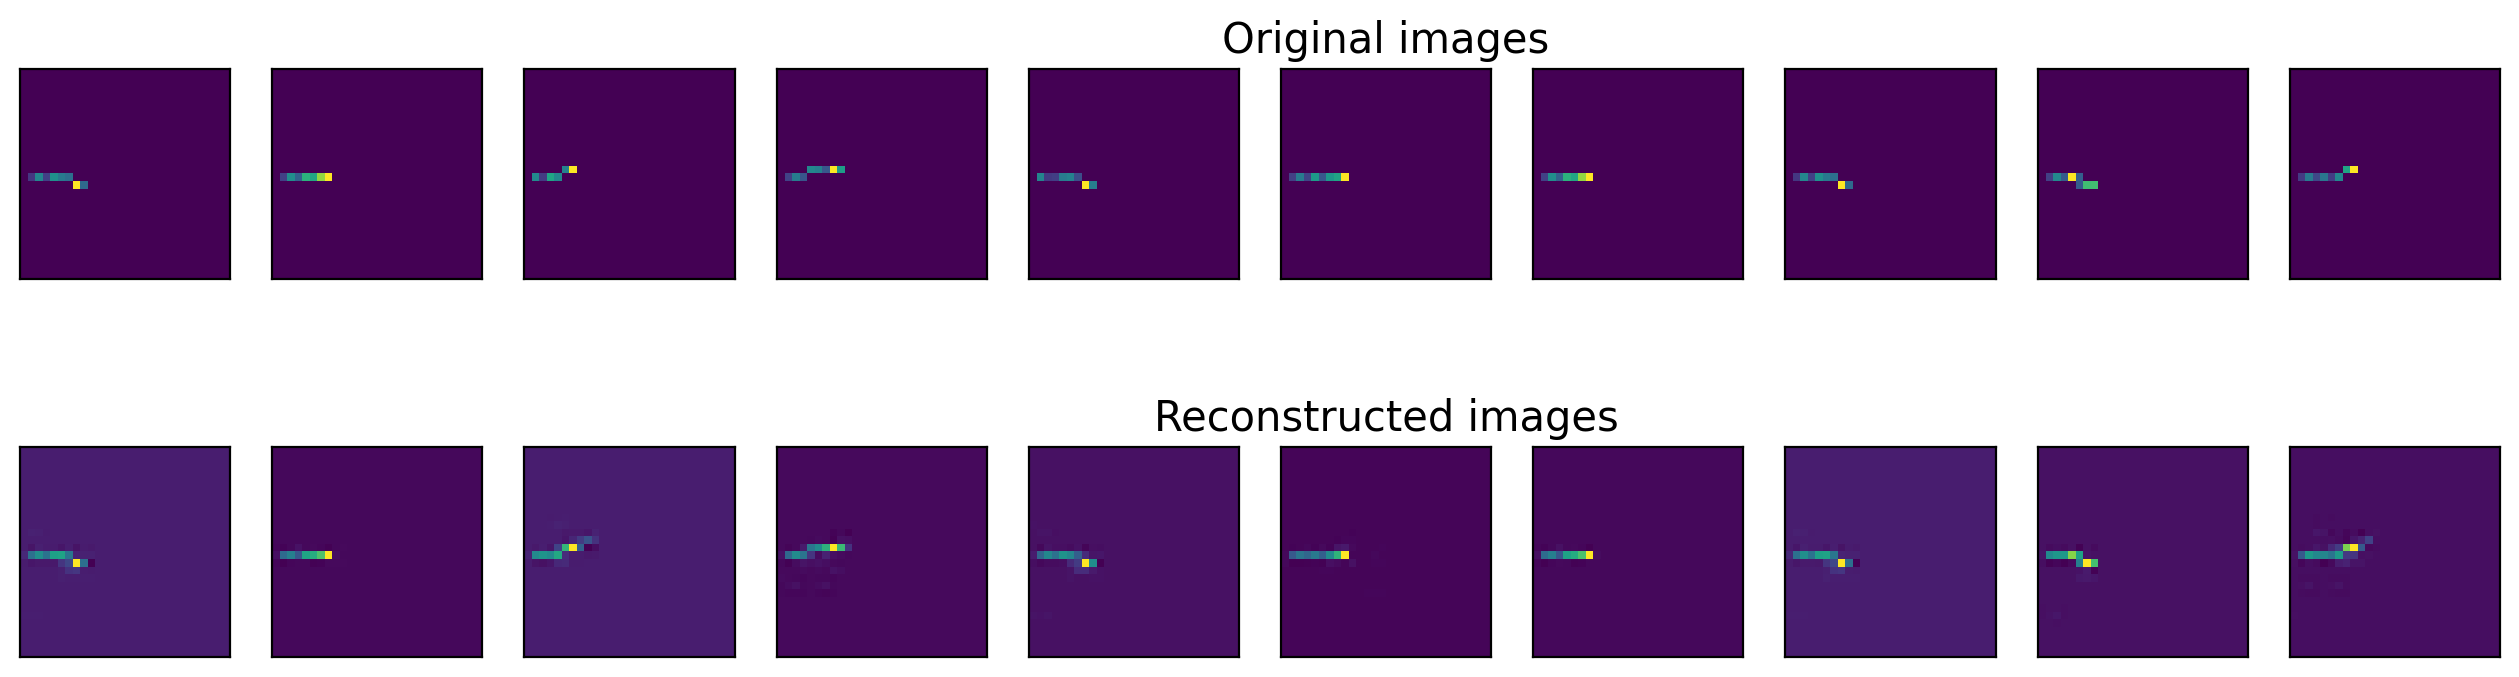

In [50]:
def plot_ae_outputs(idataset,ivae,n=10):
    plt.figure(figsize=(16,4.5))
    t_idx = np.random.randint(10,size=10)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = idataset[t_idx[i]][0].unsqueeze(0)
      ivae.eval()
      #encoder.eval()
      #decoder.eval()
      npones=np.ones((1,1))*1.50
      beam=torch.tensor(npones).float()
      with torch.no_grad():
         rec_img  = ivae.decoder(ivae.encoder(img,beam),beam)
      plt.imshow(img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy())#, cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, c in dataloader:
        # Move tensor to the proper device
        c=c.reshape(len(c),1).float()
        x_hat = vae(x,c)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.kl
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

lr = 1e-3
optim = torch.optim.Adam(cvae_proton_image.parameters(), lr=lr, weight_decay=1e-5)

num_epochs = 500

for epoch in range(num_epochs):
    train_loss = train_epoch(cvae_proton_image,train_loader,optim)
    val_loss=0
    if epoch % 50 == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(image150,cvae_proton_image,n=10)

Now, lets go ahead and see how well our conditional VAE models the shower shapes, as we vary the shower.

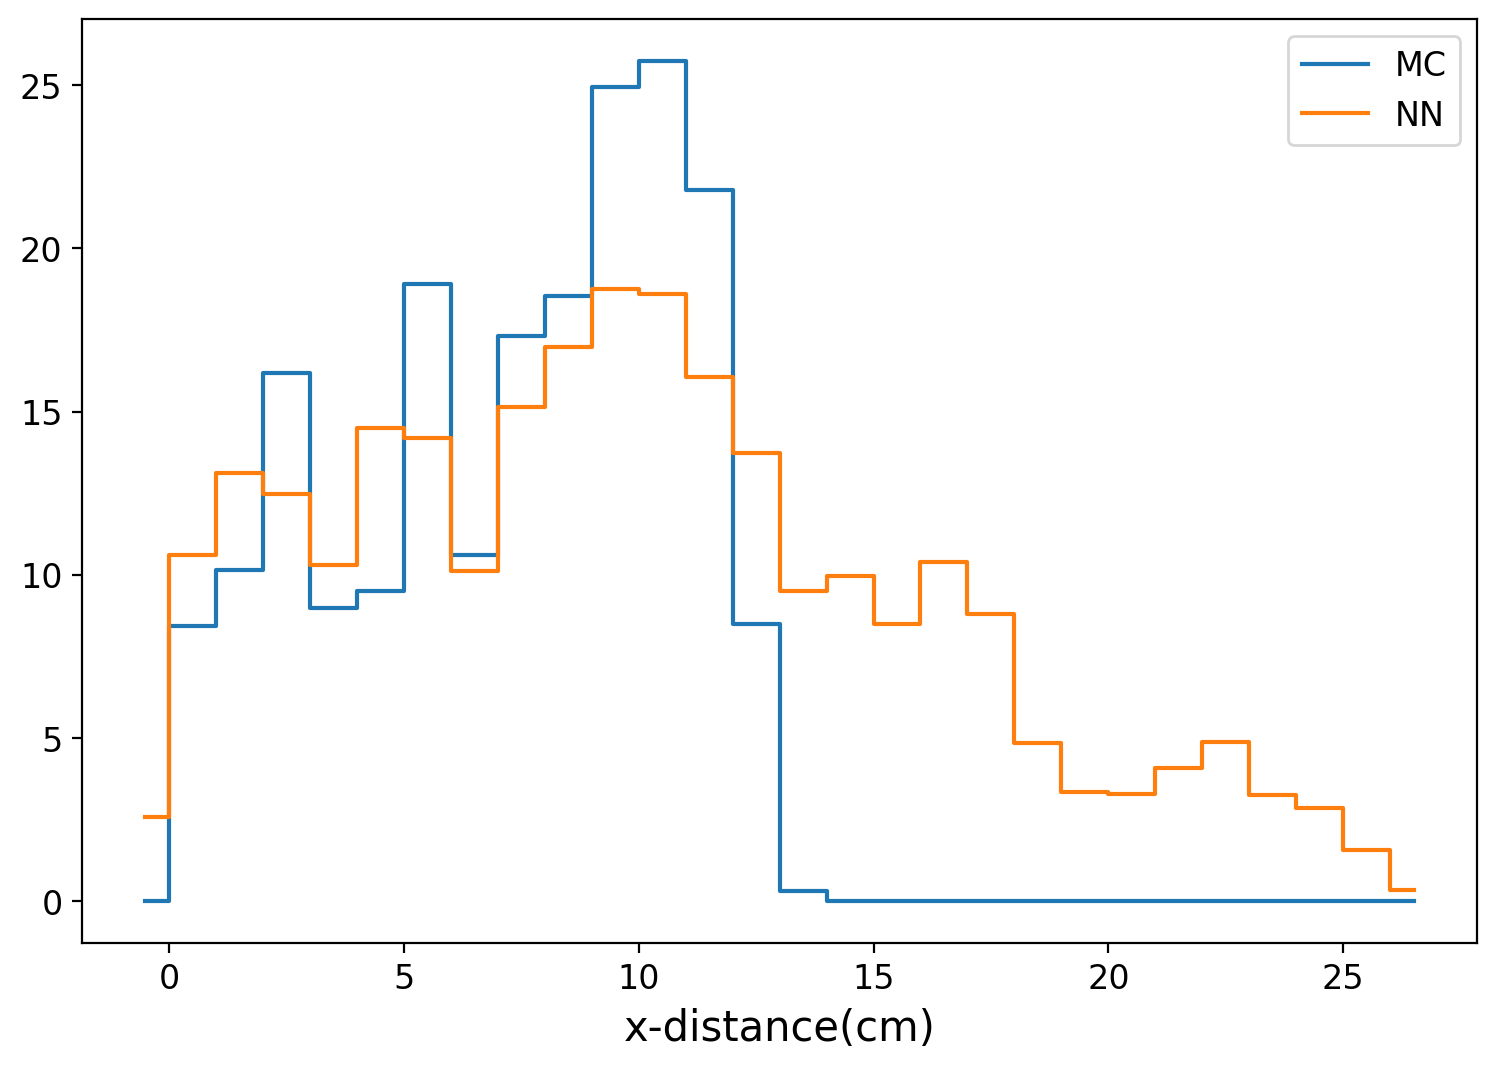

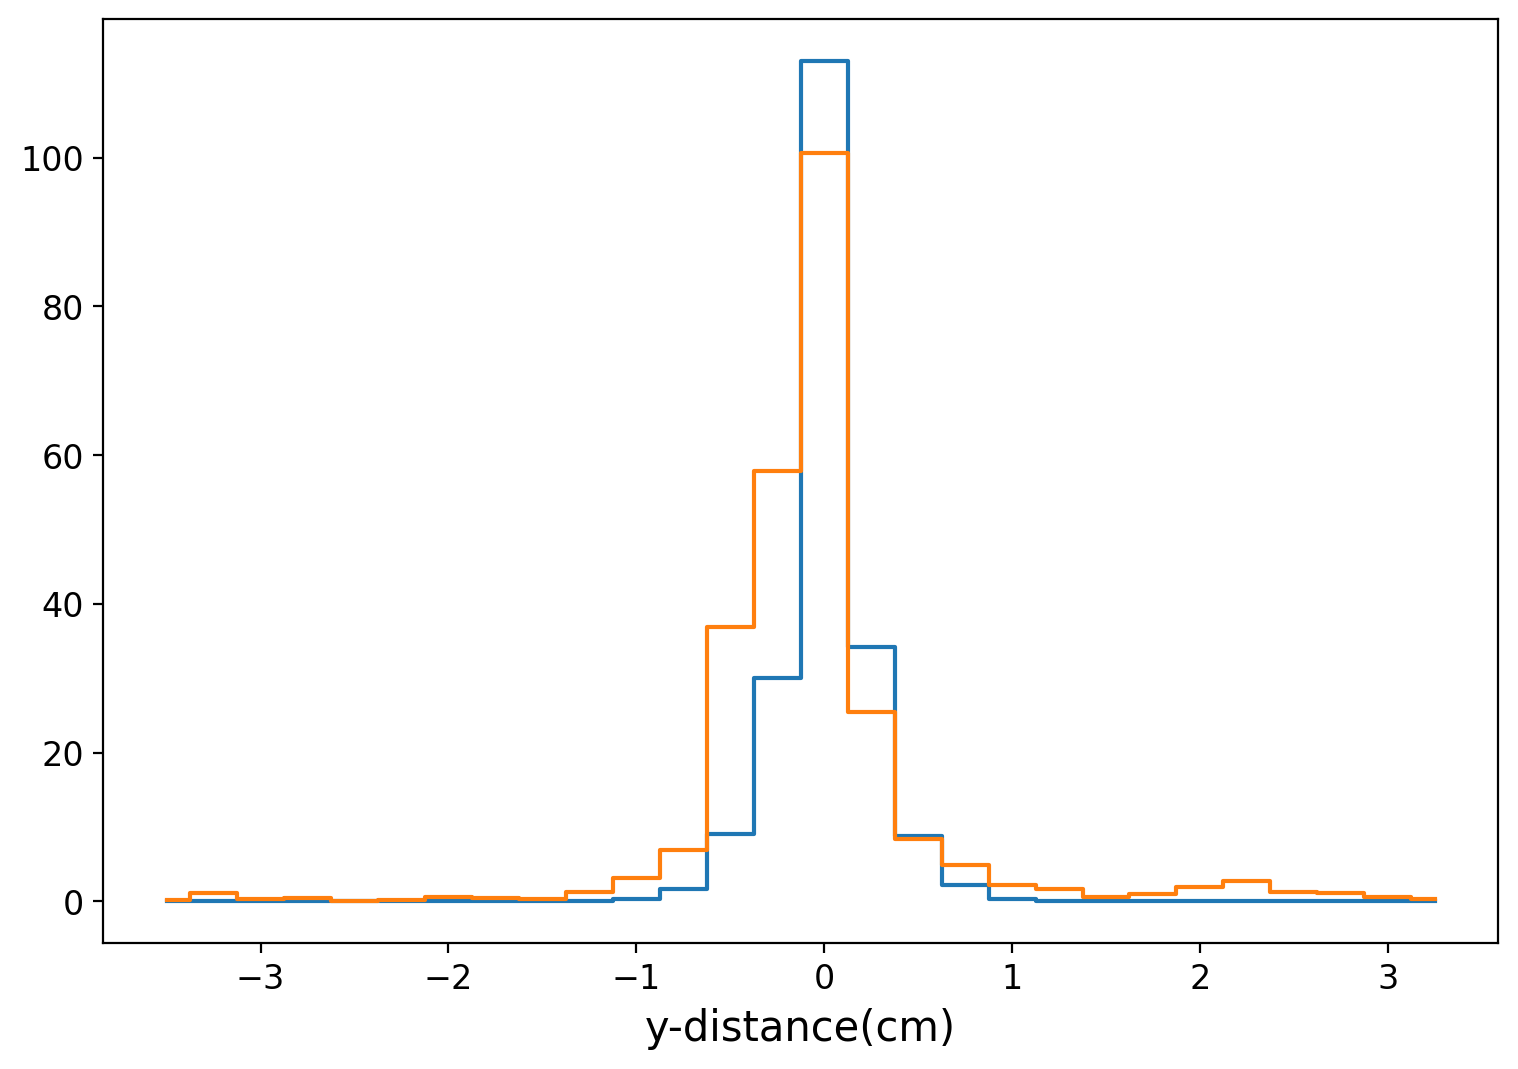

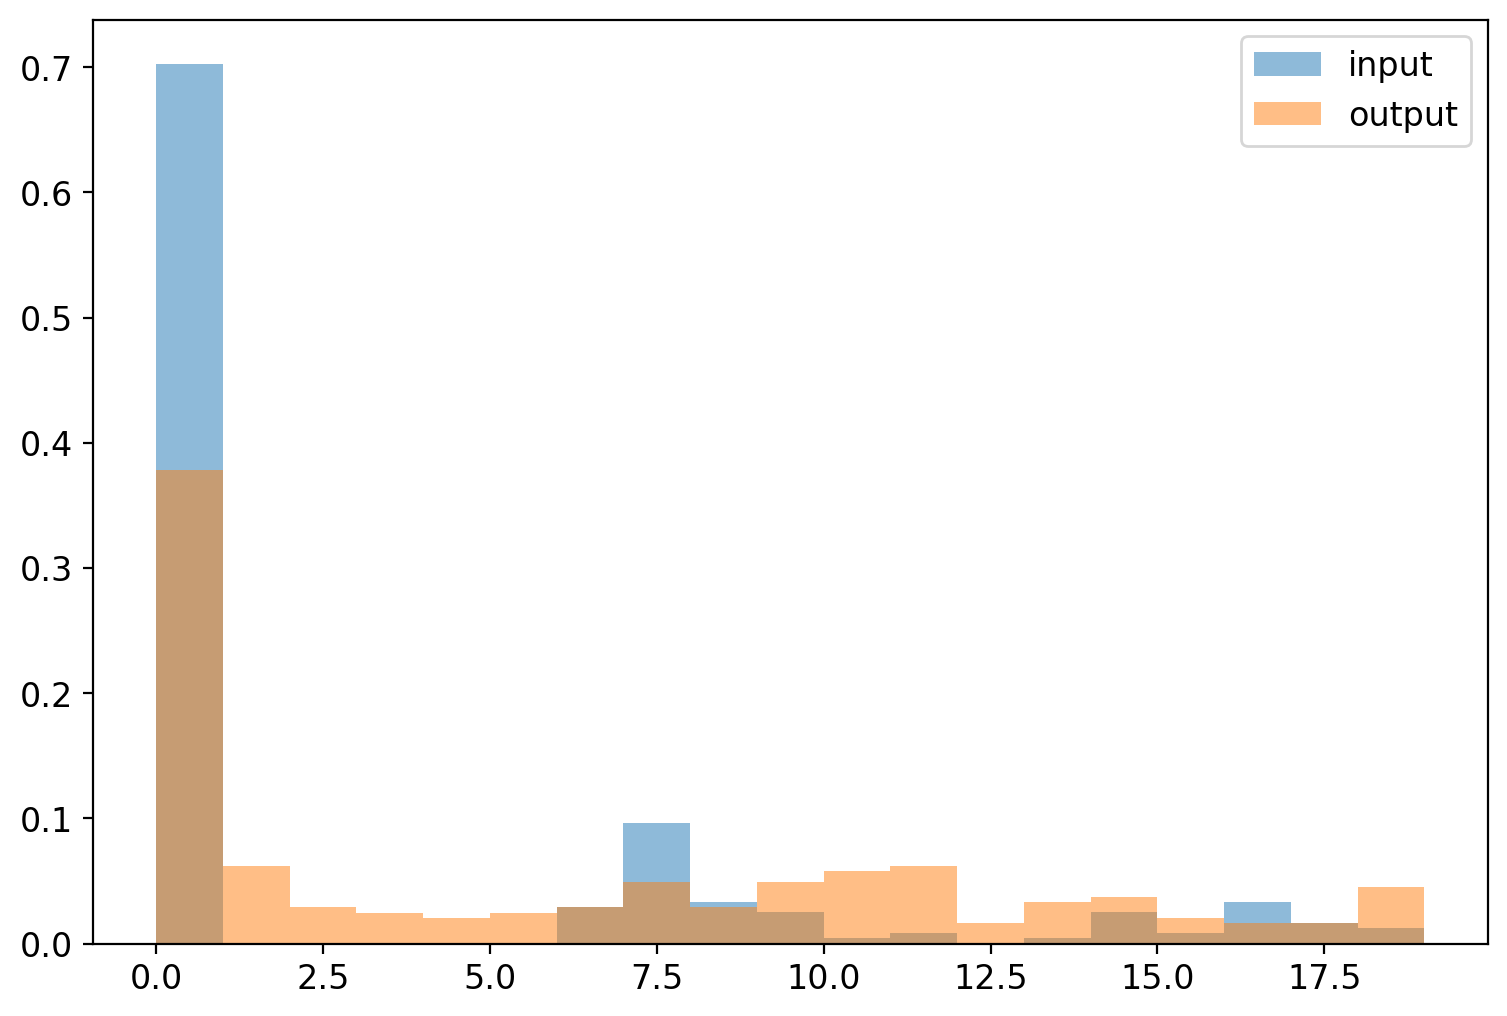

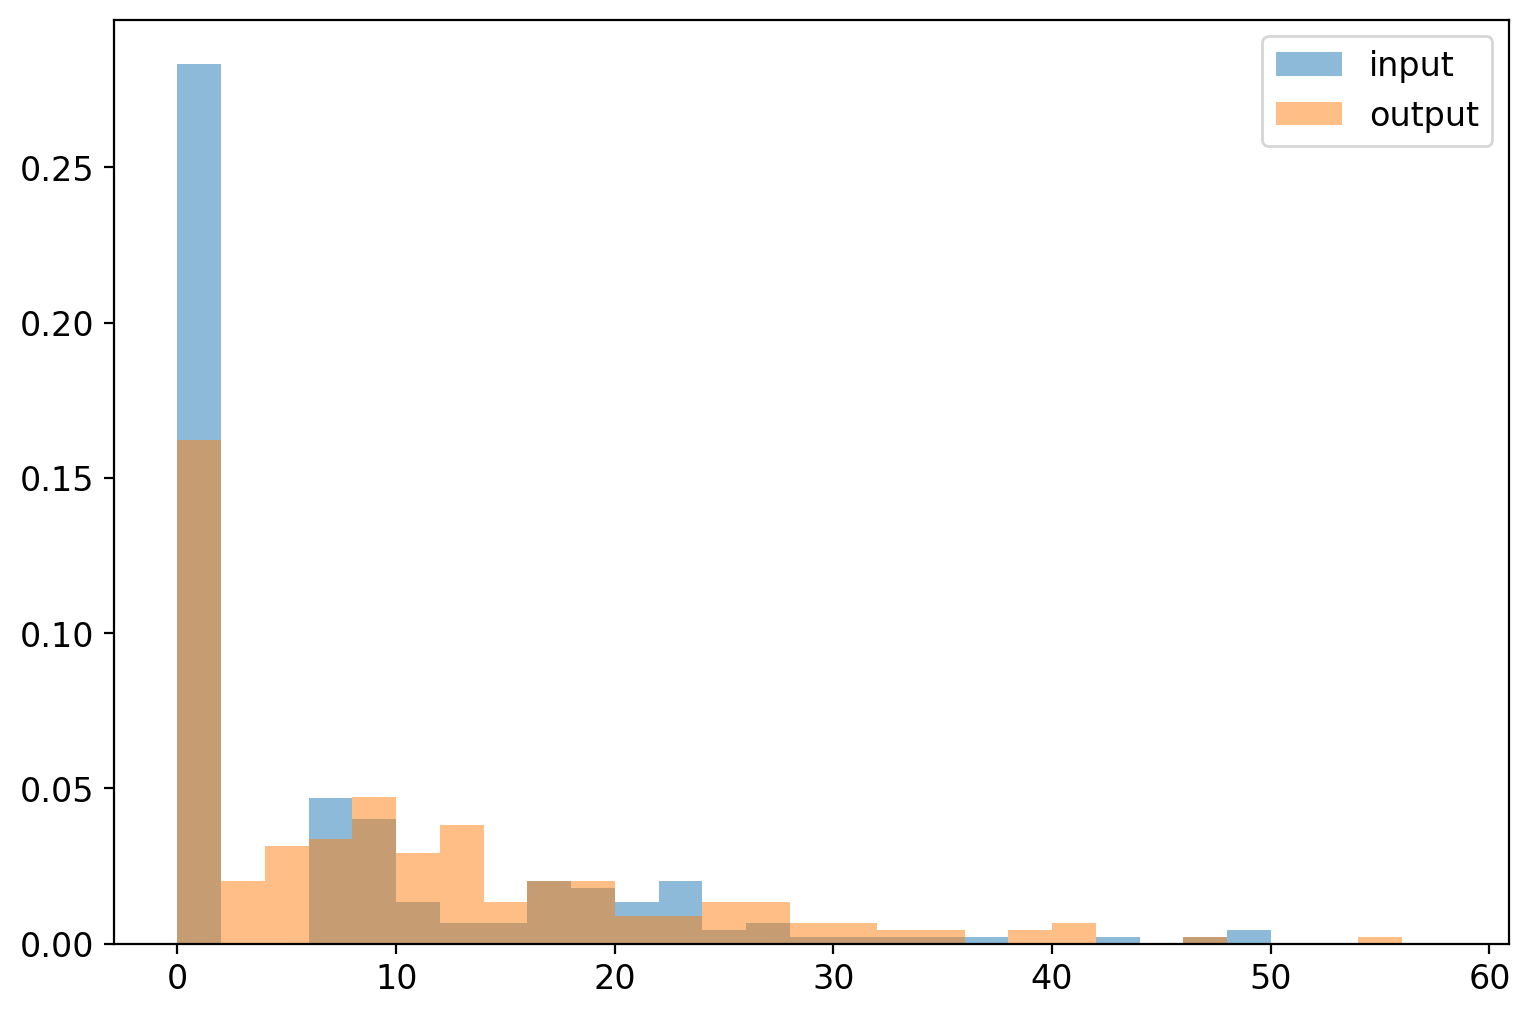

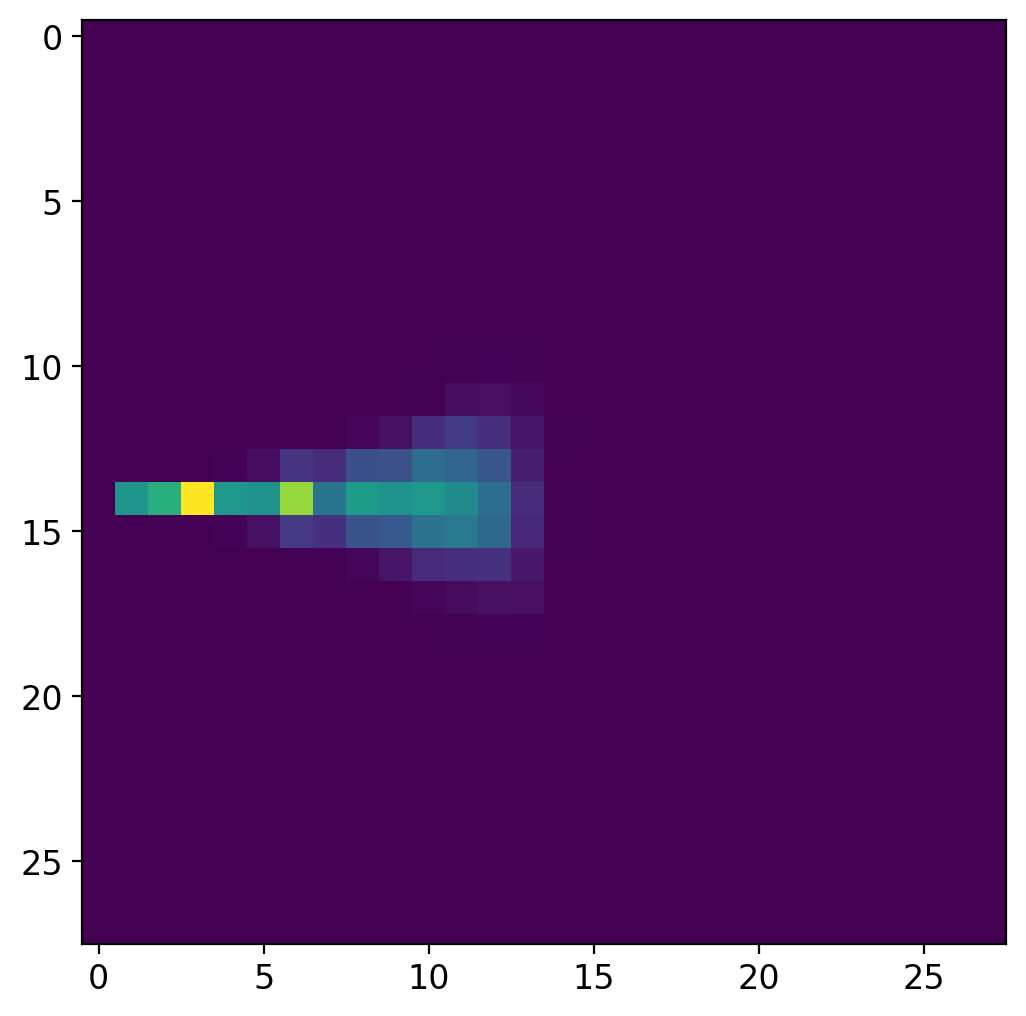

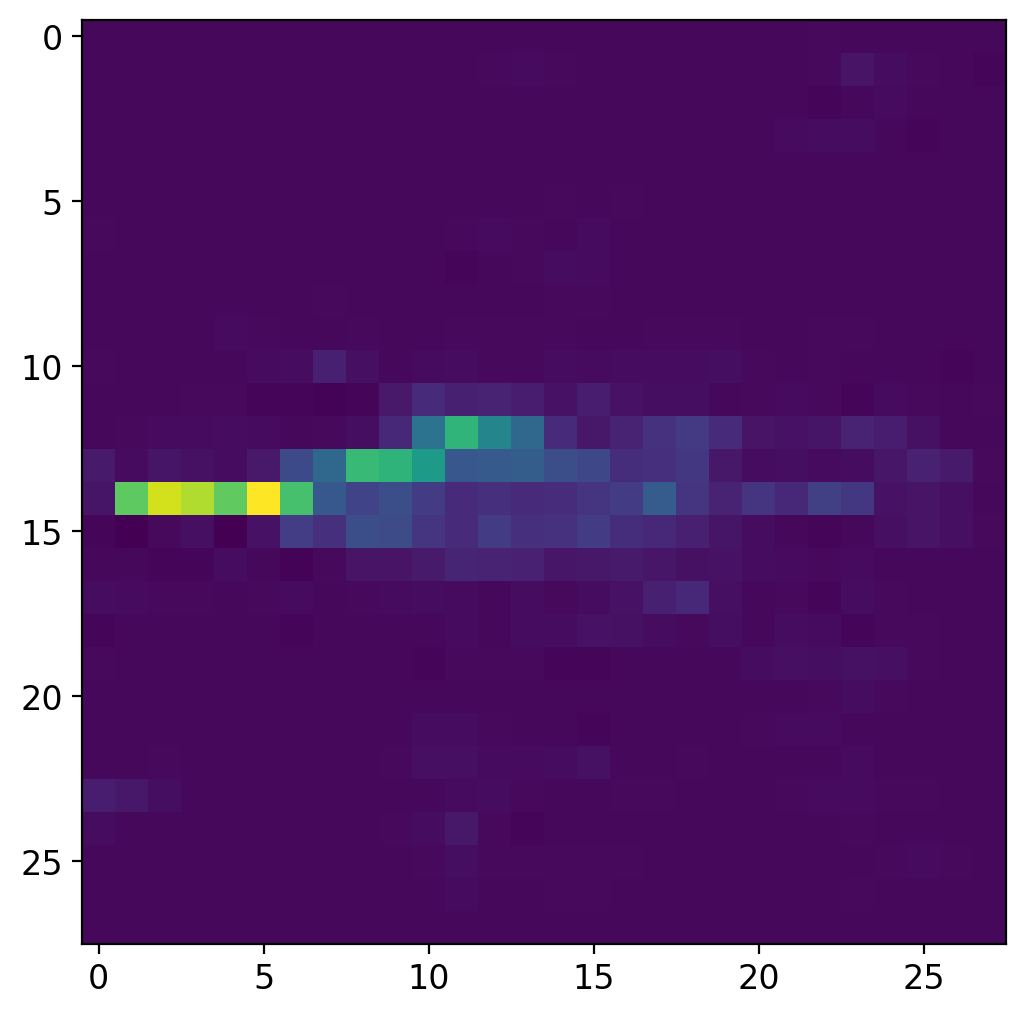

In [51]:
def plotCondVAEImageOutputs(iE,iLatentDim,iDataSet,iCVAE):
    testlatent=torch.randn(iDataSet.shape[0],iLatentDim)
    testlatent=testlatent.reshape(iDataSet.shape[0],iLatentDim)
    beamenergy = torch.ones(iDataSet.shape[0],1)*iE
    rec_img  = iCVAE.decoder(testlatent,beamenergy)
    rec_img  = rec_img.detach().numpy()

    xbin = np.arange(-0.5,27.5, 1)
    ybin = np.arange(-3.5, 3.5, 0.25)
    plt.plot(xbin,np.mean(np.sum(iDataSet,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(xbin,np.mean(np.sum(rec_img,axis=2),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('x-distance(cm)')
    plt.legend()
    plt.show()


    plt.plot(ybin,np.mean(np.sum(iDataSet,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='MC')
    plt.plot(ybin,np.mean(np.sum(rec_img,axis=3),axis=0).flatten(),drawstyle='steps-mid',label='NN')
    plt.xlabel('y-distance(cm)')
    plt.show()

    xrange=np.arange(0,20,1)
    plt.hist(np.sum(iDataSet,axis=2)[0:10].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[0:10].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    xrange=np.arange(0,60,2)
    plt.hist(np.sum(iDataSet,axis=2)[12:20].flatten(),label='input',alpha=0.5,bins=xrange,density=True)
    plt.hist(np.sum(rec_img ,axis=2)[12:20].flatten(),label='output',alpha=0.5,bins=xrange,density=True)
    plt.legend()
    plt.show()

    dimage150_avg = np.mean(iDataSet,axis=0)
    plt.imshow(dimage150_avg[0])
    plt.show()

    rec_img_avg = np.mean(rec_img,axis=0)
    plt.imshow(rec_img_avg[0])
    plt.show()

#plotCondVAEImageOutputs(1.50,d,dimage150,cvae_proton_image)
plotCondVAEImageOutputs(2.25,d,dimage200,cvae_proton_image)
#plotCondVAEImageOutputs(3.00,d,dimage300,cvae_proton_image)
#torch.save(cvae_proton_image.state_dict(), 'cvae_test.pt')

In [52]:
import time

def generate(iLatentDim,iN,iCVAE,iE):
    testlatent=torch.randn(iN,iLatentDim)
    testlatent=testlatent.reshape(iN,iLatentDim)
    beamenergy = torch.ones(testlatent.shape[0],1)*iE
    rec_img  = iCVAE.decoder(testlatent,beamenergy)
    rec_img  = rec_img.detach().numpy()
    return rec_img

N=250
start=time.time()
generate(d,N,cvae_proton_image,1.5)
stop=time.time()
print("Time to generate 250 events:",(stop-start))
timeNN=(stop-start)

start=time.time()
simNYParallelSample(ie=150,im=mproton,iN=N,idt=1e-10,iZ=8)
stop=time.time()
print("Time to generate 250 events:",(stop-start))
timeGen=(stop-start)

print("===> speed up",timeGen/timeNN)

Time to generate 250 events: 0.014458894729614258
Scanning: 150
Time to generate 250 events: 14.962566137313843
===> speed up 1034.8347101986974


## Normalizing Flows :  more Expressive model

Now, if we really want to make our model extra expressive, we can consider adding normalizing flow layers. The flow would replace the existing Gaussian sample with a Gaussian sample in a transformed space. The iterative transforming in a normalizing flow can make the latent space progressively more and more expressive.

We will skip this for now, mostly because its nto clear we can train this fast enough for this lecture, and it could use some tweaking before its ready to be in the notes.

<a name='exercises_22_4'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_4) | [Next Section](#section_22_5) |


<a name='section_20_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.5 Bootstrapping </h2>  


| [Top](#section_20_0) | [Previous Section](#section_20_4) | [Exercises](#exercises_20_5) | [Next Section](#section_20_6) |

When we look at the above generation, the full image will a full energy profile can yield a shape. We can run a lot of generation, and treat this shape as a simulation. However, when we quote uncertainties on this shape, we can treat this as a Poisson uncertainty on each bin, since there bins are correlated.

To get the full uncertainty of this setup, we really need to go a bit further and deploy techniques that can account for the fact that the whole shape is correlated. There are really two ways to do this:

 * Write down all the uncertainties going into how you generate your simulation and vary them
   * For above, this means many to name a few
     * uncertainty in the beam profile,
     * uncertainty in the enrgy distribution,
     * uncertainty in the detector shape
     * uncertainty in the training
     * ...
   * The uncertainty in the training can be very hard to estimate
     * Sometimes this means multiple traings
   * We can often miss uncertainties
     * Or we just ignore them (eg Laudau unc.)
 * Reverse engineer the uncertainty from the ultimate variations in the data
   * Sometimes its just too complicated to get the uncertainty from inputs
   * We can analyze the uncertainty by removing events and looking at the prediction variations
     * This involves some assumptions about uncertainty
   * Bootstrapping

Now before we go ahead and try to solve the problems of our simulation, lets go ahead and do some very basic boostrap examples. Let's sample a uniform distribution from 100 to 300.

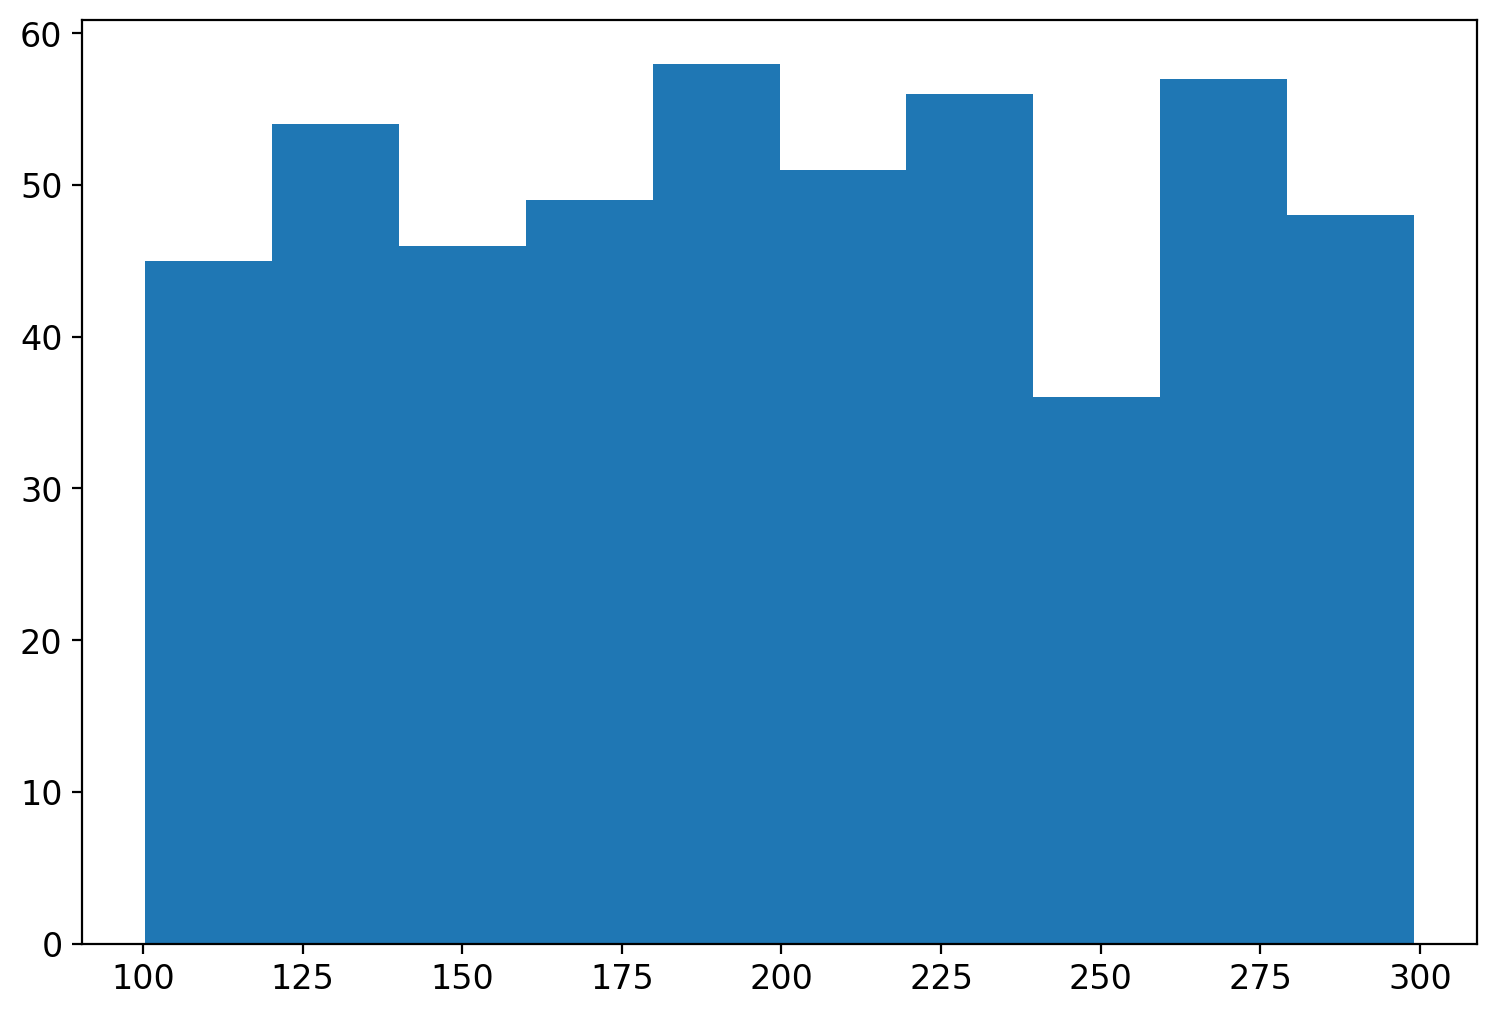

Mean: 200.08770783517346
RMS: 56.58058658033926


In [54]:
#np.random.seed(0)
samples = np.random.uniform(100,300,500)
plt.hist(samples)
plt.show()

print("Mean:",np.mean(samples))
print("RMS:",np.std(samples))

Ok, so my first question for you is, what is the analytic mean and standard deviation of this sample?


This is a just a flat distribution, so we can immediately write the mean and standard deviation of a [flat distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) raging from $a$ to $b$ as

$$
\bar{x} = \frac{1}{(b-a)}\\
\sigma_{x} = \frac{b-a}{\sqrt{12}}
$$

Secondly, we can ask ourselves what the uncertainty on the mean and standard variance is for $N$ measurements. If you recall early on in this, class this is computed by computing the variance in the mean over a sample and variance of a standard deviation over the sample for $N$ samples. Analytically, we can write this as:

$$
\sigma_{\bar{x}} = \frac{\sigma_{x}}{\sqrt{N}} \\
\sigma_{\sigma_{x}} = \frac{\sigma_{x}}{\sqrt{2N}}
$$

Now, what if we want to compute the uncertainty in the kurtosis or perhaps the ratio of the kurotsis to the mean distribution, or something else, how would we compute that?

Well....we can do it analytically, but lets try another approach

Lets resample our existing distribution with a random poisson sampler, and make a toy experiment. When can then proceed to make many toys and then look at the distribution of our means and standard deviations, and see if they agree with our analytical forms.

To do that, we are going to use the random choice, which is our Poisson sampler on an array. Let's take a look at how it works

[0 1 2 3 4 5 6 7 8 9]
[9 6 7 4 5]
[5 9 4 2 8 7 1 8 1 3]
[8 8 6 5 7 2 0 7 2 3 7 4 8 0 3 4 5 8 6 3]


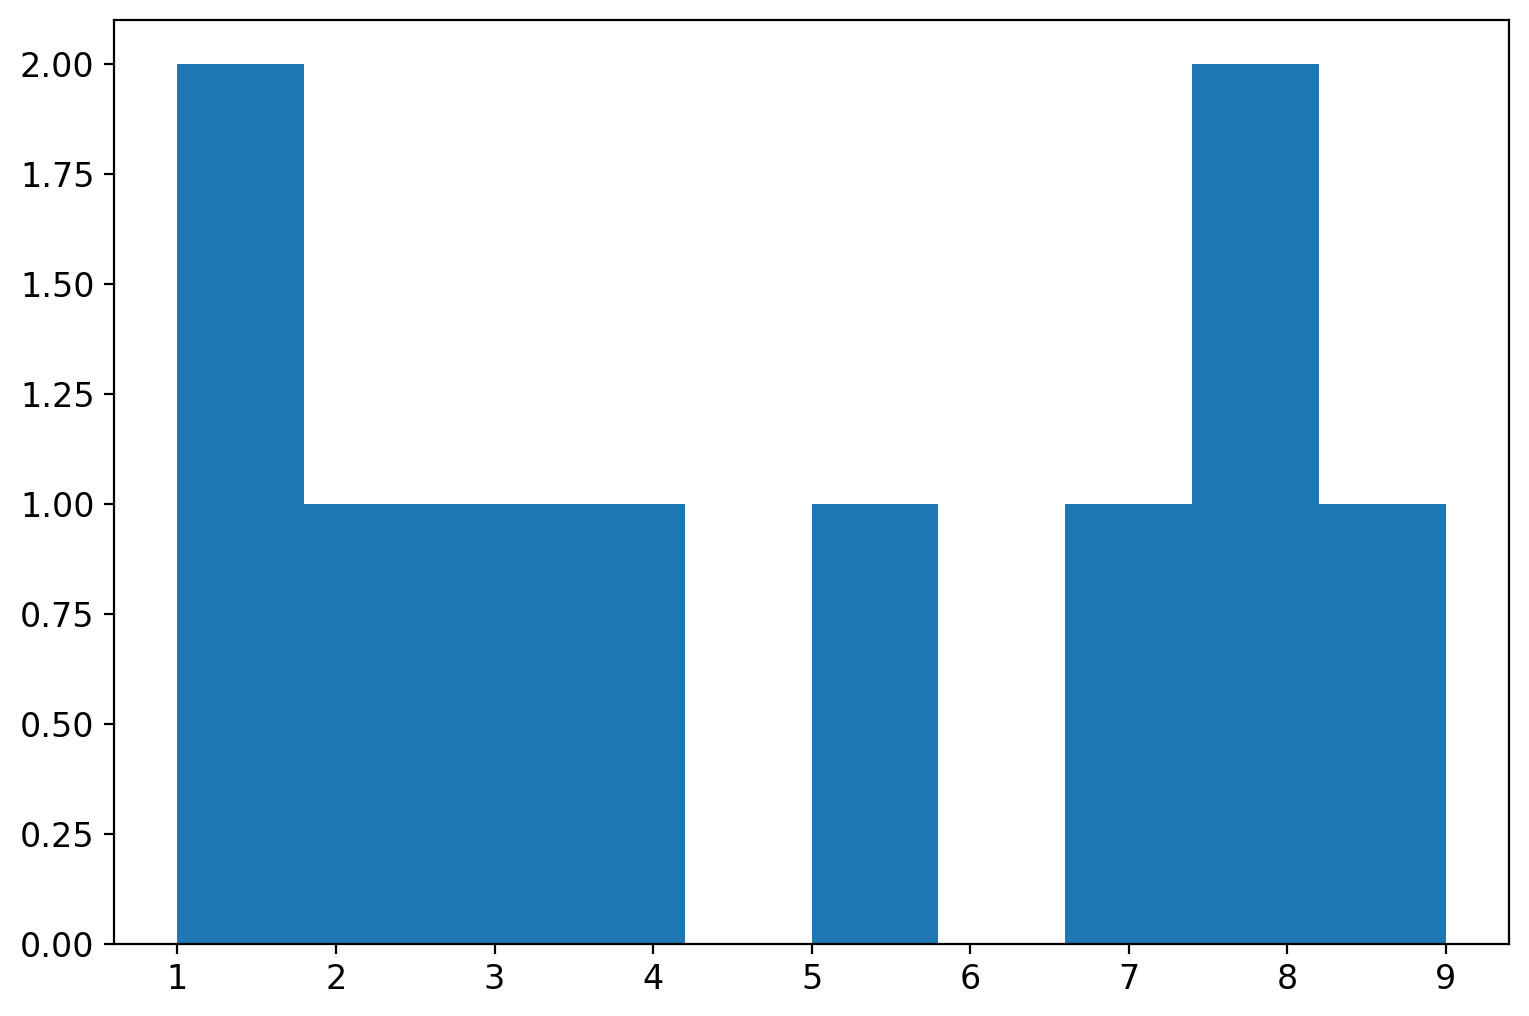

In [53]:
arr=np.arange(10)
print(arr)
test=np.random.choice(arr,size=5)
print(test)
test=np.random.choice(arr,size=10)
print(test)
plt.hist(test)
test=np.random.choice(arr,size=20)
print(test)

Notice, we will have dupblicates. That happens with our poisson sampler. This is really kind of the core idea. Is that if we bias our dataset by Poisson sampling it, we get a notion for how much our dataset will vary if we just choose differently from our base dataset.

Let's go ahead and compute the mean and RMS of our data.

Mean: 200.40166466534663
RMS: 56.815085508735386


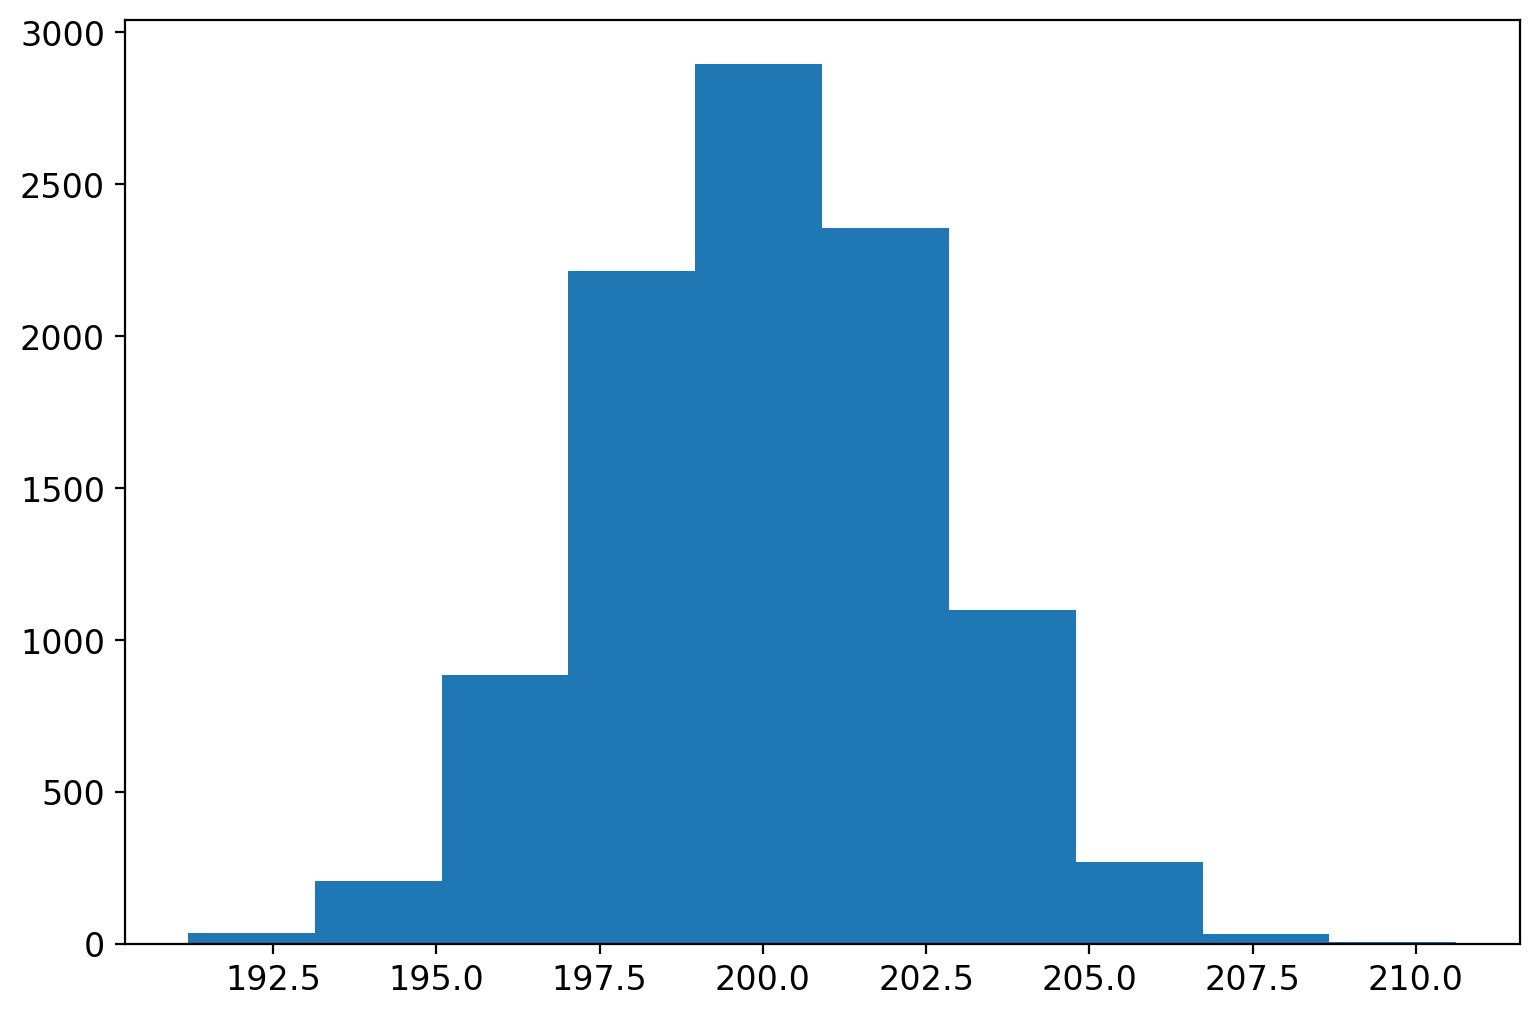

Mean of samples: 200.08860253310704
Std of mean of samples: 2.545796074574372


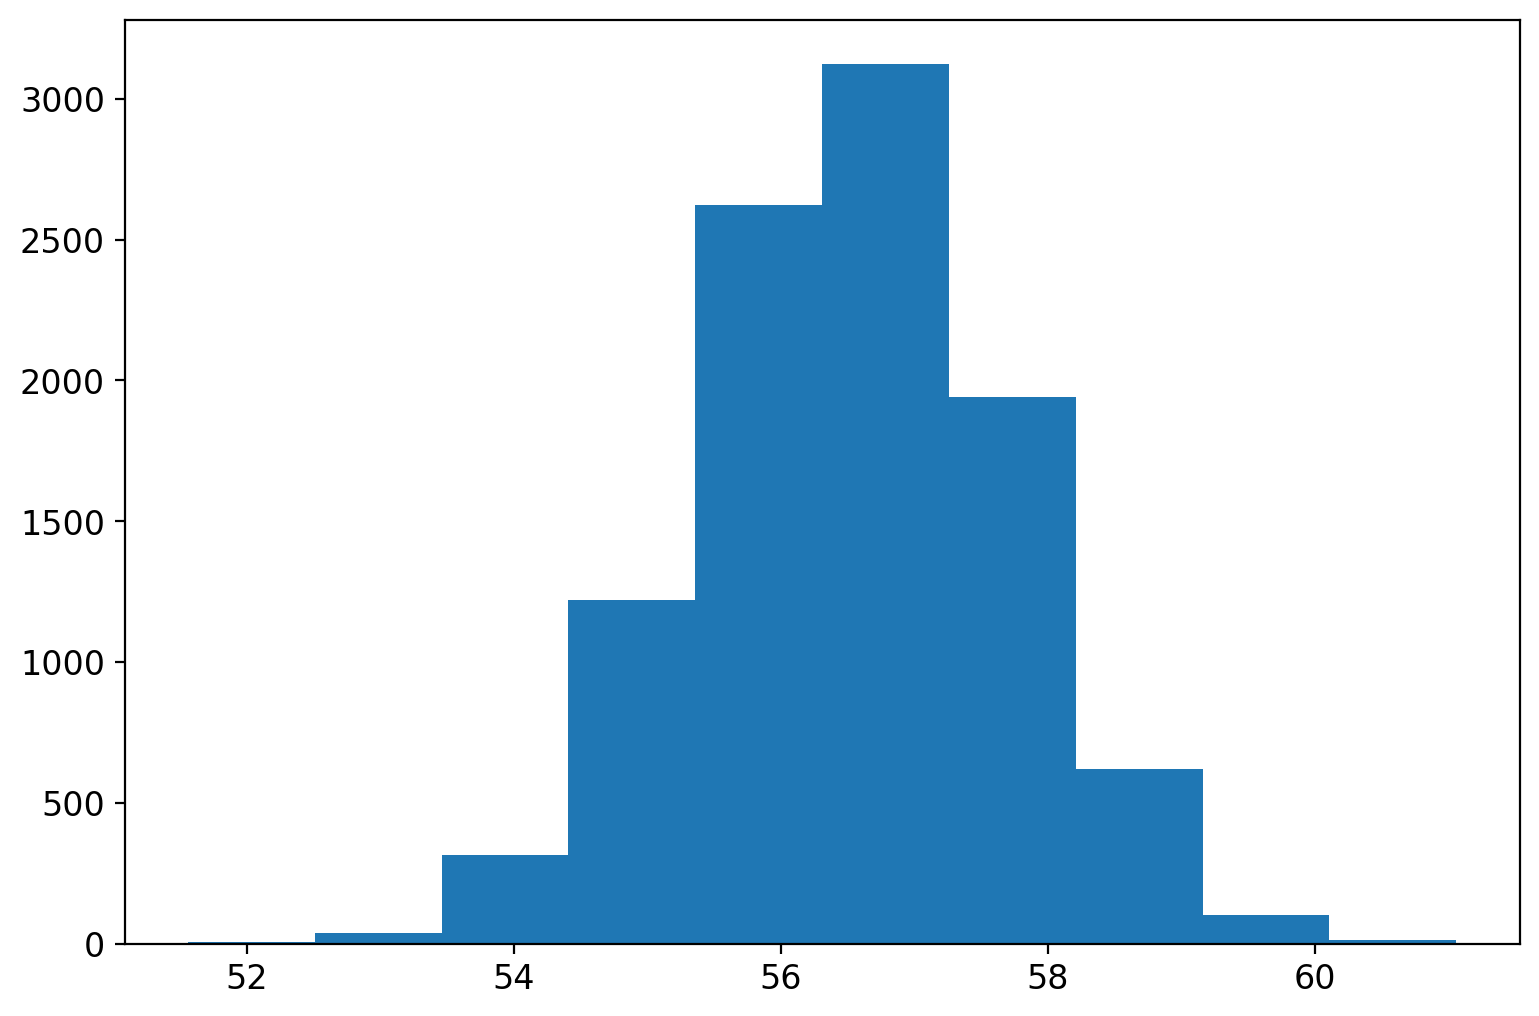

Mean of samples: 56.53081755747886
Std of mean of samples: 1.1715825969526106


In [55]:
#np.random.seed(0)

sample=np.random.choice(samples, size = 500)
print("Mean:",np.mean(sample))
print("RMS:",np.std(sample))

boot_means = []
boot_stds  = []
for _ in range(10000):
    boot_sample = np.random.choice(samples,replace = True, size = 500) # take a random sample each iteration
    boot_means.append(np.mean(boot_sample)) # append the mean to boot_means
    boot_stds.append(np.std(boot_sample)) # append the mean to boot_means
boot_means_np = np.array(boot_means) # transform it into a numpy array for calculation
boot_stds_np = np.array(boot_stds)

plt.hist(boot_means_np)
plt.show()

print("Mean of samples:",np.mean(boot_means_np))
print("Std of mean of samples:",np.std(boot_means_np))

plt.hist(boot_stds_np)
plt.show()

print("Mean of samples:",np.mean(boot_stds_np))
print("Std of mean of samples:",np.std(boot_stds_np))

Now lets compare this with the true values from analytic calculations, and see how well we do

In [56]:
analytic         = (300.+100.)/2.
analytic_std     = (300.-100.)/np.sqrt(12.)
analytic_err     = analytic_std/np.sqrt(500.)
analytic_std_err = analytic_std/np.sqrt(500.)/2. ## Note this 2 needs checking!
print("Mean of samples:",np.mean(boot_means_np),"+/-",np.std(boot_means_np)
      ,"\nAnalytic:",analytic,"+/-",analytic_err)

print("Std of samples:",np.mean(boot_stds_np),"+/-",np.std(boot_stds_np)
      ,"\nAnalytic:",analytic_std,"+/-",analytic_std_err)


Mean of samples: 200.08860253310704 +/- 2.545796074574372 
Analytic: 200.0 +/- 2.581988897471611
Std of samples: 56.53081755747886 +/- 1.1715825969526106 
Analytic: 57.73502691896258 +/- 1.2909944487358056


Now, interestingly, what if we did the same but just randomly sampled every time. This would really be the correct way to get the variance. However, we sometimes don't have the opportunity or the computing power to do this. Let's go ahead and take a look.

In [57]:
samp_means = []
samp_stds  = []
for _ in range(10000):
    samp_sample = np.random.uniform(100,300,500)
    samp_means.append(np.mean(samp_sample)) # append the mean to boot_means
    samp_stds.append(np.std(samp_sample)) # append the mean to boot_means
samp_means_np = np.array(samp_means) # transform it into a numpy array for calculation
samp_stds_np = np.array(samp_stds)

print("Mean of samples:",np.mean(samp_means_np),"+/-",np.std(samp_means_np)
      ,"\nBoot:",np.mean(boot_means_np),"+/-",np.std(boot_means_np))

print("Std of samples:",np.mean(samp_stds_np),"+/-",np.std(samp_stds_np)
      ,"\nBoot:",np.mean(boot_stds_np),"+/-",np.std(boot_stds_np))


Mean of samples: 199.99410216783514 +/- 2.556464208743879 
Boot: 200.08860253310704 +/- 2.545796074574372
Std of samples: 57.67447910409675 +/- 1.152072629308815 
Boot: 56.53081755747886 +/- 1.1715825969526106


While its not perfect, it does give us the notion of variability that we have. Importantly, for the bottom one we sampled a uniform distribution millions of times, whereas for the boostrap we only sampled the uniform distribution once. This will be critical once we go and try to assess the uncertainty on derived quantities.

Ok, now that we have done this by hand, lets use the `scipy.stats` tool to make our boostrap life much easier.

In [58]:
from scipy.stats import bootstrap
import numpy as np

test_samples = (samples,)
bootstrap_ci = bootstrap(test_samples, np.std, confidence_level=0.68,random_state=1, method='percentile')
print(bootstrap_ci.confidence_interval,(bootstrap_ci.confidence_interval.high-bootstrap_ci.confidence_interval.low)/2.)
print(bootstrap_ci.standard_error)

ConfidenceInterval(low=55.349226706125016, high=57.664964240810114) 1.1578687673425492
1.1625544183968848


Now the big gain from this approach is that we can start to compute really complicated things that we would not be able to do without sampling events.

For instance, let's consider a function that is not necessarily differentiable, and see if we can compute the uncertainty on the mean, and corrleation between the outputs

(500, 10)


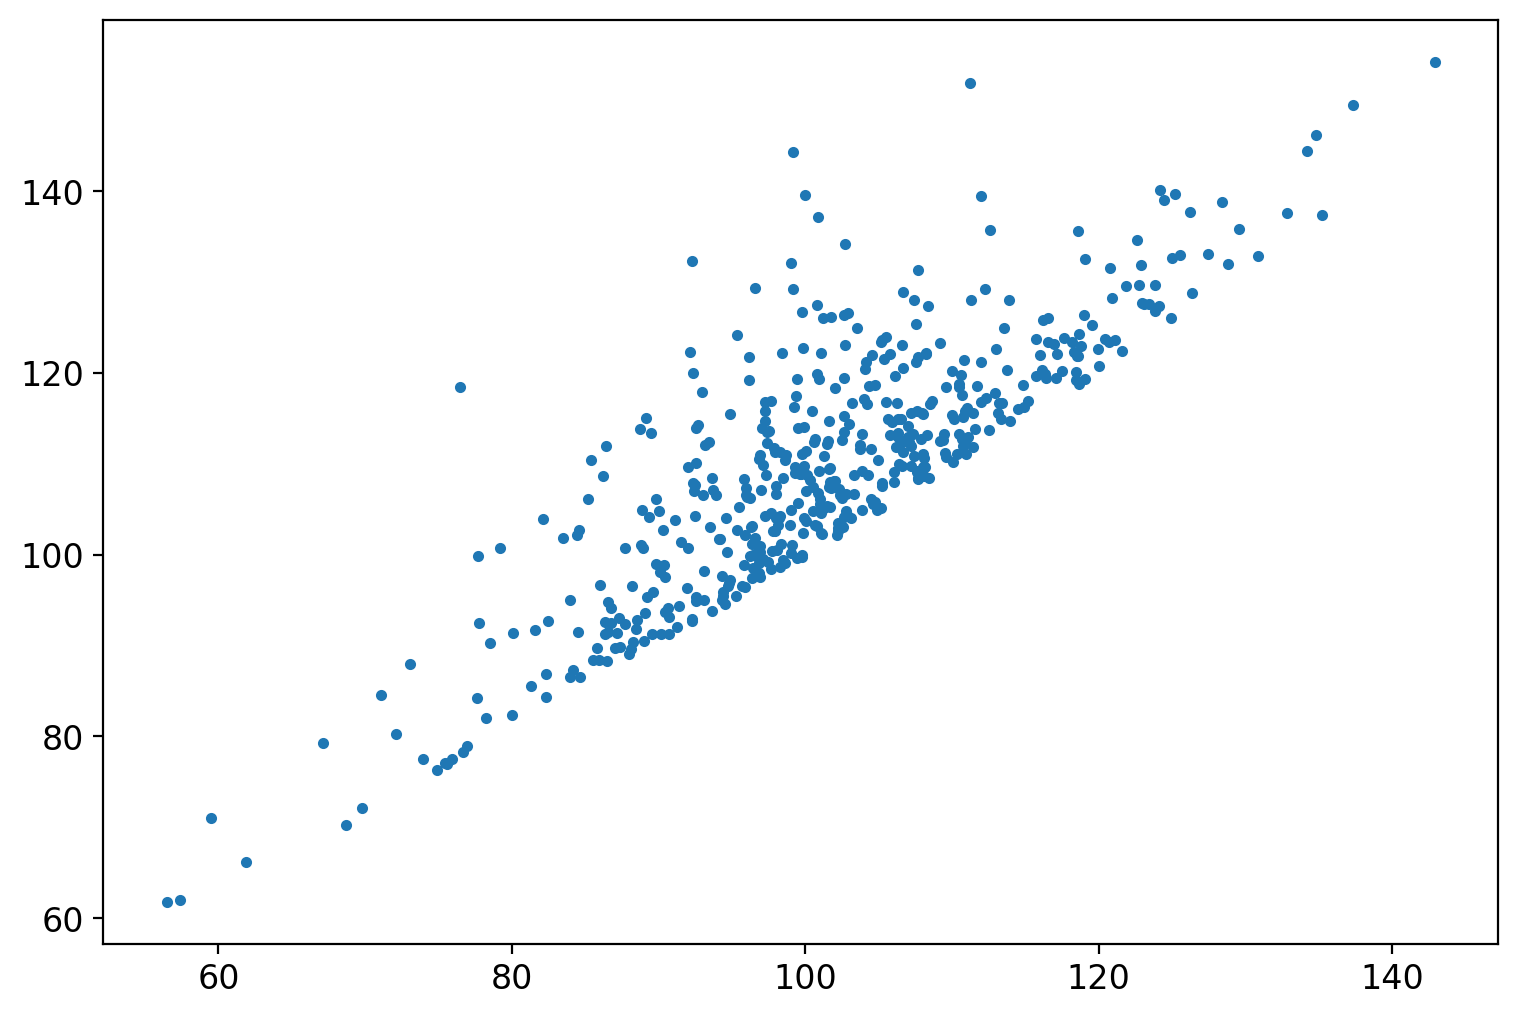

correlation: [[1.         0.83433051]
 [0.83433051 1.        ]]


(array([  4.,   9.,  16.,  60., 126., 151.,  92.,  28.,  11.,   3.]),
 array([118.30523752, 136.19470397, 154.08417042, 171.97363687,
        189.86310332, 207.75256977, 225.64203622, 243.53150267,
        261.42096912, 279.31043557, 297.19990202]),
 <BarContainer object of 10 artists>)

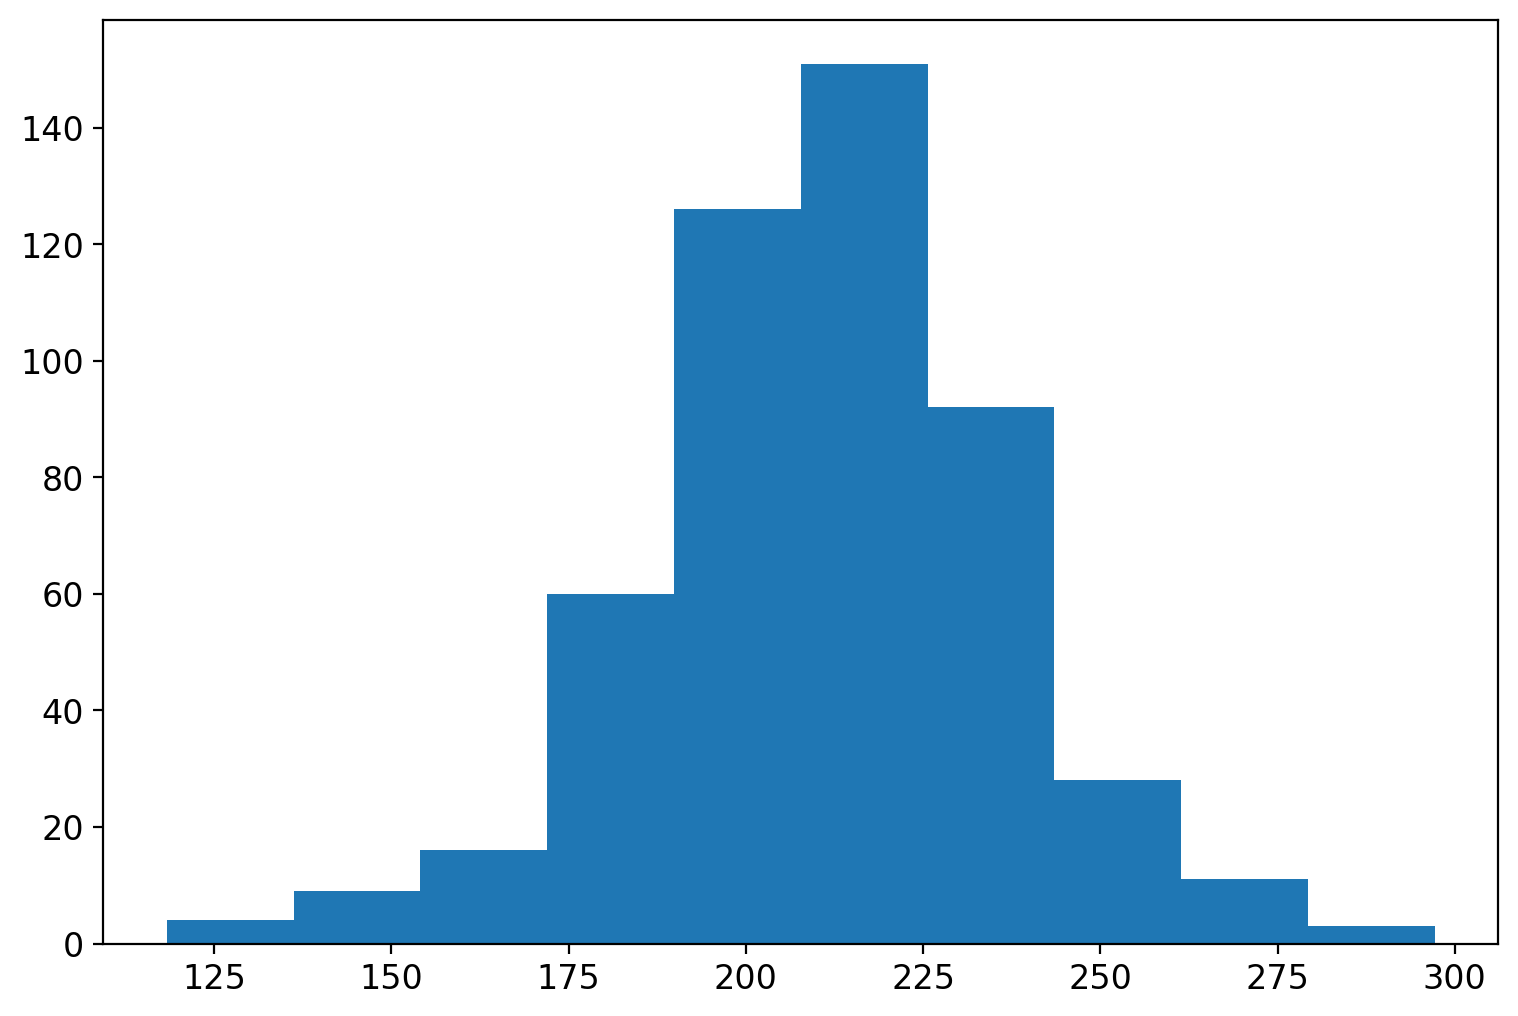

In [59]:
def func(x):
    x_sort = np.sort(x,axis=1)
    print(x_sort.shape)
    return (np.vstack((x_sort[:,0] + x_sort[:,-1],x_sort[:,1] + x_sort[:,-1] ))).T

rand_data = np.random.uniform(0,100,5000).reshape(500,10)
out_data = func(rand_data)
plt.plot(out_data[:,0],out_data[:,1],".")
plt.show()
print("correlation:",np.corrcoef(out_data[:,0],out_data[:,1]))

plt.hist(out_data[:,0]+out_data[:,1])

Ok, so the above is some complicated mess. Let's bootstrap this guy, and see how much things vary. Since, we

Sum of Boot: 211.20684981480517 +/- 1.1835588012894112 --- 0.6499336117093886
Corr of samples: 0.8346870156081033 +/- 0.019170289268034612
(1000,)


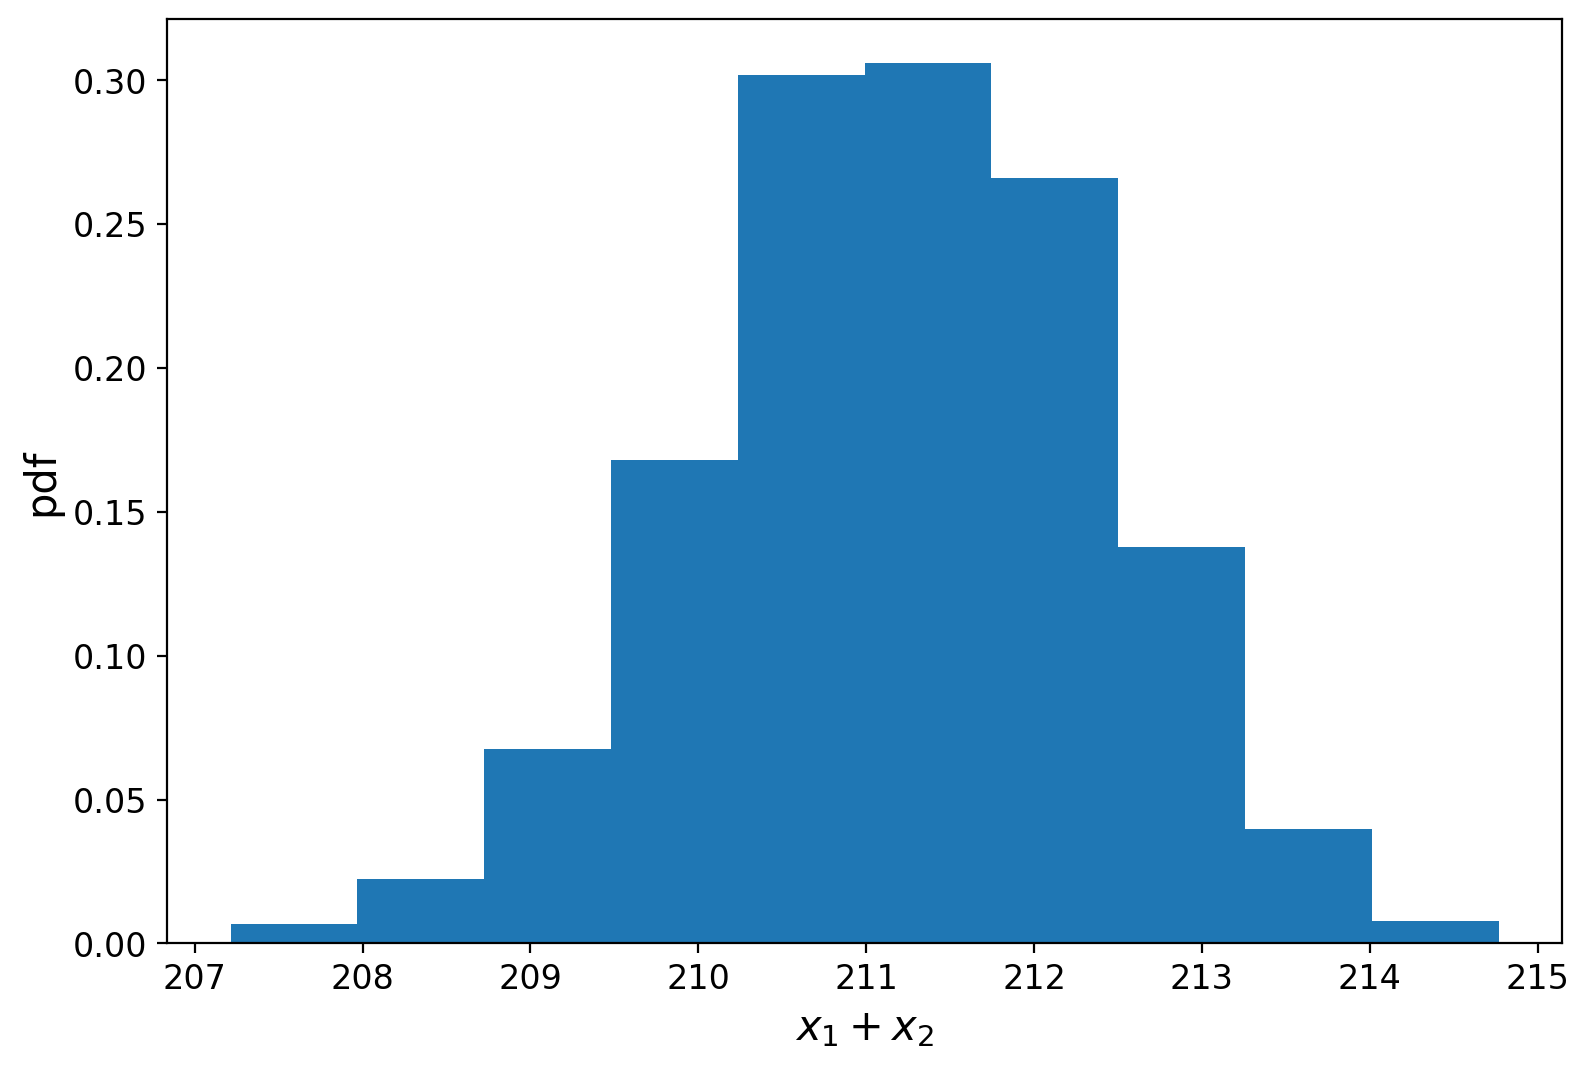

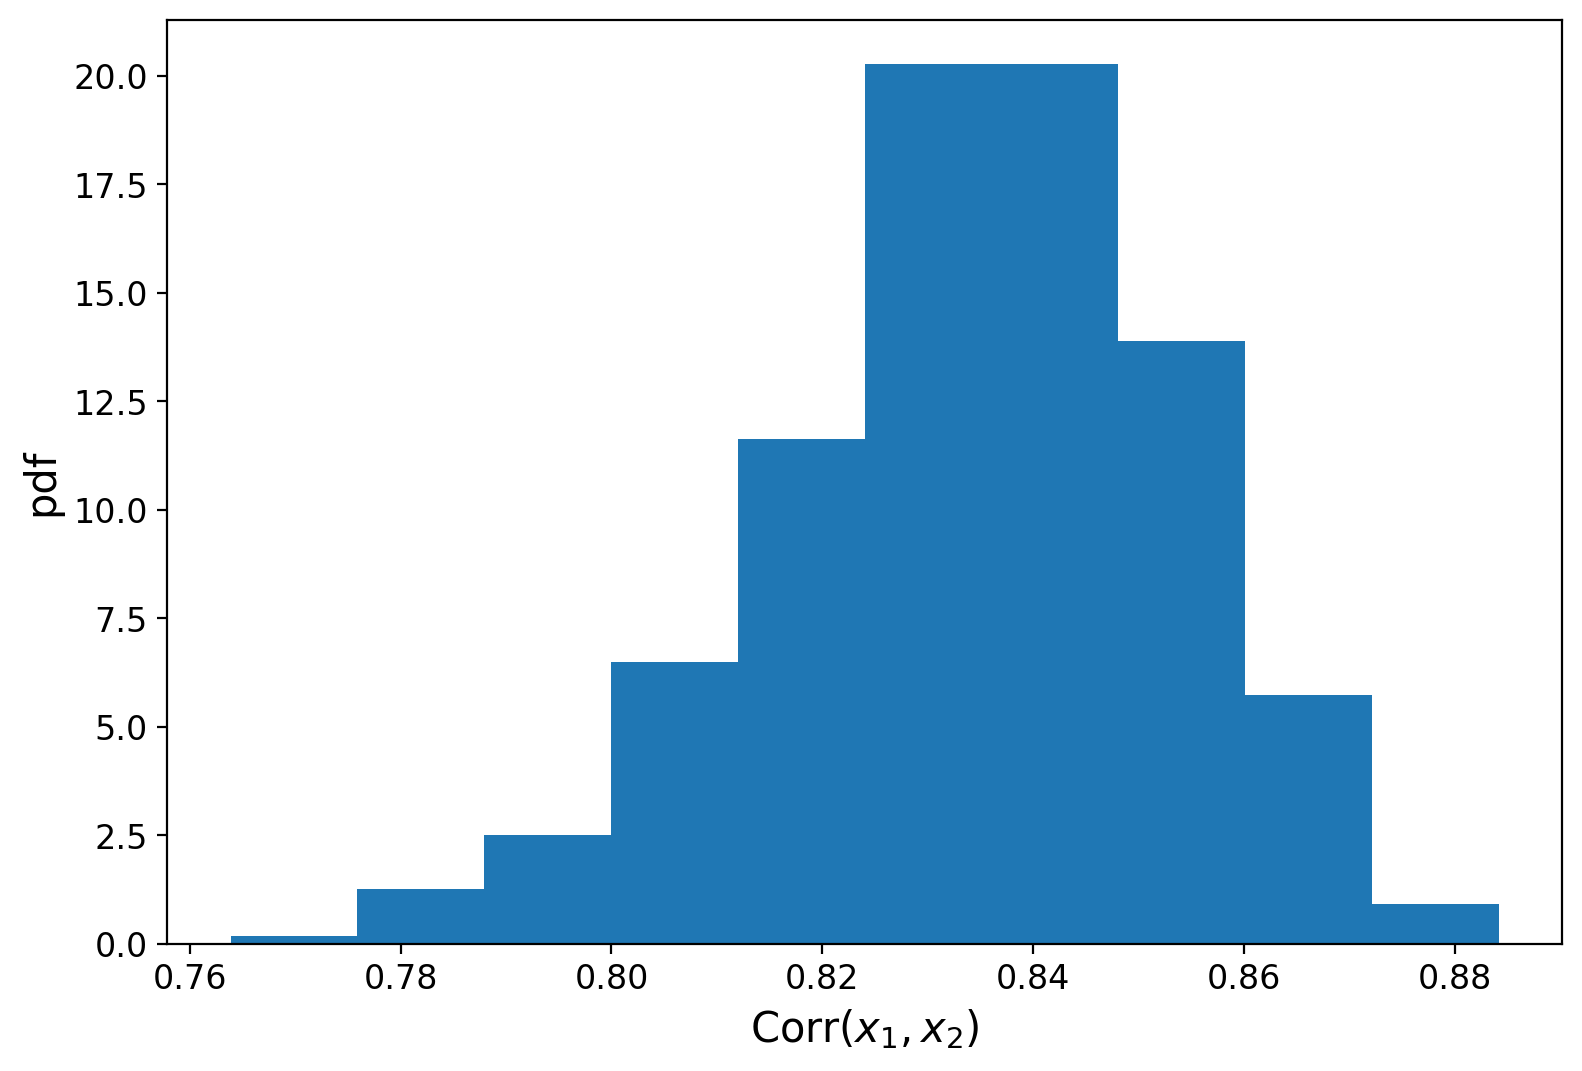

In [61]:
boot_sum   = []
boot_corr  = []
for _ in range(1000):
    #boot_sample = np.random.choice(out_data,replace = True, size = 500) # take a random sample each iteration
    boot_sample = out_data[np.random.choice(out_data.shape[0], 500, replace=True)]
    boot_sum.append(np.mean(boot_sample[:,0]+boot_sample[:,1]))
    boot_corr.append(np.corrcoef(boot_sample[:,0],boot_sample[:,1])[1,0])
boot_sum_np = np.array(boot_sum) # transform it into a numpy array for calculation
boot_corr_np = np.array(boot_corr)
print("Sum of Boot:",np.mean(boot_sum_np),"+/-",np.std(boot_sum_np),"---",np.sqrt(np.mean(boot_sum_np)/500))
print("Corr of samples:",np.mean(boot_corr_np),"+/-",np.std(boot_corr_np))
print(boot_sum_np.shape)

plt.hist(boot_sum_np,density=True)
plt.xlabel("$x_{1}+x_{2}$")
plt.ylabel("pdf")
plt.show()

plt.hist(boot_corr_np,density=True)
plt.xlabel("Corr($x_{1},x_{2}$)")
plt.ylabel("pdf")
plt.show()

Now there is one other approach to obtaining uncertainty from a fixed dataset. This approach is known as the delete-d jackknikfe. In the delete-d jackknife our strategy is to remove a subset of events and recompute the observables. We can then repeat this strategy many times by removing a few events and recomputing everything. The "Delete-d" refers to d as the removal of an event. This is sometimes even done as the delete-1 jackknife.

Unlike the bootstrap where we resample many times and we find that standard deviation of the bootstrap ($\sigma_{\rm bootstrap}$) approximates the standard error:

$\sigma_{\rm bootstrap} \approx \sigma_{\rm error}$

With the delete-d jackknife we have that we have to correct for the fact that the we are removing a very small number of elements from the dataset, and so the variance over removing just d elements from the dataset needs to be corrected and so we have: 

$\sigma_{\rm jackknife} \approx \frac{_n{C}_{d}}{\frac{n}{d}}\sigma_{\rm error}$

<a name='exercises_22_5'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_5) | [Next Section](#section_22_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 20.5.1</span>

In the following exercise, we will perform a t-test to see if two Gaussian distributions with $\sigma=1$ and mean $5$ or $7$ are statistically similar to each other. We will then boostrap this t-test to compute the uncertainty on our p-value confidence of tehse being different. 

<br>

In [197]:
import numpy as np
from scipy import stats

# Set random seed for reproducibility
np.random.seed(0)

# Generate two random samples from Gaussian distributions
sample1 = np.random.normal(loc=5.5, scale=1, size=30)  # Mean=5, Std=2
sample2 = np.random.normal(loc=7, scale=1, size=30)  # Mean=7, Std=2

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(sample1, sample2)

# Print results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The means of the two samples are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two samples.")


T-statistic: -2.9389770379445226
P-value: 0.004720335438244337
Reject the null hypothesis: The means of the two samples are significantly different.


In [198]:
import numpy as np
from scipy import stats

# Set random seed for reproducibility
np.random.seed(0)

# Generate two random samples from Gaussian distributions
sample1 = np.random.normal(loc=5.5, scale=1, size=30)  # Mean=5, Std=2
sample2 = np.random.normal(loc=7, scale=1, size=30)  # Mean=7, Std=2

# Function to compute t-statistic from two samples
def compute_t_statistic(sample1, sample2):
    mean_diff = np.mean(sample1) - np.mean(sample2)
    pooled_var = ((len(sample1) - 1) * np.var(sample1, ddof=1) + (len(sample2) - 1) * np.var(sample2, ddof=1)) / (len(sample1) + len(sample2) - 2)
    pooled_std = np.sqrt(pooled_var)
    t_stat = mean_diff / (pooled_std * np.sqrt(1 / len(sample1) + 1 / len(sample2)))
    return t_stat

# Bootstrap resampling
num_bootstraps = 10000
t_statistics = []

for _ in range(num_bootstraps):
    # Resample with replacement from the original samples
    resampled1 = np.random.choice(sample1, size=len(sample1), replace=True)
    resampled2 = np.random.choice(sample2, size=len(sample2), replace=True)

    # Compute t-statistic for the resampled data
    t_stat = compute_t_statistic(resampled1, resampled2)
    t_statistics.append(t_stat)

# Calculate p-value
observed_t_stat = compute_t_statistic(sample1, sample2)
#p_value = np.mean(np.abs(t_statistics) >= np.abs(observed_t_stat))
mean_tstat = np.mean(t_statistics)
std_tstat  = np.std(t_statistics)
p_value    = stats.t.cdf(mean_tstat+2*std_tstat, len(sample1))

# Print results
print(f"Observed T-statistic: {observed_t_stat}")
print(f"Mean T-stat {mean_tstat}")
print(f"Std T-stat {std_tstat}")
print(f"Std p-value with 95% confidence {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The means of the two samples are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two samples.")


Observed T-statistic: -2.9389770379445226
Mean T-stat -3.004629321125194
Std T-stat 0.9768153714635951
Std p-value with 95% confidence 0.15082600748298375
Fail to reject the null hypothesis: There is no significant difference between the means of the two samples.


<a name='section_20_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L20.6 Bootstrapping For Neural Networks</h2>  

| [Top](#section_20_0) | [Previous Section](#section_20_5) | [Exercises](#exercises_20_6) |

Now that we have gone through the prospects of what it is like to use the bootstrap method, lets go ahead and see if we can use it to get the uncertainties of our generated sample of proton events. This is really where methods like boostrap can really help us.  In this section, we will take our simulated proton events and we wil extract uncertainties in the energy shape and profile of the simulation, once we have done that we can go ahead and see if we can do the same thing with our neural network output.

To do this, lets look at the profile along distance of our bins. To make it clear this is an issue, we can make a plot where we use the standard devation, and one where we use the standard deviation/$\sqrt{N}$. Neither of these seem very appropriate.

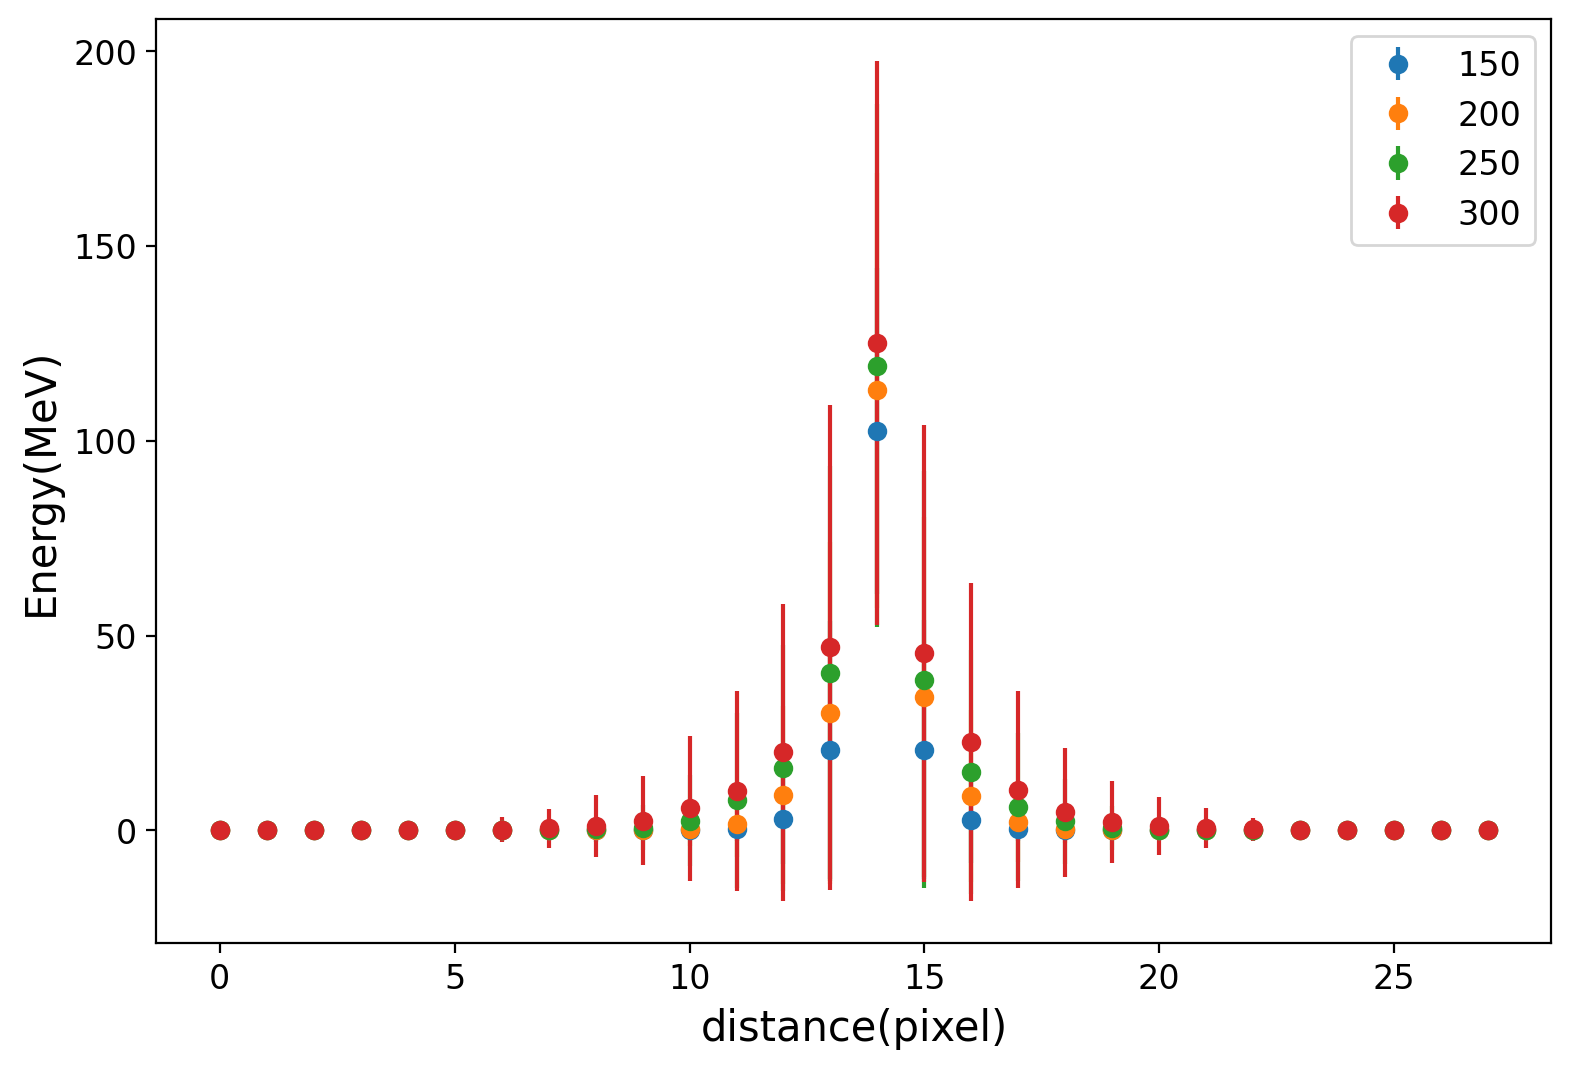

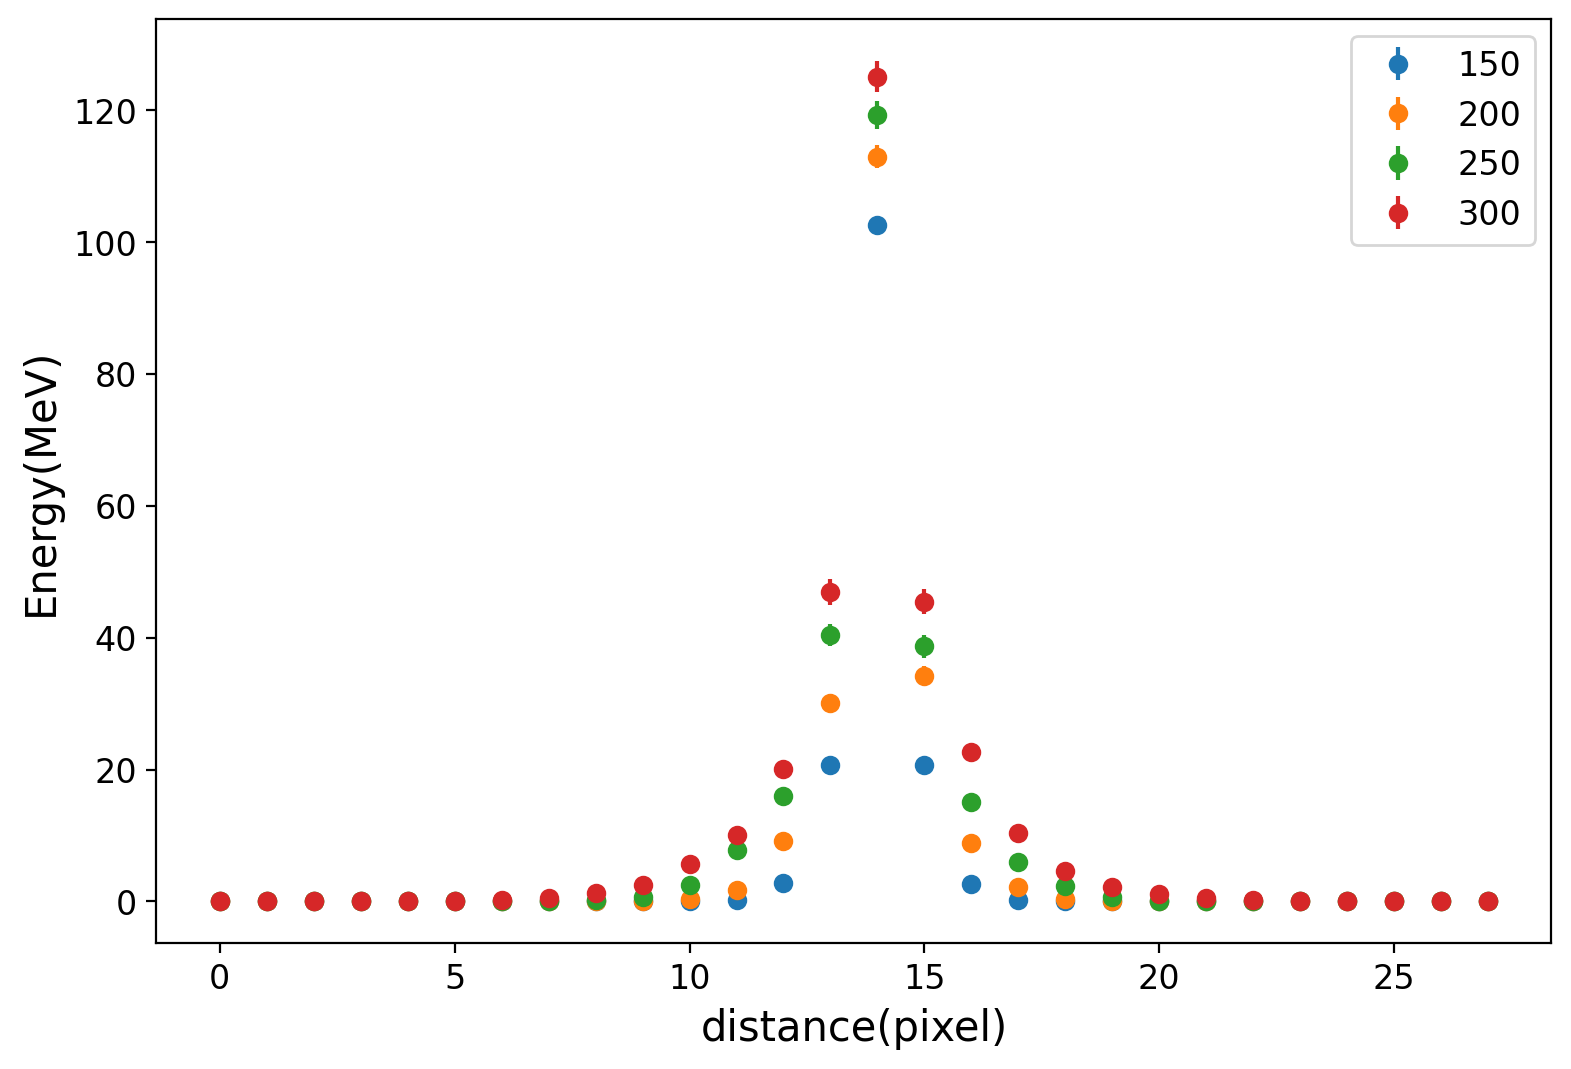

In [62]:
def makeDataset(iId,ixstep,iestep,iystep):
    print(ixstep.shape,iestep.shape,iystep.shape)
    outdata = np.hstack((ixstep,iystep,iestep))
    outdata = outdata.reshape(1000,3,ixstep.shape[1])
    return outdata

#bootdatastep150=makeDataset(-1,xstep150,estep150,ystep150)
#bootdatastep200=makeDataset(-1,xstep200,estep200,ystep200)
#bootdatastep250=makeDataset(-1,xstep250,estep250,ystep250)
#bootdatastep300=makeDataset(-1,xstep300,estep300,ystep300)

def profile(iInput):
    profile_out=np.sum(iInput,axis=3)
    return profile_out

out_profile150=profile(dimage150)
out_profile200=profile(dimage200)
out_profile250=profile(dimage250)
out_profile300=profile(dimage300)

test_150 = np.mean(out_profile150,axis=0)
test_200 = np.mean(out_profile200,axis=0)
test_250 = np.mean(out_profile250,axis=0)
test_300 = np.mean(out_profile300,axis=0)

test_150_std = np.std(out_profile150,axis=0)
test_200_std = np.std(out_profile200,axis=0)
test_250_std = np.std(out_profile250,axis=0)
test_300_std = np.std(out_profile300,axis=0)

test_150_stderr = np.std(out_profile150,axis=0)/np.sqrt(dimage150.shape[0])
test_200_stderr = np.std(out_profile200,axis=0)/np.sqrt(dimage200.shape[0])
test_250_stderr = np.std(out_profile250,axis=0)/np.sqrt(dimage250.shape[0])
test_300_stderr = np.std(out_profile300,axis=0)/np.sqrt(dimage300.shape[0])

plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_std,fmt='o',label='150')
plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_std,fmt='o',label='200')
plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_std,fmt='o',label='250')
plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_std,fmt='o',label='300')
plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()

plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_stderr,fmt='o',label='150')
plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_stderr,fmt='o',label='200')
plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_stderr,fmt='o',label='250')
plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_stderr,fmt='o',label='300')
plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()

Ok now that we have profile, lets go ahead and run the profile with a bootstrap.

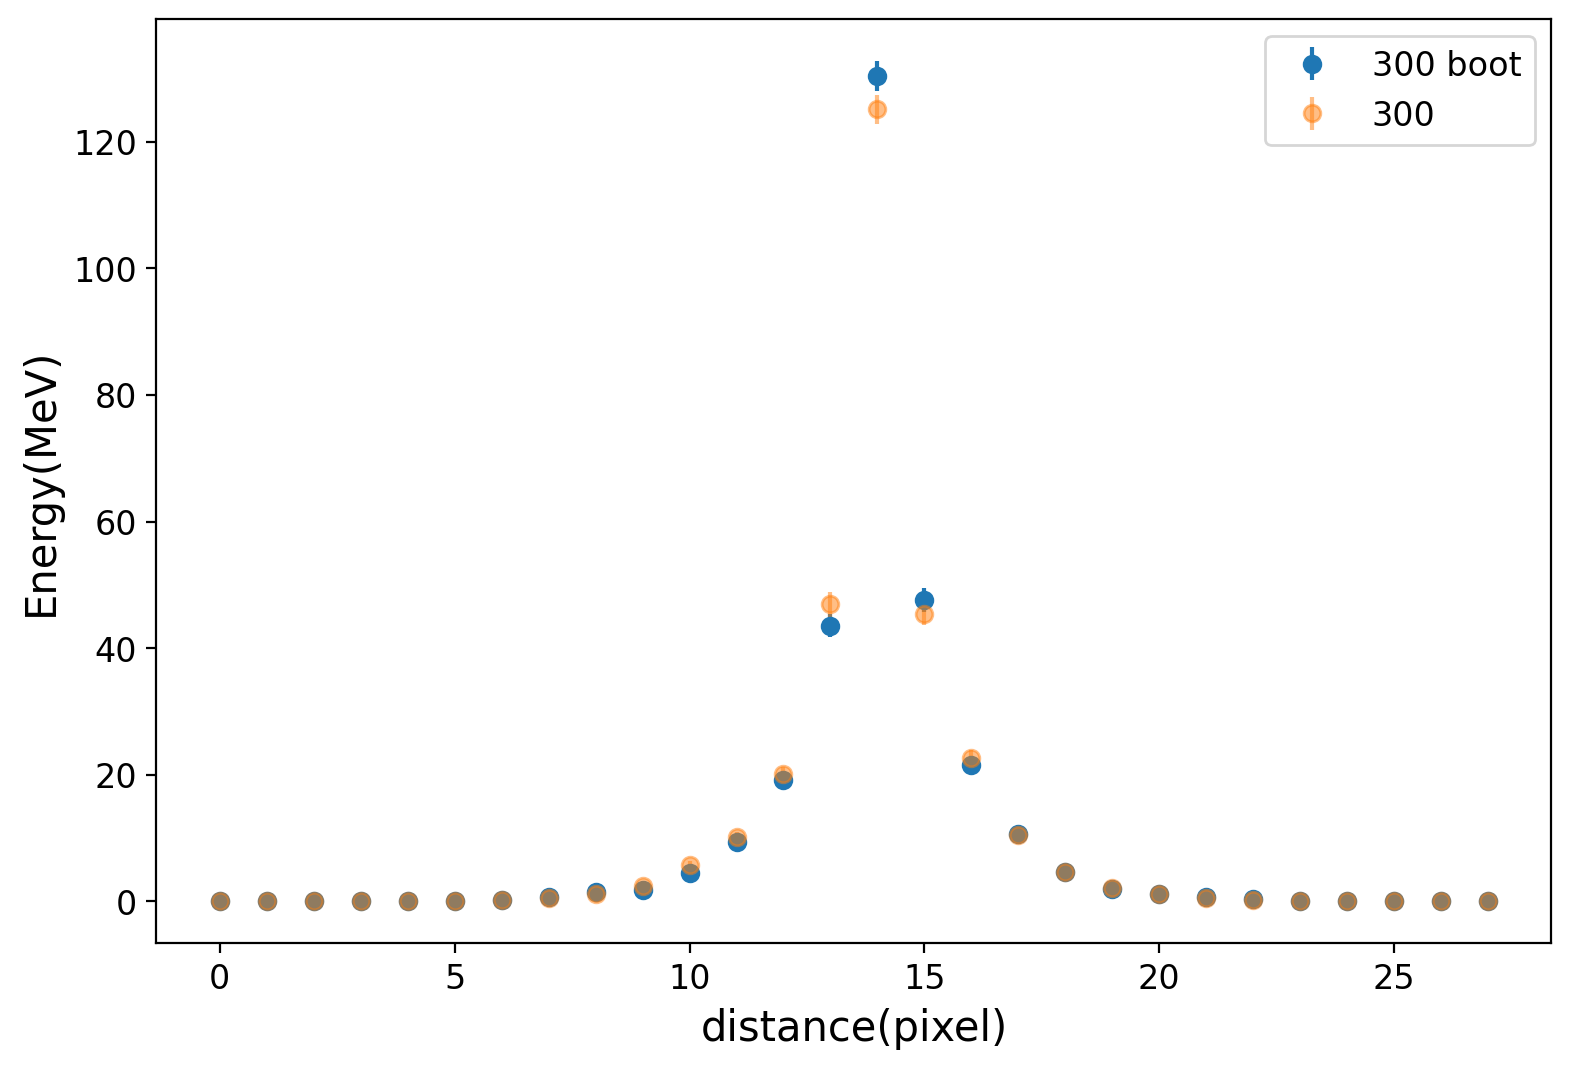

In [64]:
#def profile(iInput):
#    profile_out=np.sum(iInput,axis=3)
#    return profile_out

def profileVar(iData,iNSample):
    boot_profile = []
    for _ in range(iNSample):
        boot_sample = iData[np.random.choice(out_data.shape[0], iNSample, replace=True)]
        boot_prof   = np.mean(profile(boot_sample),axis=0)
        boot_profile.append(boot_prof)
    boot_profile = np.array(boot_profile) # transform it into a numpy array for calculation
    return np.mean(boot_profile,axis=0),np.std(boot_profile,axis=0)

Nsamps=1000
dimage150_boot,dimage150_boot_err = profileVar(dimage150,Nsamps)
dimage200_boot,dimage200_boot_err = profileVar(dimage200,Nsamps)
dimage250_boot,dimage250_boot_err = profileVar(dimage250,Nsamps)
dimage300_boot,dimage300_boot_err = profileVar(dimage300,Nsamps)

#plt.errorbar(np.arange(28),dimage150_boot.flatten(),yerr=dimage150_boot_err,fmt='o',label='150')
#plt.errorbar(np.arange(28),dimage200_boot.flatten(),yerr=dimage200_boot_err,fmt='o',label='200 boot')
#plt.errorbar(np.arange(28),dimage250_boot.flatten(),yerr=dimage250_boot_err,fmt='o',label='250')
plt.errorbar(np.arange(28),dimage300_boot.flatten(),yerr=dimage300_boot_err,fmt='o',label='300 boot')

#plt.errorbar(np.arange(28),test_150.flatten(),yerr=test_150_stderr,fmt='o',label='150',alpha=0.5)
#plt.errorbar(np.arange(28),test_200.flatten(),yerr=test_200_stderr,fmt='o',label='200',alpha=0.5)
#plt.errorbar(np.arange(28),test_250.flatten(),yerr=test_250_stderr,fmt='o',label='250',alpha=0.5)
plt.errorbar(np.arange(28),test_300.flatten(),yerr=test_300_stderr,fmt='o',label='300',alpha=0.5)

plt.legend()
plt.xlabel('distance(pixel)')
plt.ylabel('Energy(MeV)')
plt.show()


Now, lets consider a more complicated variable that we can't necessarily compute.  

3.2771233358763903 2.1280869593938
check 200: 3.3654587785353036 +/- 1.6562868377640825


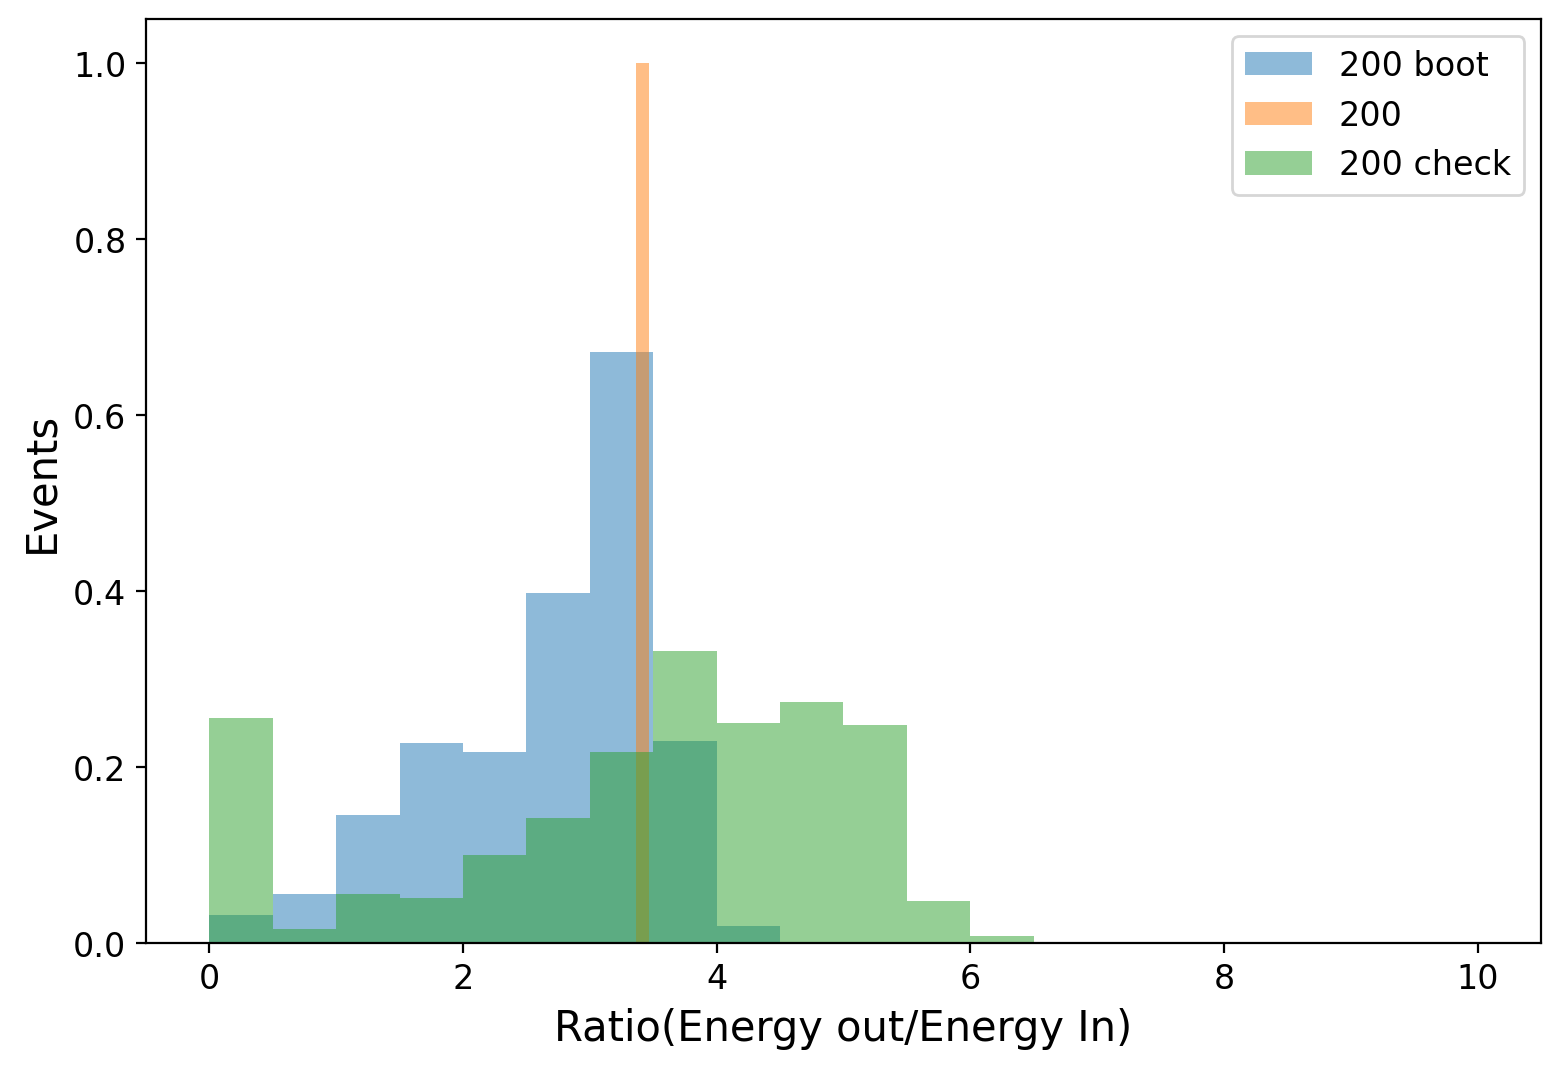

Val: 3.2771233358763903 +/- 0.06729601850586667 boot 2.6802860106820625 +/- 0.9467231348733942
Val: 3.3654587785353036 +/- 0.05237638865892287 boot 2.671294607098637 +/- 0.8424921008959041
Val: 2.7453626625473024 +/- 0.09306596740812087 boot 2.599078127748061 +/- 0.940720237376715
Val: 3.019428617284072 +/- 0.06779921248745453 boot 2.516427153506648 +/- 0.9205274851450614


In [69]:
def xmaxprofile(iInput):
    profile_out=np.sum(iInput,axis=2)
    maxbin=np.argmax(profile_out,axis=2)
    return np.mean(maxbin,axis=0),np.std(maxbin,axis=0)

def xmaxprofile(iInput):
    profile_out=np.sum(iInput,axis=2)
    profile_out=np.reshape(profile_out,(iInput.shape[0],28))
    #maxbin=np.argmax(profile_out,axis=1)
    maxbin=np.unravel_index(np.argmax(profile_out, axis=1), profile_out.shape)
    Ein=np.sum(profile_out[:,0:2],axis=1)
    Eout=profile_out[maxbin]#+profile_out[:,maxbin+1]+profile_out[:,maxbin-1]
    ratio=Eout/Ein
    #print(Ein[0],Eout[0],Eout.shape)
    return np.mean(ratio),np.std(ratio)

def xmaxprofilecheck(iInput):
    profile_out=np.sum(iInput,axis=2)
    profile_out=np.reshape(profile_out,(iInput.shape[0],28))
    #maxbin=np.argmax(profile_out,axis=1)
    maxbin=np.unravel_index(np.argmax(profile_out, axis=1), profile_out.shape)
    Ein=np.sum(profile_out[:,0:2],axis=1)
    Eout=profile_out[maxbin]#+profile_out[:,maxbin+1]+profile_out[:,maxbin-1]
    ratio=Eout/Ein
    #print(Ein[0],Eout[0],Eout.shape)
    return ratio

def xmaxprofileVar(iData,iNSample):
    boot_profile = []
    for _ in range(iNSample):
        boot_sample          = iData[np.random.choice(out_data.shape[0], 1000, replace=True)]
        boot_prof,boot_std   = xmaxprofile(boot_sample)
        boot_profile.append(boot_prof)
    boot_profile = np.array(boot_profile) # transform it into a numpy array for calculation
    #return np.mean(boot_profile,axis=0),np.std(boot_profile,axis=0)
    return boot_profile

xtest_150,xtest_150_std=xmaxprofile(dimage150)
xtest_200,xtest_200_std=xmaxprofile(dimage200)
xtest_250,xtest_250_std=xmaxprofile(dimage250)
xtest_300,xtest_300_std=xmaxprofile(dimage300)
print(xtest_150,xtest_150_std)

xtest_150_stderr = xtest_150_std/np.sqrt(dimage150.shape[0])
xtest_200_stderr = xtest_200_std/np.sqrt(dimage200.shape[0])
xtest_250_stderr = xtest_250_std/np.sqrt(dimage250.shape[0])
xtest_300_stderr = xtest_300_std/np.sqrt(dimage300.shape[0])

Nsamps=1000
dimage150_boot = xmaxprofileVar(dimage150,Nsamps)
dimage200_boot = xmaxprofileVar(dimage200,Nsamps)
dimage250_boot = xmaxprofileVar(dimage250,Nsamps)
dimage300_boot = xmaxprofileVar(dimage300,Nsamps)

#plt.hist(dimage150_boot.flatten(),density=True,label='150',alpha=0.5)
plt.hist(dimage200_boot.flatten(),bins=20,range=[0,10],density=True,label='200 boot',alpha=0.5)
#plt.hist(dimage250_boot.flatten(),density=True,label='250',alpha=0.5)
#plt.hist(dimage300_boot.flatten(),density=True,label='300',alpha=0.5)

#plt.hist(xtest_150.flatten(),label='150',alpha=0.5)
plt.hist(xtest_200.flatten(),label='200',alpha=0.5)
#plt.hist(xtest_250.flatten(),label='250',alpha=0.5)
#plt.hist(xtest_300.flatten(),label='300',alpha=0.5)


xtest_200_check=xmaxprofilecheck(dimage200)
#xtest_300_check=xmaxprofilecheck(dimage300)
plt.hist(xtest_200_check.flatten(),bins=20,range=[0,10],density=True,label='200 check',alpha=0.5)
print("check 200:",np.mean(xtest_200_check),"+/-",np.std(xtest_200_check))
#print("check 300:",np.mean(xtest_300_check),"+/-",np.std(xtest_300_check))


plt.legend()
plt.xlabel('Ratio(Energy out/Energy In)')
plt.ylabel('Events')
plt.show()

def printStats(ival,ierr,iboot):
    print("Val:",ival,"+/-",ierr,"boot",np.mean(iboot),"+/-",np.std(iboot))

printStats(xtest_150,xtest_150_stderr,dimage150_boot,)
printStats(xtest_200,xtest_200_stderr,dimage200_boot)
printStats(xtest_250,xtest_250_stderr,dimage250_boot)
printStats(xtest_300,xtest_300_stderr,dimage300_boot)

Now how is this variabililty, if we generate 1000 images and try to compute it.

## Auxiliary info

In [ ]:
#https://www.kaggle.com/code/augeropendata/the-heitler-model/notebook

<a name='exercises_22_6'></a>     

| [Top](#section_22_0) | [Restart Section](#section_22_6) |
